In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = True

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234


In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 20
MIN_SIZE = 0
NUM_CORES = 24

In [ ]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
SAMPLE_RATIO = 0.01

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/pg-vectors/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample_" + str(SAMPLE_RATIO) + "/"


root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "sample_" + str(SAMPLE_RATIO))
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"
validation_docs_list_file = exports_location + "validation_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_sample_%s_data_preprocessed-" % str(SAMPLE_RATIO)
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_sample_%s_docids_preprocessed-" % str(SAMPLE_RATIO)
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_sample_%s_data_preprocessed-" % str(SAMPLE_RATIO)
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_sample_%s_docids_preprocessed-" % str(SAMPLE_RATIO)

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))

CPU times: user 15.4 s, sys: 712 ms, total: 16.1 s
Wall time: 16.2 s


In [11]:
SMALL_SAMPLE_RATIO = 0.0001

validation_small_preprocessed_files_prefix = root_location + "validation_docs_sample_%s_data_preprocessed-" % str(SMALL_SAMPLE_RATIO)
validation_small_preprocessed_docids_files_prefix = root_location + "validation_docs_sample_%s_docids_preprocessed-" % str(SMALL_SAMPLE_RATIO)

validation_small_docs_list_file = exports_location + "validation_documents_" + str(SMALL_SAMPLE_RATIO) + "_sample.pkl"
validation_small_docs_list = pickle.load(open(validation_small_docs_list_file))

In [11]:
len(training_docs_list)

49789

In [12]:
len(validation_docs_list)

12412

In [13]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def train_level_new(docs_index, classification, doc_classification_map, number_of_terms):
    training_vectors = docs_index.map(
        lambda (doc_id, postings): get_training_vector(classification, postings,
                                                        doc_classification_map[doc_id], number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

def model_exists(path):
    try:
        model = SVMModel.load(sc, path)
        return True;
    except:
        return False
    
def get_training_vector(classification, dense_vector, classifications):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, dense_vector)

def train_level_doc2vec(classification, doc_classification_map):
    doc2vec_model = GLOBAL_VARS.DOC2VEC_MODEL
    training_vectors = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_vectors.append(get_training_vector(classification, normal_array, 
                                                    doc_classification_map[doc_id]))
    info("Finished getting training vectors")
    training_vectors = sc.parallelize(training_vectors)
    info("Finished parallelization")
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

In [15]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [16]:
def train_classifications(classifications):
    info("====== Doing Training")
    i=0
    for classification in classifications:
        print classification
        try:
            model_path = get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification)
            if not model_exists(model_path):
                training_vectors, svm = train_level_doc2vec(classification, doc_classification_map)
                svm.save(sc, model_path)
            else:
                print "Model Exists"
        except:
            print "Problem creating: %s: %s" % (classification, GLOBAL_VARS.MODEL_NAME)
            raise

In [17]:
def do_validation(validation_vectors_matrix, doc_classification_map, classifications, classifications_name):

    info("====== Doing Validation")
    method = GLOBAL_VARS.MODEL_NAME
    subset = classifications_name

    doc_count = validation_vectors_matrix.shape[0]
    y_score = np.zeros((doc_count, len(classifications)))
    y_true = np.zeros((doc_count, len(classifications)))
    i=0

    for classification in classifications:
        print classification

        validation_vectors = get_validation_doc2vec_spark_vectors(validation_vectors_matrix, 
                                                                  classification, doc_classification_map)
        #global binarySvm
        binarySvm = SVMModel.load(sc, get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification))
        info("Loaded the model, Doing the prediction now....")
        binarySvm.clearThreshold()
        binarySvmB = sc.broadcast(binarySvm)
        # using the broadcasted binarySvm variable, fixes global name 'binarySvm' is not defined as this variable was not
        # available in the workers, so we pass it explicitly to the mapper using partial
        labels_predictions = validation_vectors.map( \
            partial(lambda svm, p: (p.label, svm.value.predict(p.features)), binarySvmB) \
        ).collect()
        #labels = test_labeled_points.map(lambda p: p.labels)
        y_true[:,i] = [label_pred[0] for label_pred in labels_predictions]
        y_score[:,i] = [label_pred[1] for label_pred in labels_predictions]
        i+=1
    y_binary_score = get_binary(y_score)
    # results[method]["y_true"] = y_true
    # results[method]["y_score"] = y_score
    # results[method]["y_binary_score"] = y_binary_score
    metrics = get_metrics(y_true, y_score, y_binary_score)
    return metrics


In [18]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [19]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [20]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [21]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    return training_data, training_labels

In [22]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

#### Get starting positions in bytes for every line to be able to do random sampling

In [26]:
%%time
line_positions = dict()
with open(training_file) as f:
    
    i = 0
    line_positions[i] = f.tell()
    line = f.readline()
    while line:
        i+=1
        if not line.strip(): continue
        line_positions[i] = f.tell()
        line = f.readline()
    del line_positions[i]

CPU times: user 6.62 s, sys: 592 ms, total: 7.22 s
Wall time: 7.21 s


### Doc2vec and SVM Parameters

In [1]:
DOC2VEC_SIZE = 100
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 1000 # report the progress every x terms

In [2]:
SVM_ITERATIONS = 100
SVM_CONVERGENCE = 0.001
SVM_REG = 0.01
SVM_CLASS_WEIGHTS = 'balanced'
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

NameError: name 'GLOBAL_VARS' is not defined

In [178]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

## Create the Doc2vec model

In [201]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [202]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [203]:
%%time
training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-01-01 04:29:52,801 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model
2017-01-01 04:29:59,512 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.docvecs.* with mmap=None
2017-01-01 04:29:59,521 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.syn1neg.npy with mmap=None
2017-01-01 04:30:02,551 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.syn0.npy with mmap=None
2017-01-01 04:30:03,145 : INFO : setting ignored attribute syn0norm to None
2017-01-01 04:30:03,147 : INFO : setting ignored attribute cum_table to None
2017-01-01 04:30:03,523 : INFO : using concatenative 1700-dimensional layer1
2017-01-01 04:30:03,525 : INFO : resetting layer weights


CPU times: user 8 s, sys: 4.81 s, total: 12.8 s
Wall time: 13.1 s


In [182]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [204]:
doc2vec_model.min_alpha = 0.025
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [205]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

## SVM Training

<IPython.core.display.Javascript object>


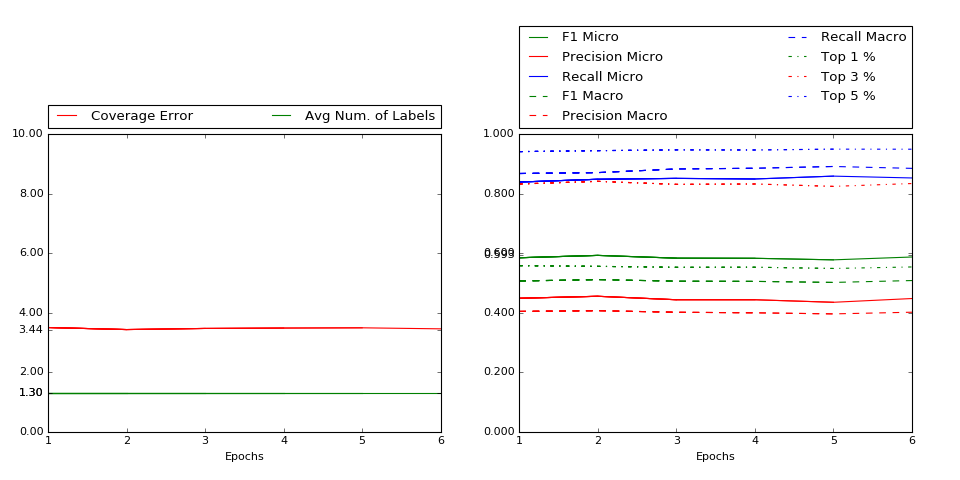

2017-01-01 01:57:01,372 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-01 01:57:01,373 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 01:57:01,375 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 01:57:01,396 : INFO : Loading new batch for index: 0
2017-01-01 01:58:39,295 : INFO : Finished loading new batch
2017-01-01 01:58:40,606 : INFO : PROGRESS: at 0.00% examples, 23 words/s, in_qsize 48, out_qsize 0
2017-01-01 01:59:00,689 : INFO : PROGRESS: at 5.15% examples, 119860 words/s, in_qsize 47, out_qsize 20
2017-01-01 01:59:20,683 : INFO : PROGRESS: at 10.51% examples, 207959 words/s, in_qsize 38, out_qsize 14
2017-01-01 01:59:40,822 : INFO : PROGRESS: at 15.98% examples, 275098 words/s, in_qsize 35, out_qsize 24
2017-01-01 01:59:5

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 02:08:45,193 : INFO : Getting Validation Embeddings
2017-01-01 02:08:45,195 : INFO : ===== Getting validation vectors with inference
2017-01-01 02:08:45,228 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.490, Avg Labels: 1.290, 
		 Top 1: 0.563, Top 3: 0.834, Top 5: 0.936, 
		 F1 Micro: 0.593, Total Pos: 115,996


2017-01-01 02:08:54,741 : INFO : Finished loading new batch
2017-01-01 02:09:19,779 : INFO : Finished: 999
2017-01-01 02:09:44,943 : INFO : Finished: 1999
2017-01-01 02:10:09,273 : INFO : Finished: 2999
2017-01-01 02:10:34,286 : INFO : Finished: 3999
2017-01-01 02:10:58,053 : INFO : Finished: 4999
2017-01-01 02:11:22,158 : INFO : Finished: 5999
2017-01-01 02:11:45,905 : INFO : Finished: 6999
2017-01-01 02:12:09,006 : INFO : Finished: 7999
2017-01-01 02:12:33,097 : INFO : Finished: 8999
2017-01-01 02:12:56,578 : INFO : Finished: 9999
2017-01-01 02:12:58,384 : INFO : Loading new batch for index: 10000
2017-01-01 02:13:00,021 : INFO : Finished loading new batch
2017-01-01 02:13:23,929 : INFO : Finished: 10999
2017-01-01 02:13:47,459 : INFO : Finished: 11999
2017-01-01 02:13:47,728 : INFO : Loading new batch for index: 12412
2017-01-01 02:13:47,737 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 02:13:57,935 : INFO : Finished: 12412
2017-01-01 02:13:57,937 : INFO : Fin

[[0 0 0 ..., 1 1 1]
 [0 1 0 ..., 0 0 1]
 [0 1 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.511, Avg Labels: 1.300, 
		 Top 1: 0.559, Top 3: 0.833, Top 5: 0.942, 
		 F1 Micro: 0.586, Total Pos: 30,083


2017-01-01 02:13:59,608 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-01-01 02:13:59,610 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 02:13:59,611 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 02:13:59,631 : INFO : Loading new batch for index: 0
2017-01-01 02:15:04,713 : INFO : Finished loading new batch
2017-01-01 02:15:05,857 : INFO : PROGRESS: at 0.00% examples, 89 words/s, in_qsize 0, out_qsize 6
2017-01-01 02:15:25,961 : INFO : PROGRESS: at 5.56% examples, 179532 words/s, in_qsize 32, out_qsize 13
2017-01-01 02:15:45,862 : INFO : PROGRESS: at 11.06% examples, 287262 words/s, in_qsize 7, out_qsize 0
2017-01-01 02:16:05,895 : INFO : PROGRESS: at 16.82% examples, 365175 words/s, in_qsize 40, out_qsize 6
2017-01-01 02:16:18,67

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 02:25:03,121 : INFO : Getting Validation Embeddings
2017-01-01 02:25:03,122 : INFO : ===== Getting validation vectors with inference
2017-01-01 02:25:03,136 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.451, Avg Labels: 1.290, 
		 Top 1: 0.567, Top 3: 0.844, Top 5: 0.939, 
		 F1 Micro: 0.599, Total Pos: 114,668


2017-01-01 02:25:09,878 : INFO : Finished loading new batch
2017-01-01 02:25:33,812 : INFO : Finished: 999
2017-01-01 02:25:58,494 : INFO : Finished: 1999
2017-01-01 02:26:22,091 : INFO : Finished: 2999
2017-01-01 02:26:45,375 : INFO : Finished: 3999
2017-01-01 02:27:09,410 : INFO : Finished: 4999
2017-01-01 02:27:33,156 : INFO : Finished: 5999
2017-01-01 02:27:56,285 : INFO : Finished: 6999
2017-01-01 02:28:19,005 : INFO : Finished: 7999
2017-01-01 02:28:42,706 : INFO : Finished: 8999
2017-01-01 02:29:05,503 : INFO : Finished: 9999
2017-01-01 02:29:07,167 : INFO : Loading new batch for index: 10000
2017-01-01 02:29:09,104 : INFO : Finished loading new batch
2017-01-01 02:29:32,550 : INFO : Finished: 10999
2017-01-01 02:29:55,791 : INFO : Finished: 11999
2017-01-01 02:29:56,041 : INFO : Loading new batch for index: 12412
2017-01-01 02:29:56,049 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 02:30:06,999 : INFO : Finished: 12412
2017-01-01 02:30:07,001 : INFO : Fin

[[0 1 0 ..., 1 1 1]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 1 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.442, Avg Labels: 1.300, 
		 Top 1: 0.557, Top 3: 0.842, Top 5: 0.945, 
		 F1 Micro: 0.593, Total Pos: 29,974


2017-01-01 02:30:08,605 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-01-01 02:30:08,607 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 02:30:08,608 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 02:30:08,626 : INFO : Loading new batch for index: 0
2017-01-01 02:31:01,636 : INFO : Finished loading new batch
2017-01-01 02:31:02,070 : INFO : PROGRESS: at 0.00% examples, 125 words/s, in_qsize 5, out_qsize 0
2017-01-01 02:31:22,082 : INFO : PROGRESS: at 5.62% examples, 212958 words/s, in_qsize 0, out_qsize 4
2017-01-01 02:31:42,079 : INFO : PROGRESS: at 11.37% examples, 335457 words/s, in_qsize 0, out_qsize 3
2017-01-01 02:32:02,102 : INFO : PROGRESS: at 17.06% examples, 412144 words/s, in_qsize 22, out_qsize 40
2017-01-01 02:32:13,57

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 02:40:51,445 : INFO : Getting Validation Embeddings
2017-01-01 02:40:51,446 : INFO : ===== Getting validation vectors with inference
2017-01-01 02:40:51,465 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.448, Avg Labels: 1.290, 
		 Top 1: 0.568, Top 3: 0.845, Top 5: 0.940, 
		 F1 Micro: 0.600, Total Pos: 114,773


2017-01-01 02:41:00,532 : INFO : Finished loading new batch
2017-01-01 02:41:25,427 : INFO : Finished: 999
2017-01-01 02:41:51,228 : INFO : Finished: 1999
2017-01-01 02:42:15,273 : INFO : Finished: 2999
2017-01-01 02:42:38,874 : INFO : Finished: 3999
2017-01-01 02:43:02,749 : INFO : Finished: 4999
2017-01-01 02:43:27,509 : INFO : Finished: 5999
2017-01-01 02:43:51,049 : INFO : Finished: 6999
2017-01-01 02:44:14,323 : INFO : Finished: 7999
2017-01-01 02:44:38,721 : INFO : Finished: 8999
2017-01-01 02:45:02,080 : INFO : Finished: 9999
2017-01-01 02:45:03,731 : INFO : Loading new batch for index: 10000
2017-01-01 02:45:05,701 : INFO : Finished loading new batch
2017-01-01 02:45:29,924 : INFO : Finished: 10999
2017-01-01 02:45:53,760 : INFO : Finished: 11999
2017-01-01 02:45:54,063 : INFO : Loading new batch for index: 12412
2017-01-01 02:45:54,071 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 02:46:04,796 : INFO : Finished: 12412
2017-01-01 02:46:04,798 : INFO : Fin

[[0 1 0 ..., 1 1 1]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 1 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.480, Avg Labels: 1.300, 
		 Top 1: 0.553, Top 3: 0.832, Top 5: 0.948, 
		 F1 Micro: 0.584, Total Pos: 30,865


2017-01-01 02:46:06,266 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-01-01 02:46:06,282 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 02:46:06,283 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 02:46:06,299 : INFO : Loading new batch for index: 0
2017-01-01 02:47:47,913 : INFO : Finished loading new batch
2017-01-01 02:47:48,877 : INFO : PROGRESS: at 0.00% examples, 65 words/s, in_qsize 1, out_qsize 1
2017-01-01 02:48:08,895 : INFO : PROGRESS: at 5.27% examples, 119389 words/s, in_qsize 20, out_qsize 4
2017-01-01 02:48:28,904 : INFO : PROGRESS: at 10.63% examples, 205426 words/s, in_qsize 25, out_qsize 16
2017-01-01 02:48:48,904 : INFO : PROGRESS: at 15.97% examples, 269464 words/s, in_qsize 43, out_qsize 6
2017-01-01 02:49:05,6

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 02:58:06,077 : INFO : Getting Validation Embeddings
2017-01-01 02:58:06,078 : INFO : ===== Getting validation vectors with inference
2017-01-01 02:58:06,096 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.443, Avg Labels: 1.290, 
		 Top 1: 0.568, Top 3: 0.846, Top 5: 0.940, 
		 F1 Micro: 0.600, Total Pos: 114,652


2017-01-01 02:58:15,011 : INFO : Finished loading new batch
2017-01-01 02:58:40,110 : INFO : Finished: 999
2017-01-01 02:59:05,812 : INFO : Finished: 1999
2017-01-01 02:59:30,184 : INFO : Finished: 2999
2017-01-01 02:59:54,150 : INFO : Finished: 3999
2017-01-01 03:00:18,067 : INFO : Finished: 4999
2017-01-01 03:00:42,147 : INFO : Finished: 5999
2017-01-01 03:01:05,625 : INFO : Finished: 6999
2017-01-01 03:01:29,291 : INFO : Finished: 7999
2017-01-01 03:01:53,449 : INFO : Finished: 8999
2017-01-01 03:02:16,691 : INFO : Finished: 9999
2017-01-01 03:02:18,428 : INFO : Loading new batch for index: 10000
2017-01-01 03:02:20,433 : INFO : Finished loading new batch
2017-01-01 03:02:45,638 : INFO : Finished: 10999
2017-01-01 03:03:09,795 : INFO : Finished: 11999
2017-01-01 03:03:10,070 : INFO : Loading new batch for index: 12412
2017-01-01 03:03:10,079 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 03:03:20,893 : INFO : Finished: 12412
2017-01-01 03:03:20,895 : INFO : Fin

[[0 1 0 ..., 1 1 1]
 [0 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.493, Avg Labels: 1.300, 
		 Top 1: 0.554, Top 3: 0.833, Top 5: 0.948, 
		 F1 Micro: 0.584, Total Pos: 30,795


2017-01-01 03:03:22,410 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5 *******************
2017-01-01 03:03:22,412 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 03:03:22,414 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 03:03:22,436 : INFO : Loading new batch for index: 0
2017-01-01 03:03:32,159 : INFO : Finished loading new batch
2017-01-01 03:03:32,498 : INFO : PROGRESS: at 0.00% examples, 668 words/s, in_qsize 0, out_qsize 1
2017-01-01 03:03:52,490 : INFO : PROGRESS: at 5.34% examples, 493063 words/s, in_qsize 0, out_qsize 1
2017-01-01 03:04:12,540 : INFO : PROGRESS: at 10.83% examples, 595762 words/s, in_qsize 0, out_qsize 9
2017-01-01 03:04:32,521 : INFO : PROGRESS: at 16.30% examples, 638671 words/s, in_qsize 46, out_qsize 0
2017-01-01 03:04:47,840

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 03:13:39,813 : INFO : Getting Validation Embeddings
2017-01-01 03:13:39,816 : INFO : ===== Getting validation vectors with inference
2017-01-01 03:13:39,835 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.437, Avg Labels: 1.290, 
		 Top 1: 0.569, Top 3: 0.847, Top 5: 0.941, 
		 F1 Micro: 0.601, Total Pos: 114,634


2017-01-01 03:13:47,687 : INFO : Finished loading new batch
2017-01-01 03:14:12,885 : INFO : Finished: 999
2017-01-01 03:14:37,742 : INFO : Finished: 1999
2017-01-01 03:15:01,749 : INFO : Finished: 2999
2017-01-01 03:15:25,909 : INFO : Finished: 3999
2017-01-01 03:15:50,243 : INFO : Finished: 4999
2017-01-01 03:16:14,544 : INFO : Finished: 5999
2017-01-01 03:16:38,283 : INFO : Finished: 6999
2017-01-01 03:17:01,434 : INFO : Finished: 7999
2017-01-01 03:17:26,277 : INFO : Finished: 8999
2017-01-01 03:17:50,451 : INFO : Finished: 9999
2017-01-01 03:17:52,148 : INFO : Loading new batch for index: 10000
2017-01-01 03:17:53,906 : INFO : Finished loading new batch
2017-01-01 03:18:18,534 : INFO : Finished: 10999
2017-01-01 03:18:42,524 : INFO : Finished: 11999
2017-01-01 03:18:42,793 : INFO : Loading new batch for index: 12412
2017-01-01 03:18:42,802 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 03:18:53,381 : INFO : Finished: 12412
2017-01-01 03:18:53,396 : INFO : Fin

[[0 1 0 ..., 1 1 1]
 [0 1 1 ..., 0 0 0]
 [0 1 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.501, Avg Labels: 1.300, 
		 Top 1: 0.550, Top 3: 0.825, Top 5: 0.950, 
		 F1 Micro: 0.578, Total Pos: 31,750


2017-01-01 03:18:55,218 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-01 03:18:55,220 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 03:18:55,221 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 03:18:55,249 : INFO : Loading new batch for index: 0
2017-01-01 03:19:52,057 : INFO : Finished loading new batch
2017-01-01 03:19:52,959 : INFO : PROGRESS: at 0.00% examples, 116 words/s, in_qsize 1, out_qsize 2
2017-01-01 03:20:12,945 : INFO : PROGRESS: at 5.37% examples, 191800 words/s, in_qsize 47, out_qsize 2
2017-01-01 03:20:33,038 : INFO : PROGRESS: at 10.83% examples, 305238 words/s, in_qsize 32, out_qsize 33
2017-01-01 03:20:52,965 : INFO : PROGRESS: at 16.38% examples, 381933 words/s, in_qsize 0, out_qsize 4
2017-01-01 03:21:07,7

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 03:30:04,078 : INFO : Getting Validation Embeddings
2017-01-01 03:30:04,079 : INFO : ===== Getting validation vectors with inference
2017-01-01 03:30:04,102 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.432, Avg Labels: 1.290, 
		 Top 1: 0.569, Top 3: 0.848, Top 5: 0.941, 
		 F1 Micro: 0.601, Total Pos: 114,650


2017-01-01 03:30:11,603 : INFO : Finished loading new batch
2017-01-01 03:30:36,451 : INFO : Finished: 999
2017-01-01 03:31:01,859 : INFO : Finished: 1999
2017-01-01 03:31:26,203 : INFO : Finished: 2999
2017-01-01 03:31:50,296 : INFO : Finished: 3999
2017-01-01 03:32:14,651 : INFO : Finished: 4999
2017-01-01 03:32:38,994 : INFO : Finished: 5999
2017-01-01 03:33:02,583 : INFO : Finished: 6999
2017-01-01 03:33:27,106 : INFO : Finished: 7999
2017-01-01 03:33:51,881 : INFO : Finished: 8999
2017-01-01 03:34:15,686 : INFO : Finished: 9999
2017-01-01 03:34:17,529 : INFO : Loading new batch for index: 10000
2017-01-01 03:34:19,558 : INFO : Finished loading new batch
2017-01-01 03:34:44,264 : INFO : Finished: 10999
2017-01-01 03:35:08,157 : INFO : Finished: 11999
2017-01-01 03:35:08,461 : INFO : Loading new batch for index: 12412
2017-01-01 03:35:08,478 : INFO : No more batches to load, exiting at index: 12412
2017-01-01 03:35:19,656 : INFO : Finished: 12412
2017-01-01 03:35:19,670 : INFO : Fin

[[0 1 0 ..., 1 1 1]
 [0 1 1 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 1 1]
 [1 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.466, Avg Labels: 1.300, 
		 Top 1: 0.555, Top 3: 0.835, Top 5: 0.950, 
		 F1 Micro: 0.588, Total Pos: 30,635


2017-01-01 03:35:21,759 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_48_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7 *******************
2017-01-01 03:35:21,761 : INFO : training model with 24 workers on 146034 vocabulary and 816 features, using sg=0 hs=0 sample=0.001 negative=10
2017-01-01 03:35:21,763 : INFO : expecting 65535 sentences, matching count from corpus used for vocabulary survey
2017-01-01 03:35:21,780 : INFO : Loading new batch for index: 0
2017-01-01 03:35:44,367 : INFO : Finished loading new batch
2017-01-01 03:35:44,619 : INFO : PROGRESS: at 0.00% examples, 216 words/s, in_qsize 2, out_qsize 3
2017-01-01 03:36:04,646 : INFO : PROGRESS: at 5.55% examples, 360482 words/s, in_qsize 26, out_qsize 1
2017-01-01 03:36:24,621 : INFO : PROGRESS: at 11.17% examples, 490468 words/s, in_qsize 0, out_qsize 1
2017-01-01 03:36:44,639 : INFO : PROGRESS: at 16.95% examples, 560296 words/s, in_qsize 0, out_qsize 0
2017-01-01 03:36:57,089

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]]


2017-01-01 03:45:36,542 : INFO : Getting Validation Embeddings
2017-01-01 03:45:36,544 : INFO : ===== Getting validation vectors with inference
2017-01-01 03:45:36,566 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.425, Avg Labels: 1.290, 
		 Top 1: 0.570, Top 3: 0.849, Top 5: 0.942, 
		 F1 Micro: 0.602, Total Pos: 114,619


2017-01-01 03:45:45,916 : INFO : Finished loading new batch


KeyboardInterrupt: 

In [185]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))
        
        
    X, y = get_training_data(doc2vec_model, classifications)
    
    # try class weights
    # try warm start and evaluate after every iter
    
    info('Training Classifier')
    clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=0, n_jobs=1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)
    
    
    # Training Metrics
    clf.fit(X,y)
    info('Evaluating on Training Data')
    yp = clf.predict(X)
    print yp
    training_metrics = get_metrics(y, yp, yp)
    print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, Total Pos: {:,d}".format(
        training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
        training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
        training_metrics['f1_micro'], training_metrics['total_positive'])
    
    epoch_training_metrics.append(training_metrics)
    
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


graph.fig.savefig(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.DOC2VEC_MODEL_NAME, 
                                            METRICS_FIG_PNG_FILENAME))
graph.fig.savefig(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.DOC2VEC_MODEL_NAME, 
                                            METRICS_FIG_PDF_FILENAME))


#     # Training and validation of SVMs using those docvecs
#     train_classifications(sections)
#     validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
#     metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
#     print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
#         metrics['coverage_error'], metrics['average_num_of_labels'], metrics['top_1'], metrics['top_3'], metrics['top_5'], 
#         metrics['f1_micro'], metrics['total_positive'])
                                                                                     
#     epoch_metrics.append(metrics)
#     graph.add_metrics_to_graph(metrics, epoch)


## Using Neural Network Classifiers

In [225]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import ParameterSampler

In [289]:
NN_OUTPUT_NEURONS = len(classifications)
NN_MAX_EPOCHS = 10
NN_BATCH_SIZE = 64
NN_RANDOM_SEARCH_BUDGET = 50
NN_PARAM_SAMPLE_SEED = 1234
first_hidden_layer_sizes = [50,200,500,1000]
second_hidden_layer_sizes = [None,50,200,500,1000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh', 'linear', 'softmax']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh', 'linear', 'softmax']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
input_dropout_options = [False, True]
hidden_dropout_options = [False, True]


In [233]:
sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

In [235]:
for i, s in enumerate(sampler):
    print s
    if i > 5: break

{'second_hidden_layer_activation': 'softmax', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 500, 'input_dropout': True, 'hidden_dropout': False}
{'second_hidden_layer_activation': 'sigmoid', 'first_hidden_layer_activation': 'tanh', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 1000, 'input_dropout': True, 'hidden_dropout': False}
{'second_hidden_layer_activation': 'sigmoid', 'first_hidden_layer_activation': 'tanh', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 500, 'input_dropout': True, 'hidden_dropout': False}
{'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'relu', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 500, 'input_dropout': True, 'hidden_dropout': False}
{'second_hidden_layer_activation': 'relu', 'first_hidden_layer_activation': 'tanh', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 500, 'input_dropout': True, 'hidden_dropout': False}


In [218]:
get_binary_0_5 = lambda x: 1 if x > 0.5 else 0
get_binary_0_5 = np.vectorize(get_binary_0_5)


In [221]:
yp

array([[ 0.00145903,  0.02673749,  0.02601292, ...,  0.00498558,
         0.9292196 ,  0.53386474],
       [ 0.00130337,  0.07100035,  0.0152141 , ...,  0.03765113,
         0.54762983,  0.9492017 ],
       [ 0.02877797,  0.01725101,  0.01402867, ...,  0.02026808,
         0.3517904 ,  0.87385613],
       ..., 
       [ 0.0737722 ,  0.1057051 ,  0.05316421, ...,  0.17434791,
         0.27705482,  0.04465536],
       [ 0.94539744,  0.06554657,  0.06821234, ...,  0.01244469,
         0.01060668,  0.1146281 ],
       [ 0.01763695,  0.00269491,  0.00253964, ...,  0.01496662,
         0.87315738,  0.94733757]], dtype=float32)

In [220]:
get_binary_0_5(yp)

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

# Comparison of NN Parameters Used

In [336]:
parameters_used[:10]

[{'first_hidden_layer_activation': 'softmax',
  'first_hidden_layer_size': 200,
  'hidden_dropout': False,
  'input_dropout': True,
  'second_hidden_layer_activation': 'softmax',
  'second_hidden_layer_size': 500},
 {'first_hidden_layer_activation': 'tanh',
  'first_hidden_layer_size': 200,
  'hidden_dropout': False,
  'input_dropout': True,
  'second_hidden_layer_activation': 'sigmoid',
  'second_hidden_layer_size': 1000},
 {'first_hidden_layer_activation': 'tanh',
  'first_hidden_layer_size': 500,
  'hidden_dropout': False,
  'input_dropout': True,
  'second_hidden_layer_activation': 'sigmoid',
  'second_hidden_layer_size': 500},
 {'first_hidden_layer_activation': 'relu',
  'first_hidden_layer_size': 500,
  'hidden_dropout': False,
  'input_dropout': True,
  'second_hidden_layer_activation': 'linear',
  'second_hidden_layer_size': 500},
 {'first_hidden_layer_activation': 'tanh',
  'first_hidden_layer_size': 200,
  'hidden_dropout': False,
  'input_dropout': True,
  'second_hidden_lay

In [292]:
len(parameters_used)

50

In [293]:
len(parameter_results)

50

### Coverage Error

In [296]:
best_coverage_per_parameter = [min([x["validation_metrics"]["coverage_error"] for x in d]) for d in parameter_results]

In [307]:
sorted(best_coverage_per_parameter)[:10]

[3.649693844666452,
 3.6564614888817273,
 3.6712052852078632,
 3.6742668385433452,
 3.6825652594263616,
 3.6894134708346762,
 3.7538672252658718,
 3.7568482114083146,
 3.7703029326458268,
 3.7767483080889463]

In [334]:
coverage_error_sorted_indices[:5]

array([27, 43,  7,  6, 30])

In [330]:
coverage_error_sorted_indices = np.argsort(best_coverage_per_parameter)
np.array(parameters_used)[np.argsort(best_coverage_per_parameter)[:10]]

array([ {'second_hidden_layer_activation': 'relu', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 200, 'input_dropout': False, 'hidden_dropout': True},
       {'second_hidden_layer_activation': 'tanh', 'first_hidden_layer_activation': 'relu', 'first_hidden_layer_size': 1000, 'second_hidden_layer_size': 500, 'input_dropout': True, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'sigmoid', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 1000, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'tanh', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 200, 'input_dropout': True, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 1000, 'second_hidden_layer_size': 500, 'i

### F1 Micro

In [317]:
best_f1_micro_per_parameter = [max([x["validation_metrics"]["f1_micro"] for x in d]) for d in parameter_results]
best_f1_micro_per_parameter[:10]

[0.68446038611667903,
 0.69384642052348766,
 0.68590393013100437,
 0.69332515170109765,
 0.66171481626968542,
 0.62709251101321595,
 0.72141330483569333,
 0.71376883099796062,
 0.50936918304033085,
 0.66988626421697284]

In [331]:
f1_micro_sorted_indices = np.argsort(-np.array(best_f1_micro_per_parameter))
np.array(parameters_used)[np.argsort(best_f1_micro_per_parameter)[::-1][:10]]

array([ {'second_hidden_layer_activation': 'tanh', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 200, 'input_dropout': True, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 1000, 'second_hidden_layer_size': 500, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'tanh', 'first_hidden_layer_activation': 'relu', 'first_hidden_layer_size': 1000, 'second_hidden_layer_size': 500, 'input_dropout': True, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 200, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'relu', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 200, 'in

In [315]:
sorted(best_f1_micro_per_parameter, reverse=True)[:10]

[0.72141330483569333,
 0.71875829132395863,
 0.71825580625951169,
 0.71716469770674074,
 0.71689198057487857,
 0.71402500844880024,
 0.71376883099796062,
 0.70601634731341278,
 0.70320536839595327,
 0.70207972836200994]

### F1 Macro

In [318]:
best_f1_macro_per_parameter = [max([x["validation_metrics"]["f1_macro"] for x in d]) for d in parameter_results]
best_f1_macro_per_parameter[:10]

[0.52849500766305801,
 0.57128261867242724,
 0.57330807192417454,
 0.57469233883050941,
 0.53293127683604813,
 0.45093913020596793,
 0.62037947151367701,
 0.6305249365218355,
 0.30668432502132426,
 0.53093564109276259]

In [332]:
f1_macro_sorted_indices = np.argsort(-np.array(best_f1_macro_per_parameter))
np.array(parameters_used)[np.argsort(best_f1_macro_per_parameter)[-10:][::-1]]

array([ {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 1000, 'second_hidden_layer_size': 500, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 200, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'sigmoid', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 1000, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'relu', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 200, 'input_dropout': False, 'hidden_dropout': True},
       {'second_hidden_layer_activation': 'relu', 'first_hidden_layer_activation': 'linear', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 10

In [321]:
sorted(best_f1_macro_per_parameter, reverse=True)[:10]

[0.63612051058814356,
 0.63267753019077244,
 0.6305249365218355,
 0.62713251664030234,
 0.62474779663457158,
 0.62247949587341322,
 0.62037947151367701,
 0.61716444636940926,
 0.61561776332304807,
 0.61048411010446146]

In [339]:
from collections import defaultdict

In [340]:
rankings = defaultdict(list)
for i, v in enumerate(coverage_error_sorted_indices):
    rankings[v].append(i)
for i, v in enumerate(f1_micro_sorted_indices):
    rankings[v].append(i)
for i, v in enumerate(f1_macro_sorted_indices):
    rankings[v].append(i)

In [347]:
rankings

defaultdict(list,
            {0: [24, 17, 31],
             1: [14, 12, 20],
             2: [17, 16, 19],
             3: [13, 13, 18],
             4: [35, 32, 29],
             5: [42, 42, 41],
             6: [3, 0, 6],
             7: [2, 6, 2],
             8: [48, 48, 48],
             9: [30, 26, 30],
             10: [16, 18, 24],
             11: [12, 14, 11],
             12: [36, 37, 26],
             13: [41, 41, 44],
             14: [10, 10, 8],
             15: [40, 38, 36],
             16: [18, 28, 27],
             17: [47, 47, 47],
             18: [39, 36, 25],
             19: [27, 31, 39],
             20: [45, 45, 42],
             21: [6, 9, 5],
             22: [5, 3, 1],
             23: [23, 23, 13],
             24: [46, 44, 46],
             25: [43, 46, 45],
             26: [11, 8, 17],
             27: [0, 4, 3],
             28: [15, 19, 12],
             29: [44, 43, 43],
             30: [4, 1, 0],
             31: [29, 40, 21],
             32: [34

In [345]:
rankings_summary = {k:np.mean(v) for k,v in rankings.items()}

In [346]:
rankings_summary

{0: 24.0,
 1: 15.333333333333334,
 2: 17.333333333333332,
 3: 14.666666666666666,
 4: 32.0,
 5: 41.666666666666664,
 6: 3.0,
 7: 3.3333333333333335,
 8: 48.0,
 9: 28.666666666666668,
 10: 19.333333333333332,
 11: 12.333333333333334,
 12: 33.0,
 13: 42.0,
 14: 9.3333333333333339,
 15: 38.0,
 16: 24.333333333333332,
 17: 47.0,
 18: 33.333333333333336,
 19: 32.333333333333336,
 20: 44.0,
 21: 6.666666666666667,
 22: 3.0,
 23: 19.666666666666668,
 24: 45.333333333333336,
 25: 44.666666666666664,
 26: 12.0,
 27: 2.3333333333333335,
 28: 15.333333333333334,
 29: 43.333333333333336,
 30: 1.6666666666666667,
 31: 30.0,
 32: 34.0,
 33: 7.666666666666667,
 34: 27.0,
 35: 31.0,
 36: 22.333333333333332,
 37: 21.333333333333332,
 38: 38.333333333333336,
 39: 9.3333333333333339,
 40: 49.0,
 41: 29.666666666666668,
 42: 21.666666666666668,
 43: 3.3333333333333335,
 44: 20.0,
 45: 34.666666666666664,
 46: 30.0,
 47: 6.333333333333333,
 48: 20.333333333333332,
 49: 32.0}

In [354]:
import operator
sorted_rankings = sorted(rankings_summary.items(), key=operator.itemgetter(1))

[30, 27, 6, 22, 7, 43]

In [356]:
np.array(parameters_used)[[x[0] for x in sorted_rankings][:6]]

array([ {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 1000, 'second_hidden_layer_size': 500, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'relu', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 200, 'input_dropout': False, 'hidden_dropout': True},
       {'second_hidden_layer_activation': 'tanh', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 200, 'input_dropout': True, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'linear', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 500, 'second_hidden_layer_size': 200, 'input_dropout': False, 'hidden_dropout': False},
       {'second_hidden_layer_activation': 'sigmoid', 'first_hidden_layer_activation': 'softmax', 'first_hidden_layer_size': 200, 'second_hidden_layer_size': 100

In [333]:
f1_macro_sorted_indices[:10]

array([30, 22,  7, 27, 47, 21,  6, 43, 14, 33])

In [309]:
pickle.dump(parameter_results, open('/mnt/data2/shalaby/nn_parameter_results', 'w'))

In [310]:
pickle.dump(parameters_used, open('/mnt/data2/shalaby/nn_parameters_used.pkl', 'w'))

In [337]:
coverage_error_sorted_indices[:5]

array([27, 43,  7,  6, 30])

2017-01-01 14:28:35,358 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-01 14:28:35,365 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-01-01 14:28:36,130 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-01-01 14:28:36,140 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.syn1neg.npy with mmap=None
2017-01-01 14:28:36,922 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_s

========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_77 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       dropout_77[0][0]                 
____________________________________________________________________________________________________
hidde

<IPython.core.display.Javascript object>


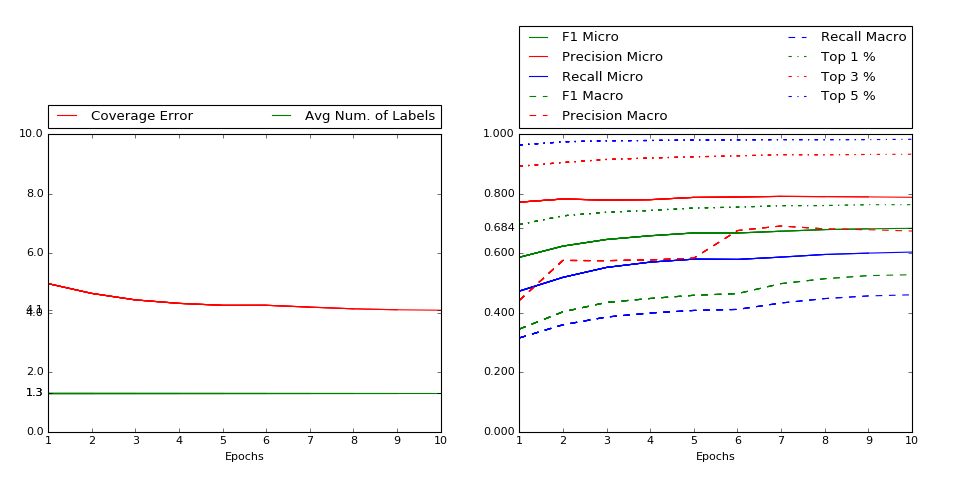

CPU times: user 28.5 s, sys: 13.1 s, total: 41.7 s


2017-01-01 14:30:09,389 : INFO : Getting Validation Embeddings
2017-01-01 14:30:09,391 : INFO : ===== Loading validation vectors


Wall time: 1min 24s
** Training Metrics: Cov Err: 5.164, Avg Labels: 1.290, 
		 Top 1: 0.689, Top 3: 0.888, Top 5: 0.959, 
		 F1 Micro: 0.569, F1 Macro: 0.431, Total Pos: 37,329


2017-01-01 14:30:10,074 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.987, Avg Labels: 1.300, 
		 Top 1: 0.697, Top 3: 0.893, Top 5: 0.964, 
		 F1 Micro: 0.587, F1 Macro: 0.346, Total Pos: 9,866
CPU times: user 28.3 s, sys: 13.2 s, total: 41.5 s
Wall time: 1min 24s


2017-01-01 14:31:38,368 : INFO : Getting Validation Embeddings
2017-01-01 14:31:38,370 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.839, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.902, Top 5: 0.972, 
		 F1 Micro: 0.606, F1 Macro: 0.346, Total Pos: 40,433


2017-01-01 14:31:39,041 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.658, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.906, Top 5: 0.975, 
		 F1 Micro: 0.625, F1 Macro: 0.404, Total Pos: 10,683
CPU times: user 27.7 s, sys: 13.1 s, total: 40.8 s
Wall time: 1min 23s


2017-01-01 14:33:06,908 : INFO : Getting Validation Embeddings
2017-01-01 14:33:06,910 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.622, Avg Labels: 1.290, 
		 Top 1: 0.733, Top 3: 0.911, Top 5: 0.976, 
		 F1 Micro: 0.630, F1 Macro: 0.404, Total Pos: 42,900


2017-01-01 14:33:07,692 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.439, Avg Labels: 1.300, 
		 Top 1: 0.738, Top 3: 0.916, Top 5: 0.979, 
		 F1 Micro: 0.647, F1 Macro: 0.435, Total Pos: 11,424
CPU times: user 29.1 s, sys: 13.2 s, total: 42.3 s
Wall time: 1min 25s


2017-01-01 14:34:38,041 : INFO : Getting Validation Embeddings
2017-01-01 14:34:38,042 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.502, Avg Labels: 1.290, 
		 Top 1: 0.742, Top 3: 0.916, Top 5: 0.978, 
		 F1 Micro: 0.643, F1 Macro: 0.435, Total Pos: 44,517


2017-01-01 14:34:38,790 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.323, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.921, Top 5: 0.980, 
		 F1 Micro: 0.659, F1 Macro: 0.449, Total Pos: 11,769
CPU times: user 27.5 s, sys: 12.7 s, total: 40.2 s
Wall time: 1min 21s


2017-01-01 14:36:05,219 : INFO : Getting Validation Embeddings
2017-01-01 14:36:05,221 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.437, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.920, Top 5: 0.979, 
		 F1 Micro: 0.650, F1 Macro: 0.449, Total Pos: 45,201


2017-01-01 14:36:05,976 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.257, Avg Labels: 1.300, 
		 Top 1: 0.752, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.669, F1 Macro: 0.459, Total Pos: 11,859
CPU times: user 28.4 s, sys: 13 s, total: 41.4 s
Wall time: 1min 24s

2017-01-01 14:37:34,835 : INFO : Getting Validation Embeddings
2017-01-01 14:37:34,836 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.424, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.653, F1 Macro: 0.459, Total Pos: 45,096


2017-01-01 14:37:35,559 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.258, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.669, F1 Macro: 0.465, Total Pos: 11,823
CPU times: user 29 s, sys: 13.1 s, total: 42.1 s
Wall time: 1min 25s


2017-01-01 14:39:05,738 : INFO : Getting Validation Embeddings
2017-01-01 14:39:05,739 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.401, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.656, F1 Macro: 0.465, Total Pos: 45,141


2017-01-01 14:39:06,559 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.196, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.932, Top 5: 0.982, 
		 F1 Micro: 0.675, F1 Macro: 0.499, Total Pos: 11,947
CPU times: user 28.9 s, sys: 13.9 s, total: 42.8 s
Wall time: 1min 27s


2017-01-01 14:40:38,727 : INFO : Getting Validation Embeddings
2017-01-01 14:40:38,729 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.356, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.661, F1 Macro: 0.499, Total Pos: 45,765


2017-01-01 14:40:39,523 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.139, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.680, F1 Macro: 0.515, Total Pos: 12,140
CPU times: user 27.7 s, sys: 13.1 s, total: 40.8 s
Wall time: 1min 22s


2017-01-01 14:42:06,852 : INFO : Getting Validation Embeddings
2017-01-01 14:42:06,853 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.310, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.665, F1 Macro: 0.515, Total Pos: 46,275


2017-01-01 14:42:07,520 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.107, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.933, Top 5: 0.982, 
		 F1 Micro: 0.683, F1 Macro: 0.526, Total Pos: 12,247
CPU times: user 28.8 s, sys: 13.1 s, total: 42 s
Wall time: 1min 25s


2017-01-01 14:43:38,381 : INFO : Getting Validation Embeddings
2017-01-01 14:43:38,384 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.251, Avg Labels: 1.290, 
		 Top 1: 0.760, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.670, F1 Macro: 0.526, Total Pos: 47,064


2017-01-01 14:43:39,047 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.092, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.684, F1 Macro: 0.528, Total Pos: 12,341
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_78 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200) 

<IPython.core.display.Javascript object>


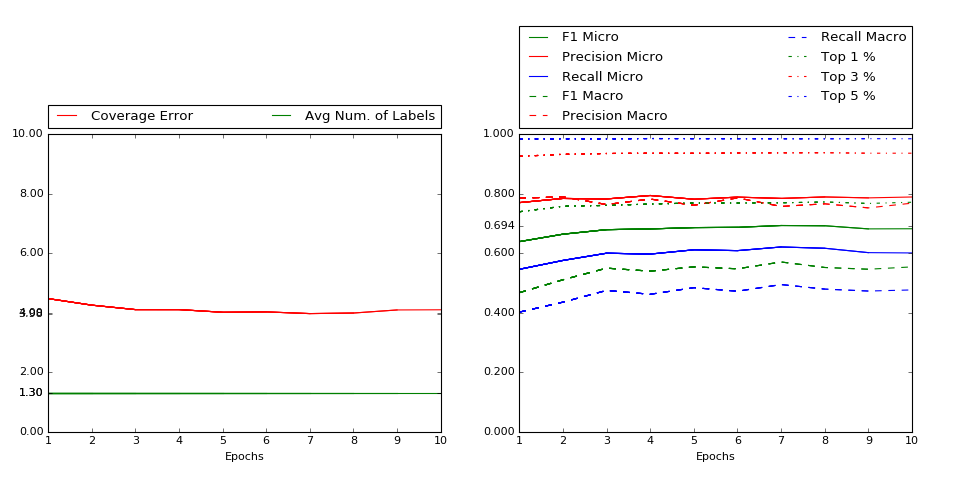

CPU times: user 32.2 s, sys: 25.2 s, total: 57.4 s


2017-01-01 14:45:42,929 : INFO : Getting Validation Embeddings
2017-01-01 14:45:42,932 : INFO : ===== Loading validation vectors


Wall time: 1min 56s
** Training Metrics: Cov Err: 4.762, Avg Labels: 1.290, 
		 Top 1: 0.726, Top 3: 0.920, Top 5: 0.981, 
		 F1 Micro: 0.610, F1 Macro: 0.528, Total Pos: 42,857


2017-01-01 14:45:43,534 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.483, Avg Labels: 1.300, 
		 Top 1: 0.740, Top 3: 0.926, Top 5: 0.984, 
		 F1 Micro: 0.640, F1 Macro: 0.468, Total Pos: 11,416
CPU times: user 31.3 s, sys: 26.1 s, total: 57.4 s
Wall time: 1min 58s


2017-01-01 14:47:45,886 : INFO : Getting Validation Embeddings
2017-01-01 14:47:45,887 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.624, Avg Labels: 1.290, 
		 Top 1: 0.745, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.630, F1 Macro: 0.468, Total Pos: 43,112


2017-01-01 14:47:46,480 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.263, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.665, F1 Macro: 0.512, Total Pos: 11,823
CPU times: user 28.6 s, sys: 24.7 s, total: 53.3 s
Wall time: 1min 49s


2017-01-01 14:49:40,857 : INFO : Getting Validation Embeddings
2017-01-01 14:49:40,859 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.476, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.645, F1 Macro: 0.512, Total Pos: 45,151


2017-01-01 14:49:41,452 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.114, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.680, F1 Macro: 0.551, Total Pos: 12,348
CPU times: user 28.5 s, sys: 24.9 s, total: 53.4 s


2017-01-01 14:51:36,707 : INFO : Getting Validation Embeddings
2017-01-01 14:51:36,709 : INFO : ===== Loading validation vectors


Wall time: 1min 50s
** Training Metrics: Cov Err: 4.448, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.651, F1 Macro: 0.551, Total Pos: 44,525


2017-01-01 14:51:37,339 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.113, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.682, F1 Macro: 0.540, Total Pos: 12,109
CPU times: user 30.3 s, sys: 25.3 s, total: 55.6 s
Wall time: 1min 54s


2017-01-01 14:53:36,159 : INFO : Getting Validation Embeddings
2017-01-01 14:53:36,161 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.333, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.659, F1 Macro: 0.540, Total Pos: 46,916


2017-01-01 14:53:36,784 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.024, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.687, F1 Macro: 0.555, Total Pos: 12,597
CPU times: user 30.2 s, sys: 24.7 s, total: 55 s


2017-01-01 14:55:35,086 : INFO : Getting Validation Embeddings
2017-01-01 14:55:35,088 : INFO : ===== Loading validation vectors


Wall time: 1min 53s
** Training Metrics: Cov Err: 4.340, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.661, F1 Macro: 0.555, Total Pos: 46,202


2017-01-01 14:55:35,724 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.036, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.688, F1 Macro: 0.548, Total Pos: 12,430
CPU times: user 29.6 s, sys: 25.1 s, total: 54.7 s
Wall time: 1min 53s


2017-01-01 14:57:33,722 : INFO : Getting Validation Embeddings
2017-01-01 14:57:33,724 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.324, Avg Labels: 1.290, 
		 Top 1: 0.760, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.662, F1 Macro: 0.548, Total Pos: 46,651


2017-01-01 14:57:34,433 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.979, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.694, F1 Macro: 0.571, Total Pos: 12,749
CPU times: user 30.7 s, sys: 26 s, total: 56.7 s
Wall time: 1min 56s


2017-01-01 14:59:34,764 : INFO : Getting Validation Embeddings
2017-01-01 14:59:34,766 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.296, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.934, Top 5: 0.983, 
		 F1 Micro: 0.663, F1 Macro: 0.571, Total Pos: 47,414


2017-01-01 14:59:35,375 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.998, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.693, F1 Macro: 0.553, Total Pos: 12,583
CPU times: user 29.4 s, sys: 25.1 s, total: 54.4 s
Wall time: 1min 52s


2017-01-01 15:01:32,498 : INFO : Getting Validation Embeddings
2017-01-01 15:01:32,500 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.415, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.651, F1 Macro: 0.553, Total Pos: 45,813


2017-01-01 15:01:33,274 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.101, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.683, F1 Macro: 0.547, Total Pos: 12,331
CPU times: user 29.8 s, sys: 24.6 s, total: 54.4 s
Wall time: 1min 53s


2017-01-01 15:03:31,383 : INFO : Getting Validation Embeddings
2017-01-01 15:03:31,385 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.428, Avg Labels: 1.290, 
		 Top 1: 0.753, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.650, F1 Macro: 0.547, Total Pos: 45,581


2017-01-01 15:03:32,129 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.107, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.683, F1 Macro: 0.555, Total Pos: 12,263
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_79 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)  

<IPython.core.display.Javascript object>


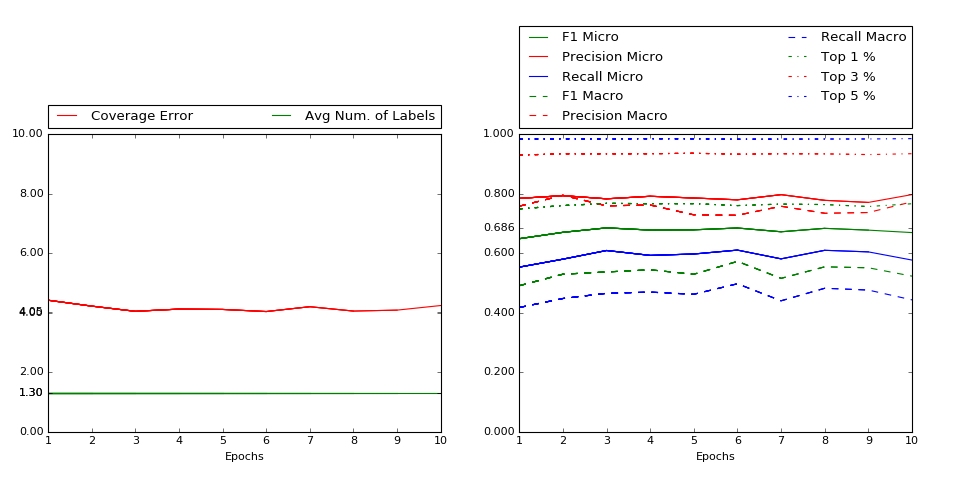

CPU times: user 31.5 s, sys: 25.4 s, total: 56.9 s
Wall time: 1min 56s


2017-01-01 15:05:38,365 : INFO : Getting Validation Embeddings
2017-01-01 15:05:38,367 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.782, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.614, F1 Macro: 0.555, Total Pos: 40,823


2017-01-01 15:05:39,092 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.428, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.650, F1 Macro: 0.492, Total Pos: 11,360
CPU times: user 28.7 s, sys: 25.4 s, total: 54.1 s
Wall time: 1min 51s


2017-01-01 15:07:38,511 : INFO : Getting Validation Embeddings
2017-01-01 15:07:38,513 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.634, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.632, F1 Macro: 0.492, Total Pos: 42,253


2017-01-01 15:07:39,102 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.231, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.671, F1 Macro: 0.530, Total Pos: 11,769
CPU times: user 29.9 s, sys: 25.5 s, total: 55.4 s
Wall time: 1min 54s


2017-01-01 15:09:39,995 : INFO : Getting Validation Embeddings
2017-01-01 15:09:39,997 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.323, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.661, F1 Macro: 0.530, Total Pos: 47,128


2017-01-01 15:09:40,688 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.056, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.686, F1 Macro: 0.538, Total Pos: 12,529
CPU times: user 28.5 s, sys: 24.3 s, total: 52.8 s
Wall time: 1min 50s


2017-01-01 15:11:37,927 : INFO : Getting Validation Embeddings
2017-01-01 15:11:37,929 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.433, Avg Labels: 1.290, 
		 Top 1: 0.760, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.652, F1 Macro: 0.538, Total Pos: 44,282


2017-01-01 15:11:38,532 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.130, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.679, F1 Macro: 0.545, Total Pos: 12,059
CPU times: user 29.4 s, sys: 25.5 s, total: 54.9 s


2017-01-01 15:13:40,424 : INFO : Getting Validation Embeddings
2017-01-01 15:13:40,426 : INFO : ===== Loading validation vectors


Wall time: 1min 54s
** Training Metrics: Cov Err: 4.335, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.661, F1 Macro: 0.545, Total Pos: 46,421


2017-01-01 15:13:41,110 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.119, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.679, F1 Macro: 0.530, Total Pos: 12,244
CPU times: user 29.8 s, sys: 25.1 s, total: 54.9 s
Wall time: 1min 53s


2017-01-01 15:15:43,145 : INFO : Getting Validation Embeddings
2017-01-01 15:15:43,148 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.308, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.661, F1 Macro: 0.530, Total Pos: 47,493


2017-01-01 15:15:43,754 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.048, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.685, F1 Macro: 0.573, Total Pos: 12,609
CPU times: user 29.4 s, sys: 25.1 s, total: 54.6 s
Wall time: 1min 52s


2017-01-01 15:17:43,488 : INFO : Getting Validation Embeddings
2017-01-01 15:17:43,490 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.490, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.645, F1 Macro: 0.573, Total Pos: 43,974


2017-01-01 15:17:44,119 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.210, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.673, F1 Macro: 0.516, Total Pos: 11,742
CPU times: user 30.2 s, sys: 25.1 s, total: 55.2 s
Wall time: 1min 53s


2017-01-01 15:19:46,182 : INFO : Getting Validation Embeddings
2017-01-01 15:19:46,184 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.326, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.660, F1 Macro: 0.516, Total Pos: 47,213


2017-01-01 15:19:46,835 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.063, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.684, F1 Macro: 0.555, Total Pos: 12,624
CPU times: user 30.5 s, sys: 25.4 s, total: 55.9 s
Wall time: 1min 54s


2017-01-01 15:21:49,869 : INFO : Getting Validation Embeddings
2017-01-01 15:21:49,871 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.382, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.654, F1 Macro: 0.555, Total Pos: 46,673


2017-01-01 15:21:50,487 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.095, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.678, F1 Macro: 0.552, Total Pos: 12,628
CPU times: user 29.5 s, sys: 24.3 s, total: 53.9 s
Wall time: 1min 51s


2017-01-01 15:23:50,148 : INFO : Getting Validation Embeddings
2017-01-01 15:23:50,150 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.552, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.638, F1 Macro: 0.552, Total Pos: 43,551


2017-01-01 15:23:50,727 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.250, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.670, F1 Macro: 0.524, Total Pos: 11,657
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_80 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)   

<IPython.core.display.Javascript object>


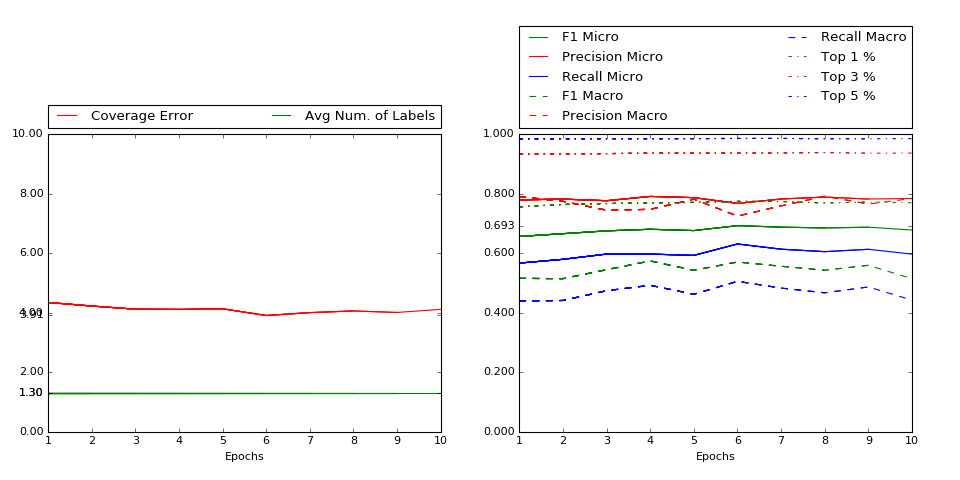

CPU times: user 31.8 s, sys: 25.1 s, total: 56.8 s
Wall time: 1min 56s

2017-01-01 15:25:53,492 : INFO : Getting Validation Embeddings
2017-01-01 15:25:53,493 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.849, Avg Labels: 1.290, 
		 Top 1: 0.745, Top 3: 0.925, Top 5: 0.979, 
		 F1 Micro: 0.608, F1 Macro: 0.524, Total Pos: 39,254


2017-01-01 15:25:54,581 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.354, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.657, F1 Macro: 0.516, Total Pos: 11,713
CPU times: user 29.4 s, sys: 25 s, total: 54.4 s
Wall time: 1min 53s


2017-01-01 15:27:52,608 : INFO : Getting Validation Embeddings
2017-01-01 15:27:52,610 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.755, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.613, F1 Macro: 0.516, Total Pos: 41,173


2017-01-01 15:27:53,370 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.233, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.666, F1 Macro: 0.515, Total Pos: 11,935
CPU times: user 29.2 s, sys: 24.1 s, total: 53.3 s


2017-01-01 15:29:48,189 : INFO : Getting Validation Embeddings
2017-01-01 15:29:48,194 : INFO : ===== Loading validation vectors


Wall time: 1min 50s
** Training Metrics: Cov Err: 4.627, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.627, F1 Macro: 0.515, Total Pos: 43,143


2017-01-01 15:29:48,959 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.127, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.676, F1 Macro: 0.545, Total Pos: 12,383
CPU times: user 29.9 s, sys: 24.2 s, total: 54.1 s
Wall time: 1min 52s


2017-01-01 15:31:45,895 : INFO : Getting Validation Embeddings
2017-01-01 15:31:45,897 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.750, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.620, F1 Macro: 0.545, Total Pos: 39,650


2017-01-01 15:31:46,551 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.119, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.681, F1 Macro: 0.575, Total Pos: 12,158
CPU times: user 29.2 s, sys: 23.8 s, total: 53 s


2017-01-01 15:33:39,871 : INFO : Getting Validation Embeddings
2017-01-01 15:33:39,872 : INFO : ===== Loading validation vectors


Wall time: 1min 48s
** Training Metrics: Cov Err: 4.771, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.614, F1 Macro: 0.575, Total Pos: 39,755


2017-01-01 15:33:40,483 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.141, Avg Labels: 1.300, 
		 Top 1: 0.771, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.677, F1 Macro: 0.543, Total Pos: 12,130
CPU times: user 29.2 s, sys: 24.3 s, total: 53.5 s
Wall time: 1min 50s


2017-01-01 15:35:34,468 : INFO : Getting Validation Embeddings
2017-01-01 15:35:34,470 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.569, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.634, F1 Macro: 0.543, Total Pos: 43,390


2017-01-01 15:35:35,088 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.915, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.693, F1 Macro: 0.571, Total Pos: 13,238
CPU times: user 30.8 s, sys: 25.3 s, total: 56.1 s
Wall time: 1min 54s


2017-01-01 15:37:34,232 : INFO : Getting Validation Embeddings
2017-01-01 15:37:34,235 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.642, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.929, Top 5: 0.981, 
		 F1 Micro: 0.627, F1 Macro: 0.571, Total Pos: 42,380


2017-01-01 15:37:34,964 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.012, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.688, F1 Macro: 0.557, Total Pos: 12,630
CPU times: user 29.4 s, sys: 24.5 s, total: 53.9 s
Wall time: 1min 52s


2017-01-01 15:39:30,940 : INFO : Getting Validation Embeddings
2017-01-01 15:39:30,943 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.685, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.928, Top 5: 0.980, 
		 F1 Micro: 0.625, F1 Macro: 0.557, Total Pos: 41,253


2017-01-01 15:39:31,717 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.067, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.939, Top 5: 0.985, 
		 F1 Micro: 0.686, F1 Macro: 0.544, Total Pos: 12,356
CPU times: user 28.8 s, sys: 23.2 s, total: 52.1 s

2017-01-01 15:41:30,185 : INFO : Getting Validation Embeddings
2017-01-01 15:41:30,188 : INFO : ===== Loading validation vectors



Wall time: 1min 54s
** Training Metrics: Cov Err: 4.655, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.625, F1 Macro: 0.544, Total Pos: 42,416


2017-01-01 15:41:30,780 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.017, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.688, F1 Macro: 0.560, Total Pos: 12,624
CPU times: user 28.6 s, sys: 23.4 s, total: 52 s


2017-01-01 15:43:26,467 : INFO : Getting Validation Embeddings
2017-01-01 15:43:26,471 : INFO : ===== Loading validation vectors


Wall time: 1min 51s
** Training Metrics: Cov Err: 4.667, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.926, Top 5: 0.979, 
		 F1 Micro: 0.623, F1 Macro: 0.560, Total Pos: 42,204


2017-01-01 15:43:27,210 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.122, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.679, F1 Macro: 0.515, Total Pos: 12,259
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_81 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)     

<IPython.core.display.Javascript object>


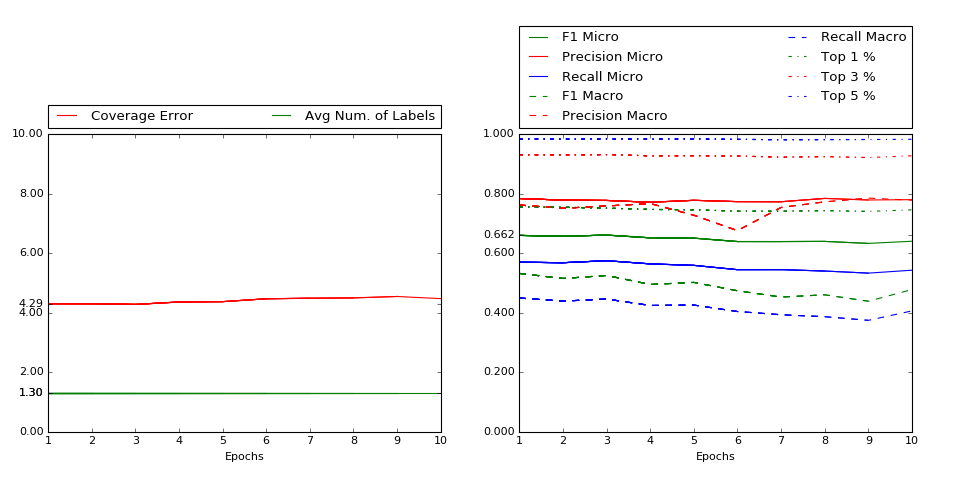

CPU times: user 25.7 s, sys: 10.9 s, total: 36.6 s
Wall time: 1min 17s

2017-01-01 15:44:53,539 : INFO : Getting Validation Embeddings
2017-01-01 15:44:53,540 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.732, Avg Labels: 1.290, 
		 Top 1: 0.740, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.619, F1 Macro: 0.515, Total Pos: 41,598


2017-01-01 15:44:54,597 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.311, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.661, F1 Macro: 0.533, Total Pos: 11,706
CPU times: user 24.3 s, sys: 10.4 s, total: 34.7 s
Wall time: 1min 14s


2017-01-01 15:46:12,925 : INFO : Getting Validation Embeddings
2017-01-01 15:46:12,927 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.621, Avg Labels: 1.290, 
		 Top 1: 0.739, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.628, F1 Macro: 0.533, Total Pos: 43,590


2017-01-01 15:46:13,678 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.311, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.658, F1 Macro: 0.516, Total Pos: 11,751
CPU times: user 25 s, sys: 10.7 s, total: 35.8 s
Wall time: 1min 17s


2017-01-01 15:47:35,973 : INFO : Getting Validation Embeddings
2017-01-01 15:47:35,975 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.642, Avg Labels: 1.290, 
		 Top 1: 0.738, Top 3: 0.927, Top 5: 0.983, 
		 F1 Micro: 0.628, F1 Macro: 0.516, Total Pos: 43,285


2017-01-01 15:47:36,746 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.287, Avg Labels: 1.300, 
		 Top 1: 0.752, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.662, F1 Macro: 0.526, Total Pos: 11,907
CPU times: user 24.6 s, sys: 11 s, total: 35.6 s
Wall time: 1min 15s


2017-01-01 15:48:56,172 : INFO : Getting Validation Embeddings
2017-01-01 15:48:56,175 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.688, Avg Labels: 1.290, 
		 Top 1: 0.733, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.622, F1 Macro: 0.526, Total Pos: 43,133


2017-01-01 15:48:56,765 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.369, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.928, Top 5: 0.984, 
		 F1 Micro: 0.652, F1 Macro: 0.496, Total Pos: 11,779
CPU times: user 23.8 s, sys: 10.4 s, total: 34.2 s
Wall time: 1min 11s


2017-01-01 15:50:12,520 : INFO : Getting Validation Embeddings
2017-01-01 15:50:12,522 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.664, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.624, F1 Macro: 0.496, Total Pos: 43,206


2017-01-01 15:50:13,141 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.380, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.928, Top 5: 0.985, 
		 F1 Micro: 0.651, F1 Macro: 0.503, Total Pos: 11,577
CPU times: user 24.1 s, sys: 10.9 s, total: 35 s
Wall time: 1min 11s


2017-01-01 15:51:29,275 : INFO : Getting Validation Embeddings
2017-01-01 15:51:29,277 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.717, Avg Labels: 1.290, 
		 Top 1: 0.726, Top 3: 0.919, Top 5: 0.979, 
		 F1 Micro: 0.613, F1 Macro: 0.503, Total Pos: 43,248


2017-01-01 15:51:29,907 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.476, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.927, Top 5: 0.983, 
		 F1 Micro: 0.640, F1 Macro: 0.475, Total Pos: 11,342
CPU times: user 24.8 s, sys: 10.8 s, total: 35.6 s
Wall time: 1min 13s


2017-01-01 15:52:48,200 : INFO : Getting Validation Embeddings
2017-01-01 15:52:48,201 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.808, Avg Labels: 1.290, 
		 Top 1: 0.728, Top 3: 0.918, Top 5: 0.977, 
		 F1 Micro: 0.608, F1 Macro: 0.475, Total Pos: 41,771


2017-01-01 15:52:49,050 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.496, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.924, Top 5: 0.982, 
		 F1 Micro: 0.640, F1 Macro: 0.453, Total Pos: 11,350
CPU times: user 23.8 s, sys: 10.3 s, total: 34.2 s
Wall time: 1min 9s


2017-01-01 15:54:03,169 : INFO : Getting Validation Embeddings
2017-01-01 15:54:03,172 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.851, Avg Labels: 1.290, 
		 Top 1: 0.722, Top 3: 0.915, Top 5: 0.978, 
		 F1 Micro: 0.604, F1 Macro: 0.453, Total Pos: 40,216


2017-01-01 15:54:03,872 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.506, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.640, F1 Macro: 0.461, Total Pos: 11,092
CPU times: user 23.9 s, sys: 9.95 s, total: 33.9 s


2017-01-01 15:55:17,285 : INFO : Getting Validation Embeddings
2017-01-01 15:55:17,287 : INFO : ===== Loading validation vectors


Wall time: 1min 8s
** Training Metrics: Cov Err: 4.876, Avg Labels: 1.290, 
		 Top 1: 0.723, Top 3: 0.916, Top 5: 0.979, 
		 F1 Micro: 0.600, F1 Macro: 0.461, Total Pos: 39,938


2017-01-01 15:55:17,992 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.554, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.922, Top 5: 0.983, 
		 F1 Micro: 0.634, F1 Macro: 0.439, Total Pos: 11,022
CPU times: user 26.3 s, sys: 11.2 s, total: 37.4 s
Wall time: 1min 15s


2017-01-01 15:56:37,675 : INFO : Getting Validation Embeddings
2017-01-01 15:56:37,677 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.815, Avg Labels: 1.290, 
		 Top 1: 0.729, Top 3: 0.920, Top 5: 0.980, 
		 F1 Micro: 0.608, F1 Macro: 0.439, Total Pos: 41,131


2017-01-01 15:56:38,402 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.482, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.928, Top 5: 0.984, 
		 F1 Micro: 0.641, F1 Macro: 0.479, Total Pos: 11,209
========== 1st Layer Size: 1000, 1st Layer Activation: linear, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_82 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 1000

<IPython.core.display.Javascript object>


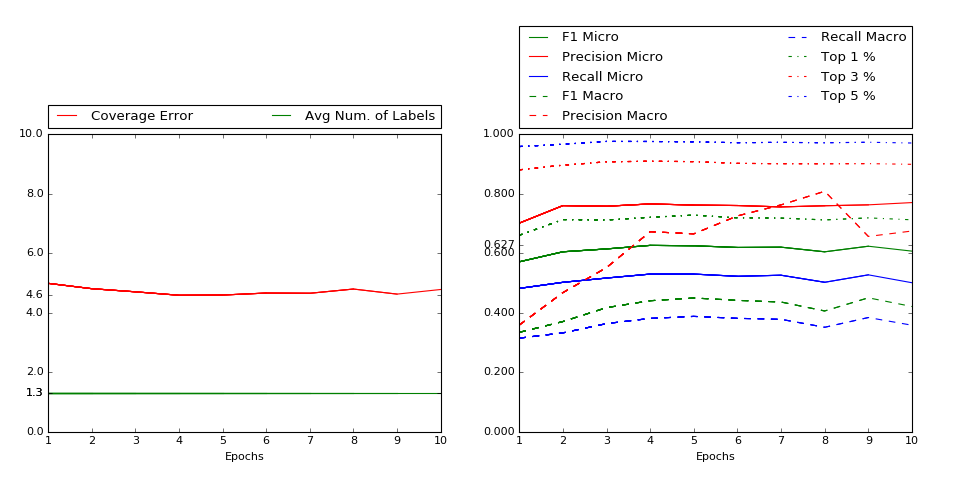

CPU times: user 40 s, sys: 41 s, total: 1min 20s
Wall time: 2min 45s


2017-01-01 15:59:34,555 : INFO : Getting Validation Embeddings
2017-01-01 15:59:34,557 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.040, Avg Labels: 1.290, 
		 Top 1: 0.654, Top 3: 0.877, Top 5: 0.957, 
		 F1 Micro: 0.567, F1 Macro: 0.479, Total Pos: 43,433


2017-01-01 15:59:35,485 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.996, Avg Labels: 1.300, 
		 Top 1: 0.661, Top 3: 0.881, Top 5: 0.959, 
		 F1 Micro: 0.572, F1 Macro: 0.335, Total Pos: 11,066
CPU times: user 38.9 s, sys: 41.1 s, total: 1min 19s
Wall time: 2min 43s


2017-01-01 16:02:27,247 : INFO : Getting Validation Embeddings
2017-01-01 16:02:27,249 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.865, Avg Labels: 1.290, 
		 Top 1: 0.703, Top 3: 0.895, Top 5: 0.966, 
		 F1 Micro: 0.598, F1 Macro: 0.335, Total Pos: 42,680


2017-01-01 16:02:27,948 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.816, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.897, Top 5: 0.967, 
		 F1 Micro: 0.606, F1 Macro: 0.371, Total Pos: 10,642
CPU times: user 38.1 s, sys: 41.2 s, total: 1min 19s


2017-01-01 16:05:17,283 : INFO : Getting Validation Embeddings
2017-01-01 16:05:17,285 : INFO : ===== Loading validation vectors


Wall time: 2min 41s
** Training Metrics: Cov Err: 4.753, Avg Labels: 1.290, 
		 Top 1: 0.709, Top 3: 0.909, Top 5: 0.973, 
		 F1 Micro: 0.611, F1 Macro: 0.371, Total Pos: 42,856


2017-01-01 16:05:18,366 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.711, Avg Labels: 1.300, 
		 Top 1: 0.712, Top 3: 0.908, Top 5: 0.976, 
		 F1 Micro: 0.615, F1 Macro: 0.418, Total Pos: 10,977
CPU times: user 37.9 s, sys: 41.5 s, total: 1min 19s
Wall time: 2min 42s

2017-01-01 16:08:09,243 : INFO : Getting Validation Embeddings
2017-01-01 16:08:09,246 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.681, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.907, Top 5: 0.975, 
		 F1 Micro: 0.620, F1 Macro: 0.418, Total Pos: 43,162


2017-01-01 16:08:09,912 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.595, Avg Labels: 1.300, 
		 Top 1: 0.721, Top 3: 0.910, Top 5: 0.976, 
		 F1 Micro: 0.627, F1 Macro: 0.441, Total Pos: 11,144
CPU times: user 35.5 s, sys: 39 s, total: 1min 14s
Wall time: 2min 34s


2017-01-01 16:10:53,777 : INFO : Getting Validation Embeddings
2017-01-01 16:10:53,781 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.830, Avg Labels: 1.290, 
		 Top 1: 0.719, Top 3: 0.903, Top 5: 0.973, 
		 F1 Micro: 0.603, F1 Macro: 0.441, Total Pos: 41,995


2017-01-01 16:10:54,560 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.602, Avg Labels: 1.300, 
		 Top 1: 0.729, Top 3: 0.909, Top 5: 0.975, 
		 F1 Micro: 0.626, F1 Macro: 0.450, Total Pos: 11,201
CPU times: user 37.6 s, sys: 39.8 s, total: 1min 17s
Wall time: 2min 48s


2017-01-01 16:13:49,889 : INFO : Getting Validation Embeddings
2017-01-01 16:13:49,891 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.874, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.898, Top 5: 0.970, 
		 F1 Micro: 0.602, F1 Macro: 0.450, Total Pos: 41,450


2017-01-01 16:13:50,578 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.669, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.903, Top 5: 0.972, 
		 F1 Micro: 0.620, F1 Macro: 0.442, Total Pos: 11,067
CPU times: user 37.6 s, sys: 39.9 s, total: 1min 17s
Wall time: 2min 48s


2017-01-01 16:16:46,985 : INFO : Getting Validation Embeddings
2017-01-01 16:16:46,987 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.883, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.897, Top 5: 0.971, 
		 F1 Micro: 0.600, F1 Macro: 0.442, Total Pos: 41,963


2017-01-01 16:16:47,767 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.662, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.902, Top 5: 0.973, 
		 F1 Micro: 0.621, F1 Macro: 0.437, Total Pos: 11,210
CPU times: user 34.5 s, sys: 38.7 s, total: 1min 13s
Wall time: 2min 38s


2017-01-01 16:19:34,100 : INFO : Getting Validation Embeddings
2017-01-01 16:19:34,104 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.014, Avg Labels: 1.290, 
		 Top 1: 0.696, Top 3: 0.897, Top 5: 0.967, 
		 F1 Micro: 0.583, F1 Macro: 0.437, Total Pos: 40,569


2017-01-01 16:19:34,753 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.804, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.901, Top 5: 0.972, 
		 F1 Micro: 0.606, F1 Macro: 0.407, Total Pos: 10,652
CPU times: user 37.1 s, sys: 40.4 s, total: 1min 17s

2017-01-01 16:22:26,374 : INFO : Getting Validation Embeddings
2017-01-01 16:22:26,376 : INFO : ===== Loading validation vectors



Wall time: 2min 43s
** Training Metrics: Cov Err: 4.838, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.894, Top 5: 0.966, 
		 F1 Micro: 0.602, F1 Macro: 0.407, Total Pos: 42,561


2017-01-01 16:22:27,173 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.633, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.902, Top 5: 0.974, 
		 F1 Micro: 0.624, F1 Macro: 0.451, Total Pos: 11,136
CPU times: user 38.1 s, sys: 41.3 s, total: 1min 19s
Wall time: 2min 42s


2017-01-01 16:25:17,773 : INFO : Getting Validation Embeddings
2017-01-01 16:25:17,775 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.005, Avg Labels: 1.290, 
		 Top 1: 0.695, Top 3: 0.889, Top 5: 0.968, 
		 F1 Micro: 0.585, F1 Macro: 0.451, Total Pos: 39,432


2017-01-01 16:25:18,506 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.789, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.899, Top 5: 0.971, 
		 F1 Micro: 0.608, F1 Macro: 0.422, Total Pos: 10,472
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_84 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)  

<IPython.core.display.Javascript object>


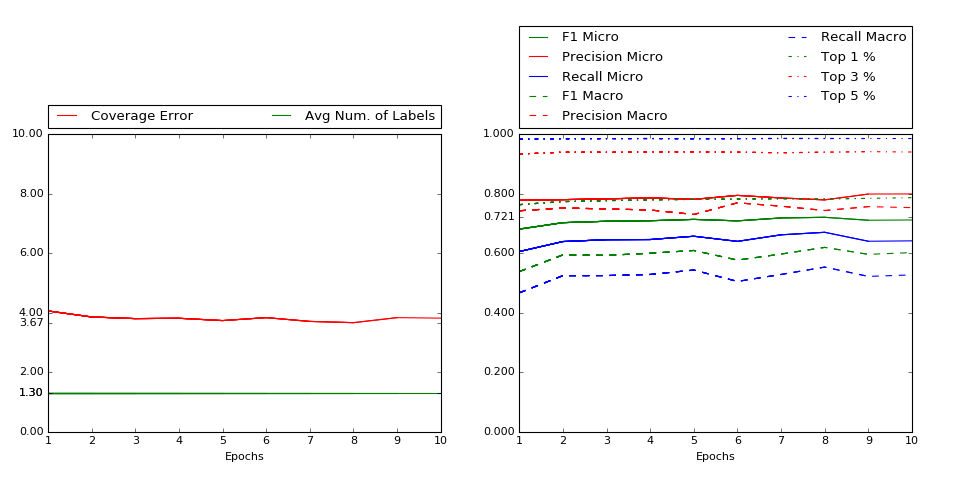

CPU times: user 30.3 s, sys: 18.7 s, total: 48.9 s
Wall time: 1min 39s


2017-01-01 16:27:06,425 : INFO : Getting Validation Embeddings
2017-01-01 16:27:06,426 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.280, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.663, F1 Macro: 0.422, Total Pos: 47,915


2017-01-01 16:27:07,171 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.068, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.682, F1 Macro: 0.539, Total Pos: 12,536
CPU times: user 27.5 s, sys: 18.2 s, total: 45.8 s
Wall time: 1min 33s


2017-01-01 16:28:47,737 : INFO : Getting Validation Embeddings
2017-01-01 16:28:47,739 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.071, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.687, F1 Macro: 0.539, Total Pos: 50,082


2017-01-01 16:28:55,766 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.866, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.940, Top 5: 0.985, 
		 F1 Micro: 0.703, F1 Macro: 0.595, Total Pos: 13,192
CPU times: user 17.3 s, sys: 4.05 s, total: 21.3 s
Wall time: 20.2 s


2017-01-01 16:29:19,749 : INFO : Getting Validation Embeddings
2017-01-01 16:29:19,750 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.981, Avg Labels: 1.290, 
		 Top 1: 0.772, Top 3: 0.937, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.595, Total Pos: 50,997


2017-01-01 16:29:20,473 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.810, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.708, F1 Macro: 0.594, Total Pos: 13,278
CPU times: user 16.7 s, sys: 4.2 s, total: 20.9 s
Wall time: 19.8 s


2017-01-01 16:29:44,432 : INFO : Getting Validation Embeddings
2017-01-01 16:29:44,433 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.989, Avg Labels: 1.290, 
		 Top 1: 0.776, Top 3: 0.938, Top 5: 0.984, 
		 F1 Micro: 0.698, F1 Macro: 0.594, Total Pos: 50,406


2017-01-01 16:29:45,106 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.822, Avg Labels: 1.300, 
		 Top 1: 0.780, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.710, F1 Macro: 0.601, Total Pos: 13,230
CPU times: user 16.9 s, sys: 3.82 s, total: 20.8 s
Wall time: 19.7 s


2017-01-01 16:30:08,494 : INFO : Getting Validation Embeddings
2017-01-01 16:30:08,496 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.922, Avg Labels: 1.290, 
		 Top 1: 0.778, Top 3: 0.939, Top 5: 0.985, 
		 F1 Micro: 0.703, F1 Macro: 0.601, Total Pos: 51,452


2017-01-01 16:30:09,160 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.744, Avg Labels: 1.300, 
		 Top 1: 0.782, Top 3: 0.941, Top 5: 0.985, 
		 F1 Micro: 0.714, F1 Macro: 0.610, Total Pos: 13,546
CPU times: user 16.8 s, sys: 3.98 s, total: 20.8 s
Wall time: 19.7 s

2017-01-01 16:30:32,572 : INFO : Getting Validation Embeddings
2017-01-01 16:30:32,573 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.015, Avg Labels: 1.290, 
		 Top 1: 0.779, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.698, F1 Macro: 0.610, Total Pos: 49,062


2017-01-01 16:30:33,316 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.843, Avg Labels: 1.300, 
		 Top 1: 0.783, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.709, F1 Macro: 0.578, Total Pos: 12,967
CPU times: user 17.1 s, sys: 4.31 s, total: 21.5 s
Wall time: 20.3 s


2017-01-01 16:30:57,938 : INFO : Getting Validation Embeddings
2017-01-01 16:30:57,939 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.862, Avg Labels: 1.290, 
		 Top 1: 0.782, Top 3: 0.938, Top 5: 0.984, 
		 F1 Micro: 0.710, F1 Macro: 0.578, Total Pos: 51,802


2017-01-01 16:30:58,711 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.716, Avg Labels: 1.300, 
		 Top 1: 0.784, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.719, F1 Macro: 0.598, Total Pos: 13,561
CPU times: user 18.1 s, sys: 4.03 s, total: 22.1 s
Wall time: 20.9 s


2017-01-01 16:31:23,779 : INFO : Getting Validation Embeddings
2017-01-01 16:31:23,780 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.815, Avg Labels: 1.290, 
		 Top 1: 0.782, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.713, F1 Macro: 0.598, Total Pos: 52,890


2017-01-01 16:31:24,492 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.674, Avg Labels: 1.300, 
		 Top 1: 0.783, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.721, F1 Macro: 0.620, Total Pos: 13,848
CPU times: user 19.2 s, sys: 4.3 s, total: 23.5 s
Wall time: 22.2 s


2017-01-01 16:31:51,149 : INFO : Getting Validation Embeddings
2017-01-01 16:31:51,151 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.076, Avg Labels: 1.290, 
		 Top 1: 0.788, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.695, F1 Macro: 0.620, Total Pos: 47,710


2017-01-01 16:31:51,868 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.843, Avg Labels: 1.300, 
		 Top 1: 0.785, Top 3: 0.942, Top 5: 0.986, 
		 F1 Micro: 0.712, F1 Macro: 0.597, Total Pos: 12,903
CPU times: user 16.6 s, sys: 4.35 s, total: 20.9 s
Wall time: 19.8 s


2017-01-01 16:32:15,728 : INFO : Getting Validation Embeddings
2017-01-01 16:32:15,729 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.060, Avg Labels: 1.290, 
		 Top 1: 0.786, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.694, F1 Macro: 0.597, Total Pos: 47,998


2017-01-01 16:32:16,494 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.826, Avg Labels: 1.300, 
		 Top 1: 0.787, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.712, F1 Macro: 0.603, Total Pos: 12,923
========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1

<IPython.core.display.Javascript object>


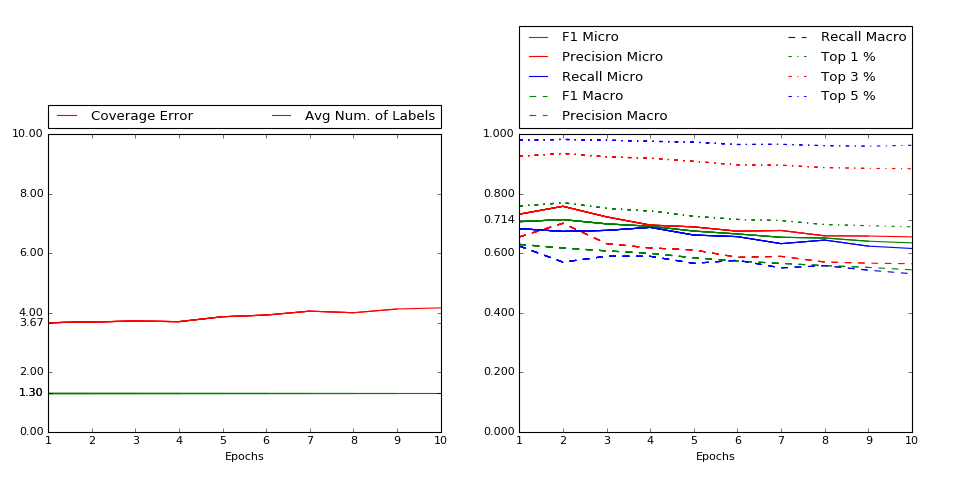

CPU times: user 28.7 s, sys: 18.6 s, total: 47.3 s
Wall time: 1min 37s


2017-01-01 16:34:01,654 : INFO : Getting Validation Embeddings
2017-01-01 16:34:01,656 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.642, Avg Labels: 1.290, 
		 Top 1: 0.786, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.725, F1 Macro: 0.603, Total Pos: 56,206


2017-01-01 16:34:02,361 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.671, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.707, F1 Macro: 0.631, Total Pos: 15,026
CPU times: user 28 s, sys: 18.2 s, total: 46.2 s
Wall time: 1min 35s


2017-01-01 16:35:42,528 : INFO : Getting Validation Embeddings
2017-01-01 16:35:42,530 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.500, Avg Labels: 1.290, 
		 Top 1: 0.821, Top 3: 0.950, Top 5: 0.986, 
		 F1 Micro: 0.754, F1 Macro: 0.631, Total Pos: 53,917


2017-01-01 16:35:43,217 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.700, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.936, Top 5: 0.983, 
		 F1 Micro: 0.714, F1 Macro: 0.618, Total Pos: 14,306
CPU times: user 26.5 s, sys: 18.1 s, total: 44.5 s
Wall time: 1min 32s


2017-01-01 16:37:19,648 : INFO : Getting Validation Embeddings
2017-01-01 16:37:19,651 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.257, Avg Labels: 1.290, 
		 Top 1: 0.834, Top 3: 0.954, Top 5: 0.989, 
		 F1 Micro: 0.777, F1 Macro: 0.618, Total Pos: 56,908


2017-01-01 16:37:20,479 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.725, Avg Labels: 1.300, 
		 Top 1: 0.752, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.699, F1 Macro: 0.609, Total Pos: 15,084
CPU times: user 27.2 s, sys: 18.2 s, total: 45.4 s
Wall time: 1min 34s


2017-01-01 16:38:59,256 : INFO : Getting Validation Embeddings
2017-01-01 16:38:59,257 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.974, Avg Labels: 1.290, 
		 Top 1: 0.846, Top 3: 0.957, Top 5: 0.990, 
		 F1 Micro: 0.798, F1 Macro: 0.609, Total Pos: 61,267


2017-01-01 16:39:00,006 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.709, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.920, Top 5: 0.977, 
		 F1 Micro: 0.691, F1 Macro: 0.600, Total Pos: 15,916
CPU times: user 26.8 s, sys: 18.2 s, total: 45 s
Wall time: 1min 34s


2017-01-01 16:40:38,750 : INFO : Getting Validation Embeddings
2017-01-01 16:40:38,752 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.001, Avg Labels: 1.290, 
		 Top 1: 0.854, Top 3: 0.958, Top 5: 0.990, 
		 F1 Micro: 0.803, F1 Macro: 0.600, Total Pos: 59,035


2017-01-01 16:40:39,477 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.873, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.909, Top 5: 0.974, 
		 F1 Micro: 0.675, F1 Macro: 0.585, Total Pos: 15,456
CPU times: user 27.4 s, sys: 18.5 s, total: 45.9 s
Wall time: 1min 35s


2017-01-01 16:42:18,720 : INFO : Getting Validation Embeddings
2017-01-01 16:42:18,721 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.912, Avg Labels: 1.290, 
		 Top 1: 0.864, Top 3: 0.961, Top 5: 0.990, 
		 F1 Micro: 0.815, F1 Macro: 0.585, Total Pos: 59,317


2017-01-01 16:42:19,401 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.929, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.898, Top 5: 0.966, 
		 F1 Micro: 0.666, F1 Macro: 0.574, Total Pos: 15,659
CPU times: user 26.4 s, sys: 18 s, total: 44.4 s
Wall time: 1min 32s


2017-01-01 16:43:56,306 : INFO : Getting Validation Embeddings
2017-01-01 16:43:56,307 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.981, Avg Labels: 1.290, 
		 Top 1: 0.870, Top 3: 0.962, Top 5: 0.991, 
		 F1 Micro: 0.816, F1 Macro: 0.574, Total Pos: 56,708


2017-01-01 16:43:56,957 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.061, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.896, Top 5: 0.967, 
		 F1 Micro: 0.654, F1 Macro: 0.567, Total Pos: 15,045
CPU times: user 27.5 s, sys: 17.9 s, total: 45.3 s


2017-01-01 16:45:35,593 : INFO : Getting Validation Embeddings
2017-01-01 16:45:35,594 : INFO : ===== Loading validation vectors


Wall time: 1min 34s
** Training Metrics: Cov Err: 2.811, Avg Labels: 1.290, 
		 Top 1: 0.874, Top 3: 0.962, Top 5: 0.991, 
		 F1 Micro: 0.825, F1 Macro: 0.567, Total Pos: 59,932


2017-01-01 16:45:36,230 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.008, Avg Labels: 1.300, 
		 Top 1: 0.697, Top 3: 0.888, Top 5: 0.962, 
		 F1 Micro: 0.652, F1 Macro: 0.559, Total Pos: 15,748
CPU times: user 28 s, sys: 18.6 s, total: 46.5 s


2017-01-01 16:47:17,856 : INFO : Getting Validation Embeddings
2017-01-01 16:47:17,858 : INFO : ===== Loading validation vectors


Wall time: 1min 37s
** Training Metrics: Cov Err: 2.838, Avg Labels: 1.290, 
		 Top 1: 0.879, Top 3: 0.964, Top 5: 0.992, 
		 F1 Micro: 0.829, F1 Macro: 0.559, Total Pos: 58,534


2017-01-01 16:47:18,568 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.132, Avg Labels: 1.300, 
		 Top 1: 0.693, Top 3: 0.886, Top 5: 0.960, 
		 F1 Micro: 0.641, F1 Macro: 0.553, Total Pos: 15,266
CPU times: user 27 s, sys: 18.5 s, total: 45.5 s
Wall time: 1min 34s


2017-01-01 16:48:57,659 : INFO : Getting Validation Embeddings
2017-01-01 16:48:57,661 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.780, Avg Labels: 1.290, 
		 Top 1: 0.882, Top 3: 0.965, Top 5: 0.992, 
		 F1 Micro: 0.835, F1 Macro: 0.553, Total Pos: 58,503


2017-01-01 16:48:58,498 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.171, Avg Labels: 1.300, 
		 Top 1: 0.690, Top 3: 0.885, Top 5: 0.963, 
		 F1 Micro: 0.636, F1 Macro: 0.545, Total Pos: 15,140
========== 1st Layer Size: 500, 1st Layer Activation: linear, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_85 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 500

<IPython.core.display.Javascript object>


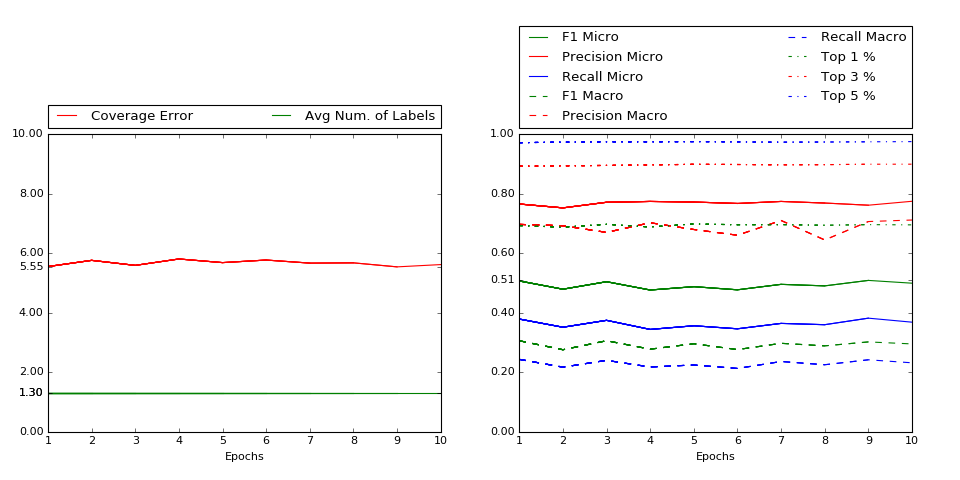

CPU times: user 22.3 s, sys: 9.42 s, total: 31.8 s
Wall time: 1min 5s


2017-01-01 16:50:11,372 : INFO : Getting Validation Embeddings
2017-01-01 16:50:11,377 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.965, Avg Labels: 1.290, 
		 Top 1: 0.680, Top 3: 0.884, Top 5: 0.966, 
		 F1 Micro: 0.458, F1 Macro: 0.545, Total Pos: 26,238


2017-01-01 16:50:12,131 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.560, Avg Labels: 1.300, 
		 Top 1: 0.694, Top 3: 0.893, Top 5: 0.972, 
		 F1 Micro: 0.508, F1 Macro: 0.307, Total Pos: 7,974
CPU times: user 21.9 s, sys: 9.82 s, total: 31.7 s
Wall time: 1min 5s


2017-01-01 16:51:21,747 : INFO : Getting Validation Embeddings
2017-01-01 16:51:21,750 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.116, Avg Labels: 1.290, 
		 Top 1: 0.671, Top 3: 0.883, Top 5: 0.966, 
		 F1 Micro: 0.434, F1 Macro: 0.307, Total Pos: 24,855


2017-01-01 16:51:22,592 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.768, Avg Labels: 1.300, 
		 Top 1: 0.688, Top 3: 0.894, Top 5: 0.974, 
		 F1 Micro: 0.480, F1 Macro: 0.276, Total Pos: 7,525
CPU times: user 21.9 s, sys: 9.28 s, total: 31.2 s
Wall time: 1min 4s

2017-01-01 16:52:30,856 : INFO : Getting Validation Embeddings
2017-01-01 16:52:30,858 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.979, Avg Labels: 1.290, 
		 Top 1: 0.678, Top 3: 0.883, Top 5: 0.968, 
		 F1 Micro: 0.455, F1 Macro: 0.276, Total Pos: 26,020


2017-01-01 16:52:31,699 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.599, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.896, Top 5: 0.975, 
		 F1 Micro: 0.505, F1 Macro: 0.307, Total Pos: 7,824
CPU times: user 22.3 s, sys: 9.67 s, total: 32 s


2017-01-01 16:53:43,008 : INFO : Getting Validation Embeddings
2017-01-01 16:53:43,010 : INFO : ===== Loading validation vectors


Wall time: 1min 6s
** Training Metrics: Cov Err: 6.181, Avg Labels: 1.290, 
		 Top 1: 0.668, Top 3: 0.883, Top 5: 0.967, 
		 F1 Micro: 0.428, F1 Macro: 0.307, Total Pos: 23,875


2017-01-01 16:53:43,770 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.814, Avg Labels: 1.300, 
		 Top 1: 0.689, Top 3: 0.898, Top 5: 0.975, 
		 F1 Micro: 0.477, F1 Macro: 0.278, Total Pos: 7,161
CPU times: user 21.3 s, sys: 9.46 s, total: 30.7 s
Wall time: 1min 2s

2017-01-01 16:54:50,966 : INFO : Getting Validation Embeddings
2017-01-01 16:54:50,968 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 6.034, Avg Labels: 1.290, 
		 Top 1: 0.676, Top 3: 0.885, Top 5: 0.968, 
		 F1 Micro: 0.445, F1 Macro: 0.278, Total Pos: 25,373


2017-01-01 16:54:51,617 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.692, Avg Labels: 1.300, 
		 Top 1: 0.699, Top 3: 0.899, Top 5: 0.976, 
		 F1 Micro: 0.488, F1 Macro: 0.297, Total Pos: 7,436
CPU times: user 22.2 s, sys: 9.38 s, total: 31.6 s
Wall time: 1min 4s


2017-01-01 16:56:00,360 : INFO : Getting Validation Embeddings
2017-01-01 16:56:00,362 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.092, Avg Labels: 1.290, 
		 Top 1: 0.676, Top 3: 0.888, Top 5: 0.968, 
		 F1 Micro: 0.435, F1 Macro: 0.297, Total Pos: 24,684


2017-01-01 16:56:01,101 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.778, Avg Labels: 1.300, 
		 Top 1: 0.696, Top 3: 0.899, Top 5: 0.975, 
		 F1 Micro: 0.478, F1 Macro: 0.277, Total Pos: 7,269
CPU times: user 21.8 s, sys: 9.76 s, total: 31.5 s
Wall time: 1min 4s


2017-01-01 16:57:10,028 : INFO : Getting Validation Embeddings
2017-01-01 16:57:10,029 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.989, Avg Labels: 1.290, 
		 Top 1: 0.680, Top 3: 0.885, Top 5: 0.965, 
		 F1 Micro: 0.457, F1 Macro: 0.277, Total Pos: 26,155


2017-01-01 16:57:10,803 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.675, Avg Labels: 1.300, 
		 Top 1: 0.697, Top 3: 0.898, Top 5: 0.974, 
		 F1 Micro: 0.496, F1 Macro: 0.298, Total Pos: 7,582
CPU times: user 20.4 s, sys: 9.49 s, total: 29.9 s


2017-01-01 16:58:15,886 : INFO : Getting Validation Embeddings
2017-01-01 16:58:15,888 : INFO : ===== Loading validation vectors


Wall time: 1min 1s
** Training Metrics: Cov Err: 6.034, Avg Labels: 1.290, 
		 Top 1: 0.676, Top 3: 0.883, Top 5: 0.966, 
		 F1 Micro: 0.448, F1 Macro: 0.298, Total Pos: 25,543


2017-01-01 16:58:16,647 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.684, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.898, Top 5: 0.974, 
		 F1 Micro: 0.491, F1 Macro: 0.289, Total Pos: 7,544
CPU times: user 22.3 s, sys: 9.64 s, total: 32 s


2017-01-01 16:59:25,786 : INFO : Getting Validation Embeddings
2017-01-01 16:59:25,788 : INFO : ===== Loading validation vectors


Wall time: 1min 5s
** Training Metrics: Cov Err: 5.926, Avg Labels: 1.290, 
		 Top 1: 0.677, Top 3: 0.886, Top 5: 0.967, 
		 F1 Micro: 0.463, F1 Macro: 0.289, Total Pos: 27,062


2017-01-01 16:59:26,407 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.549, Avg Labels: 1.300, 
		 Top 1: 0.697, Top 3: 0.900, Top 5: 0.975, 
		 F1 Micro: 0.509, F1 Macro: 0.303, Total Pos: 8,079
CPU times: user 22.3 s, sys: 9.58 s, total: 31.9 s
Wall time: 1min 5s


2017-01-01 17:00:35,499 : INFO : Getting Validation Embeddings
2017-01-01 17:00:35,500 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.936, Avg Labels: 1.290, 
		 Top 1: 0.676, Top 3: 0.885, Top 5: 0.968, 
		 F1 Micro: 0.459, F1 Macro: 0.303, Total Pos: 26,198


2017-01-01 17:00:36,108 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.626, Avg Labels: 1.300, 
		 Top 1: 0.696, Top 3: 0.900, Top 5: 0.976, 
		 F1 Micro: 0.500, F1 Macro: 0.296, Total Pos: 7,662
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_86 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)    

<IPython.core.display.Javascript object>


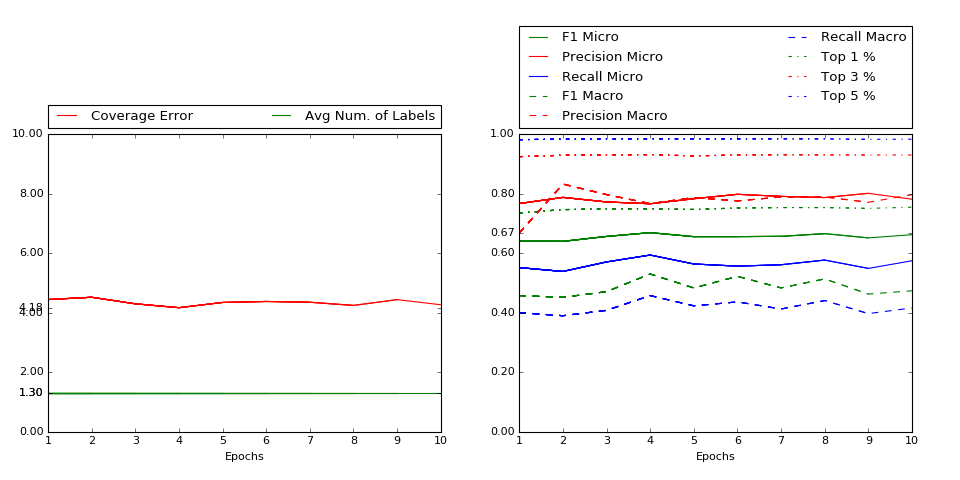

CPU times: user 29.6 s, sys: 18.2 s, total: 47.8 s
Wall time: 1min 37s


2017-01-01 17:02:20,189 : INFO : Getting Validation Embeddings
2017-01-01 17:02:20,191 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.636, Avg Labels: 1.290, 
		 Top 1: 0.722, Top 3: 0.920, Top 5: 0.979, 
		 F1 Micro: 0.624, F1 Macro: 0.296, Total Pos: 44,787


2017-01-01 17:02:21,066 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.450, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.642, F1 Macro: 0.458, Total Pos: 11,584
CPU times: user 28.2 s, sys: 17.8 s, total: 46 s
Wall time: 1min 36s


2017-01-01 17:04:02,171 : INFO : Getting Validation Embeddings
2017-01-01 17:04:02,172 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.717, Avg Labels: 1.290, 
		 Top 1: 0.732, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.619, F1 Macro: 0.458, Total Pos: 42,792


2017-01-01 17:04:02,943 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.528, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.641, F1 Macro: 0.453, Total Pos: 11,014
CPU times: user 28.9 s, sys: 18.3 s, total: 47.1 s
Wall time: 1min 37s


2017-01-01 17:05:44,839 : INFO : Getting Validation Embeddings
2017-01-01 17:05:44,841 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.494, Avg Labels: 1.290, 
		 Top 1: 0.735, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.636, F1 Macro: 0.453, Total Pos: 46,204


2017-01-01 17:05:45,449 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.307, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.657, F1 Macro: 0.472, Total Pos: 11,900
CPU times: user 28.5 s, sys: 18 s, total: 46.5 s
Wall time: 1min 36s


2017-01-01 17:07:26,912 : INFO : Getting Validation Embeddings
2017-01-01 17:07:26,914 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.446, Avg Labels: 1.290, 
		 Top 1: 0.733, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.645, F1 Macro: 0.472, Total Pos: 46,454


2017-01-01 17:07:27,684 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.177, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.670, F1 Macro: 0.531, Total Pos: 12,479
CPU times: user 28 s, sys: 17.6 s, total: 45.6 s
Wall time: 1min 34s


2017-01-01 17:09:05,872 : INFO : Getting Validation Embeddings
2017-01-01 17:09:05,875 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.594, Avg Labels: 1.290, 
		 Top 1: 0.732, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.629, F1 Macro: 0.531, Total Pos: 44,363


2017-01-01 17:09:06,488 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.353, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.928, Top 5: 0.985, 
		 F1 Micro: 0.656, F1 Macro: 0.484, Total Pos: 11,594
CPU times: user 27.8 s, sys: 17.3 s, total: 45.1 s
Wall time: 1min 35s


2017-01-01 17:10:46,005 : INFO : Getting Validation Embeddings
2017-01-01 17:10:46,007 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.756, Avg Labels: 1.290, 
		 Top 1: 0.740, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.618, F1 Macro: 0.484, Total Pos: 40,783


2017-01-01 17:10:46,727 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.386, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.657, F1 Macro: 0.523, Total Pos: 11,232
CPU times: user 28.8 s, sys: 17.9 s, total: 46.7 s
Wall time: 1min 37s


2017-01-01 17:12:28,785 : INFO : Getting Validation Embeddings
2017-01-01 17:12:28,787 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.606, Avg Labels: 1.290, 
		 Top 1: 0.735, Top 3: 0.924, Top 5: 0.981, 
		 F1 Micro: 0.629, F1 Macro: 0.523, Total Pos: 43,959


2017-01-01 17:12:29,401 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.360, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.657, F1 Macro: 0.484, Total Pos: 11,426
CPU times: user 28.5 s, sys: 17.3 s, total: 45.8 s
Wall time: 1min 34s


2017-01-01 17:14:07,826 : INFO : Getting Validation Embeddings
2017-01-01 17:14:07,827 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.584, Avg Labels: 1.290, 
		 Top 1: 0.741, Top 3: 0.924, Top 5: 0.979, 
		 F1 Micro: 0.633, F1 Macro: 0.484, Total Pos: 43,484


2017-01-01 17:14:08,482 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.253, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.667, F1 Macro: 0.514, Total Pos: 11,803
CPU times: user 28 s, sys: 17.5 s, total: 45.5 s
Wall time: 1min 34s


2017-01-01 17:15:48,168 : INFO : Getting Validation Embeddings
2017-01-01 17:15:48,169 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.778, Avg Labels: 1.290, 
		 Top 1: 0.732, Top 3: 0.920, Top 5: 0.978, 
		 F1 Micro: 0.615, F1 Macro: 0.514, Total Pos: 40,735


2017-01-01 17:15:48,942 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.448, Avg Labels: 1.300, 
		 Top 1: 0.751, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.652, F1 Macro: 0.463, Total Pos: 11,033
CPU times: user 28.3 s, sys: 17.8 s, total: 46.1 s
Wall time: 1min 36s


2017-01-01 17:17:29,879 : INFO : Getting Validation Embeddings
2017-01-01 17:17:29,880 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.570, Avg Labels: 1.290, 
		 Top 1: 0.735, Top 3: 0.920, Top 5: 0.978, 
		 F1 Micro: 0.630, F1 Macro: 0.463, Total Pos: 44,961


2017-01-01 17:17:30,604 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.276, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.663, F1 Macro: 0.474, Total Pos: 11,840
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_88 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)   

<IPython.core.display.Javascript object>


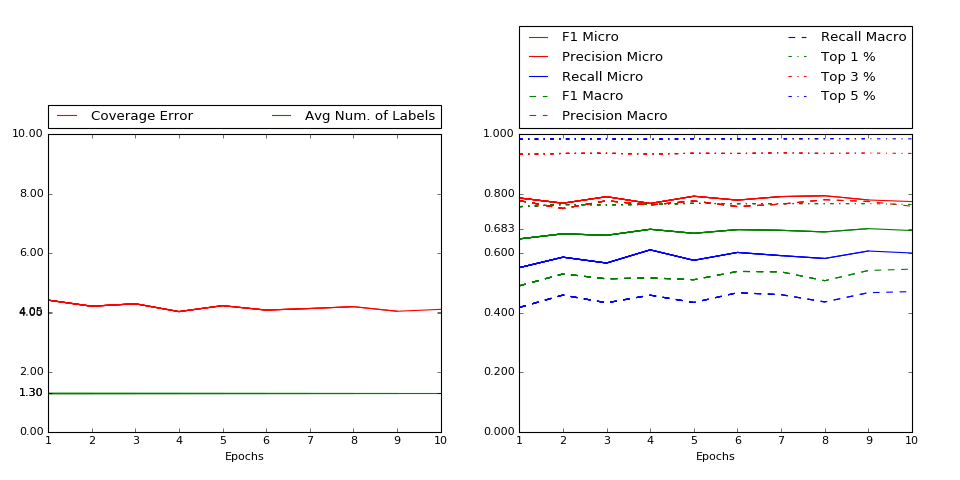

CPU times: user 23.2 s, sys: 2.82 s, total: 26.1 s


2017-01-01 17:18:04,188 : INFO : Getting Validation Embeddings
2017-01-01 17:18:04,190 : INFO : ===== Loading validation vectors


Wall time: 26.6 s
** Training Metrics: Cov Err: 4.762, Avg Labels: 1.290, 
		 Top 1: 0.748, Top 3: 0.927, Top 5: 0.982, 
		 F1 Micro: 0.617, F1 Macro: 0.474, Total Pos: 40,377


2017-01-01 17:18:04,898 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.432, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.649, F1 Macro: 0.491, Total Pos: 11,302
CPU times: user 16.1 s, sys: 2.58 s, total: 18.7 s

2017-01-01 17:18:25,800 : INFO : Getting Validation Embeddings
2017-01-01 17:18:25,802 : INFO : ===== Loading validation vectors



Wall time: 17.7 s
** Training Metrics: Cov Err: 4.669, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.622, F1 Macro: 0.491, Total Pos: 43,018


2017-01-01 17:18:26,511 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.227, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.666, F1 Macro: 0.531, Total Pos: 12,299
CPU times: user 18.2 s, sys: 2.22 s, total: 20.5 s
Wall time: 19.3 s


2017-01-01 17:18:51,017 : INFO : Getting Validation Embeddings
2017-01-01 17:18:51,020 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.830, Avg Labels: 1.290, 
		 Top 1: 0.748, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.609, F1 Macro: 0.531, Total Pos: 38,988


2017-01-01 17:18:51,796 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.309, Avg Labels: 1.300, 
		 Top 1: 0.763, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.661, F1 Macro: 0.515, Total Pos: 11,558
CPU times: user 16.6 s, sys: 1.99 s, total: 18.6 s
Wall time: 17.6 s


2017-01-01 17:19:13,585 : INFO : Getting Validation Embeddings
2017-01-01 17:19:13,586 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.564, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.927, Top 5: 0.979, 
		 F1 Micro: 0.631, F1 Macro: 0.515, Total Pos: 44,636


2017-01-01 17:19:14,346 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.046, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.681, F1 Macro: 0.518, Total Pos: 12,829
CPU times: user 15 s, sys: 2.28 s, total: 17.3 s
Wall time: 16.4 s


2017-01-01 17:19:35,159 : INFO : Getting Validation Embeddings
2017-01-01 17:19:35,160 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.720, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.620, F1 Macro: 0.518, Total Pos: 40,795


2017-01-01 17:19:35,817 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.246, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.668, F1 Macro: 0.512, Total Pos: 11,721
CPU times: user 19.1 s, sys: 2.36 s, total: 21.5 s
Wall time: 20.2 s


2017-01-01 17:20:00,383 : INFO : Getting Validation Embeddings
2017-01-01 17:20:00,384 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.638, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.627, F1 Macro: 0.512, Total Pos: 42,542


2017-01-01 17:20:01,031 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.097, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.680, F1 Macro: 0.540, Total Pos: 12,464
CPU times: user 16.2 s, sys: 2.17 s, total: 18.3 s
Wall time: 17.3 s


2017-01-01 17:20:22,489 : INFO : Getting Validation Embeddings
2017-01-01 17:20:22,491 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.718, Avg Labels: 1.290, 
		 Top 1: 0.748, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.619, F1 Macro: 0.540, Total Pos: 41,163


2017-01-01 17:20:23,194 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.150, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.678, F1 Macro: 0.538, Total Pos: 12,059
CPU times: user 20.8 s, sys: 2.34 s, total: 23.1 s
Wall time: 21.7 s


2017-01-01 17:20:49,390 : INFO : Getting Validation Embeddings
2017-01-01 17:20:49,391 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.723, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.926, Top 5: 0.979, 
		 F1 Micro: 0.621, F1 Macro: 0.538, Total Pos: 40,906


2017-01-01 17:20:49,993 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.211, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.672, F1 Macro: 0.508, Total Pos: 11,823
CPU times: user 16 s, sys: 2.3 s, total: 18.3 s
Wall time: 17.3 s


2017-01-01 17:21:10,721 : INFO : Getting Validation Embeddings
2017-01-01 17:21:10,723 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.625, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.925, Top 5: 0.980, 
		 F1 Micro: 0.627, F1 Macro: 0.508, Total Pos: 42,600


2017-01-01 17:21:11,300 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.057, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.683, F1 Macro: 0.543, Total Pos: 12,556
CPU times: user 21.7 s, sys: 3 s, total: 24.7 s
Wall time: 23.2 s


2017-01-01 17:21:39,276 : INFO : Getting Validation Embeddings
2017-01-01 17:21:39,278 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.742, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.618, F1 Macro: 0.543, Total Pos: 41,503


2017-01-01 17:21:40,083 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.121, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.677, F1 Macro: 0.547, Total Pos: 12,502
========== 1st Layer Size: 1000, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          101000      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_89 (Dropout)             (None, 1000)

<IPython.core.display.Javascript object>


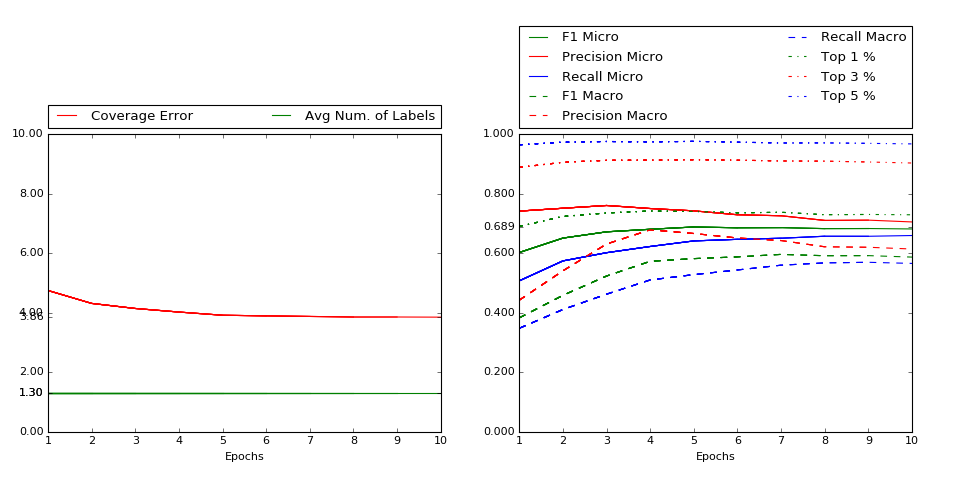

CPU times: user 37.2 s, sys: 34.4 s, total: 1min 11s


2017-01-01 17:24:14,985 : INFO : Getting Validation Embeddings
2017-01-01 17:24:14,987 : INFO : ===== Loading validation vectors


Wall time: 2min 27s
** Training Metrics: Cov Err: 4.581, Avg Labels: 1.290, 
		 Top 1: 0.709, Top 3: 0.902, Top 5: 0.968, 
		 F1 Micro: 0.625, F1 Macro: 0.547, Total Pos: 46,245


2017-01-01 17:24:15,679 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.755, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.889, Top 5: 0.965, 
		 F1 Micro: 0.603, F1 Macro: 0.384, Total Pos: 11,015
CPU times: user 36.2 s, sys: 35.3 s, total: 1min 11s
Wall time: 2min 28s


2017-01-01 17:26:47,931 : INFO : Getting Validation Embeddings
2017-01-01 17:26:47,933 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.166, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.921, Top 5: 0.977, 
		 F1 Micro: 0.673, F1 Macro: 0.384, Total Pos: 50,143


2017-01-01 17:26:48,757 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.321, Avg Labels: 1.300, 
		 Top 1: 0.724, Top 3: 0.906, Top 5: 0.974, 
		 F1 Micro: 0.652, F1 Macro: 0.459, Total Pos: 12,308
CPU times: user 34.7 s, sys: 34.3 s, total: 1min 9s
Wall time: 2min 23s


2017-01-01 17:29:17,258 : INFO : Getting Validation Embeddings
2017-01-01 17:29:17,260 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.895, Avg Labels: 1.290, 
		 Top 1: 0.776, Top 3: 0.931, Top 5: 0.981, 
		 F1 Micro: 0.708, F1 Macro: 0.459, Total Pos: 51,039


2017-01-01 17:29:17,880 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.151, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.913, Top 5: 0.976, 
		 F1 Micro: 0.673, F1 Macro: 0.524, Total Pos: 12,741
CPU times: user 35.9 s, sys: 33.6 s, total: 1min 9s
Wall time: 2min 23s


2017-01-01 17:31:45,642 : INFO : Getting Validation Embeddings
2017-01-01 17:31:45,643 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.623, Avg Labels: 1.290, 
		 Top 1: 0.795, Top 3: 0.939, Top 5: 0.984, 
		 F1 Micro: 0.733, F1 Macro: 0.524, Total Pos: 54,232


2017-01-01 17:31:46,605 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.031, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.914, Top 5: 0.975, 
		 F1 Micro: 0.681, F1 Macro: 0.574, Total Pos: 13,362
CPU times: user 35 s, sys: 34.3 s, total: 1min 9s

2017-01-01 17:34:15,005 : INFO : Getting Validation Embeddings
2017-01-01 17:34:15,008 : INFO : ===== Loading validation vectors



Wall time: 2min 23s
** Training Metrics: Cov Err: 3.425, Avg Labels: 1.290, 
		 Top 1: 0.808, Top 3: 0.945, Top 5: 0.986, 
		 F1 Micro: 0.752, F1 Macro: 0.574, Total Pos: 56,971


2017-01-01 17:34:15,748 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.924, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.915, Top 5: 0.977, 
		 F1 Micro: 0.689, F1 Macro: 0.583, Total Pos: 13,907
CPU times: user 36 s, sys: 34.7 s, total: 1min 10s
Wall time: 2min 25s


2017-01-01 17:36:46,286 : INFO : Getting Validation Embeddings
2017-01-01 17:36:46,290 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.306, Avg Labels: 1.290, 
		 Top 1: 0.821, Top 3: 0.949, Top 5: 0.988, 
		 F1 Micro: 0.765, F1 Macro: 0.583, Total Pos: 57,900


2017-01-01 17:36:46,954 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.902, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.913, Top 5: 0.974, 
		 F1 Micro: 0.686, F1 Macro: 0.588, Total Pos: 14,276
CPU times: user 35.8 s, sys: 34.6 s, total: 1min 10s
Wall time: 2min 24s


2017-01-01 17:39:16,570 : INFO : Getting Validation Embeddings
2017-01-01 17:39:16,572 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.242, Avg Labels: 1.290, 
		 Top 1: 0.827, Top 3: 0.951, Top 5: 0.988, 
		 F1 Micro: 0.773, F1 Macro: 0.588, Total Pos: 58,363


2017-01-01 17:39:17,184 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.883, Avg Labels: 1.300, 
		 Top 1: 0.738, Top 3: 0.911, Top 5: 0.971, 
		 F1 Micro: 0.687, F1 Macro: 0.597, Total Pos: 14,423
CPU times: user 35.7 s, sys: 33.7 s, total: 1min 9s
Wall time: 2min 24s


2017-01-01 17:41:45,461 : INFO : Getting Validation Embeddings
2017-01-01 17:41:45,463 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.141, Avg Labels: 1.290, 
		 Top 1: 0.831, Top 3: 0.953, Top 5: 0.988, 
		 F1 Micro: 0.779, F1 Macro: 0.597, Total Pos: 60,069


2017-01-01 17:41:46,101 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.864, Avg Labels: 1.300, 
		 Top 1: 0.730, Top 3: 0.910, Top 5: 0.971, 
		 F1 Micro: 0.683, F1 Macro: 0.592, Total Pos: 14,892
CPU times: user 36.9 s, sys: 34.8 s, total: 1min 11s
Wall time: 2min 28s


2017-01-01 17:44:19,318 : INFO : Getting Validation Embeddings
2017-01-01 17:44:19,320 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.130, Avg Labels: 1.290, 
		 Top 1: 0.834, Top 3: 0.952, Top 5: 0.988, 
		 F1 Micro: 0.782, F1 Macro: 0.592, Total Pos: 59,779


2017-01-01 17:44:20,057 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.864, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.907, Top 5: 0.970, 
		 F1 Micro: 0.684, F1 Macro: 0.593, Total Pos: 14,870
CPU times: user 35 s, sys: 34 s, total: 1min 8s
Wall time: 2min 22s


2017-01-01 17:46:47,794 : INFO : Getting Validation Embeddings
2017-01-01 17:46:47,797 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.119, Avg Labels: 1.290, 
		 Top 1: 0.835, Top 3: 0.952, Top 5: 0.988, 
		 F1 Micro: 0.784, F1 Macro: 0.593, Total Pos: 60,011


2017-01-01 17:46:48,485 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.859, Avg Labels: 1.300, 
		 Top 1: 0.730, Top 3: 0.904, Top 5: 0.968, 
		 F1 Micro: 0.682, F1 Macro: 0.588, Total Pos: 15,056
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 50, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_linear (Dense)     (None, 50)    

<IPython.core.display.Javascript object>


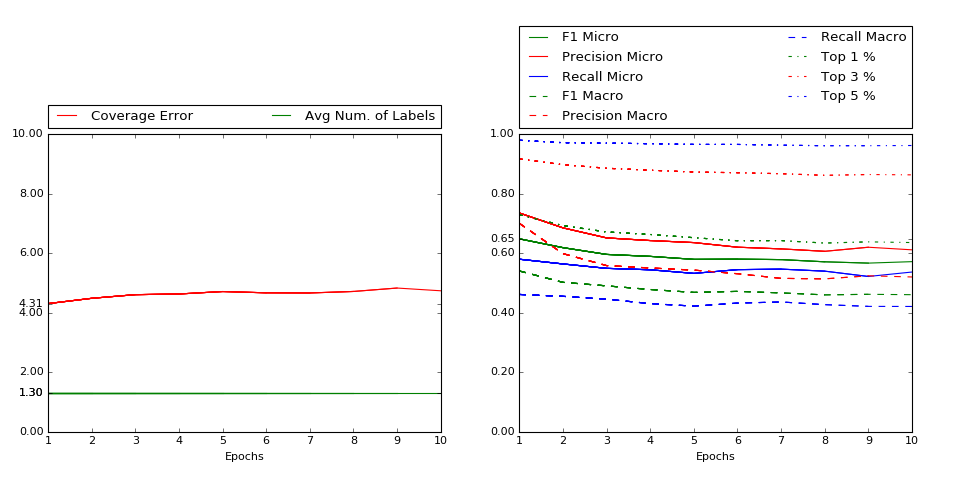

CPU times: user 25.4 s, sys: 10.6 s, total: 36 s
Wall time: 1min 12s


2017-01-01 17:48:07,731 : INFO : Getting Validation Embeddings
2017-01-01 17:48:07,732 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.081, Avg Labels: 1.290, 
		 Top 1: 0.862, Top 3: 0.971, Top 5: 0.995, 
		 F1 Micro: 0.801, F1 Macro: 0.588, Total Pos: 57,763


2017-01-01 17:48:08,344 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.314, Avg Labels: 1.300, 
		 Top 1: 0.730, Top 3: 0.918, Top 5: 0.980, 
		 F1 Micro: 0.649, F1 Macro: 0.541, Total Pos: 12,698
CPU times: user 24.1 s, sys: 9.98 s, total: 34 s
Wall time: 1min 8s


2017-01-01 17:49:21,105 : INFO : Getting Validation Embeddings
2017-01-01 17:49:21,107 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.714, Avg Labels: 1.290, 
		 Top 1: 0.903, Top 3: 0.983, Top 5: 0.997, 
		 F1 Micro: 0.845, F1 Macro: 0.541, Total Pos: 60,101


2017-01-01 17:49:21,864 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.492, Avg Labels: 1.300, 
		 Top 1: 0.694, Top 3: 0.898, Top 5: 0.972, 
		 F1 Micro: 0.620, F1 Macro: 0.503, Total Pos: 13,250
CPU times: user 22.8 s, sys: 9.86 s, total: 32.6 s
Wall time: 1min 6s


2017-01-01 17:50:33,238 : INFO : Getting Validation Embeddings
2017-01-01 17:50:33,240 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.434, Avg Labels: 1.290, 
		 Top 1: 0.933, Top 3: 0.988, Top 5: 0.999, 
		 F1 Micro: 0.878, F1 Macro: 0.503, Total Pos: 61,033


2017-01-01 17:50:34,043 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.615, Avg Labels: 1.300, 
		 Top 1: 0.672, Top 3: 0.886, Top 5: 0.971, 
		 F1 Micro: 0.597, F1 Macro: 0.491, Total Pos: 13,572
CPU times: user 23.1 s, sys: 9.96 s, total: 33 s
Wall time: 1min 7s


2017-01-01 17:51:45,308 : INFO : Getting Validation Embeddings
2017-01-01 17:51:45,309 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.256, Avg Labels: 1.290, 
		 Top 1: 0.947, Top 3: 0.991, Top 5: 0.999, 
		 F1 Micro: 0.896, F1 Macro: 0.491, Total Pos: 62,038


2017-01-01 17:51:45,948 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.637, Avg Labels: 1.300, 
		 Top 1: 0.664, Top 3: 0.880, Top 5: 0.969, 
		 F1 Micro: 0.590, F1 Macro: 0.479, Total Pos: 13,639
CPU times: user 22.5 s, sys: 9.69 s, total: 32.2 s


2017-01-01 17:52:54,711 : INFO : Getting Validation Embeddings
2017-01-01 17:52:54,713 : INFO : ===== Loading validation vectors


Wall time: 1min 5s
** Training Metrics: Cov Err: 2.175, Avg Labels: 1.290, 
		 Top 1: 0.957, Top 3: 0.993, Top 5: 0.999, 
		 F1 Micro: 0.908, F1 Macro: 0.479, Total Pos: 61,590


2017-01-01 17:52:55,473 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.720, Avg Labels: 1.300, 
		 Top 1: 0.653, Top 3: 0.874, Top 5: 0.966, 
		 F1 Micro: 0.580, F1 Macro: 0.469, Total Pos: 13,479
CPU times: user 23.6 s, sys: 10.1 s, total: 33.7 s
Wall time: 1min 9s


2017-01-01 17:54:08,833 : INFO : Getting Validation Embeddings
2017-01-01 17:54:08,835 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.078, Avg Labels: 1.290, 
		 Top 1: 0.959, Top 3: 0.995, Top 5: 0.999, 
		 F1 Micro: 0.910, F1 Macro: 0.469, Total Pos: 63,708


2017-01-01 17:54:09,569 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.677, Avg Labels: 1.300, 
		 Top 1: 0.643, Top 3: 0.871, Top 5: 0.966, 
		 F1 Micro: 0.581, F1 Macro: 0.473, Total Pos: 14,140
CPU times: user 24.2 s, sys: 10.2 s, total: 34.4 s


2017-01-01 17:55:23,640 : INFO : Getting Validation Embeddings
2017-01-01 17:55:23,642 : INFO : ===== Loading validation vectors


Wall time: 1min 9s
** Training Metrics: Cov Err: 2.032, Avg Labels: 1.290, 
		 Top 1: 0.965, Top 3: 0.996, Top 5: 1.000, 
		 F1 Micro: 0.918, F1 Macro: 0.473, Total Pos: 63,267


2017-01-01 17:55:24,324 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.672, Avg Labels: 1.300, 
		 Top 1: 0.643, Top 3: 0.868, Top 5: 0.964, 
		 F1 Micro: 0.579, F1 Macro: 0.467, Total Pos: 14,316
CPU times: user 23.3 s, sys: 10.1 s, total: 33.4 s
Wall time: 1min 8s


2017-01-01 17:56:37,449 : INFO : Getting Validation Embeddings
2017-01-01 17:56:37,452 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.901, Avg Labels: 1.290, 
		 Top 1: 0.974, Top 3: 0.996, Top 5: 1.000, 
		 F1 Micro: 0.931, F1 Macro: 0.467, Total Pos: 63,729


2017-01-01 17:56:38,192 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.723, Avg Labels: 1.300, 
		 Top 1: 0.635, Top 3: 0.862, Top 5: 0.962, 
		 F1 Micro: 0.572, F1 Macro: 0.461, Total Pos: 14,329
CPU times: user 23.7 s, sys: 10.3 s, total: 34 s
Wall time: 1min 8s

2017-01-01 17:57:51,869 : INFO : Getting Validation Embeddings
2017-01-01 17:57:51,870 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 1.973, Avg Labels: 1.290, 
		 Top 1: 0.978, Top 3: 0.997, Top 5: 1.000, 
		 F1 Micro: 0.934, F1 Macro: 0.461, Total Pos: 61,664


2017-01-01 17:57:52,600 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.837, Avg Labels: 1.300, 
		 Top 1: 0.639, Top 3: 0.865, Top 5: 0.962, 
		 F1 Micro: 0.568, F1 Macro: 0.463, Total Pos: 13,549
CPU times: user 24.1 s, sys: 10.8 s, total: 34.8 s


2017-01-01 17:59:08,423 : INFO : Getting Validation Embeddings
2017-01-01 17:59:08,426 : INFO : ===== Loading validation vectors


Wall time: 1min 11s
** Training Metrics: Cov Err: 1.811, Avg Labels: 1.290, 
		 Top 1: 0.982, Top 3: 0.998, Top 5: 1.000, 
		 F1 Micro: 0.944, F1 Macro: 0.463, Total Pos: 63,300


2017-01-01 17:59:09,180 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.745, Avg Labels: 1.300, 
		 Top 1: 0.637, Top 3: 0.864, Top 5: 0.963, 
		 F1 Micro: 0.572, F1 Macro: 0.461, Total Pos: 14,134
========== 1st Layer Size: 200, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_90 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200

<IPython.core.display.Javascript object>


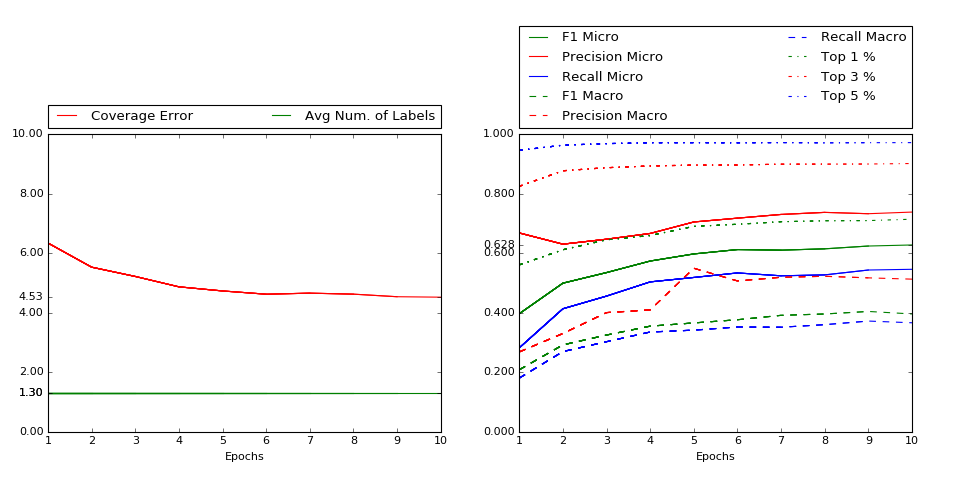

CPU times: user 30.7 s, sys: 19.6 s, total: 50.2 s
Wall time: 1min 42s


2017-01-01 18:01:01,820 : INFO : Getting Validation Embeddings
2017-01-01 18:01:01,821 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.386, Avg Labels: 1.290, 
		 Top 1: 0.557, Top 3: 0.819, Top 5: 0.945, 
		 F1 Micro: 0.393, F1 Macro: 0.461, Total Pos: 27,016


2017-01-01 18:01:02,475 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 6.350, Avg Labels: 1.300, 
		 Top 1: 0.562, Top 3: 0.826, Top 5: 0.946, 
		 F1 Micro: 0.397, F1 Macro: 0.209, Total Pos: 6,804
CPU times: user 28.7 s, sys: 19.1 s, total: 47.8 s
Wall time: 1min 38s


2017-01-01 18:02:49,013 : INFO : Getting Validation Embeddings
2017-01-01 18:02:49,015 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.662, Avg Labels: 1.290, 
		 Top 1: 0.604, Top 3: 0.870, Top 5: 0.959, 
		 F1 Micro: 0.489, F1 Macro: 0.209, Total Pos: 40,063


2017-01-01 18:02:49,594 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.539, Avg Labels: 1.300, 
		 Top 1: 0.612, Top 3: 0.878, Top 5: 0.964, 
		 F1 Micro: 0.500, F1 Macro: 0.293, Total Pos: 10,561
CPU times: user 29.3 s, sys: 19 s, total: 48.3 s


2017-01-01 18:04:36,646 : INFO : Getting Validation Embeddings
2017-01-01 18:04:36,647 : INFO : ===== Loading validation vectors


Wall time: 1min 39s
** Training Metrics: Cov Err: 5.499, Avg Labels: 1.290, 
		 Top 1: 0.640, Top 3: 0.885, Top 5: 0.963, 
		 F1 Micro: 0.510, F1 Macro: 0.293, Total Pos: 40,913


2017-01-01 18:04:37,258 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.227, Avg Labels: 1.300, 
		 Top 1: 0.646, Top 3: 0.888, Top 5: 0.969, 
		 F1 Micro: 0.536, F1 Macro: 0.326, Total Pos: 11,347
CPU times: user 27.9 s, sys: 18 s, total: 45.9 s
Wall time: 1min 34s

2017-01-01 18:06:19,996 : INFO : Getting Validation Embeddings
2017-01-01 18:06:19,996 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.164, Avg Labels: 1.290, 
		 Top 1: 0.658, Top 3: 0.892, Top 5: 0.968, 
		 F1 Micro: 0.550, F1 Macro: 0.326, Total Pos: 43,323


2017-01-01 18:06:20,686 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.878, Avg Labels: 1.300, 
		 Top 1: 0.660, Top 3: 0.894, Top 5: 0.972, 
		 F1 Micro: 0.574, F1 Macro: 0.356, Total Pos: 12,169
CPU times: user 28.4 s, sys: 19 s, total: 47.4 s
Wall time: 1min 37s


2017-01-01 18:08:07,388 : INFO : Getting Validation Embeddings
2017-01-01 18:08:07,390 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.918, Avg Labels: 1.290, 
		 Top 1: 0.686, Top 3: 0.894, Top 5: 0.968, 
		 F1 Micro: 0.584, F1 Macro: 0.356, Total Pos: 44,176


2017-01-01 18:08:08,018 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.740, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.897, Top 5: 0.972, 
		 F1 Micro: 0.598, F1 Macro: 0.366, Total Pos: 11,844
CPU times: user 29.2 s, sys: 19.4 s, total: 48.6 s
Wall time: 1min 39s


2017-01-01 18:09:56,535 : INFO : Getting Validation Embeddings
2017-01-01 18:09:56,537 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.805, Avg Labels: 1.290, 
		 Top 1: 0.694, Top 3: 0.896, Top 5: 0.968, 
		 F1 Micro: 0.597, F1 Macro: 0.366, Total Pos: 45,146


2017-01-01 18:09:57,568 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.631, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.897, Top 5: 0.972, 
		 F1 Micro: 0.613, F1 Macro: 0.377, Total Pos: 11,972
CPU times: user 28.3 s, sys: 18.6 s, total: 46.9 s

2017-01-01 18:11:42,536 : INFO : Getting Validation Embeddings
2017-01-01 18:11:42,539 : INFO : ===== Loading validation vectors



Wall time: 1min 36s
** Training Metrics: Cov Err: 4.853, Avg Labels: 1.290, 
		 Top 1: 0.699, Top 3: 0.898, Top 5: 0.970, 
		 F1 Micro: 0.592, F1 Macro: 0.377, Total Pos: 43,398


2017-01-01 18:11:43,126 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.665, Avg Labels: 1.300, 
		 Top 1: 0.707, Top 3: 0.900, Top 5: 0.972, 
		 F1 Micro: 0.611, F1 Macro: 0.392, Total Pos: 11,556
CPU times: user 29.1 s, sys: 19.2 s, total: 48.3 s
Wall time: 1min 38s


2017-01-01 18:13:29,077 : INFO : Getting Validation Embeddings
2017-01-01 18:13:29,080 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.853, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.898, Top 5: 0.970, 
		 F1 Micro: 0.593, F1 Macro: 0.392, Total Pos: 43,042


2017-01-01 18:13:29,780 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.632, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.900, Top 5: 0.972, 
		 F1 Micro: 0.616, F1 Macro: 0.397, Total Pos: 11,514
CPU times: user 29.6 s, sys: 19.7 s, total: 49.3 s
Wall time: 1min 41s


2017-01-01 18:15:18,957 : INFO : Getting Validation Embeddings
2017-01-01 18:15:18,959 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.717, Avg Labels: 1.290, 
		 Top 1: 0.699, Top 3: 0.899, Top 5: 0.970, 
		 F1 Micro: 0.605, F1 Macro: 0.397, Total Pos: 45,675


2017-01-01 18:15:19,740 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.546, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.900, Top 5: 0.972, 
		 F1 Micro: 0.625, F1 Macro: 0.405, Total Pos: 11,944
CPU times: user 26.9 s, sys: 18.4 s, total: 45.3 s
Wall time: 1min 32s


2017-01-01 18:17:00,788 : INFO : Getting Validation Embeddings
2017-01-01 18:17:00,791 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.698, Avg Labels: 1.290, 
		 Top 1: 0.708, Top 3: 0.901, Top 5: 0.970, 
		 F1 Micro: 0.610, F1 Macro: 0.405, Total Pos: 45,448


2017-01-01 18:17:01,536 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.530, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.902, Top 5: 0.972, 
		 F1 Micro: 0.628, F1 Macro: 0.397, Total Pos: 11,908
========== 1st Layer Size: 50, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 200)  

<IPython.core.display.Javascript object>


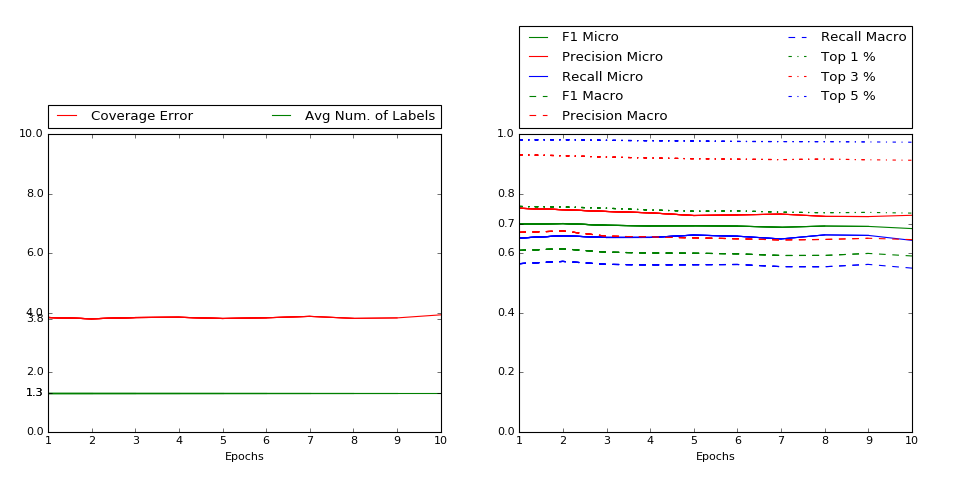

CPU times: user 21.7 s, sys: 3.67 s, total: 25.3 s
Wall time: 25.6 s


2017-01-01 18:17:32,477 : INFO : Getting Validation Embeddings
2017-01-01 18:17:32,479 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.695, Avg Labels: 1.290, 
		 Top 1: 0.784, Top 3: 0.940, Top 5: 0.985, 
		 F1 Micro: 0.722, F1 Macro: 0.397, Total Pos: 55,054


2017-01-01 18:17:33,219 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.848, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.932, Top 5: 0.981, 
		 F1 Micro: 0.698, F1 Macro: 0.610, Total Pos: 13,957
CPU times: user 17.2 s, sys: 2.95 s, total: 20.2 s


2017-01-01 18:17:56,657 : INFO : Getting Validation Embeddings
2017-01-01 18:17:56,659 : INFO : ===== Loading validation vectors


Wall time: 19.1 s
** Training Metrics: Cov Err: 3.525, Avg Labels: 1.290, 
		 Top 1: 0.795, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.738, F1 Macro: 0.610, Total Pos: 57,028


2017-01-01 18:17:57,407 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.805, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.700, F1 Macro: 0.616, Total Pos: 14,207
CPU times: user 17.9 s, sys: 3.18 s, total: 21.1 s
Wall time: 19.8 s


2017-01-01 18:18:20,366 : INFO : Getting Validation Embeddings
2017-01-01 18:18:20,368 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.506, Avg Labels: 1.290, 
		 Top 1: 0.802, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.742, F1 Macro: 0.616, Total Pos: 56,614


2017-01-01 18:18:20,944 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.846, Avg Labels: 1.300, 
		 Top 1: 0.752, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.695, F1 Macro: 0.604, Total Pos: 14,198
CPU times: user 17 s, sys: 3.17 s, total: 20.2 s
Wall time: 19.1 s


2017-01-01 18:18:43,456 : INFO : Getting Validation Embeddings
2017-01-01 18:18:43,457 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.467, Avg Labels: 1.290, 
		 Top 1: 0.804, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.746, F1 Macro: 0.604, Total Pos: 57,089


2017-01-01 18:18:44,038 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.855, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.921, Top 5: 0.979, 
		 F1 Micro: 0.693, F1 Macro: 0.602, Total Pos: 14,287
CPU times: user 18.2 s, sys: 3.13 s, total: 21.3 s
Wall time: 20.2 s


2017-01-01 18:19:08,158 : INFO : Getting Validation Embeddings
2017-01-01 18:19:08,160 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.406, Avg Labels: 1.290, 
		 Top 1: 0.806, Top 3: 0.948, Top 5: 0.988, 
		 F1 Micro: 0.750, F1 Macro: 0.602, Total Pos: 58,316


2017-01-01 18:19:08,913 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.814, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.918, Top 5: 0.978, 
		 F1 Micro: 0.693, F1 Macro: 0.601, Total Pos: 14,640
CPU times: user 18.9 s, sys: 2.86 s, total: 21.8 s
Wall time: 20.6 s


2017-01-01 18:19:33,217 : INFO : Getting Validation Embeddings
2017-01-01 18:19:33,219 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.423, Avg Labels: 1.290, 
		 Top 1: 0.808, Top 3: 0.949, Top 5: 0.989, 
		 F1 Micro: 0.751, F1 Macro: 0.601, Total Pos: 57,537


2017-01-01 18:19:33,805 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.838, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.917, Top 5: 0.976, 
		 F1 Micro: 0.692, F1 Macro: 0.599, Total Pos: 14,518
CPU times: user 18.6 s, sys: 3.05 s, total: 21.6 s
Wall time: 20.3 s


2017-01-01 18:19:57,827 : INFO : Getting Validation Embeddings
2017-01-01 18:19:57,829 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.460, Avg Labels: 1.290, 
		 Top 1: 0.809, Top 3: 0.949, Top 5: 0.989, 
		 F1 Micro: 0.749, F1 Macro: 0.599, Total Pos: 56,515


2017-01-01 18:19:58,473 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.885, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.915, Top 5: 0.976, 
		 F1 Micro: 0.688, F1 Macro: 0.593, Total Pos: 14,261
CPU times: user 17.8 s, sys: 3.04 s, total: 20.8 s


2017-01-01 18:20:21,401 : INFO : Getting Validation Embeddings
2017-01-01 18:20:21,403 : INFO : ===== Loading validation vectors


Wall time: 19.5 s
** Training Metrics: Cov Err: 3.361, Avg Labels: 1.290, 
		 Top 1: 0.811, Top 3: 0.950, Top 5: 0.989, 
		 F1 Micro: 0.755, F1 Macro: 0.593, Total Pos: 58,648


2017-01-01 18:20:22,138 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.819, Avg Labels: 1.300, 
		 Top 1: 0.737, Top 3: 0.917, Top 5: 0.976, 
		 F1 Micro: 0.692, F1 Macro: 0.593, Total Pos: 14,713
CPU times: user 17.1 s, sys: 3.07 s, total: 20.2 s
Wall time: 19 s


2017-01-01 18:20:44,473 : INFO : Getting Validation Embeddings
2017-01-01 18:20:44,475 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.359, Avg Labels: 1.290, 
		 Top 1: 0.813, Top 3: 0.951, Top 5: 0.990, 
		 F1 Micro: 0.757, F1 Macro: 0.593, Total Pos: 58,463


2017-01-01 18:20:45,166 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.834, Avg Labels: 1.300, 
		 Top 1: 0.738, Top 3: 0.915, Top 5: 0.975, 
		 F1 Micro: 0.691, F1 Macro: 0.600, Total Pos: 14,688
CPU times: user 16.7 s, sys: 3.18 s, total: 19.9 s
Wall time: 18.8 s


2017-01-01 18:21:08,552 : INFO : Getting Validation Embeddings
2017-01-01 18:21:08,554 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.434, Avg Labels: 1.290, 
		 Top 1: 0.814, Top 3: 0.952, Top 5: 0.990, 
		 F1 Micro: 0.754, F1 Macro: 0.600, Total Pos: 56,640


2017-01-01 18:21:09,368 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.937, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.913, Top 5: 0.974, 
		 F1 Micro: 0.684, F1 Macro: 0.592, Total Pos: 14,233
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: None, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)  

<IPython.core.display.Javascript object>


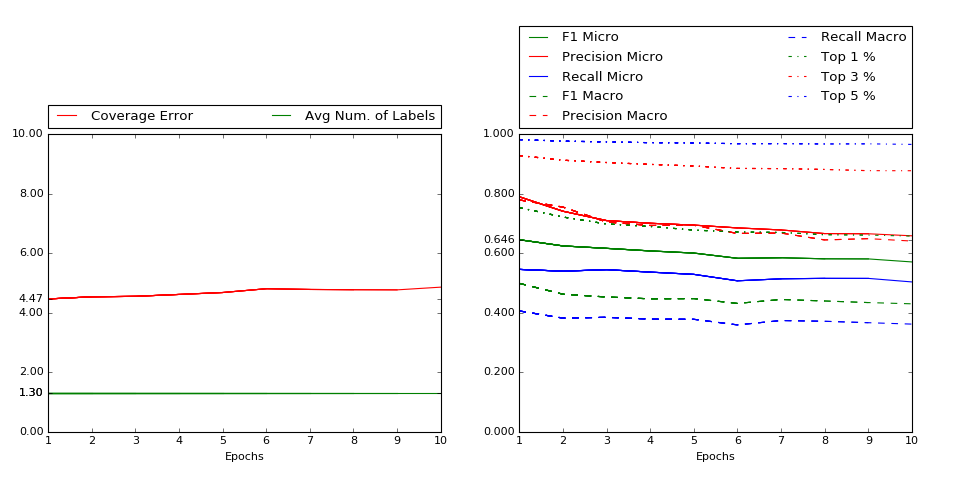

CPU times: user 23.2 s, sys: 3.02 s, total: 26.2 s
Wall time: 27.5 s


2017-01-01 18:21:41,802 : INFO : Getting Validation Embeddings
2017-01-01 18:21:41,803 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.265, Avg Labels: 1.290, 
		 Top 1: 0.843, Top 3: 0.963, Top 5: 0.993, 
		 F1 Micro: 0.779, F1 Macro: 0.592, Total Pos: 56,747


2017-01-01 18:21:42,411 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.471, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.646, F1 Macro: 0.500, Total Pos: 11,127
CPU times: user 12.2 s, sys: 1.68 s, total: 13.9 s
Wall time: 13.2 s


2017-01-01 18:21:58,973 : INFO : Getting Validation Embeddings
2017-01-01 18:21:58,977 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.912, Avg Labels: 1.290, 
		 Top 1: 0.882, Top 3: 0.976, Top 5: 0.996, 
		 F1 Micro: 0.821, F1 Macro: 0.500, Total Pos: 58,866


2017-01-01 18:21:59,765 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.543, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.913, Top 5: 0.977, 
		 F1 Micro: 0.625, F1 Macro: 0.463, Total Pos: 11,724
CPU times: user 16.3 s, sys: 1.86 s, total: 18.2 s
Wall time: 17.2 s


2017-01-01 18:22:20,148 : INFO : Getting Validation Embeddings
2017-01-01 18:22:20,149 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.585, Avg Labels: 1.290, 
		 Top 1: 0.910, Top 3: 0.983, Top 5: 0.997, 
		 F1 Micro: 0.855, F1 Macro: 0.463, Total Pos: 61,338


2017-01-01 18:22:20,750 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.559, Avg Labels: 1.300, 
		 Top 1: 0.699, Top 3: 0.906, Top 5: 0.975, 
		 F1 Micro: 0.617, F1 Macro: 0.454, Total Pos: 12,359
CPU times: user 11.7 s, sys: 1.64 s, total: 13.3 s
Wall time: 12.5 s


2017-01-01 18:22:36,894 : INFO : Getting Validation Embeddings
2017-01-01 18:22:36,896 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.388, Avg Labels: 1.290, 
		 Top 1: 0.931, Top 3: 0.987, Top 5: 0.998, 
		 F1 Micro: 0.878, F1 Macro: 0.454, Total Pos: 61,830


2017-01-01 18:22:37,487 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.623, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.899, Top 5: 0.972, 
		 F1 Micro: 0.608, F1 Macro: 0.447, Total Pos: 12,329
CPU times: user 14.8 s, sys: 1.81 s, total: 16.6 s
Wall time: 15.7 s


2017-01-01 18:22:56,801 : INFO : Getting Validation Embeddings
2017-01-01 18:22:56,803 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.301, Avg Labels: 1.290, 
		 Top 1: 0.943, Top 3: 0.990, Top 5: 0.999, 
		 F1 Micro: 0.892, F1 Macro: 0.447, Total Pos: 61,482


2017-01-01 18:22:57,615 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.687, Avg Labels: 1.300, 
		 Top 1: 0.679, Top 3: 0.894, Top 5: 0.971, 
		 F1 Micro: 0.601, F1 Macro: 0.448, Total Pos: 12,265
CPU times: user 14.5 s, sys: 1.9 s, total: 16.4 s
Wall time: 15.5 s


2017-01-01 18:23:16,567 : INFO : Getting Validation Embeddings
2017-01-01 18:23:16,568 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.242, Avg Labels: 1.290, 
		 Top 1: 0.953, Top 3: 0.991, Top 5: 0.999, 
		 F1 Micro: 0.903, F1 Macro: 0.448, Total Pos: 60,706


2017-01-01 18:23:17,173 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.814, Avg Labels: 1.300, 
		 Top 1: 0.672, Top 3: 0.886, Top 5: 0.969, 
		 F1 Micro: 0.584, F1 Macro: 0.432, Total Pos: 11,924
CPU times: user 12.2 s, sys: 1.45 s, total: 13.6 s
Wall time: 13 s


2017-01-01 18:23:33,088 : INFO : Getting Validation Embeddings
2017-01-01 18:23:33,090 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.084, Avg Labels: 1.290, 
		 Top 1: 0.962, Top 3: 0.993, Top 5: 0.999, 
		 F1 Micro: 0.917, F1 Macro: 0.432, Total Pos: 62,038


2017-01-01 18:23:33,694 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.790, Avg Labels: 1.300, 
		 Top 1: 0.671, Top 3: 0.885, Top 5: 0.969, 
		 F1 Micro: 0.586, F1 Macro: 0.445, Total Pos: 12,203
CPU times: user 14.3 s, sys: 1.84 s, total: 16.1 s
Wall time: 15.2 s


2017-01-01 18:23:52,677 : INFO : Getting Validation Embeddings
2017-01-01 18:23:52,678 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.987, Avg Labels: 1.290, 
		 Top 1: 0.967, Top 3: 0.994, Top 5: 0.999, 
		 F1 Micro: 0.925, F1 Macro: 0.445, Total Pos: 62,885


2017-01-01 18:23:53,291 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.781, Avg Labels: 1.300, 
		 Top 1: 0.663, Top 3: 0.882, Top 5: 0.968, 
		 F1 Micro: 0.582, F1 Macro: 0.440, Total Pos: 12,465
CPU times: user 16.8 s, sys: 1.79 s, total: 18.6 s
Wall time: 17.6 s


2017-01-01 18:24:14,555 : INFO : Getting Validation Embeddings
2017-01-01 18:24:14,557 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.899, Avg Labels: 1.290, 
		 Top 1: 0.972, Top 3: 0.995, Top 5: 0.999, 
		 F1 Micro: 0.931, F1 Macro: 0.440, Total Pos: 63,456


2017-01-01 18:24:15,176 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.776, Avg Labels: 1.300, 
		 Top 1: 0.662, Top 3: 0.878, Top 5: 0.968, 
		 F1 Micro: 0.582, F1 Macro: 0.435, Total Pos: 12,473
CPU times: user 15.6 s, sys: 1.61 s, total: 17.2 s
Wall time: 16.3 s


2017-01-01 18:24:36,099 : INFO : Getting Validation Embeddings
2017-01-01 18:24:36,101 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.856, Avg Labels: 1.290, 
		 Top 1: 0.975, Top 3: 0.995, Top 5: 0.999, 
		 F1 Micro: 0.939, F1 Macro: 0.435, Total Pos: 63,226


2017-01-01 18:24:36,806 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.867, Avg Labels: 1.300, 
		 Top 1: 0.658, Top 3: 0.878, Top 5: 0.966, 
		 F1 Micro: 0.571, F1 Macro: 0.431, Total Pos: 12,311
========== 1st Layer Size: 50, 1st Layer Activation: relu, 
 2nd Layer Size: 50, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 50)    

<IPython.core.display.Javascript object>


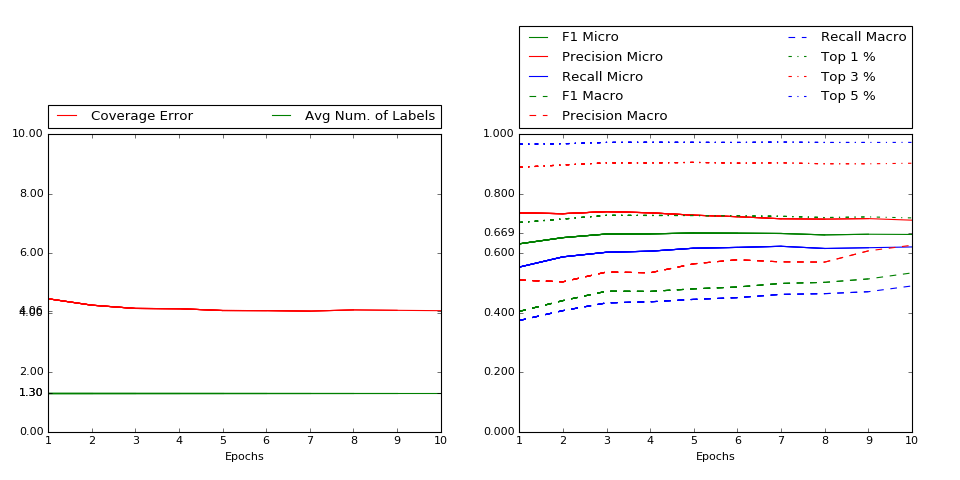

CPU times: user 17.9 s, sys: 3.67 s, total: 21.6 s


2017-01-01 18:25:03,986 : INFO : Getting Validation Embeddings
2017-01-01 18:25:03,987 : INFO : ===== Loading validation vectors


Wall time: 22.4 s
** Training Metrics: Cov Err: 4.528, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.899, Top 5: 0.969, 
		 F1 Micro: 0.633, F1 Macro: 0.431, Total Pos: 46,401


2017-01-01 18:25:04,574 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.478, Avg Labels: 1.300, 
		 Top 1: 0.704, Top 3: 0.889, Top 5: 0.967, 
		 F1 Micro: 0.632, F1 Macro: 0.405, Total Pos: 12,119
CPU times: user 17 s, sys: 2.98 s, total: 19.9 s
Wall time: 18.7 s


2017-01-01 18:25:26,699 : INFO : Getting Validation Embeddings
2017-01-01 18:25:26,700 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.156, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.914, Top 5: 0.972, 
		 F1 Micro: 0.676, F1 Macro: 0.405, Total Pos: 49,297


2017-01-01 18:25:27,325 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.263, Avg Labels: 1.300, 
		 Top 1: 0.716, Top 3: 0.897, Top 5: 0.969, 
		 F1 Micro: 0.653, F1 Macro: 0.442, Total Pos: 12,912
CPU times: user 18.8 s, sys: 2.73 s, total: 21.5 s
Wall time: 20.3 s

2017-01-01 18:25:51,858 : INFO : Getting Validation Embeddings
2017-01-01 18:25:51,859 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.900, Avg Labels: 1.290, 
		 Top 1: 0.775, Top 3: 0.923, Top 5: 0.977, 
		 F1 Micro: 0.705, F1 Macro: 0.442, Total Pos: 51,123


2017-01-01 18:25:52,589 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.152, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.665, F1 Macro: 0.473, Total Pos: 13,130
CPU times: user 16.3 s, sys: 2.96 s, total: 19.2 s
Wall time: 18.2 s


2017-01-01 18:26:14,632 : INFO : Getting Validation Embeddings
2017-01-01 18:26:14,634 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.810, Avg Labels: 1.290, 
		 Top 1: 0.781, Top 3: 0.926, Top 5: 0.979, 
		 F1 Micro: 0.716, F1 Macro: 0.473, Total Pos: 52,073


2017-01-01 18:26:15,244 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.143, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.666, F1 Macro: 0.472, Total Pos: 13,276
CPU times: user 16.4 s, sys: 3.15 s, total: 19.5 s

2017-01-01 18:26:36,909 : INFO : Getting Validation Embeddings
2017-01-01 18:26:36,910 : INFO : ===== Loading validation vectors



Wall time: 18.4 s
** Training Metrics: Cov Err: 3.733, Avg Labels: 1.290, 
		 Top 1: 0.786, Top 3: 0.929, Top 5: 0.980, 
		 F1 Micro: 0.723, F1 Macro: 0.472, Total Pos: 53,142


2017-01-01 18:26:37,517 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.083, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.906, Top 5: 0.973, 
		 F1 Micro: 0.669, F1 Macro: 0.481, Total Pos: 13,645
CPU times: user 18.5 s, sys: 2.77 s, total: 21.3 s
Wall time: 20 s


2017-01-01 18:27:01,307 : INFO : Getting Validation Embeddings
2017-01-01 18:27:01,309 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.702, Avg Labels: 1.290, 
		 Top 1: 0.789, Top 3: 0.931, Top 5: 0.981, 
		 F1 Micro: 0.727, F1 Macro: 0.481, Total Pos: 53,461


2017-01-01 18:27:01,901 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.079, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.903, Top 5: 0.973, 
		 F1 Micro: 0.668, F1 Macro: 0.487, Total Pos: 13,800
CPU times: user 16.6 s, sys: 2.96 s, total: 19.6 s
Wall time: 18.4 s


2017-01-01 18:27:23,325 : INFO : Getting Validation Embeddings
2017-01-01 18:27:23,327 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.664, Avg Labels: 1.290, 
		 Top 1: 0.791, Top 3: 0.932, Top 5: 0.981, 
		 F1 Micro: 0.730, F1 Macro: 0.487, Total Pos: 54,084


2017-01-01 18:27:23,952 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.062, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.904, Top 5: 0.974, 
		 F1 Micro: 0.667, F1 Macro: 0.499, Total Pos: 14,018
CPU times: user 17.1 s, sys: 2.99 s, total: 20.1 s
Wall time: 19 s


2017-01-01 18:27:46,976 : INFO : Getting Validation Embeddings
2017-01-01 18:27:46,977 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.696, Avg Labels: 1.290, 
		 Top 1: 0.793, Top 3: 0.933, Top 5: 0.982, 
		 F1 Micro: 0.729, F1 Macro: 0.499, Total Pos: 53,062


2017-01-01 18:27:47,629 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.103, Avg Labels: 1.300, 
		 Top 1: 0.721, Top 3: 0.901, Top 5: 0.973, 
		 F1 Micro: 0.662, F1 Macro: 0.503, Total Pos: 13,877
CPU times: user 19.2 s, sys: 3.02 s, total: 22.2 s
Wall time: 21 s


2017-01-01 18:28:12,804 : INFO : Getting Validation Embeddings
2017-01-01 18:28:12,806 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.664, Avg Labels: 1.290, 
		 Top 1: 0.794, Top 3: 0.935, Top 5: 0.982, 
		 F1 Micro: 0.732, F1 Macro: 0.503, Total Pos: 53,506


2017-01-01 18:28:13,616 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.089, Avg Labels: 1.300, 
		 Top 1: 0.723, Top 3: 0.901, Top 5: 0.973, 
		 F1 Micro: 0.665, F1 Macro: 0.514, Total Pos: 13,900
CPU times: user 15.6 s, sys: 2.74 s, total: 18.3 s


2017-01-01 18:28:34,782 : INFO : Getting Validation Embeddings
2017-01-01 18:28:34,783 : INFO : ===== Loading validation vectors


Wall time: 17.3 s
** Training Metrics: Cov Err: 3.616, Avg Labels: 1.290, 
		 Top 1: 0.798, Top 3: 0.937, Top 5: 0.983, 
		 F1 Micro: 0.735, F1 Macro: 0.514, Total Pos: 54,055


2017-01-01 18:28:35,409 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.076, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.903, Top 5: 0.973, 
		 F1 Micro: 0.664, F1 Macro: 0.535, Total Pos: 14,062
========== 1st Layer Size: 50, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_91 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 50)   

<IPython.core.display.Javascript object>


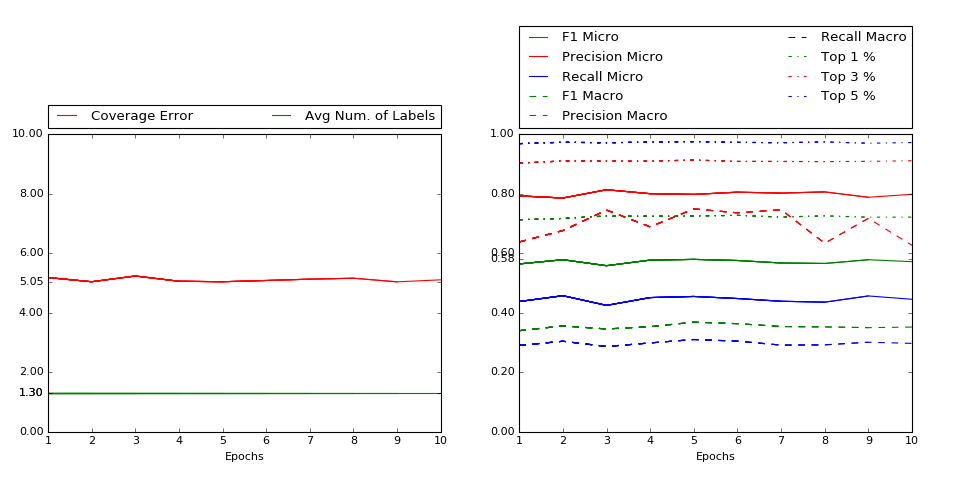

CPU times: user 18.6 s, sys: 4.24 s, total: 22.9 s
Wall time: 22.8 s


2017-01-01 18:29:02,520 : INFO : Getting Validation Embeddings
2017-01-01 18:29:02,524 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.400, Avg Labels: 1.290, 
		 Top 1: 0.697, Top 3: 0.893, Top 5: 0.963, 
		 F1 Micro: 0.541, F1 Macro: 0.535, Total Pos: 33,224


2017-01-01 18:29:03,314 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.190, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.903, Top 5: 0.969, 
		 F1 Micro: 0.565, F1 Macro: 0.341, Total Pos: 8,895
CPU times: user 19.9 s, sys: 3.82 s, total: 23.7 s
Wall time: 22.2 s


2017-01-01 18:29:29,811 : INFO : Getting Validation Embeddings
2017-01-01 18:29:29,812 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.252, Avg Labels: 1.290, 
		 Top 1: 0.705, Top 3: 0.900, Top 5: 0.966, 
		 F1 Micro: 0.557, F1 Macro: 0.341, Total Pos: 35,178


2017-01-01 18:29:30,639 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.049, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.911, Top 5: 0.974, 
		 F1 Micro: 0.579, F1 Macro: 0.357, Total Pos: 9,377
CPU times: user 21.2 s, sys: 3.78 s, total: 25 s
Wall time: 23.5 s


2017-01-01 18:29:57,973 : INFO : Getting Validation Embeddings
2017-01-01 18:29:57,976 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.466, Avg Labels: 1.290, 
		 Top 1: 0.712, Top 3: 0.901, Top 5: 0.966, 
		 F1 Micro: 0.533, F1 Macro: 0.357, Total Pos: 31,345


2017-01-01 18:29:58,590 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.242, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.910, Top 5: 0.972, 
		 F1 Micro: 0.559, F1 Macro: 0.346, Total Pos: 8,412
CPU times: user 19.5 s, sys: 3.85 s, total: 23.4 s

2017-01-01 18:30:24,875 : INFO : Getting Validation Embeddings
2017-01-01 18:30:24,876 : INFO : ===== Loading validation vectors



Wall time: 22 s
** Training Metrics: Cov Err: 5.313, Avg Labels: 1.290, 
		 Top 1: 0.709, Top 3: 0.899, Top 5: 0.968, 
		 F1 Micro: 0.550, F1 Macro: 0.346, Total Pos: 33,819


2017-01-01 18:30:25,457 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.066, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.910, Top 5: 0.974, 
		 F1 Micro: 0.578, F1 Macro: 0.354, Total Pos: 9,080
CPU times: user 19.4 s, sys: 3.66 s, total: 23.1 s
Wall time: 21.8 s


2017-01-01 18:30:51,376 : INFO : Getting Validation Embeddings
2017-01-01 18:30:51,378 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.293, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.903, Top 5: 0.969, 
		 F1 Micro: 0.553, F1 Macro: 0.354, Total Pos: 34,073


2017-01-01 18:30:52,098 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.049, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.914, Top 5: 0.976, 
		 F1 Micro: 0.580, F1 Macro: 0.369, Total Pos: 9,182
CPU times: user 16.6 s, sys: 3.71 s, total: 20.3 s
Wall time: 19.2 s


2017-01-01 18:31:14,857 : INFO : Getting Validation Embeddings
2017-01-01 18:31:14,858 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.338, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.900, Top 5: 0.967, 
		 F1 Micro: 0.547, F1 Macro: 0.369, Total Pos: 32,939


2017-01-01 18:31:15,451 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.091, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.909, Top 5: 0.973, 
		 F1 Micro: 0.576, F1 Macro: 0.364, Total Pos: 8,958
CPU times: user 18.9 s, sys: 3.67 s, total: 22.6 s


2017-01-01 18:31:40,336 : INFO : Getting Validation Embeddings
2017-01-01 18:31:40,338 : INFO : ===== Loading validation vectors


Wall time: 21.2 s
** Training Metrics: Cov Err: 5.403, Avg Labels: 1.290, 
		 Top 1: 0.705, Top 3: 0.895, Top 5: 0.966, 
		 F1 Micro: 0.537, F1 Macro: 0.364, Total Pos: 32,525


2017-01-01 18:31:41,010 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.136, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.909, Top 5: 0.972, 
		 F1 Micro: 0.568, F1 Macro: 0.354, Total Pos: 8,809
CPU times: user 19.2 s, sys: 3.67 s, total: 22.8 s
Wall time: 21.6 s


2017-01-01 18:32:07,575 : INFO : Getting Validation Embeddings
2017-01-01 18:32:07,577 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.410, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.897, Top 5: 0.968, 
		 F1 Micro: 0.538, F1 Macro: 0.354, Total Pos: 32,007


2017-01-01 18:32:08,160 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.167, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.909, Top 5: 0.975, 
		 F1 Micro: 0.566, F1 Macro: 0.353, Total Pos: 8,704
CPU times: user 22.1 s, sys: 3.91 s, total: 26 s
Wall time: 24.4 s


2017-01-01 18:32:36,396 : INFO : Getting Validation Embeddings
2017-01-01 18:32:36,398 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.280, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.895, Top 5: 0.964, 
		 F1 Micro: 0.553, F1 Macro: 0.353, Total Pos: 35,022


2017-01-01 18:32:37,170 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.046, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.909, Top 5: 0.970, 
		 F1 Micro: 0.579, F1 Macro: 0.351, Total Pos: 9,330
CPU times: user 19.1 s, sys: 3.8 s, total: 22.9 s
Wall time: 21.5 s


2017-01-01 18:33:03,247 : INFO : Getting Validation Embeddings
2017-01-01 18:33:03,249 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.356, Avg Labels: 1.290, 
		 Top 1: 0.707, Top 3: 0.896, Top 5: 0.966, 
		 F1 Micro: 0.545, F1 Macro: 0.351, Total Pos: 33,358


2017-01-01 18:33:03,985 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.113, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.912, Top 5: 0.973, 
		 F1 Micro: 0.572, F1 Macro: 0.353, Total Pos: 8,987
========== 1st Layer Size: 1000, 1st Layer Activation: relu, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_93 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)    

<IPython.core.display.Javascript object>


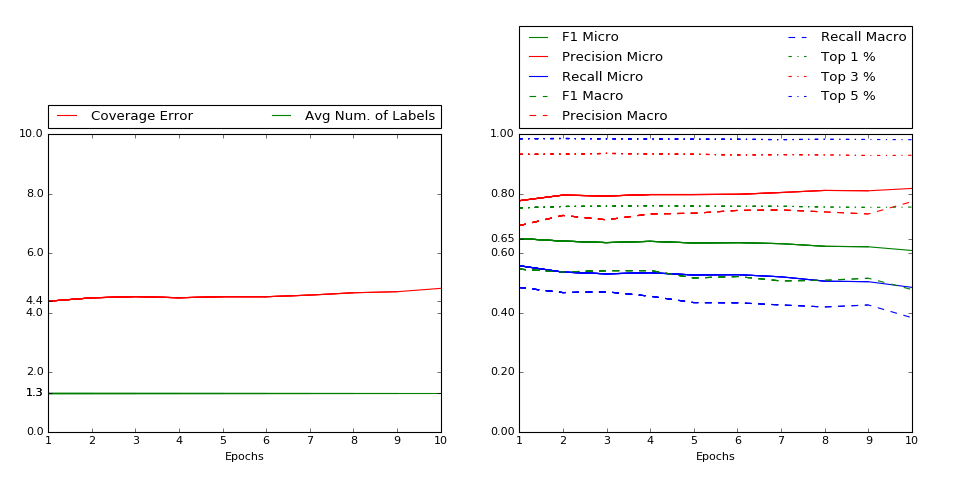

CPU times: user 25.9 s, sys: 16.5 s, total: 42.4 s
Wall time: 1min 28s

2017-01-01 18:34:38,332 : INFO : Getting Validation Embeddings
2017-01-01 18:34:38,334 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.922, Avg Labels: 1.290, 
		 Top 1: 0.724, Top 3: 0.921, Top 5: 0.982, 
		 F1 Micro: 0.593, F1 Macro: 0.353, Total Pos: 39,916


2017-01-01 18:34:39,150 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.395, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.933, Top 5: 0.986, 
		 F1 Micro: 0.650, F1 Macro: 0.547, Total Pos: 11,572
CPU times: user 25.5 s, sys: 16.9 s, total: 42.4 s
Wall time: 1min 27s


2017-01-01 18:36:11,928 : INFO : Getting Validation Embeddings
2017-01-01 18:36:11,930 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.321, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.922, Top 5: 0.983, 
		 F1 Micro: 0.551, F1 Macro: 0.547, Total Pos: 32,698


2017-01-01 18:36:12,688 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.508, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.934, Top 5: 0.986, 
		 F1 Micro: 0.642, F1 Macro: 0.538, Total Pos: 10,865
CPU times: user 26 s, sys: 17.1 s, total: 43.1 s
Wall time: 1min 29s


2017-01-01 18:37:46,980 : INFO : Getting Validation Embeddings
2017-01-01 18:37:46,982 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.539, Avg Labels: 1.290, 
		 Top 1: 0.723, Top 3: 0.920, Top 5: 0.983, 
		 F1 Micro: 0.522, F1 Macro: 0.538, Total Pos: 30,432


2017-01-01 18:37:47,785 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.550, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.636, F1 Macro: 0.542, Total Pos: 10,788
CPU times: user 25.8 s, sys: 16.7 s, total: 42.5 s
Wall time: 1min 27s


2017-01-01 18:39:20,645 : INFO : Getting Validation Embeddings
2017-01-01 18:39:20,647 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.469, Avg Labels: 1.290, 
		 Top 1: 0.723, Top 3: 0.921, Top 5: 0.982, 
		 F1 Micro: 0.530, F1 Macro: 0.542, Total Pos: 30,981


2017-01-01 18:39:21,467 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.511, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.641, F1 Macro: 0.542, Total Pos: 10,796
CPU times: user 25.8 s, sys: 16.9 s, total: 42.8 s


2017-01-01 18:40:53,725 : INFO : Getting Validation Embeddings
2017-01-01 18:40:53,726 : INFO : ===== Loading validation vectors


Wall time: 1min 27s
** Training Metrics: Cov Err: 5.404, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.919, Top 5: 0.982, 
		 F1 Micro: 0.537, F1 Macro: 0.542, Total Pos: 31,976


2017-01-01 18:40:54,440 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.546, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.635, F1 Macro: 0.518, Total Pos: 10,644
CPU times: user 26 s, sys: 17.4 s, total: 43.4 s


2017-01-01 18:42:28,696 : INFO : Getting Validation Embeddings
2017-01-01 18:42:28,697 : INFO : ===== Loading validation vectors


Wall time: 1min 29s
** Training Metrics: Cov Err: 5.342, Avg Labels: 1.290, 
		 Top 1: 0.712, Top 3: 0.915, Top 5: 0.982, 
		 F1 Micro: 0.544, F1 Macro: 0.518, Total Pos: 33,387


2017-01-01 18:42:29,326 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.546, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.636, F1 Macro: 0.522, Total Pos: 10,656
CPU times: user 26 s, sys: 17.5 s, total: 43.5 s
Wall time: 1min 29s


2017-01-01 18:44:03,367 : INFO : Getting Validation Embeddings
2017-01-01 18:44:03,369 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.460, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.915, Top 5: 0.980, 
		 F1 Micro: 0.531, F1 Macro: 0.522, Total Pos: 31,582


2017-01-01 18:44:04,150 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.600, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.932, Top 5: 0.982, 
		 F1 Micro: 0.633, F1 Macro: 0.508, Total Pos: 10,429
CPU times: user 25.1 s, sys: 17 s, total: 42.1 s
Wall time: 1min 27s


2017-01-01 18:45:36,158 : INFO : Getting Validation Embeddings
2017-01-01 18:45:36,160 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.528, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.913, Top 5: 0.981, 
		 F1 Micro: 0.522, F1 Macro: 0.508, Total Pos: 30,337


2017-01-01 18:45:36,969 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.679, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.624, F1 Macro: 0.510, Total Pos: 10,051
CPU times: user 24.8 s, sys: 16.4 s, total: 41.2 s
Wall time: 1min 25s


2017-01-01 18:47:07,811 : INFO : Getting Validation Embeddings
2017-01-01 18:47:07,812 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.576, Avg Labels: 1.290, 
		 Top 1: 0.708, Top 3: 0.912, Top 5: 0.981, 
		 F1 Micro: 0.515, F1 Macro: 0.510, Total Pos: 29,850


2017-01-01 18:47:08,656 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.714, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.622, F1 Macro: 0.517, Total Pos: 10,029
CPU times: user 25.4 s, sys: 17 s, total: 42.4 s


2017-01-01 18:48:39,371 : INFO : Getting Validation Embeddings
2017-01-01 18:48:39,372 : INFO : ===== Loading validation vectors


Wall time: 1min 26s
** Training Metrics: Cov Err: 5.682, Avg Labels: 1.290, 
		 Top 1: 0.712, Top 3: 0.914, Top 5: 0.980, 
		 F1 Micro: 0.502, F1 Macro: 0.517, Total Pos: 28,350


2017-01-01 18:48:39,974 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.827, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.610, F1 Macro: 0.479, Total Pos: 9,558
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 1000, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 1000)

<IPython.core.display.Javascript object>


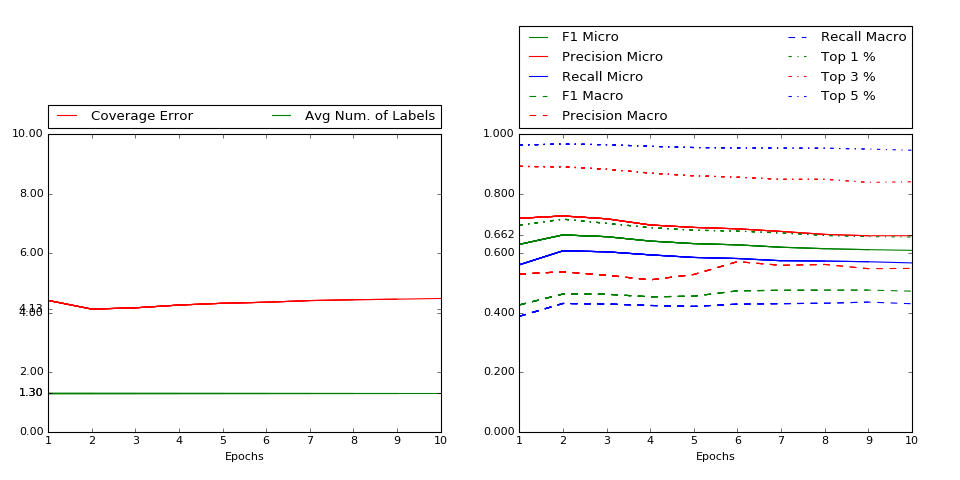

CPU times: user 31.8 s, sys: 25.7 s, total: 57.5 s
Wall time: 1min 58s


2017-01-01 18:50:47,075 : INFO : Getting Validation Embeddings
2017-01-01 18:50:47,077 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.280, Avg Labels: 1.290, 
		 Top 1: 0.741, Top 3: 0.911, Top 5: 0.969, 
		 F1 Micro: 0.658, F1 Macro: 0.479, Total Pos: 48,074


2017-01-01 18:50:48,106 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.423, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.892, Top 5: 0.964, 
		 F1 Micro: 0.630, F1 Macro: 0.427, Total Pos: 12,594
CPU times: user 30.8 s, sys: 25.7 s, total: 56.5 s
Wall time: 1min 57s


2017-01-01 18:52:52,904 : INFO : Getting Validation Embeddings
2017-01-01 18:52:52,906 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.615, Avg Labels: 1.290, 
		 Top 1: 0.810, Top 3: 0.929, Top 5: 0.977, 
		 F1 Micro: 0.741, F1 Macro: 0.427, Total Pos: 52,230


2017-01-01 18:52:53,775 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.130, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.891, Top 5: 0.968, 
		 F1 Micro: 0.662, F1 Macro: 0.464, Total Pos: 13,497
CPU times: user 31.4 s, sys: 26.6 s, total: 58 s
Wall time: 2min


2017-01-01 18:55:02,397 : INFO : Getting Validation Embeddings
2017-01-01 18:55:02,399 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.314, Avg Labels: 1.290, 
		 Top 1: 0.837, Top 3: 0.937, Top 5: 0.982, 
		 F1 Micro: 0.778, F1 Macro: 0.464, Total Pos: 54,148


2017-01-01 18:55:03,003 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.172, Avg Labels: 1.300, 
		 Top 1: 0.701, Top 3: 0.883, Top 5: 0.965, 
		 F1 Micro: 0.656, F1 Macro: 0.463, Total Pos: 13,605
CPU times: user 31.2 s, sys: 27 s, total: 58.2 s
Wall time: 1min 59s


2017-01-01 18:57:10,707 : INFO : Getting Validation Embeddings
2017-01-01 18:57:10,708 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.173, Avg Labels: 1.290, 
		 Top 1: 0.849, Top 3: 0.942, Top 5: 0.983, 
		 F1 Micro: 0.793, F1 Macro: 0.463, Total Pos: 55,569


2017-01-01 18:57:11,385 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.266, Avg Labels: 1.300, 
		 Top 1: 0.687, Top 3: 0.870, Top 5: 0.960, 
		 F1 Micro: 0.642, F1 Macro: 0.454, Total Pos: 13,771
CPU times: user 31.1 s, sys: 26.3 s, total: 57.4 s
Wall time: 2min


2017-01-01 18:59:18,993 : INFO : Getting Validation Embeddings
2017-01-01 18:59:18,994 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.074, Avg Labels: 1.290, 
		 Top 1: 0.862, Top 3: 0.945, Top 5: 0.984, 
		 F1 Micro: 0.808, F1 Macro: 0.454, Total Pos: 55,277


2017-01-01 18:59:19,725 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.326, Avg Labels: 1.300, 
		 Top 1: 0.678, Top 3: 0.861, Top 5: 0.956, 
		 F1 Micro: 0.633, F1 Macro: 0.456, Total Pos: 13,733
CPU times: user 31.4 s, sys: 26.8 s, total: 58.2 s
Wall time: 2min


2017-01-01 19:01:26,826 : INFO : Getting Validation Embeddings
2017-01-01 19:01:26,827 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.008, Avg Labels: 1.290, 
		 Top 1: 0.870, Top 3: 0.948, Top 5: 0.986, 
		 F1 Micro: 0.814, F1 Macro: 0.456, Total Pos: 55,713


2017-01-01 19:01:27,461 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.360, Avg Labels: 1.300, 
		 Top 1: 0.675, Top 3: 0.856, Top 5: 0.955, 
		 F1 Micro: 0.629, F1 Macro: 0.474, Total Pos: 13,744
CPU times: user 31.5 s, sys: 26.8 s, total: 58.3 s


2017-01-01 19:03:36,886 : INFO : Getting Validation Embeddings
2017-01-01 19:03:36,887 : INFO : ===== Loading validation vectors


Wall time: 2min 1s
** Training Metrics: Cov Err: 2.908, Avg Labels: 1.290, 
		 Top 1: 0.881, Top 3: 0.949, Top 5: 0.986, 
		 F1 Micro: 0.827, F1 Macro: 0.474, Total Pos: 55,882


2017-01-01 19:03:37,594 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.416, Avg Labels: 1.300, 
		 Top 1: 0.669, Top 3: 0.849, Top 5: 0.954, 
		 F1 Micro: 0.621, F1 Macro: 0.476, Total Pos: 13,747
CPU times: user 31.4 s, sys: 26.7 s, total: 58.1 s
Wall time: 2min


2017-01-01 19:05:44,557 : INFO : Getting Validation Embeddings
2017-01-01 19:05:44,559 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.832, Avg Labels: 1.290, 
		 Top 1: 0.885, Top 3: 0.951, Top 5: 0.986, 
		 F1 Micro: 0.833, F1 Macro: 0.476, Total Pos: 56,789


2017-01-01 19:05:45,218 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.443, Avg Labels: 1.300, 
		 Top 1: 0.660, Top 3: 0.849, Top 5: 0.954, 
		 F1 Micro: 0.616, F1 Macro: 0.477, Total Pos: 13,925
CPU times: user 30.7 s, sys: 26.1 s, total: 56.7 s
Wall time: 1min 58s

2017-01-01 19:07:50,700 : INFO : Getting Validation Embeddings
2017-01-01 19:07:50,702 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 2.793, Avg Labels: 1.290, 
		 Top 1: 0.888, Top 3: 0.952, Top 5: 0.987, 
		 F1 Micro: 0.837, F1 Macro: 0.477, Total Pos: 57,296


2017-01-01 19:07:51,514 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.463, Avg Labels: 1.300, 
		 Top 1: 0.656, Top 3: 0.839, Top 5: 0.951, 
		 F1 Micro: 0.613, F1 Macro: 0.477, Total Pos: 13,963
CPU times: user 31.2 s, sys: 26.8 s, total: 58 s


2017-01-01 19:09:59,912 : INFO : Getting Validation Embeddings
2017-01-01 19:09:59,913 : INFO : ===== Loading validation vectors


Wall time: 2min
** Training Metrics: Cov Err: 2.734, Avg Labels: 1.290, 
		 Top 1: 0.895, Top 3: 0.953, Top 5: 0.987, 
		 F1 Micro: 0.846, F1 Macro: 0.477, Total Pos: 57,102


2017-01-01 19:10:00,582 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.487, Avg Labels: 1.300, 
		 Top 1: 0.655, Top 3: 0.841, Top 5: 0.947, 
		 F1 Micro: 0.610, F1 Macro: 0.473, Total Pos: 13,867
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_95 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)   

/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


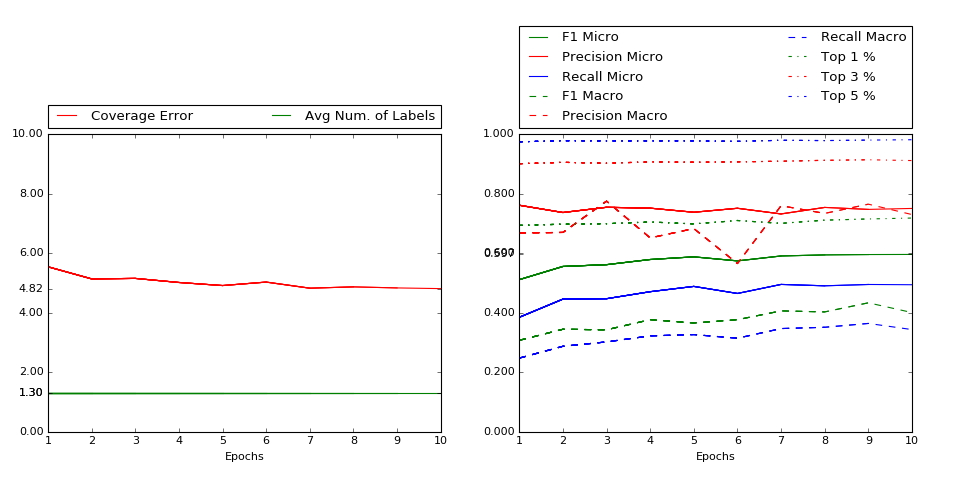

CPU times: user 35.9 s, sys: 33.2 s, total: 1min 9s


2017-01-01 19:12:32,905 : INFO : Getting Validation Embeddings
2017-01-01 19:12:32,906 : INFO : ===== Loading validation vectors


Wall time: 2min 21s
** Training Metrics: Cov Err: 5.749, Avg Labels: 1.290, 
		 Top 1: 0.681, Top 3: 0.895, Top 5: 0.971, 
		 F1 Micro: 0.492, F1 Macro: 0.473, Total Pos: 29,761


2017-01-01 19:12:33,641 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.551, Avg Labels: 1.300, 
		 Top 1: 0.694, Top 3: 0.902, Top 5: 0.975, 
		 F1 Micro: 0.512, F1 Macro: 0.308, Total Pos: 8,142
CPU times: user 35.2 s, sys: 34.2 s, total: 1min 9s


2017-01-01 19:15:06,091 : INFO : Getting Validation Embeddings
2017-01-01 19:15:06,093 : INFO : ===== Loading validation vectors


Wall time: 2min 22s
** Training Metrics: Cov Err: 5.273, Avg Labels: 1.290, 
		 Top 1: 0.689, Top 3: 0.900, Top 5: 0.972, 
		 F1 Micro: 0.546, F1 Macro: 0.308, Total Pos: 37,669


2017-01-01 19:15:06,709 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.145, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.906, Top 5: 0.979, 
		 F1 Micro: 0.556, F1 Macro: 0.345, Total Pos: 9,745
CPU times: user 35.7 s, sys: 34.7 s, total: 1min 10s
Wall time: 2min 24s


2017-01-01 19:17:41,650 : INFO : Getting Validation Embeddings
2017-01-01 19:17:41,653 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.286, Avg Labels: 1.290, 
		 Top 1: 0.689, Top 3: 0.898, Top 5: 0.972, 
		 F1 Micro: 0.549, F1 Macro: 0.345, Total Pos: 36,424


2017-01-01 19:17:42,336 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.161, Avg Labels: 1.300, 
		 Top 1: 0.700, Top 3: 0.903, Top 5: 0.978, 
		 F1 Micro: 0.562, F1 Macro: 0.343, Total Pos: 9,548
CPU times: user 35.6 s, sys: 34.5 s, total: 1min 10s


2017-01-01 19:20:18,781 : INFO : Getting Validation Embeddings
2017-01-01 19:20:18,784 : INFO : ===== Loading validation vectors


Wall time: 2min 26s
** Training Metrics: Cov Err: 5.237, Avg Labels: 1.290, 
		 Top 1: 0.693, Top 3: 0.902, Top 5: 0.974, 
		 F1 Micro: 0.557, F1 Macro: 0.343, Total Pos: 37,522


2017-01-01 19:20:19,494 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.024, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.908, Top 5: 0.978, 
		 F1 Micro: 0.580, F1 Macro: 0.377, Total Pos: 10,089
CPU times: user 35 s, sys: 33.3 s, total: 1min 8s
Wall time: 2min 20s

2017-01-01 19:22:51,174 : INFO : Getting Validation Embeddings
2017-01-01 19:22:51,177 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.015, Avg Labels: 1.290, 
		 Top 1: 0.688, Top 3: 0.902, Top 5: 0.974, 
		 F1 Micro: 0.580, F1 Macro: 0.377, Total Pos: 42,013


2017-01-01 19:22:51,859 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.921, Avg Labels: 1.300, 
		 Top 1: 0.699, Top 3: 0.907, Top 5: 0.978, 
		 F1 Micro: 0.589, F1 Macro: 0.366, Total Pos: 10,665
CPU times: user 35 s, sys: 33.5 s, total: 1min 8s
Wall time: 2min 22s


2017-01-01 19:25:24,309 : INFO : Getting Validation Embeddings
2017-01-01 19:25:24,311 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.185, Avg Labels: 1.290, 
		 Top 1: 0.699, Top 3: 0.901, Top 5: 0.969, 
		 F1 Micro: 0.561, F1 Macro: 0.366, Total Pos: 38,265


2017-01-01 19:25:24,948 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.038, Avg Labels: 1.300, 
		 Top 1: 0.711, Top 3: 0.908, Top 5: 0.977, 
		 F1 Micro: 0.575, F1 Macro: 0.377, Total Pos: 9,967
CPU times: user 35.1 s, sys: 33.9 s, total: 1min 9s
Wall time: 2min 22s


2017-01-01 19:27:56,923 : INFO : Getting Validation Embeddings
2017-01-01 19:27:56,925 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.007, Avg Labels: 1.290, 
		 Top 1: 0.690, Top 3: 0.906, Top 5: 0.975, 
		 F1 Micro: 0.575, F1 Macro: 0.377, Total Pos: 41,063


2017-01-01 19:27:57,716 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.833, Avg Labels: 1.300, 
		 Top 1: 0.701, Top 3: 0.910, Top 5: 0.980, 
		 F1 Micro: 0.592, F1 Macro: 0.407, Total Pos: 10,893
CPU times: user 34.3 s, sys: 32.1 s, total: 1min 6s
Wall time: 2min 17s


2017-01-01 19:30:25,159 : INFO : Getting Validation Embeddings
2017-01-01 19:30:25,161 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.075, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.911, Top 5: 0.975, 
		 F1 Micro: 0.577, F1 Macro: 0.407, Total Pos: 39,186


2017-01-01 19:30:25,739 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.876, Avg Labels: 1.300, 
		 Top 1: 0.712, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.595, F1 Macro: 0.404, Total Pos: 10,478
CPU times: user 35.7 s, sys: 33.6 s, total: 1min 9s


2017-01-01 19:32:58,522 : INFO : Getting Validation Embeddings
2017-01-01 19:32:58,525 : INFO : ===== Loading validation vectors


Wall time: 2min 22s
** Training Metrics: Cov Err: 4.981, Avg Labels: 1.290, 
		 Top 1: 0.705, Top 3: 0.912, Top 5: 0.977, 
		 F1 Micro: 0.584, F1 Macro: 0.404, Total Pos: 41,176


2017-01-01 19:32:59,233 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.841, Avg Labels: 1.300, 
		 Top 1: 0.716, Top 3: 0.915, Top 5: 0.981, 
		 F1 Micro: 0.596, F1 Macro: 0.434, Total Pos: 10,667
CPU times: user 36.6 s, sys: 34.3 s, total: 1min 10s
Wall time: 2min 26s


2017-01-01 19:35:34,772 : INFO : Getting Validation Embeddings
2017-01-01 19:35:34,774 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.003, Avg Labels: 1.290, 
		 Top 1: 0.709, Top 3: 0.907, Top 5: 0.976, 
		 F1 Micro: 0.581, F1 Macro: 0.434, Total Pos: 40,073


2017-01-01 19:35:35,619 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.818, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.912, Top 5: 0.982, 
		 F1 Micro: 0.597, F1 Macro: 0.401, Total Pos: 10,603
========== 1st Layer Size: 50, 1st Layer Activation: tanh, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_97 (Dropout)             (None, 50)       

<IPython.core.display.Javascript object>


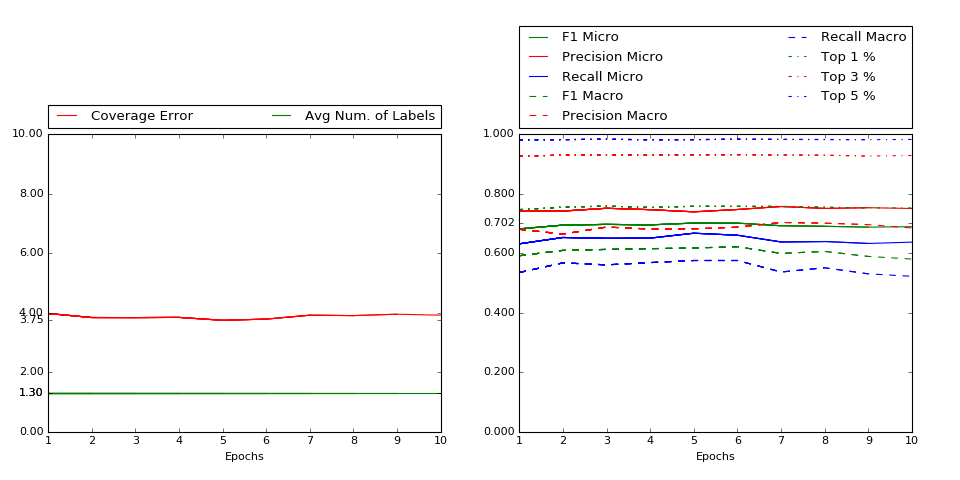

CPU times: user 20.7 s, sys: 2.73 s, total: 23.4 s
Wall time: 24 s

2017-01-01 19:36:06,187 : INFO : Getting Validation Embeddings
2017-01-01 19:36:06,189 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.849, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.698, F1 Macro: 0.401, Total Pos: 56,302


2017-01-01 19:36:06,933 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.983, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.927, Top 5: 0.982, 
		 F1 Micro: 0.683, F1 Macro: 0.592, Total Pos: 13,725
CPU times: user 15.2 s, sys: 2.56 s, total: 17.8 s
Wall time: 16.9 s


2017-01-01 19:36:27,894 : INFO : Getting Validation Embeddings
2017-01-01 19:36:27,897 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.692, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.711, F1 Macro: 0.592, Total Pos: 58,163


2017-01-01 19:36:28,681 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.847, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.695, F1 Macro: 0.610, Total Pos: 14,172
CPU times: user 15.5 s, sys: 2.37 s, total: 17.9 s
Wall time: 16.9 s


2017-01-01 19:36:50,009 : INFO : Getting Validation Embeddings
2017-01-01 19:36:50,011 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.732, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.710, F1 Macro: 0.610, Total Pos: 57,021


2017-01-01 19:36:50,748 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.845, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.698, F1 Macro: 0.614, Total Pos: 13,933
CPU times: user 22 s, sys: 2.59 s, total: 24.6 s
Wall time: 23 s


2017-01-01 19:37:18,038 : INFO : Getting Validation Embeddings
2017-01-01 19:37:18,039 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.742, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.709, F1 Macro: 0.614, Total Pos: 56,869


2017-01-01 19:37:18,733 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.851, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.696, F1 Macro: 0.616, Total Pos: 14,036
CPU times: user 17.6 s, sys: 2.35 s, total: 19.9 s


2017-01-01 19:37:41,651 : INFO : Getting Validation Embeddings
2017-01-01 19:37:41,653 : INFO : ===== Loading validation vectors


Wall time: 18.9 s
** Training Metrics: Cov Err: 3.681, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.712, F1 Macro: 0.616, Total Pos: 58,141


2017-01-01 19:37:42,280 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.754, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.702, F1 Macro: 0.618, Total Pos: 14,533
CPU times: user 17.9 s, sys: 2.58 s, total: 20.5 s
Wall time: 19.3 s


2017-01-01 19:38:05,019 : INFO : Getting Validation Embeddings
2017-01-01 19:38:05,020 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.769, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.707, F1 Macro: 0.618, Total Pos: 56,383


2017-01-01 19:38:05,661 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.794, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.702, F1 Macro: 0.622, Total Pos: 14,235
CPU times: user 15.9 s, sys: 2.52 s, total: 18.4 s
Wall time: 17.4 s


2017-01-01 19:38:26,565 : INFO : Getting Validation Embeddings
2017-01-01 19:38:26,566 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.919, Avg Labels: 1.290, 
		 Top 1: 0.764, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.622, Total Pos: 53,171


2017-01-01 19:38:27,189 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.925, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.693, F1 Macro: 0.600, Total Pos: 13,565
CPU times: user 19.6 s, sys: 2.57 s, total: 22.1 s
Wall time: 20.9 s


2017-01-01 19:38:51,690 : INFO : Getting Validation Embeddings
2017-01-01 19:38:51,692 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.917, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.600, Total Pos: 53,598


2017-01-01 19:38:52,342 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.911, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.691, F1 Macro: 0.607, Total Pos: 13,713
CPU times: user 14.6 s, sys: 2.22 s, total: 16.8 s
Wall time: 15.9 s


2017-01-01 19:39:11,784 : INFO : Getting Validation Embeddings
2017-01-01 19:39:11,785 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.989, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.689, F1 Macro: 0.607, Total Pos: 52,916


2017-01-01 19:39:12,357 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.959, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.927, Top 5: 0.982, 
		 F1 Micro: 0.688, F1 Macro: 0.590, Total Pos: 13,529
CPU times: user 19.6 s, sys: 2.55 s, total: 22.1 s
Wall time: 20.9 s


2017-01-01 19:39:36,798 : INFO : Getting Validation Embeddings
2017-01-01 19:39:36,800 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.963, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.689, F1 Macro: 0.590, Total Pos: 53,681


2017-01-01 19:39:37,510 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.925, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.690, F1 Macro: 0.581, Total Pos: 13,673
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_linear (Dense)     (None, 200

<IPython.core.display.Javascript object>


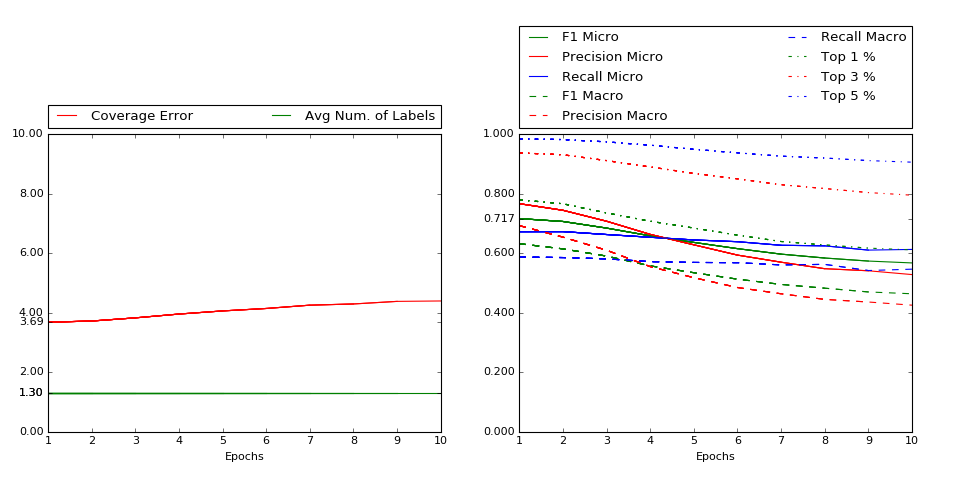

CPU times: user 29.2 s, sys: 18.5 s, total: 47.8 s
Wall time: 1min 37s


2017-01-01 19:41:21,087 : INFO : Getting Validation Embeddings
2017-01-01 19:41:21,090 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.563, Avg Labels: 1.290, 
		 Top 1: 0.802, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.740, F1 Macro: 0.581, Total Pos: 55,287


2017-01-01 19:41:21,864 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.689, Avg Labels: 1.300, 
		 Top 1: 0.780, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.717, F1 Macro: 0.633, Total Pos: 14,123
CPU times: user 28 s, sys: 18.8 s, total: 46.9 s
Wall time: 1min 37s


2017-01-01 19:43:03,747 : INFO : Getting Validation Embeddings
2017-01-01 19:43:03,748 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.239, Avg Labels: 1.290, 
		 Top 1: 0.838, Top 3: 0.958, Top 5: 0.991, 
		 F1 Micro: 0.781, F1 Macro: 0.633, Total Pos: 56,774


2017-01-01 19:43:04,361 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.729, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.707, F1 Macro: 0.615, Total Pos: 14,548
CPU times: user 27.3 s, sys: 17.7 s, total: 45 s
Wall time: 1min 35s


2017-01-01 19:44:44,415 : INFO : Getting Validation Embeddings
2017-01-01 19:44:44,417 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.960, Avg Labels: 1.290, 
		 Top 1: 0.865, Top 3: 0.964, Top 5: 0.993, 
		 F1 Micro: 0.814, F1 Macro: 0.615, Total Pos: 58,176


2017-01-01 19:44:45,165 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.835, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.912, Top 5: 0.975, 
		 F1 Micro: 0.685, F1 Macro: 0.591, Total Pos: 15,080
CPU times: user 28.4 s, sys: 18.4 s, total: 46.8 s


2017-01-01 19:46:26,818 : INFO : Getting Validation Embeddings
2017-01-01 19:46:26,820 : INFO : ===== Loading validation vectors


Wall time: 1min 37s
** Training Metrics: Cov Err: 2.711, Avg Labels: 1.290, 
		 Top 1: 0.888, Top 3: 0.970, Top 5: 0.994, 
		 F1 Micro: 0.842, F1 Macro: 0.591, Total Pos: 59,719


2017-01-01 19:46:27,496 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.963, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.891, Top 5: 0.964, 
		 F1 Micro: 0.659, F1 Macro: 0.558, Total Pos: 15,862
CPU times: user 28.2 s, sys: 19 s, total: 47.1 s


2017-01-01 19:48:09,297 : INFO : Getting Validation Embeddings
2017-01-01 19:48:09,299 : INFO : ===== Loading validation vectors


Wall time: 1min 37s
** Training Metrics: Cov Err: 2.546, Avg Labels: 1.290, 
		 Top 1: 0.906, Top 3: 0.975, Top 5: 0.995, 
		 F1 Micro: 0.863, F1 Macro: 0.558, Total Pos: 59,847


2017-01-01 19:48:10,018 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.068, Avg Labels: 1.300, 
		 Top 1: 0.685, Top 3: 0.869, Top 5: 0.950, 
		 F1 Micro: 0.637, F1 Macro: 0.535, Total Pos: 16,514
CPU times: user 27.4 s, sys: 17.9 s, total: 45.3 s
Wall time: 1min 33s


2017-01-01 19:49:48,233 : INFO : Getting Validation Embeddings
2017-01-01 19:49:48,234 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.336, Avg Labels: 1.290, 
		 Top 1: 0.920, Top 3: 0.979, Top 5: 0.996, 
		 F1 Micro: 0.884, F1 Macro: 0.535, Total Pos: 61,327


2017-01-01 19:49:48,951 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.151, Avg Labels: 1.300, 
		 Top 1: 0.662, Top 3: 0.851, Top 5: 0.938, 
		 F1 Micro: 0.616, F1 Macro: 0.514, Total Pos: 17,315
CPU times: user 27.1 s, sys: 18.1 s, total: 45.1 s
Wall time: 1min 33s


2017-01-01 19:51:26,527 : INFO : Getting Validation Embeddings
2017-01-01 19:51:26,530 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.236, Avg Labels: 1.290, 
		 Top 1: 0.932, Top 3: 0.981, Top 5: 0.996, 
		 F1 Micro: 0.898, F1 Macro: 0.514, Total Pos: 61,159


2017-01-01 19:51:27,190 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.262, Avg Labels: 1.300, 
		 Top 1: 0.640, Top 3: 0.831, Top 5: 0.927, 
		 F1 Micro: 0.598, F1 Macro: 0.496, Total Pos: 17,699
CPU times: user 27.5 s, sys: 17.8 s, total: 45.3 s
Wall time: 1min 33s

2017-01-01 19:53:05,220 : INFO : Getting Validation Embeddings
2017-01-01 19:53:05,222 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 2.095, Avg Labels: 1.290, 
		 Top 1: 0.941, Top 3: 0.983, Top 5: 0.997, 
		 F1 Micro: 0.910, F1 Macro: 0.496, Total Pos: 62,255


2017-01-01 19:53:05,829 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.302, Avg Labels: 1.300, 
		 Top 1: 0.629, Top 3: 0.818, Top 5: 0.921, 
		 F1 Micro: 0.585, F1 Macro: 0.483, Total Pos: 18,350
CPU times: user 26.8 s, sys: 17.9 s, total: 44.8 s
Wall time: 1min 33s


2017-01-01 19:54:42,893 : INFO : Getting Validation Embeddings
2017-01-01 19:54:42,895 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.068, Avg Labels: 1.290, 
		 Top 1: 0.947, Top 3: 0.985, Top 5: 0.997, 
		 F1 Micro: 0.918, F1 Macro: 0.483, Total Pos: 61,303


2017-01-01 19:54:43,608 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.389, Avg Labels: 1.300, 
		 Top 1: 0.618, Top 3: 0.805, Top 5: 0.912, 
		 F1 Micro: 0.574, F1 Macro: 0.471, Total Pos: 18,159
CPU times: user 27.3 s, sys: 17.9 s, total: 45.2 s
Wall time: 1min 33s


2017-01-01 19:56:19,908 : INFO : Getting Validation Embeddings
2017-01-01 19:56:19,910 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.939, Avg Labels: 1.290, 
		 Top 1: 0.953, Top 3: 0.986, Top 5: 0.997, 
		 F1 Micro: 0.928, F1 Macro: 0.471, Total Pos: 62,483


2017-01-01 19:56:20,533 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.403, Avg Labels: 1.300, 
		 Top 1: 0.612, Top 3: 0.796, Top 5: 0.907, 
		 F1 Micro: 0.568, F1 Macro: 0.464, Total Pos: 18,668
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_98 (Dropout)             (None, 500)   

<IPython.core.display.Javascript object>


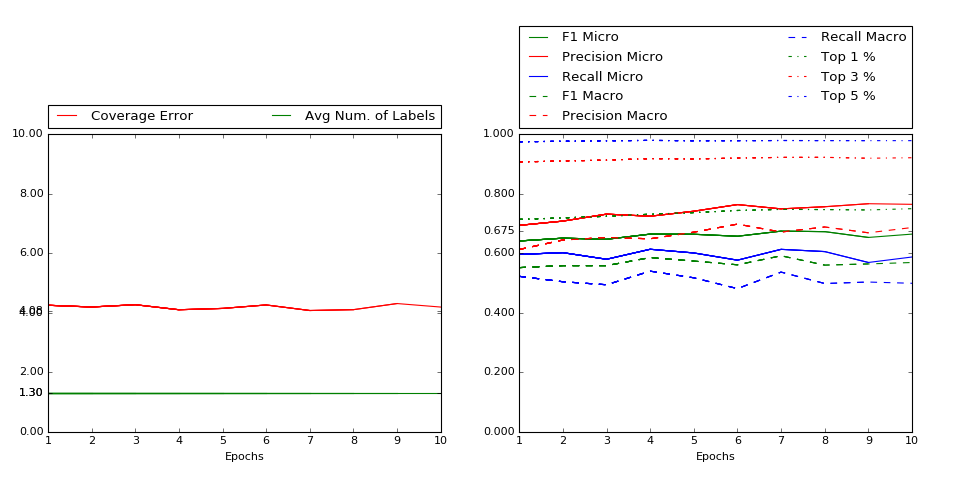

CPU times: user 33.2 s, sys: 26 s, total: 59.2 s
Wall time: 2min


2017-01-01 19:58:27,996 : INFO : Getting Validation Embeddings
2017-01-01 19:58:27,999 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.411, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.978, 
		 F1 Micro: 0.639, F1 Macro: 0.464, Total Pos: 51,160


2017-01-01 19:58:28,789 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.259, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.907, Top 5: 0.975, 
		 F1 Micro: 0.642, F1 Macro: 0.552, Total Pos: 13,832
CPU times: user 31.7 s, sys: 25.2 s, total: 56.9 s
Wall time: 1min 57s


2017-01-01 20:00:30,370 : INFO : Getting Validation Embeddings
2017-01-01 20:00:30,372 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.365, Avg Labels: 1.290, 
		 Top 1: 0.720, Top 3: 0.917, Top 5: 0.980, 
		 F1 Micro: 0.646, F1 Macro: 0.552, Total Pos: 50,677


2017-01-01 20:00:31,083 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.201, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.911, Top 5: 0.977, 
		 F1 Micro: 0.651, F1 Macro: 0.559, Total Pos: 13,687
CPU times: user 31.1 s, sys: 25.2 s, total: 56.3 s
Wall time: 1min 56s


2017-01-01 20:02:31,533 : INFO : Getting Validation Embeddings
2017-01-01 20:02:31,536 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.228, Avg Labels: 1.290, 
		 Top 1: 0.737, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.660, F1 Macro: 0.559, Total Pos: 51,138


2017-01-01 20:02:32,335 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.278, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.648, F1 Macro: 0.559, Total Pos: 12,762
CPU times: user 30.2 s, sys: 25.1 s, total: 55.2 s
Wall time: 1min 55s


2017-01-01 20:04:31,462 : INFO : Getting Validation Embeddings
2017-01-01 20:04:31,463 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.992, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.681, F1 Macro: 0.559, Total Pos: 54,841


2017-01-01 20:04:32,051 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.109, Avg Labels: 1.300, 
		 Top 1: 0.732, Top 3: 0.919, Top 5: 0.980, 
		 F1 Micro: 0.665, F1 Macro: 0.586, Total Pos: 13,632
CPU times: user 30.7 s, sys: 25 s, total: 55.7 s
Wall time: 1min 56s


2017-01-01 20:06:32,599 : INFO : Getting Validation Embeddings
2017-01-01 20:06:32,600 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.992, Avg Labels: 1.290, 
		 Top 1: 0.753, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.684, F1 Macro: 0.586, Total Pos: 53,951


2017-01-01 20:06:33,418 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.153, Avg Labels: 1.300, 
		 Top 1: 0.737, Top 3: 0.917, Top 5: 0.979, 
		 F1 Micro: 0.664, F1 Macro: 0.574, Total Pos: 13,053
CPU times: user 29.9 s, sys: 24.8 s, total: 54.8 s
Wall time: 1min 53s

2017-01-01 20:08:31,734 : INFO : Getting Validation Embeddings
2017-01-01 20:08:31,736 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.091, Avg Labels: 1.290, 
		 Top 1: 0.760, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.682, F1 Macro: 0.574, Total Pos: 50,287


2017-01-01 20:08:32,345 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.269, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.921, Top 5: 0.979, 
		 F1 Micro: 0.658, F1 Macro: 0.562, Total Pos: 12,162
CPU times: user 31.1 s, sys: 25.6 s, total: 56.8 s
Wall time: 1min 57s


2017-01-01 20:10:33,764 : INFO : Getting Validation Embeddings
2017-01-01 20:10:33,766 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.865, Avg Labels: 1.290, 
		 Top 1: 0.765, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.700, F1 Macro: 0.562, Total Pos: 54,582


2017-01-01 20:10:34,356 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.082, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.923, Top 5: 0.979, 
		 F1 Micro: 0.675, F1 Macro: 0.592, Total Pos: 13,176
CPU times: user 30.5 s, sys: 25.4 s, total: 55.9 s
Wall time: 1min 56s


2017-01-01 20:12:34,993 : INFO : Getting Validation Embeddings
2017-01-01 20:12:34,995 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.830, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.702, F1 Macro: 0.592, Total Pos: 55,073


2017-01-01 20:12:35,685 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.111, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.923, Top 5: 0.979, 
		 F1 Micro: 0.673, F1 Macro: 0.561, Total Pos: 12,891
CPU times: user 31.3 s, sys: 24.6 s, total: 55.9 s
Wall time: 1min 55s


2017-01-01 20:14:36,139 : INFO : Getting Validation Embeddings
2017-01-01 20:14:36,142 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.985, Avg Labels: 1.290, 
		 Top 1: 0.774, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.697, F1 Macro: 0.561, Total Pos: 50,698


2017-01-01 20:14:36,966 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.316, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.920, Top 5: 0.979, 
		 F1 Micro: 0.654, F1 Macro: 0.565, Total Pos: 11,953
CPU times: user 30.5 s, sys: 24.8 s, total: 55.3 s
Wall time: 1min 54s


2017-01-01 20:16:36,427 : INFO : Getting Validation Embeddings
2017-01-01 20:16:36,429 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.822, Avg Labels: 1.290, 
		 Top 1: 0.777, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.708, F1 Macro: 0.565, Total Pos: 53,732


2017-01-01 20:16:37,177 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.198, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.665, F1 Macro: 0.570, Total Pos: 12,372
========== 1st Layer Size: 50, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_99 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 50)        

<IPython.core.display.Javascript object>


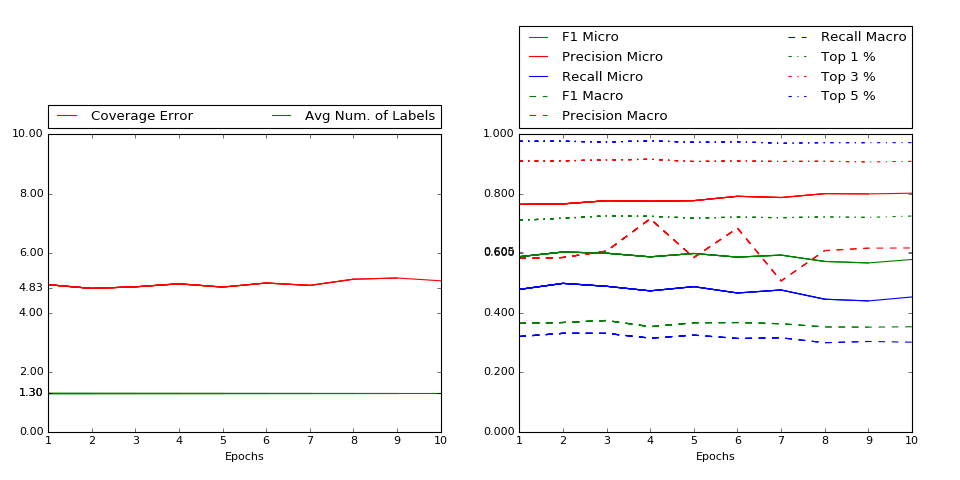

CPU times: user 21.8 s, sys: 2.97 s, total: 24.7 s
Wall time: 25 s


2017-01-01 20:17:08,901 : INFO : Getting Validation Embeddings
2017-01-01 20:17:08,904 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.161, Avg Labels: 1.290, 
		 Top 1: 0.702, Top 3: 0.903, Top 5: 0.970, 
		 F1 Micro: 0.565, F1 Macro: 0.570, Total Pos: 37,684


2017-01-01 20:17:09,543 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.950, Avg Labels: 1.300, 
		 Top 1: 0.711, Top 3: 0.910, Top 5: 0.977, 
		 F1 Micro: 0.589, F1 Macro: 0.365, Total Pos: 10,083
CPU times: user 16.7 s, sys: 2.36 s, total: 19.1 s
Wall time: 18 s


2017-01-01 20:17:30,582 : INFO : Getting Validation Embeddings
2017-01-01 20:17:30,583 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.032, Avg Labels: 1.290, 
		 Top 1: 0.700, Top 3: 0.900, Top 5: 0.971, 
		 F1 Micro: 0.581, F1 Macro: 0.365, Total Pos: 39,665


2017-01-01 20:17:31,195 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.826, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.911, Top 5: 0.977, 
		 F1 Micro: 0.605, F1 Macro: 0.368, Total Pos: 10,488
CPU times: user 20.8 s, sys: 2.48 s, total: 23.3 s
Wall time: 21.9 s


2017-01-01 20:17:56,528 : INFO : Getting Validation Embeddings
2017-01-01 20:17:56,529 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.121, Avg Labels: 1.290, 
		 Top 1: 0.705, Top 3: 0.905, Top 5: 0.968, 
		 F1 Micro: 0.572, F1 Macro: 0.368, Total Pos: 37,708


2017-01-01 20:17:57,112 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.878, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.914, Top 5: 0.975, 
		 F1 Micro: 0.601, F1 Macro: 0.375, Total Pos: 10,140
CPU times: user 14.6 s, sys: 2.34 s, total: 16.9 s
Wall time: 16 s


2017-01-01 20:18:16,531 : INFO : Getting Validation Embeddings
2017-01-01 20:18:16,534 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.166, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.904, Top 5: 0.972, 
		 F1 Micro: 0.567, F1 Macro: 0.375, Total Pos: 37,398


2017-01-01 20:18:17,140 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.980, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.916, Top 5: 0.978, 
		 F1 Micro: 0.589, F1 Macro: 0.354, Total Pos: 9,844
CPU times: user 18.2 s, sys: 2.37 s, total: 20.6 s
Wall time: 19.5 s

2017-01-01 20:18:41,121 : INFO : Getting Validation Embeddings
2017-01-01 20:18:41,123 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.111, Avg Labels: 1.290, 
		 Top 1: 0.700, Top 3: 0.898, Top 5: 0.968, 
		 F1 Micro: 0.573, F1 Macro: 0.354, Total Pos: 37,670


2017-01-01 20:18:41,698 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.870, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.909, Top 5: 0.973, 
		 F1 Micro: 0.600, F1 Macro: 0.367, Total Pos: 10,113
CPU times: user 20.1 s, sys: 2.44 s, total: 22.6 s
Wall time: 21.3 s


2017-01-01 20:19:07,239 : INFO : Getting Validation Embeddings
2017-01-01 20:19:07,241 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.223, Avg Labels: 1.290, 
		 Top 1: 0.703, Top 3: 0.898, Top 5: 0.968, 
		 F1 Micro: 0.562, F1 Macro: 0.367, Total Pos: 35,647


2017-01-01 20:19:07,865 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.006, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.911, Top 5: 0.975, 
		 F1 Micro: 0.588, F1 Macro: 0.368, Total Pos: 9,493
CPU times: user 20.9 s, sys: 2.33 s, total: 23.2 s
Wall time: 21.9 s


2017-01-01 20:19:33,070 : INFO : Getting Validation Embeddings
2017-01-01 20:19:33,071 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.151, Avg Labels: 1.290, 
		 Top 1: 0.701, Top 3: 0.897, Top 5: 0.963, 
		 F1 Micro: 0.566, F1 Macro: 0.368, Total Pos: 36,191


2017-01-01 20:19:33,656 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.926, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.909, Top 5: 0.970, 
		 F1 Micro: 0.594, F1 Macro: 0.364, Total Pos: 9,749
CPU times: user 22.1 s, sys: 2.8 s, total: 24.9 s
Wall time: 23.3 s


2017-01-01 20:20:01,145 : INFO : Getting Validation Embeddings
2017-01-01 20:20:01,147 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.379, Avg Labels: 1.290, 
		 Top 1: 0.701, Top 3: 0.890, Top 5: 0.966, 
		 F1 Micro: 0.542, F1 Macro: 0.364, Total Pos: 33,215


2017-01-01 20:20:09,172 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.134, Avg Labels: 1.300, 
		 Top 1: 0.723, Top 3: 0.910, Top 5: 0.972, 
		 F1 Micro: 0.573, F1 Macro: 0.353, Total Pos: 8,967
CPU times: user 23 s, sys: 2.49 s, total: 25.5 s
Wall time: 24 s


2017-01-01 20:20:37,717 : INFO : Getting Validation Embeddings
2017-01-01 20:20:37,719 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.413, Avg Labels: 1.290, 
		 Top 1: 0.711, Top 3: 0.900, Top 5: 0.966, 
		 F1 Micro: 0.540, F1 Macro: 0.353, Total Pos: 32,386


2017-01-01 20:20:38,517 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.175, Avg Labels: 1.300, 
		 Top 1: 0.721, Top 3: 0.908, Top 5: 0.972, 
		 F1 Micro: 0.568, F1 Macro: 0.352, Total Pos: 8,863
CPU times: user 21.7 s, sys: 2.7 s, total: 24.4 s
Wall time: 23 s


2017-01-01 20:21:06,213 : INFO : Getting Validation Embeddings
2017-01-01 20:21:06,215 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.363, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.894, Top 5: 0.965, 
		 F1 Micro: 0.545, F1 Macro: 0.352, Total Pos: 33,231


2017-01-01 20:21:06,932 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.080, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.909, Top 5: 0.972, 
		 F1 Micro: 0.580, F1 Macro: 0.354, Total Pos: 9,101
========== 1st Layer Size: 50, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 200, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 200)

<IPython.core.display.Javascript object>


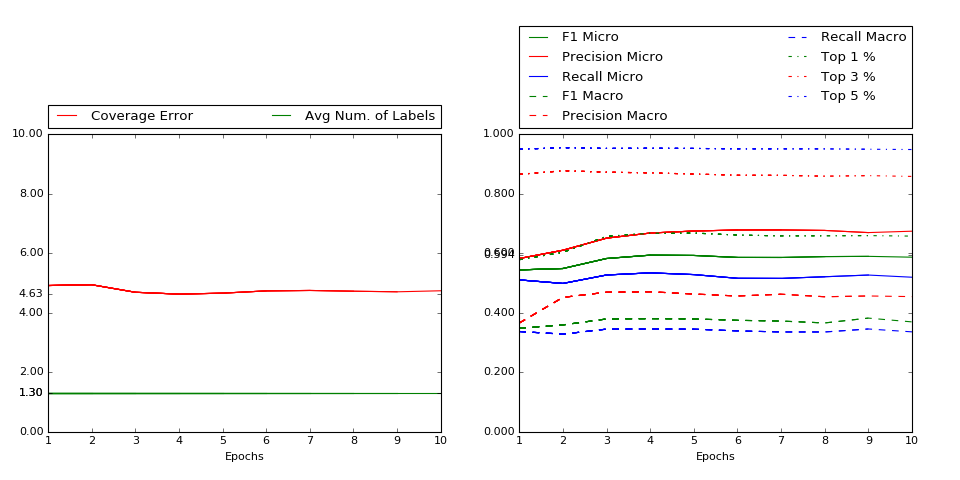

CPU times: user 19.6 s, sys: 3.68 s, total: 23.3 s
Wall time: 24.3 s


2017-01-01 20:21:38,145 : INFO : Getting Validation Embeddings
2017-01-01 20:21:38,148 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.998, Avg Labels: 1.290, 
		 Top 1: 0.580, Top 3: 0.870, Top 5: 0.953, 
		 F1 Micro: 0.540, F1 Macro: 0.354, Total Pos: 54,698


2017-01-01 20:21:38,918 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.922, Avg Labels: 1.300, 
		 Top 1: 0.579, Top 3: 0.866, Top 5: 0.950, 
		 F1 Micro: 0.545, F1 Macro: 0.349, Total Pos: 14,112
CPU times: user 18.4 s, sys: 3.3 s, total: 21.7 s
Wall time: 20.4 s


2017-01-01 20:22:02,632 : INFO : Getting Validation Embeddings
2017-01-01 20:22:02,633 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.047, Avg Labels: 1.290, 
		 Top 1: 0.607, Top 3: 0.881, Top 5: 0.953, 
		 F1 Micro: 0.541, F1 Macro: 0.349, Total Pos: 49,942


2017-01-01 20:22:03,243 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.949, Avg Labels: 1.300, 
		 Top 1: 0.604, Top 3: 0.878, Top 5: 0.955, 
		 F1 Micro: 0.549, F1 Macro: 0.360, Total Pos: 13,156
CPU times: user 21.8 s, sys: 3.36 s, total: 25.2 s


2017-01-01 20:22:29,730 : INFO : Getting Validation Embeddings
2017-01-01 20:22:29,731 : INFO : ===== Loading validation vectors


Wall time: 23.5 s
** Training Metrics: Cov Err: 4.775, Avg Labels: 1.290, 
		 Top 1: 0.669, Top 3: 0.882, Top 5: 0.954, 
		 F1 Micro: 0.581, F1 Macro: 0.360, Total Pos: 48,815


2017-01-01 20:22:30,317 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.696, Avg Labels: 1.300, 
		 Top 1: 0.657, Top 3: 0.873, Top 5: 0.953, 
		 F1 Micro: 0.583, F1 Macro: 0.380, Total Pos: 13,036
CPU times: user 18.5 s, sys: 3.08 s, total: 21.5 s
Wall time: 20.2 s


2017-01-01 20:22:54,026 : INFO : Getting Validation Embeddings
2017-01-01 20:22:54,027 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.652, Avg Labels: 1.290, 
		 Top 1: 0.686, Top 3: 0.885, Top 5: 0.956, 
		 F1 Micro: 0.600, F1 Macro: 0.380, Total Pos: 48,320


2017-01-01 20:22:54,635 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.633, Avg Labels: 1.300, 
		 Top 1: 0.668, Top 3: 0.871, Top 5: 0.954, 
		 F1 Micro: 0.594, F1 Macro: 0.381, Total Pos: 12,876
CPU times: user 18.5 s, sys: 3.19 s, total: 21.7 s
Wall time: 20.3 s


2017-01-01 20:23:18,176 : INFO : Getting Validation Embeddings
2017-01-01 20:23:18,178 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.639, Avg Labels: 1.290, 
		 Top 1: 0.696, Top 3: 0.887, Top 5: 0.957, 
		 F1 Micro: 0.607, F1 Macro: 0.381, Total Pos: 46,869


2017-01-01 20:23:18,804 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.666, Avg Labels: 1.300, 
		 Top 1: 0.669, Top 3: 0.867, Top 5: 0.953, 
		 F1 Micro: 0.593, F1 Macro: 0.380, Total Pos: 12,607
CPU times: user 18.3 s, sys: 2.81 s, total: 21.1 s
Wall time: 19.9 s

2017-01-01 20:23:42,133 : INFO : Getting Validation Embeddings
2017-01-01 20:23:42,134 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.677, Avg Labels: 1.290, 
		 Top 1: 0.700, Top 3: 0.887, Top 5: 0.958, 
		 F1 Micro: 0.607, F1 Macro: 0.380, Total Pos: 45,414


2017-01-01 20:23:42,762 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.742, Avg Labels: 1.300, 
		 Top 1: 0.662, Top 3: 0.863, Top 5: 0.951, 
		 F1 Micro: 0.587, F1 Macro: 0.375, Total Pos: 12,247
CPU times: user 20.6 s, sys: 3.21 s, total: 23.8 s
Wall time: 22.3 s


2017-01-01 20:24:08,195 : INFO : Getting Validation Embeddings
2017-01-01 20:24:08,196 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.613, Avg Labels: 1.290, 
		 Top 1: 0.703, Top 3: 0.888, Top 5: 0.958, 
		 F1 Micro: 0.615, F1 Macro: 0.375, Total Pos: 46,088


2017-01-01 20:24:08,809 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.756, Avg Labels: 1.300, 
		 Top 1: 0.659, Top 3: 0.863, Top 5: 0.951, 
		 F1 Micro: 0.586, F1 Macro: 0.373, Total Pos: 12,234
CPU times: user 18.9 s, sys: 2.93 s, total: 21.8 s
Wall time: 20.4 s


2017-01-01 20:24:33,623 : INFO : Getting Validation Embeddings
2017-01-01 20:24:33,626 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.555, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.888, Top 5: 0.959, 
		 F1 Micro: 0.619, F1 Macro: 0.373, Total Pos: 47,232


2017-01-01 20:24:34,354 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.731, Avg Labels: 1.300, 
		 Top 1: 0.659, Top 3: 0.860, Top 5: 0.951, 
		 F1 Micro: 0.589, F1 Macro: 0.366, Total Pos: 12,398
CPU times: user 15.5 s, sys: 3.17 s, total: 18.6 s
Wall time: 17.6 s


2017-01-01 20:24:56,197 : INFO : Getting Validation Embeddings
2017-01-01 20:24:56,198 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.489, Avg Labels: 1.290, 
		 Top 1: 0.707, Top 3: 0.888, Top 5: 0.958, 
		 F1 Micro: 0.627, F1 Macro: 0.366, Total Pos: 48,240


2017-01-01 20:24:56,795 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.711, Avg Labels: 1.300, 
		 Top 1: 0.660, Top 3: 0.861, Top 5: 0.950, 
		 F1 Micro: 0.590, F1 Macro: 0.383, Total Pos: 12,669
CPU times: user 19.6 s, sys: 3.14 s, total: 22.8 s
Wall time: 21.4 s


2017-01-01 20:25:22,047 : INFO : Getting Validation Embeddings
2017-01-01 20:25:22,050 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.505, Avg Labels: 1.290, 
		 Top 1: 0.709, Top 3: 0.889, Top 5: 0.959, 
		 F1 Micro: 0.626, F1 Macro: 0.383, Total Pos: 47,659


2017-01-01 20:25:22,803 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.746, Avg Labels: 1.300, 
		 Top 1: 0.658, Top 3: 0.859, Top 5: 0.949, 
		 F1 Micro: 0.587, F1 Macro: 0.370, Total Pos: 12,406
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_101 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)  

<IPython.core.display.Javascript object>


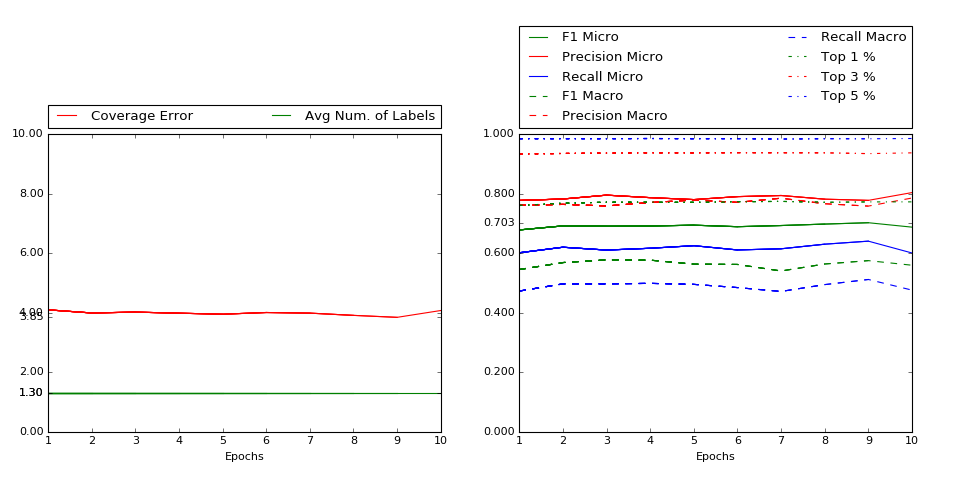

CPU times: user 27.4 s, sys: 10.2 s, total: 37.7 s
Wall time: 1min 16s


2017-01-01 20:26:47,016 : INFO : Getting Validation Embeddings
2017-01-01 20:26:47,018 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.262, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.662, F1 Macro: 0.370, Total Pos: 48,919


2017-01-01 20:26:47,818 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.105, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.934, Top 5: 0.986, 
		 F1 Micro: 0.679, F1 Macro: 0.546, Total Pos: 12,458
CPU times: user 25.8 s, sys: 10.3 s, total: 36.1 s
Wall time: 1min 14s


2017-01-01 20:28:06,729 : INFO : Getting Validation Embeddings
2017-01-01 20:28:06,731 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.186, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.677, F1 Macro: 0.546, Total Pos: 48,436


2017-01-01 20:28:07,417 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.000, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.693, F1 Macro: 0.569, Total Pos: 12,765
CPU times: user 26.7 s, sys: 10.4 s, total: 37.1 s


2017-01-01 20:29:27,831 : INFO : Getting Validation Embeddings
2017-01-01 20:29:27,832 : INFO : ===== Loading validation vectors


Wall time: 1min 15s
** Training Metrics: Cov Err: 4.297, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.666, F1 Macro: 0.569, Total Pos: 46,030


2017-01-01 20:29:28,522 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.028, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.692, F1 Macro: 0.578, Total Pos: 12,363
CPU times: user 25.8 s, sys: 10.7 s, total: 36.5 s
Wall time: 1min 14s


2017-01-01 20:30:48,778 : INFO : Getting Validation Embeddings
2017-01-01 20:30:48,785 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.226, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.671, F1 Macro: 0.578, Total Pos: 47,649


2017-01-01 20:30:49,405 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.993, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.692, F1 Macro: 0.577, Total Pos: 12,620
CPU times: user 26.2 s, sys: 10 s, total: 36.2 s
Wall time: 1min 13s


2017-01-01 20:32:07,300 : INFO : Getting Validation Embeddings
2017-01-01 20:32:07,302 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.272, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.664, F1 Macro: 0.577, Total Pos: 47,890


2017-01-01 20:32:07,996 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.958, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.695, F1 Macro: 0.564, Total Pos: 12,903
CPU times: user 25.3 s, sys: 10.1 s, total: 35.5 s
Wall time: 1min 13s

2017-01-01 20:33:25,287 : INFO : Getting Validation Embeddings
2017-01-01 20:33:25,288 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.346, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.656, F1 Macro: 0.564, Total Pos: 46,820


2017-01-01 20:33:25,912 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.015, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.690, F1 Macro: 0.563, Total Pos: 12,450
CPU times: user 25.9 s, sys: 10.4 s, total: 36.2 s
Wall time: 1min 14s


2017-01-01 20:34:45,200 : INFO : Getting Validation Embeddings
2017-01-01 20:34:45,202 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.364, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.929, Top 5: 0.980, 
		 F1 Micro: 0.656, F1 Macro: 0.563, Total Pos: 46,167


2017-01-01 20:34:45,971 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.995, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.938, Top 5: 0.984, 
		 F1 Micro: 0.694, F1 Macro: 0.541, Total Pos: 12,469
CPU times: user 24.8 s, sys: 10.2 s, total: 35 s
Wall time: 1min 10s


2017-01-01 20:36:00,949 : INFO : Getting Validation Embeddings
2017-01-01 20:36:00,950 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.341, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.658, F1 Macro: 0.541, Total Pos: 47,002


2017-01-01 20:36:01,606 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.919, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.699, F1 Macro: 0.565, Total Pos: 12,983
CPU times: user 25.3 s, sys: 10.4 s, total: 35.7 s
Wall time: 1min 13s


2017-01-01 20:37:19,577 : INFO : Getting Validation Embeddings
2017-01-01 20:37:19,579 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.290, Avg Labels: 1.290, 
		 Top 1: 0.748, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.659, F1 Macro: 0.565, Total Pos: 48,512


2017-01-01 20:37:20,389 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.853, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.703, F1 Macro: 0.576, Total Pos: 13,261
CPU times: user 26.8 s, sys: 10.5 s, total: 37.3 s
Wall time: 1min 16s


2017-01-01 20:38:41,319 : INFO : Getting Validation Embeddings
2017-01-01 20:38:41,321 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.515, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.644, F1 Macro: 0.576, Total Pos: 42,994


2017-01-01 20:38:42,003 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.082, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.688, F1 Macro: 0.560, Total Pos: 12,035
========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_102 (Dropout)            (None, 200)  

<IPython.core.display.Javascript object>


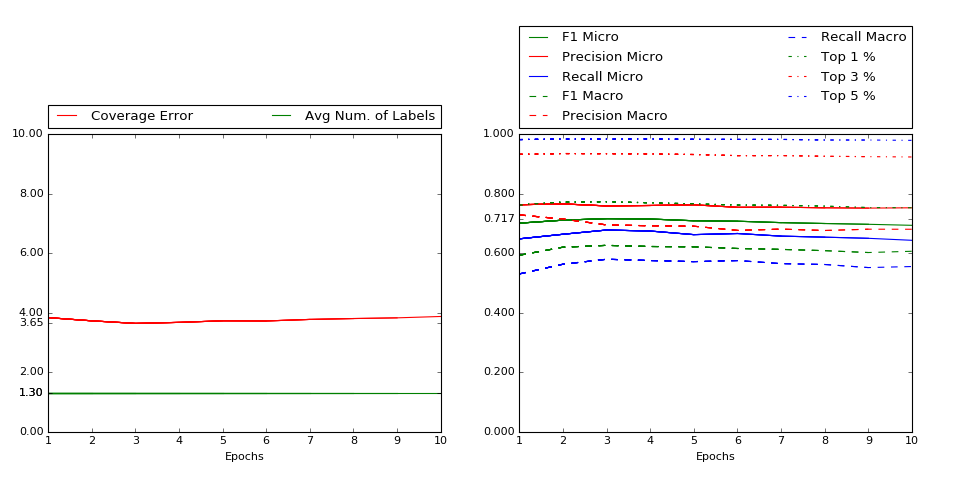

CPU times: user 23.4 s, sys: 4.12 s, total: 27.5 s
Wall time: 27.5 s


2017-01-01 20:39:14,510 : INFO : Getting Validation Embeddings
2017-01-01 20:39:14,512 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.799, Avg Labels: 1.290, 
		 Top 1: 0.772, Top 3: 0.938, Top 5: 0.984, 
		 F1 Micro: 0.709, F1 Macro: 0.560, Total Pos: 54,474


2017-01-01 20:39:15,092 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.844, Avg Labels: 1.300, 
		 Top 1: 0.763, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.702, F1 Macro: 0.594, Total Pos: 13,679
CPU times: user 19.4 s, sys: 3.4 s, total: 22.8 s


2017-01-01 20:39:40,722 : INFO : Getting Validation Embeddings
2017-01-01 20:39:40,724 : INFO : ===== Loading validation vectors


Wall time: 21.6 s
** Training Metrics: Cov Err: 3.587, Avg Labels: 1.290, 
		 Top 1: 0.791, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.732, F1 Macro: 0.594, Total Pos: 55,990


2017-01-01 20:39:41,504 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.736, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.712, F1 Macro: 0.621, Total Pos: 13,953
CPU times: user 18.1 s, sys: 3.42 s, total: 21.5 s
Wall time: 20.4 s


2017-01-01 20:40:07,546 : INFO : Getting Validation Embeddings
2017-01-01 20:40:07,548 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.455, Avg Labels: 1.290, 
		 Top 1: 0.801, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.745, F1 Macro: 0.621, Total Pos: 57,554


2017-01-01 20:40:08,294 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.650, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.717, F1 Macro: 0.627, Total Pos: 14,380
CPU times: user 22.8 s, sys: 3.76 s, total: 26.5 s
Wall time: 24.9 s


2017-01-01 20:40:36,694 : INFO : Getting Validation Embeddings
2017-01-01 20:40:36,696 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.433, Avg Labels: 1.290, 
		 Top 1: 0.807, Top 3: 0.949, Top 5: 0.988, 
		 F1 Micro: 0.750, F1 Macro: 0.627, Total Pos: 57,147


2017-01-01 20:40:37,311 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.684, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.716, F1 Macro: 0.623, Total Pos: 14,281
CPU times: user 18.9 s, sys: 3.81 s, total: 22.7 s
Wall time: 21.4 s


2017-01-01 20:41:03,026 : INFO : Getting Validation Embeddings
2017-01-01 20:41:03,027 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.444, Avg Labels: 1.290, 
		 Top 1: 0.812, Top 3: 0.950, Top 5: 0.988, 
		 F1 Micro: 0.752, F1 Macro: 0.623, Total Pos: 55,877


2017-01-01 20:41:03,779 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.736, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.710, F1 Macro: 0.622, Total Pos: 13,983
CPU times: user 23.3 s, sys: 3.55 s, total: 26.9 s
Wall time: 25.2 s


2017-01-01 20:41:32,931 : INFO : Getting Validation Embeddings
2017-01-01 20:41:32,932 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.372, Avg Labels: 1.290, 
		 Top 1: 0.816, Top 3: 0.950, Top 5: 0.989, 
		 F1 Micro: 0.758, F1 Macro: 0.622, Total Pos: 56,871


2017-01-01 20:41:33,655 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.731, Avg Labels: 1.300, 
		 Top 1: 0.763, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.708, F1 Macro: 0.617, Total Pos: 14,220
CPU times: user 19.1 s, sys: 3.62 s, total: 22.7 s
Wall time: 21.4 s

2017-01-01 20:41:58,986 : INFO : Getting Validation Embeddings
2017-01-01 20:41:58,987 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.369, Avg Labels: 1.290, 
		 Top 1: 0.819, Top 3: 0.951, Top 5: 0.989, 
		 F1 Micro: 0.760, F1 Macro: 0.617, Total Pos: 56,290


2017-01-01 20:41:59,562 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.783, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.704, F1 Macro: 0.614, Total Pos: 14,024
CPU times: user 23.1 s, sys: 3.68 s, total: 26.8 s
Wall time: 25 s


2017-01-01 20:42:28,849 : INFO : Getting Validation Embeddings
2017-01-01 20:42:28,851 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.369, Avg Labels: 1.290, 
		 Top 1: 0.820, Top 3: 0.951, Top 5: 0.990, 
		 F1 Micro: 0.761, F1 Macro: 0.614, Total Pos: 56,125


2017-01-01 20:42:29,572 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.813, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.701, F1 Macro: 0.609, Total Pos: 13,988
CPU times: user 20.2 s, sys: 3.39 s, total: 23.6 s
Wall time: 22.3 s


2017-01-01 20:42:55,688 : INFO : Getting Validation Embeddings
2017-01-01 20:42:55,689 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.359, Avg Labels: 1.290, 
		 Top 1: 0.823, Top 3: 0.952, Top 5: 0.989, 
		 F1 Micro: 0.763, F1 Macro: 0.609, Total Pos: 55,958


2017-01-01 20:42:56,301 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.836, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.698, F1 Macro: 0.603, Total Pos: 13,924
CPU times: user 23.2 s, sys: 3.73 s, total: 26.9 s
Wall time: 25.2 s


2017-01-01 20:43:25,561 : INFO : Getting Validation Embeddings
2017-01-01 20:43:25,573 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.363, Avg Labels: 1.290, 
		 Top 1: 0.823, Top 3: 0.951, Top 5: 0.989, 
		 F1 Micro: 0.764, F1 Macro: 0.603, Total Pos: 55,852


2017-01-01 20:43:26,328 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.882, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.694, F1 Macro: 0.607, Total Pos: 13,762
========== 1st Layer Size: 500, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 1000, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_103 (Dropout)            (None, 500

<IPython.core.display.Javascript object>


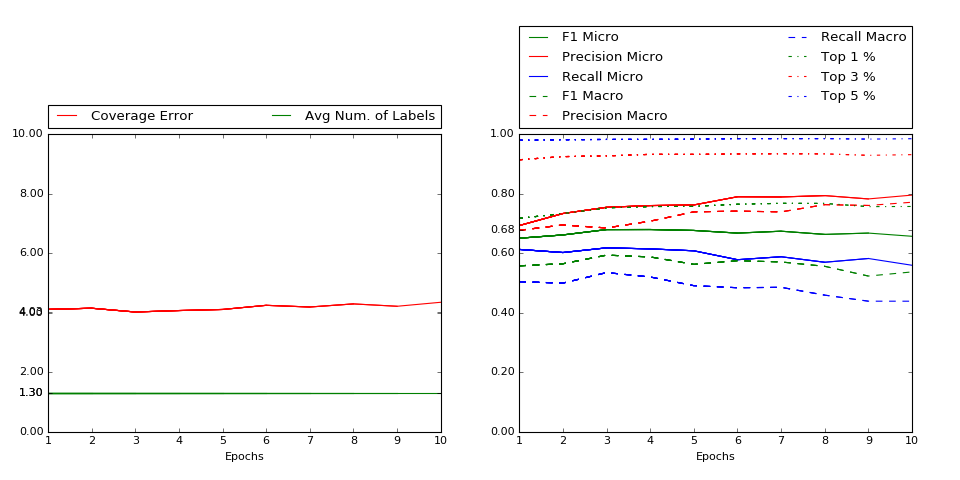

CPU times: user 34.4 s, sys: 27.5 s, total: 1min 1s
Wall time: 2min 7s


2017-01-01 20:45:40,583 : INFO : Getting Validation Embeddings
2017-01-01 20:45:40,584 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.290, Avg Labels: 1.290, 
		 Top 1: 0.721, Top 3: 0.918, Top 5: 0.981, 
		 F1 Micro: 0.647, F1 Macro: 0.607, Total Pos: 51,994


2017-01-01 20:45:41,289 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.120, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.915, Top 5: 0.980, 
		 F1 Micro: 0.651, F1 Macro: 0.558, Total Pos: 14,235
CPU times: user 32.3 s, sys: 26.8 s, total: 59.1 s
Wall time: 2min 4s

2017-01-01 20:47:50,566 : INFO : Getting Validation Embeddings
2017-01-01 20:47:50,570 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.182, Avg Labels: 1.290, 
		 Top 1: 0.745, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.665, F1 Macro: 0.558, Total Pos: 51,228


2017-01-01 20:47:51,187 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.159, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.662, F1 Macro: 0.565, Total Pos: 13,222
CPU times: user 32.4 s, sys: 26.4 s, total: 58.9 s
Wall time: 2min


2017-01-01 20:49:56,513 : INFO : Getting Validation Embeddings
2017-01-01 20:49:56,514 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.986, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.692, F1 Macro: 0.565, Total Pos: 52,008


2017-01-01 20:49:57,232 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.032, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.680, F1 Macro: 0.594, Total Pos: 13,191
CPU times: user 32.5 s, sys: 26.2 s, total: 58.7 s
Wall time: 2min


2017-01-01 20:52:01,753 : INFO : Getting Validation Embeddings
2017-01-01 20:52:01,755 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.863, Avg Labels: 1.290, 
		 Top 1: 0.770, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.704, F1 Macro: 0.594, Total Pos: 54,436


2017-01-01 20:52:02,395 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.081, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.680, F1 Macro: 0.588, Total Pos: 13,017
CPU times: user 31.9 s, sys: 25.9 s, total: 57.8 s
Wall time: 1min 59s


2017-01-01 20:54:06,851 : INFO : Getting Validation Embeddings
2017-01-01 20:54:06,853 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.766, Avg Labels: 1.290, 
		 Top 1: 0.779, Top 3: 0.943, Top 5: 0.988, 
		 F1 Micro: 0.713, F1 Macro: 0.588, Total Pos: 55,216


2017-01-01 20:54:07,575 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.117, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.677, F1 Macro: 0.563, Total Pos: 12,847
CPU times: user 31.7 s, sys: 26.6 s, total: 58.3 s
Wall time: 2min


2017-01-01 20:56:12,998 : INFO : Getting Validation Embeddings
2017-01-01 20:56:12,999 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.751, Avg Labels: 1.290, 
		 Top 1: 0.797, Top 3: 0.949, Top 5: 0.989, 
		 F1 Micro: 0.723, F1 Macro: 0.563, Total Pos: 52,781


2017-01-01 20:56:13,770 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.257, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.934, Top 5: 0.986, 
		 F1 Micro: 0.668, F1 Macro: 0.576, Total Pos: 11,789
CPU times: user 31.7 s, sys: 26.1 s, total: 57.8 s
Wall time: 1min 57s


2017-01-01 20:58:15,610 : INFO : Getting Validation Embeddings
2017-01-01 20:58:15,613 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.663, Avg Labels: 1.290, 
		 Top 1: 0.805, Top 3: 0.951, Top 5: 0.990, 
		 F1 Micro: 0.734, F1 Macro: 0.576, Total Pos: 53,817


2017-01-01 20:58:16,342 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.200, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.675, F1 Macro: 0.571, Total Pos: 12,002
CPU times: user 32.1 s, sys: 26.6 s, total: 58.7 s
Wall time: 2min


2017-01-01 21:00:21,477 : INFO : Getting Validation Embeddings
2017-01-01 21:00:21,483 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.670, Avg Labels: 1.290, 
		 Top 1: 0.809, Top 3: 0.953, Top 5: 0.991, 
		 F1 Micro: 0.735, F1 Macro: 0.571, Total Pos: 52,938


2017-01-01 21:00:22,344 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.304, Avg Labels: 1.300, 
		 Top 1: 0.768, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.664, F1 Macro: 0.557, Total Pos: 11,558
CPU times: user 30.8 s, sys: 26.3 s, total: 57.1 s

2017-01-01 21:02:23,032 : INFO : Getting Validation Embeddings
2017-01-01 21:02:23,033 : INFO : ===== Loading validation vectors



Wall time: 1min 56s
** Training Metrics: Cov Err: 3.524, Avg Labels: 1.290, 
		 Top 1: 0.813, Top 3: 0.954, Top 5: 0.991, 
		 F1 Micro: 0.746, F1 Macro: 0.557, Total Pos: 55,004


2017-01-01 21:02:23,630 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.225, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.668, F1 Macro: 0.524, Total Pos: 11,982
CPU times: user 31.4 s, sys: 26.1 s, total: 57.5 s
Wall time: 1min 58s


2017-01-01 21:04:26,142 : INFO : Getting Validation Embeddings
2017-01-01 21:04:26,143 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.635, Avg Labels: 1.290, 
		 Top 1: 0.819, Top 3: 0.957, Top 5: 0.992, 
		 F1 Micro: 0.742, F1 Macro: 0.524, Total Pos: 52,227


2017-01-01 21:04:26,741 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.359, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.932, Top 5: 0.986, 
		 F1 Micro: 0.658, F1 Macro: 0.538, Total Pos: 11,329
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_104 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)  

<IPython.core.display.Javascript object>


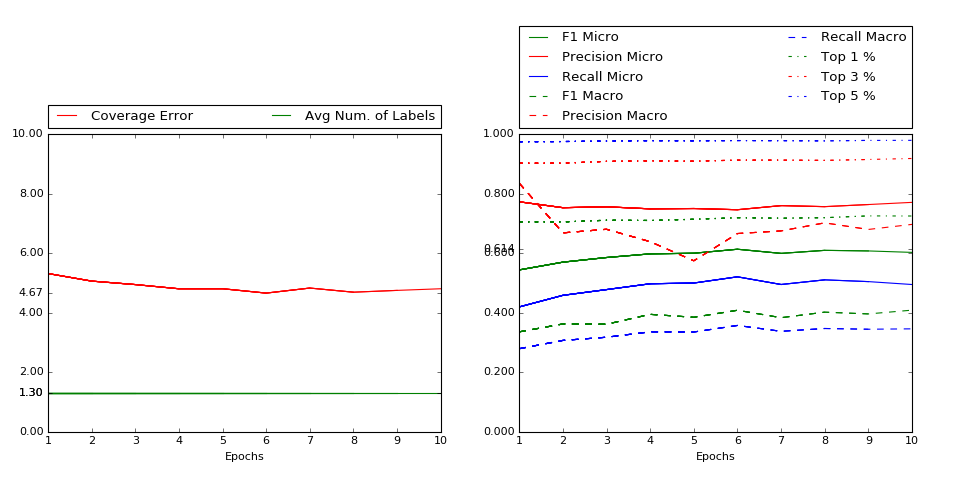

CPU times: user 16.6 s, sys: 2.17 s, total: 18.8 s
Wall time: 18.1 s


2017-01-01 21:04:50,915 : INFO : Getting Validation Embeddings
2017-01-01 21:04:50,917 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.644, Avg Labels: 1.290, 
		 Top 1: 0.692, Top 3: 0.893, Top 5: 0.967, 
		 F1 Micro: 0.507, F1 Macro: 0.538, Total Pos: 30,716


2017-01-01 21:04:51,569 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.325, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.903, Top 5: 0.975, 
		 F1 Micro: 0.545, F1 Macro: 0.337, Total Pos: 8,747
CPU times: user 16.2 s, sys: 2.03 s, total: 18.3 s
Wall time: 17.2 s


2017-01-01 21:05:12,898 : INFO : Getting Validation Embeddings
2017-01-01 21:05:12,900 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.234, Avg Labels: 1.290, 
		 Top 1: 0.690, Top 3: 0.895, Top 5: 0.969, 
		 F1 Micro: 0.555, F1 Macro: 0.337, Total Pos: 36,951


2017-01-01 21:05:13,625 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.071, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.903, Top 5: 0.976, 
		 F1 Micro: 0.571, F1 Macro: 0.363, Total Pos: 9,807
CPU times: user 18.6 s, sys: 1.94 s, total: 20.5 s
Wall time: 19.4 s


2017-01-01 21:05:37,746 : INFO : Getting Validation Embeddings
2017-01-01 21:05:37,748 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.109, Avg Labels: 1.290, 
		 Top 1: 0.697, Top 3: 0.901, Top 5: 0.972, 
		 F1 Micro: 0.572, F1 Macro: 0.363, Total Pos: 38,888


2017-01-01 21:05:38,360 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.954, Avg Labels: 1.300, 
		 Top 1: 0.712, Top 3: 0.909, Top 5: 0.978, 
		 F1 Micro: 0.586, F1 Macro: 0.362, Total Pos: 10,179
CPU times: user 17.5 s, sys: 1.8 s, total: 19.3 s
Wall time: 18.2 s

2017-01-01 21:06:01,139 : INFO : Getting Validation Embeddings
2017-01-01 21:06:01,141 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.014, Avg Labels: 1.290, 
		 Top 1: 0.697, Top 3: 0.902, Top 5: 0.972, 
		 F1 Micro: 0.580, F1 Macro: 0.362, Total Pos: 40,414


2017-01-01 21:06:01,892 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.813, Avg Labels: 1.300, 
		 Top 1: 0.711, Top 3: 0.911, Top 5: 0.979, 
		 F1 Micro: 0.599, F1 Macro: 0.395, Total Pos: 10,693
CPU times: user 19 s, sys: 1.81 s, total: 20.8 s
Wall time: 19.6 s


2017-01-01 21:06:26,275 : INFO : Getting Validation Embeddings
2017-01-01 21:06:26,277 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.965, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.905, Top 5: 0.971, 
		 F1 Micro: 0.585, F1 Macro: 0.395, Total Pos: 40,770


2017-01-01 21:06:27,029 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.814, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.910, Top 5: 0.978, 
		 F1 Micro: 0.601, F1 Macro: 0.385, Total Pos: 10,729
CPU times: user 18.1 s, sys: 2.14 s, total: 20.2 s
Wall time: 19 s


2017-01-01 21:06:49,994 : INFO : Getting Validation Embeddings
2017-01-01 21:06:49,996 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.842, Avg Labels: 1.290, 
		 Top 1: 0.708, Top 3: 0.908, Top 5: 0.973, 
		 F1 Micro: 0.598, F1 Macro: 0.385, Total Pos: 43,254


2017-01-01 21:06:50,724 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.667, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.614, F1 Macro: 0.409, Total Pos: 11,237
CPU times: user 16.1 s, sys: 1.72 s, total: 17.9 s
Wall time: 16.9 s


2017-01-01 21:07:12,006 : INFO : Getting Validation Embeddings
2017-01-01 21:07:12,007 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.984, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.585, F1 Macro: 0.409, Total Pos: 40,152


2017-01-01 21:07:12,707 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.837, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.600, F1 Macro: 0.384, Total Pos: 10,488
CPU times: user 16.4 s, sys: 1.61 s, total: 18 s
Wall time: 17 s


2017-01-01 21:07:34,057 : INFO : Getting Validation Embeddings
2017-01-01 21:07:34,058 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.881, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.905, Top 5: 0.972, 
		 F1 Micro: 0.594, F1 Macro: 0.384, Total Pos: 40,984


2017-01-01 21:07:34,814 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.698, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.913, Top 5: 0.978, 
		 F1 Micro: 0.610, F1 Macro: 0.403, Total Pos: 10,867
CPU times: user 16.7 s, sys: 1.71 s, total: 18.4 s
Wall time: 17.4 s


2017-01-01 21:07:56,222 : INFO : Getting Validation Embeddings
2017-01-01 21:07:56,225 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.949, Avg Labels: 1.290, 
		 Top 1: 0.713, Top 3: 0.910, Top 5: 0.974, 
		 F1 Micro: 0.589, F1 Macro: 0.403, Total Pos: 40,197


2017-01-01 21:07:56,898 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.758, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.916, Top 5: 0.980, 
		 F1 Micro: 0.608, F1 Macro: 0.397, Total Pos: 10,642
CPU times: user 17.2 s, sys: 1.85 s, total: 19.1 s
Wall time: 18 s

2017-01-01 21:08:18,965 : INFO : Getting Validation Embeddings
2017-01-01 21:08:18,966 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.991, Avg Labels: 1.290, 
		 Top 1: 0.713, Top 3: 0.910, Top 5: 0.976, 
		 F1 Micro: 0.587, F1 Macro: 0.397, Total Pos: 39,515


2017-01-01 21:08:19,714 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.813, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.919, Top 5: 0.980, 
		 F1 Micro: 0.604, F1 Macro: 0.409, Total Pos: 10,338
========== 1st Layer Size: 1000, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 1000)          101000      doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_linear (Dense)     (None, 50

<IPython.core.display.Javascript object>


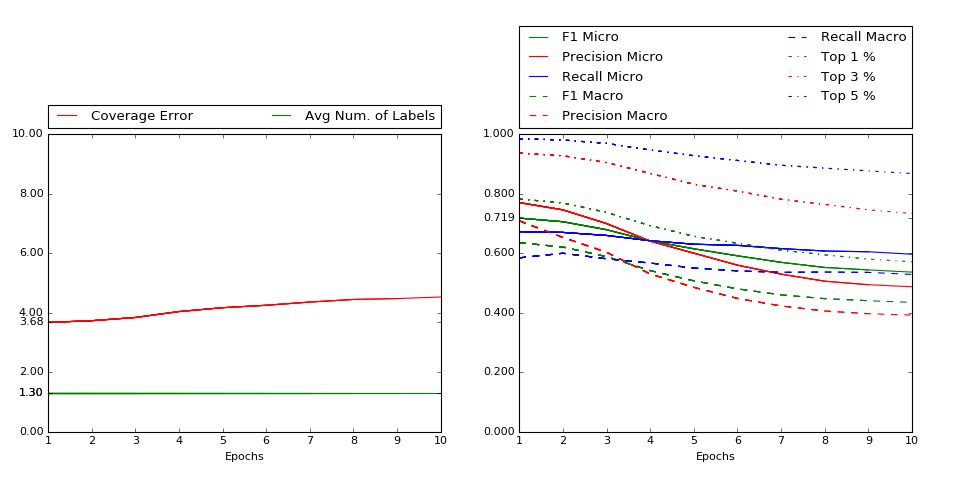

CPU times: user 34.7 s, sys: 33.9 s, total: 1min 8s
Wall time: 2min 21s


2017-01-01 21:10:46,599 : INFO : Getting Validation Embeddings
2017-01-01 21:10:46,601 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.544, Avg Labels: 1.290, 
		 Top 1: 0.804, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.743, F1 Macro: 0.409, Total Pos: 55,437


2017-01-01 21:10:47,324 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.683, Avg Labels: 1.300, 
		 Top 1: 0.783, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.719, F1 Macro: 0.636, Total Pos: 14,056
CPU times: user 34.7 s, sys: 35.4 s, total: 1min 10s
Wall time: 2min 23s


2017-01-01 21:13:14,882 : INFO : Getting Validation Embeddings
2017-01-01 21:13:14,884 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.178, Avg Labels: 1.290, 
		 Top 1: 0.845, Top 3: 0.959, Top 5: 0.991, 
		 F1 Micro: 0.789, F1 Macro: 0.636, Total Pos: 57,382


2017-01-01 21:13:15,542 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.740, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.707, F1 Macro: 0.621, Total Pos: 14,462
CPU times: user 35.6 s, sys: 35.3 s, total: 1min 10s
Wall time: 2min 25s


2017-01-01 21:15:46,141 : INFO : Getting Validation Embeddings
2017-01-01 21:15:46,142 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.796, Avg Labels: 1.290, 
		 Top 1: 0.884, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.837, F1 Macro: 0.621, Total Pos: 58,240


2017-01-01 21:15:46,866 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.848, Avg Labels: 1.300, 
		 Top 1: 0.738, Top 3: 0.905, Top 5: 0.970, 
		 F1 Micro: 0.680, F1 Macro: 0.589, Total Pos: 15,180
CPU times: user 35.1 s, sys: 35.5 s, total: 1min 10s
Wall time: 2min 25s


2017-01-01 21:18:16,399 : INFO : Getting Validation Embeddings
2017-01-01 21:18:16,401 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.386, Avg Labels: 1.290, 
		 Top 1: 0.918, Top 3: 0.979, Top 5: 0.996, 
		 F1 Micro: 0.881, F1 Macro: 0.589, Total Pos: 60,613


2017-01-01 21:18:17,147 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.047, Avg Labels: 1.300, 
		 Top 1: 0.693, Top 3: 0.869, Top 5: 0.948, 
		 F1 Micro: 0.642, F1 Macro: 0.542, Total Pos: 16,132
CPU times: user 34 s, sys: 35.1 s, total: 1min 9s
Wall time: 2min 21s


2017-01-01 21:20:43,482 : INFO : Getting Validation Embeddings
2017-01-01 21:20:43,484 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.102, Avg Labels: 1.290, 
		 Top 1: 0.947, Top 3: 0.986, Top 5: 0.998, 
		 F1 Micro: 0.914, F1 Macro: 0.542, Total Pos: 61,123


2017-01-01 21:20:44,266 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.177, Avg Labels: 1.300, 
		 Top 1: 0.658, Top 3: 0.832, Top 5: 0.928, 
		 F1 Micro: 0.616, F1 Macro: 0.508, Total Pos: 16,902
CPU times: user 35.4 s, sys: 35.3 s, total: 1min 10s


2017-01-01 21:23:13,511 : INFO : Getting Validation Embeddings
2017-01-01 21:23:13,513 : INFO : ===== Loading validation vectors


Wall time: 2min 24s
** Training Metrics: Cov Err: 1.823, Avg Labels: 1.290, 
		 Top 1: 0.965, Top 3: 0.990, Top 5: 0.998, 
		 F1 Micro: 0.942, F1 Macro: 0.508, Total Pos: 62,744


2017-01-01 21:23:14,127 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.259, Avg Labels: 1.300, 
		 Top 1: 0.634, Top 3: 0.810, Top 5: 0.912, 
		 F1 Micro: 0.592, F1 Macro: 0.481, Total Pos: 18,004
CPU times: user 33.7 s, sys: 33.8 s, total: 1min 7s
Wall time: 2min 19s

2017-01-01 21:25:38,701 : INFO : Getting Validation Embeddings
2017-01-01 21:25:38,703 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 1.644, Avg Labels: 1.290, 
		 Top 1: 0.976, Top 3: 0.993, Top 5: 0.999, 
		 F1 Micro: 0.961, F1 Macro: 0.481, Total Pos: 63,246


2017-01-01 21:25:39,433 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.367, Avg Labels: 1.300, 
		 Top 1: 0.611, Top 3: 0.782, Top 5: 0.896, 
		 F1 Micro: 0.570, F1 Macro: 0.461, Total Pos: 18,700
CPU times: user 34.4 s, sys: 34.7 s, total: 1min 9s
Wall time: 2min 21s


2017-01-01 21:28:05,421 : INFO : Getting Validation Embeddings
2017-01-01 21:28:05,423 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.525, Avg Labels: 1.290, 
		 Top 1: 0.984, Top 3: 0.995, Top 5: 0.999, 
		 F1 Micro: 0.974, F1 Macro: 0.461, Total Pos: 63,610


2017-01-01 21:28:06,017 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.454, Avg Labels: 1.300, 
		 Top 1: 0.595, Top 3: 0.765, Top 5: 0.887, 
		 F1 Micro: 0.553, F1 Macro: 0.448, Total Pos: 19,316
CPU times: user 33.5 s, sys: 34 s, total: 1min 7s
Wall time: 2min 17s


2017-01-01 21:30:28,783 : INFO : Getting Validation Embeddings
2017-01-01 21:30:28,788 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.464, Avg Labels: 1.290, 
		 Top 1: 0.988, Top 3: 0.996, Top 5: 0.999, 
		 F1 Micro: 0.981, F1 Macro: 0.448, Total Pos: 63,809


2017-01-01 21:30:29,605 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.484, Avg Labels: 1.300, 
		 Top 1: 0.581, Top 3: 0.747, Top 5: 0.877, 
		 F1 Micro: 0.545, F1 Macro: 0.441, Total Pos: 19,698
CPU times: user 33.9 s, sys: 34.3 s, total: 1min 8s
Wall time: 2min 19s


2017-01-01 21:32:54,661 : INFO : Getting Validation Embeddings
2017-01-01 21:32:54,667 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.422, Avg Labels: 1.290, 
		 Top 1: 0.991, Top 3: 0.997, Top 5: 0.999, 
		 F1 Micro: 0.986, F1 Macro: 0.441, Total Pos: 63,830


2017-01-01 21:32:55,381 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.536, Avg Labels: 1.300, 
		 Top 1: 0.572, Top 3: 0.734, Top 5: 0.869, 
		 F1 Micro: 0.537, F1 Macro: 0.435, Total Pos: 19,701
========== 1st Layer Size: 500, 1st Layer Activation: linear, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_106 (Dropout)            (None, 500)  

<IPython.core.display.Javascript object>


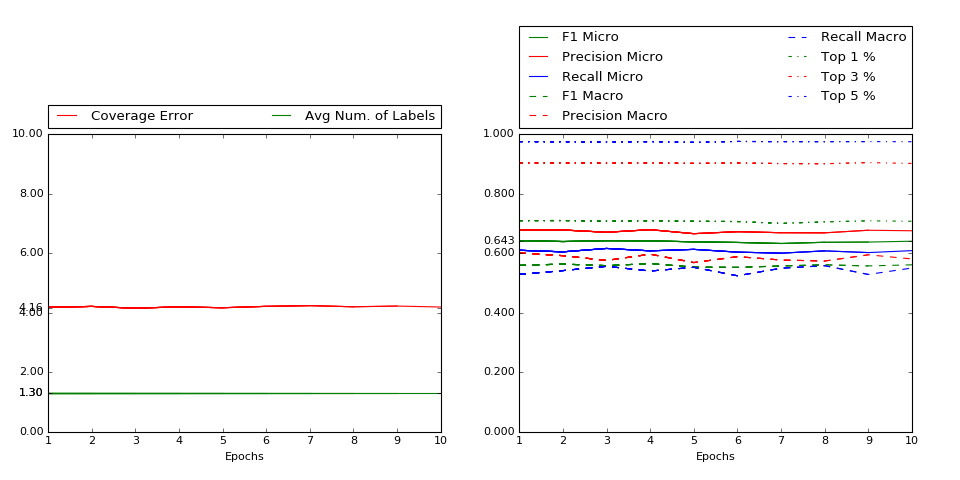

CPU times: user 24.2 s, sys: 9.8 s, total: 34 s


2017-01-01 21:34:10,352 : INFO : Getting Validation Embeddings
2017-01-01 21:34:10,354 : INFO : ===== Loading validation vectors


Wall time: 1min 9s
** Training Metrics: Cov Err: 4.475, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.978, 
		 F1 Micro: 0.633, F1 Macro: 0.435, Total Pos: 49,807


2017-01-01 21:34:10,966 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.189, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.904, Top 5: 0.976, 
		 F1 Micro: 0.643, F1 Macro: 0.560, Total Pos: 14,468
CPU times: user 23.7 s, sys: 9.96 s, total: 33.6 s
Wall time: 1min 9s


2017-01-01 21:35:24,218 : INFO : Getting Validation Embeddings
2017-01-01 21:35:24,220 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.507, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.630, F1 Macro: 0.560, Total Pos: 48,895


2017-01-01 21:35:25,069 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.220, Avg Labels: 1.300, 
		 Top 1: 0.711, Top 3: 0.904, Top 5: 0.975, 
		 F1 Micro: 0.640, F1 Macro: 0.564, Total Pos: 14,354
CPU times: user 22.8 s, sys: 9.97 s, total: 32.8 s
Wall time: 1min 7s


2017-01-01 21:36:37,252 : INFO : Getting Validation Embeddings
2017-01-01 21:36:37,253 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.472, Avg Labels: 1.290, 
		 Top 1: 0.715, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.632, F1 Macro: 0.564, Total Pos: 49,944


2017-01-01 21:36:37,932 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.159, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.904, Top 5: 0.974, 
		 F1 Micro: 0.643, F1 Macro: 0.559, Total Pos: 14,792
CPU times: user 23.2 s, sys: 9.86 s, total: 33.1 s
Wall time: 1min 7s


2017-01-01 21:37:50,984 : INFO : Getting Validation Embeddings
2017-01-01 21:37:50,986 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.500, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.631, F1 Macro: 0.559, Total Pos: 48,886


2017-01-01 21:37:51,761 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.206, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.904, Top 5: 0.976, 
		 F1 Micro: 0.642, F1 Macro: 0.566, Total Pos: 14,413
CPU times: user 22.8 s, sys: 9.81 s, total: 32.7 s
Wall time: 1min 6s

2017-01-01 21:39:03,195 : INFO : Getting Validation Embeddings
2017-01-01 21:39:03,196 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.450, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.635, F1 Macro: 0.566, Total Pos: 50,068


2017-01-01 21:39:03,886 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.175, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.903, Top 5: 0.973, 
		 F1 Micro: 0.639, F1 Macro: 0.554, Total Pos: 14,822
CPU times: user 24 s, sys: 9.75 s, total: 33.8 s
Wall time: 1min 8s


2017-01-01 21:40:16,570 : INFO : Getting Validation Embeddings
2017-01-01 21:40:16,571 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.435, Avg Labels: 1.290, 
		 Top 1: 0.716, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.634, F1 Macro: 0.554, Total Pos: 50,589


2017-01-01 21:40:17,194 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.222, Avg Labels: 1.300, 
		 Top 1: 0.707, Top 3: 0.904, Top 5: 0.976, 
		 F1 Micro: 0.637, F1 Macro: 0.553, Total Pos: 14,454
CPU times: user 21.4 s, sys: 9.11 s, total: 30.5 s
Wall time: 1min 3s


2017-01-01 21:41:25,041 : INFO : Getting Validation Embeddings
2017-01-01 21:41:25,042 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.497, Avg Labels: 1.290, 
		 Top 1: 0.715, Top 3: 0.912, Top 5: 0.979, 
		 F1 Micro: 0.629, F1 Macro: 0.553, Total Pos: 49,445


2017-01-01 21:41:25,794 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.246, Avg Labels: 1.300, 
		 Top 1: 0.701, Top 3: 0.902, Top 5: 0.976, 
		 F1 Micro: 0.633, F1 Macro: 0.558, Total Pos: 14,443
CPU times: user 22.9 s, sys: 9.52 s, total: 32.4 s
Wall time: 1min 5s


2017-01-01 21:42:36,044 : INFO : Getting Validation Embeddings
2017-01-01 21:42:36,046 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.472, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.633, F1 Macro: 0.558, Total Pos: 49,544


2017-01-01 21:42:36,782 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.208, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.901, Top 5: 0.976, 
		 F1 Micro: 0.637, F1 Macro: 0.562, Total Pos: 14,637
CPU times: user 24.3 s, sys: 10.1 s, total: 34.4 s
Wall time: 1min 10s


2017-01-01 21:43:52,018 : INFO : Getting Validation Embeddings
2017-01-01 21:43:52,020 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.507, Avg Labels: 1.290, 
		 Top 1: 0.716, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.629, F1 Macro: 0.562, Total Pos: 49,044


2017-01-01 21:43:52,678 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.232, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.905, Top 5: 0.976, 
		 F1 Micro: 0.638, F1 Macro: 0.558, Total Pos: 14,314
CPU times: user 23.5 s, sys: 9.79 s, total: 33.3 s
Wall time: 1min 9s


2017-01-01 21:45:05,559 : INFO : Getting Validation Embeddings
2017-01-01 21:45:05,561 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.541, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.628, F1 Macro: 0.558, Total Pos: 48,096


2017-01-01 21:45:06,298 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.199, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.902, Top 5: 0.975, 
		 F1 Micro: 0.641, F1 Macro: 0.562, Total Pos: 14,507
========== 1st Layer Size: 50, 1st Layer Activation: relu, 
 2nd Layer Size: 1000, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_107 (Dropout)            (None, 50)    

<IPython.core.display.Javascript object>


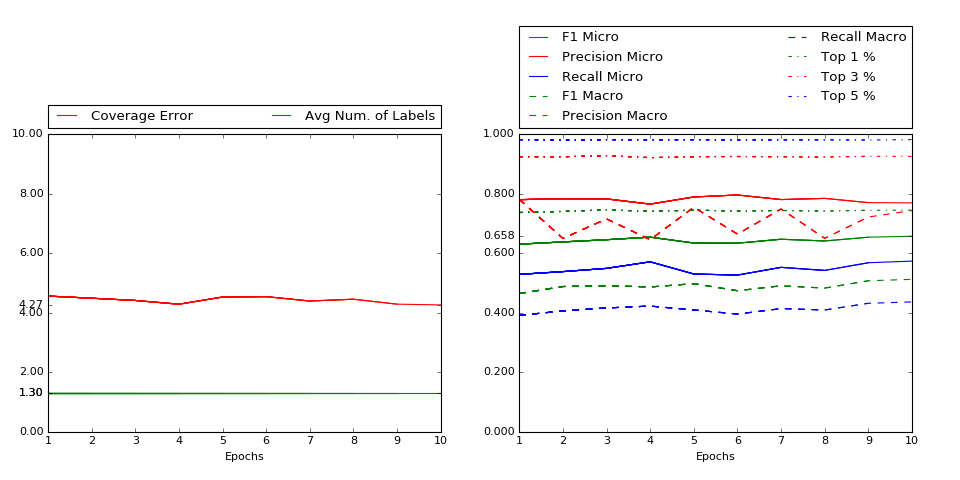

CPU times: user 28.2 s, sys: 11.6 s, total: 39.8 s
Wall time: 1min 22s


2017-01-01 21:46:33,353 : INFO : Getting Validation Embeddings
2017-01-01 21:46:33,354 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.434, Avg Labels: 1.290, 
		 Top 1: 0.744, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.649, F1 Macro: 0.562, Total Pos: 45,198


2017-01-01 21:46:33,948 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.568, Avg Labels: 1.300, 
		 Top 1: 0.738, Top 3: 0.925, Top 5: 0.983, 
		 F1 Micro: 0.631, F1 Macro: 0.465, Total Pos: 10,919
CPU times: user 27.1 s, sys: 11.8 s, total: 38.9 s
Wall time: 1min 20s


2017-01-01 21:47:58,985 : INFO : Getting Validation Embeddings
2017-01-01 21:47:58,987 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.411, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.653, F1 Macro: 0.465, Total Pos: 44,715


2017-01-01 21:47:59,854 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.496, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.639, F1 Macro: 0.489, Total Pos: 11,067
CPU times: user 26.2 s, sys: 10.6 s, total: 36.8 s
Wall time: 1min 16s


2017-01-01 21:49:21,315 : INFO : Getting Validation Embeddings
2017-01-01 21:49:21,317 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.290, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.664, F1 Macro: 0.489, Total Pos: 46,491


2017-01-01 21:49:22,006 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.420, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.646, F1 Macro: 0.492, Total Pos: 11,298
CPU times: user 27.1 s, sys: 10.7 s, total: 37.7 s
Wall time: 1min 18s


2017-01-01 21:50:44,362 : INFO : Getting Validation Embeddings
2017-01-01 21:50:44,364 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.191, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.927, Top 5: 0.982, 
		 F1 Micro: 0.670, F1 Macro: 0.492, Total Pos: 48,346


2017-01-01 21:50:45,132 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.294, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.922, Top 5: 0.982, 
		 F1 Micro: 0.655, F1 Macro: 0.487, Total Pos: 12,022
CPU times: user 27.3 s, sys: 11.5 s, total: 38.7 s
Wall time: 1min 20s


2017-01-01 21:52:10,248 : INFO : Getting Validation Embeddings
2017-01-01 21:52:10,250 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.393, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.658, F1 Macro: 0.487, Total Pos: 44,180


2017-01-01 21:52:10,994 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.536, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.635, F1 Macro: 0.498, Total Pos: 10,821
CPU times: user 27.1 s, sys: 11.8 s, total: 38.9 s
Wall time: 1min 20s


2017-01-01 21:53:36,671 : INFO : Getting Validation Embeddings
2017-01-01 21:53:36,673 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.411, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.655, F1 Macro: 0.498, Total Pos: 43,738


2017-01-01 21:53:37,416 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.548, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.634, F1 Macro: 0.475, Total Pos: 10,657
CPU times: user 26.3 s, sys: 10.7 s, total: 37.1 s


2017-01-01 21:54:58,502 : INFO : Getting Validation Embeddings
2017-01-01 21:54:58,503 : INFO : ===== Loading validation vectors


Wall time: 1min 16s
** Training Metrics: Cov Err: 4.275, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.666, F1 Macro: 0.475, Total Pos: 46,179


2017-01-01 21:54:59,294 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.401, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.648, F1 Macro: 0.491, Total Pos: 11,401
CPU times: user 26.9 s, sys: 11.1 s, total: 38.1 s
Wall time: 1min 19s


2017-01-01 21:56:22,116 : INFO : Getting Validation Embeddings
2017-01-01 21:56:22,118 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.350, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.660, F1 Macro: 0.491, Total Pos: 45,168


2017-01-01 21:56:22,739 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.462, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.924, Top 5: 0.982, 
		 F1 Micro: 0.642, F1 Macro: 0.484, Total Pos: 11,134
CPU times: user 25.8 s, sys: 11.5 s, total: 37.3 s
Wall time: 1min 16s


2017-01-01 21:57:43,356 : INFO : Getting Validation Embeddings
2017-01-01 21:57:43,358 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.176, Avg Labels: 1.290, 
		 Top 1: 0.760, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.673, F1 Macro: 0.484, Total Pos: 48,055


2017-01-01 21:57:43,926 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.296, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.655, F1 Macro: 0.508, Total Pos: 11,878
CPU times: user 26.6 s, sys: 11.4 s, total: 38 s
Wall time: 1min 19s


2017-01-01 21:59:07,521 : INFO : Getting Validation Embeddings
2017-01-01 21:59:07,524 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.162, Avg Labels: 1.290, 
		 Top 1: 0.760, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.676, F1 Macro: 0.508, Total Pos: 48,198


2017-01-01 21:59:08,139 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.271, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.658, F1 Macro: 0.513, Total Pos: 12,003
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_108 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)     

<IPython.core.display.Javascript object>


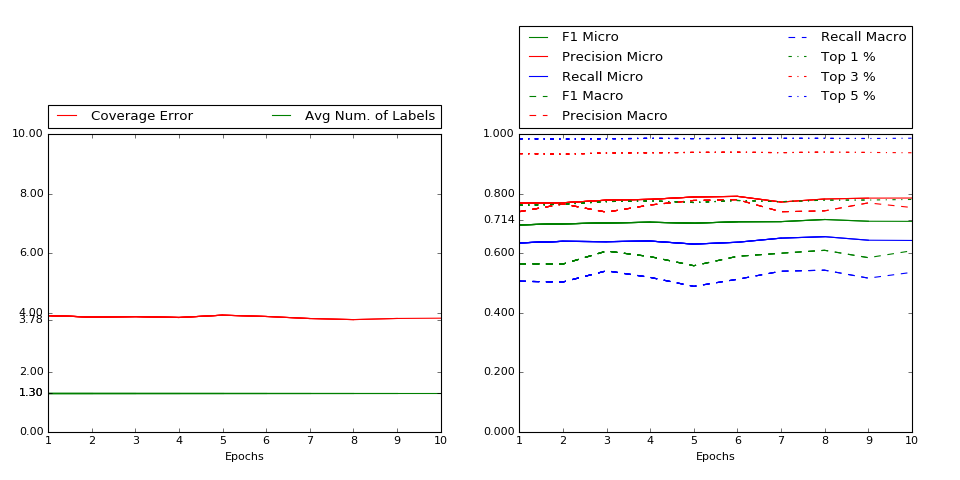

CPU times: user 30.2 s, sys: 17.7 s, total: 47.9 s
Wall time: 1min 40s


2017-01-01 22:00:56,033 : INFO : Getting Validation Embeddings
2017-01-01 22:00:56,035 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.013, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.684, F1 Macro: 0.513, Total Pos: 53,108


2017-01-01 22:00:56,654 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.912, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.696, F1 Macro: 0.565, Total Pos: 13,293
CPU times: user 28.1 s, sys: 17.6 s, total: 45.7 s
Wall time: 1min 33s


2017-01-01 22:02:33,573 : INFO : Getting Validation Embeddings
2017-01-01 22:02:33,574 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.036, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.684, F1 Macro: 0.565, Total Pos: 52,154


2017-01-01 22:02:34,182 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.863, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.700, F1 Macro: 0.564, Total Pos: 13,386
CPU times: user 28.7 s, sys: 17.7 s, total: 46.4 s
Wall time: 1min 35s


2017-01-01 22:04:14,115 : INFO : Getting Validation Embeddings
2017-01-01 22:04:14,116 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.047, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.688, F1 Macro: 0.564, Total Pos: 50,547


2017-01-01 22:04:14,834 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.878, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.702, F1 Macro: 0.608, Total Pos: 13,216
CPU times: user 27.9 s, sys: 16.7 s, total: 44.6 s
Wall time: 1min 31s


2017-01-01 22:05:51,566 : INFO : Getting Validation Embeddings
2017-01-01 22:05:51,568 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.067, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.684, F1 Macro: 0.608, Total Pos: 50,650


2017-01-01 22:05:52,264 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.848, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.705, F1 Macro: 0.589, Total Pos: 13,209
CPU times: user 29.2 s, sys: 17.9 s, total: 47.1 s
Wall time: 1min 36s


2017-01-01 22:07:32,858 : INFO : Getting Validation Embeddings
2017-01-01 22:07:32,859 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.049, Avg Labels: 1.290, 
		 Top 1: 0.764, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.687, F1 Macro: 0.589, Total Pos: 50,903


2017-01-01 22:07:33,465 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.925, Avg Labels: 1.300, 
		 Top 1: 0.771, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.702, F1 Macro: 0.559, Total Pos: 12,870
CPU times: user 29.2 s, sys: 17.5 s, total: 46.6 s
Wall time: 1min 36s


2017-01-01 22:09:15,452 : INFO : Getting Validation Embeddings
2017-01-01 22:09:15,457 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.052, Avg Labels: 1.290, 
		 Top 1: 0.772, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.691, F1 Macro: 0.559, Total Pos: 49,989


2017-01-01 22:09:16,143 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.882, Avg Labels: 1.300, 
		 Top 1: 0.778, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.706, F1 Macro: 0.590, Total Pos: 12,961
CPU times: user 26.9 s, sys: 16.3 s, total: 43.2 s
Wall time: 1min 30s


2017-01-01 22:10:50,354 : INFO : Getting Validation Embeddings
2017-01-01 22:10:50,356 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.018, Avg Labels: 1.290, 
		 Top 1: 0.761, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.690, F1 Macro: 0.590, Total Pos: 51,689


2017-01-01 22:10:51,164 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.813, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.939, Top 5: 0.987, 
		 F1 Micro: 0.707, F1 Macro: 0.601, Total Pos: 13,570
CPU times: user 29.1 s, sys: 17.5 s, total: 46.6 s
Wall time: 1min 36s

2017-01-01 22:12:32,717 : INFO : Getting Validation Embeddings
2017-01-01 22:12:32,719 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.045, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.690, F1 Macro: 0.601, Total Pos: 50,661


2017-01-01 22:12:33,453 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.777, Avg Labels: 1.300, 
		 Top 1: 0.779, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.714, F1 Macro: 0.610, Total Pos: 13,494
CPU times: user 29.2 s, sys: 17.5 s, total: 46.7 s
Wall time: 1min 36s

2017-01-01 22:14:15,415 : INFO : Getting Validation Embeddings
2017-01-01 22:14:15,417 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.096, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.682, F1 Macro: 0.610, Total Pos: 49,827


2017-01-01 22:14:16,049 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.815, Avg Labels: 1.300, 
		 Top 1: 0.779, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.708, F1 Macro: 0.586, Total Pos: 13,199
CPU times: user 27.6 s, sys: 17.1 s, total: 44.7 s
Wall time: 1min 33s


2017-01-01 22:15:53,924 : INFO : Getting Validation Embeddings
2017-01-01 22:15:53,926 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.057, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.685, F1 Macro: 0.586, Total Pos: 50,713


2017-01-01 22:15:54,773 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.824, Avg Labels: 1.300, 
		 Top 1: 0.781, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.708, F1 Macro: 0.609, Total Pos: 13,178
========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 1000, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_109 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)  

<IPython.core.display.Javascript object>


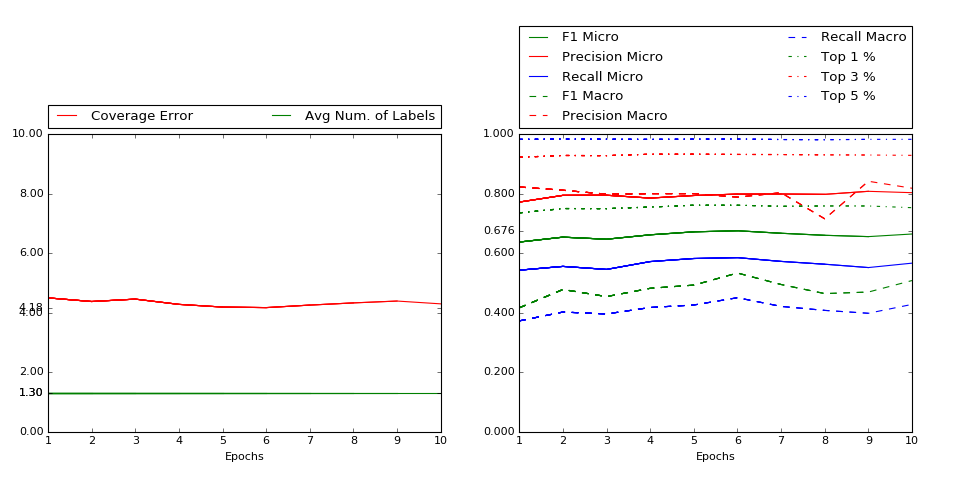

CPU times: user 36.6 s, sys: 26.9 s, total: 1min 3s
Wall time: 2min 10s


2017-01-01 22:18:12,326 : INFO : Getting Validation Embeddings
2017-01-01 22:18:12,329 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.722, Avg Labels: 1.290, 
		 Top 1: 0.724, Top 3: 0.916, Top 5: 0.977, 
		 F1 Micro: 0.615, F1 Macro: 0.609, Total Pos: 43,372


2017-01-01 22:18:13,499 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.507, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.923, Top 5: 0.983, 
		 F1 Micro: 0.638, F1 Macro: 0.417, Total Pos: 11,328
CPU times: user 34.9 s, sys: 26.5 s, total: 1min 1s
Wall time: 2min 7s


2017-01-01 22:20:24,712 : INFO : Getting Validation Embeddings
2017-01-01 22:20:24,714 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.629, Avg Labels: 1.290, 
		 Top 1: 0.739, Top 3: 0.920, Top 5: 0.980, 
		 F1 Micro: 0.629, F1 Macro: 0.417, Total Pos: 42,708


2017-01-01 22:20:25,316 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.385, Avg Labels: 1.300, 
		 Top 1: 0.751, Top 3: 0.929, Top 5: 0.984, 
		 F1 Micro: 0.655, F1 Macro: 0.479, Total Pos: 11,264
CPU times: user 33.9 s, sys: 26.6 s, total: 1min
Wall time: 2min 5s


2017-01-01 22:22:34,809 : INFO : Getting Validation Embeddings
2017-01-01 22:22:34,810 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.719, Avg Labels: 1.290, 
		 Top 1: 0.742, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.621, F1 Macro: 0.479, Total Pos: 41,547


2017-01-01 22:22:35,434 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.465, Avg Labels: 1.300, 
		 Top 1: 0.751, Top 3: 0.929, Top 5: 0.984, 
		 F1 Micro: 0.648, F1 Macro: 0.455, Total Pos: 11,052
CPU times: user 34.9 s, sys: 26.8 s, total: 1min 1s
Wall time: 2min 7s


2017-01-01 22:24:48,142 : INFO : Getting Validation Embeddings
2017-01-01 22:24:48,143 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.540, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.637, F1 Macro: 0.455, Total Pos: 44,186


2017-01-01 22:24:48,942 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.289, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.663, F1 Macro: 0.483, Total Pos: 11,727
CPU times: user 34.3 s, sys: 26.7 s, total: 1min 1s
Wall time: 2min 6s


2017-01-01 22:26:59,747 : INFO : Getting Validation Embeddings
2017-01-01 22:26:59,753 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.463, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.646, F1 Macro: 0.483, Total Pos: 44,639


2017-01-01 22:27:00,578 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.199, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.673, F1 Macro: 0.494, Total Pos: 11,808
CPU times: user 34.5 s, sys: 26.5 s, total: 1min
Wall time: 2min 6s


2017-01-01 22:29:11,278 : INFO : Getting Validation Embeddings
2017-01-01 22:29:11,279 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.468, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.648, F1 Macro: 0.494, Total Pos: 43,852


2017-01-01 22:29:11,857 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.180, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.676, F1 Macro: 0.534, Total Pos: 11,798
CPU times: user 34.8 s, sys: 26.9 s, total: 1min 1s
Wall time: 2min 8s

2017-01-01 22:31:25,192 : INFO : Getting Validation Embeddings
2017-01-01 22:31:25,193 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.551, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.639, F1 Macro: 0.534, Total Pos: 43,022


2017-01-01 22:31:25,808 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.265, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.668, F1 Macro: 0.496, Total Pos: 11,538
CPU times: user 33.1 s, sys: 25.7 s, total: 58.8 s


2017-01-01 22:33:31,433 : INFO : Getting Validation Embeddings
2017-01-01 22:33:31,436 : INFO : ===== Loading validation vectors


Wall time: 2min 1s
** Training Metrics: Cov Err: 4.600, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.926, Top 5: 0.979, 
		 F1 Micro: 0.633, F1 Macro: 0.496, Total Pos: 42,568


2017-01-01 22:33:32,255 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.338, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.661, F1 Macro: 0.465, Total Pos: 11,364
CPU times: user 34.6 s, sys: 26.8 s, total: 1min 1s


2017-01-01 22:35:44,477 : INFO : Getting Validation Embeddings
2017-01-01 22:35:44,478 : INFO : ===== Loading validation vectors


Wall time: 2min 6s
** Training Metrics: Cov Err: 4.688, Avg Labels: 1.290, 
		 Top 1: 0.748, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.627, F1 Macro: 0.465, Total Pos: 40,340


2017-01-01 22:35:45,165 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.400, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.657, F1 Macro: 0.470, Total Pos: 10,997
CPU times: user 35.4 s, sys: 26.9 s, total: 1min 2s
Wall time: 2min 8s


2017-01-01 22:37:58,894 : INFO : Getting Validation Embeddings
2017-01-01 22:37:58,896 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.592, Avg Labels: 1.290, 
		 Top 1: 0.745, Top 3: 0.922, Top 5: 0.980, 
		 F1 Micro: 0.636, F1 Macro: 0.470, Total Pos: 41,687


2017-01-01 22:37:59,661 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.306, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.665, F1 Macro: 0.509, Total Pos: 11,356
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 500) 

<IPython.core.display.Javascript object>


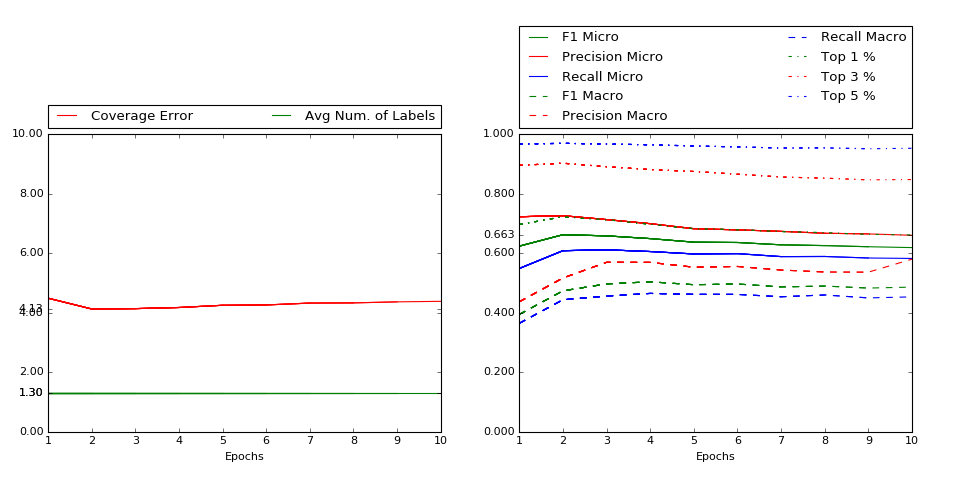

CPU times: user 30.1 s, sys: 19 s, total: 49.1 s


2017-01-01 22:39:47,172 : INFO : Getting Validation Embeddings
2017-01-01 22:39:47,174 : INFO : ===== Loading validation vectors


Wall time: 1min 40s
** Training Metrics: Cov Err: 4.479, Avg Labels: 1.290, 
		 Top 1: 0.727, Top 3: 0.908, Top 5: 0.970, 
		 F1 Micro: 0.633, F1 Macro: 0.509, Total Pos: 46,348


2017-01-01 22:39:47,847 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.497, Avg Labels: 1.300, 
		 Top 1: 0.697, Top 3: 0.896, Top 5: 0.967, 
		 F1 Micro: 0.625, F1 Macro: 0.395, Total Pos: 12,226
CPU times: user 29.9 s, sys: 19.1 s, total: 49 s
Wall time: 1min 39s


2017-01-01 22:41:32,570 : INFO : Getting Validation Embeddings
2017-01-01 22:41:32,572 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.731, Avg Labels: 1.290, 
		 Top 1: 0.800, Top 3: 0.935, Top 5: 0.980, 
		 F1 Micro: 0.726, F1 Macro: 0.395, Total Pos: 52,143


2017-01-01 22:41:33,380 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.134, Avg Labels: 1.300, 
		 Top 1: 0.724, Top 3: 0.903, Top 5: 0.970, 
		 F1 Micro: 0.663, F1 Macro: 0.474, Total Pos: 13,491
CPU times: user 29.3 s, sys: 19.1 s, total: 48.4 s
Wall time: 1min 38s

2017-01-01 22:43:16,301 : INFO : Getting Validation Embeddings
2017-01-01 22:43:16,304 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.372, Avg Labels: 1.290, 
		 Top 1: 0.835, Top 3: 0.945, Top 5: 0.985, 
		 F1 Micro: 0.770, F1 Macro: 0.474, Total Pos: 54,148


2017-01-01 22:43:17,028 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.146, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.891, Top 5: 0.968, 
		 F1 Micro: 0.659, F1 Macro: 0.498, Total Pos: 13,807
CPU times: user 28.6 s, sys: 19 s, total: 47.6 s


2017-01-01 22:44:59,558 : INFO : Getting Validation Embeddings
2017-01-01 22:44:59,560 : INFO : ===== Loading validation vectors


Wall time: 1min 37s
** Training Metrics: Cov Err: 3.204, Avg Labels: 1.290, 
		 Top 1: 0.851, Top 3: 0.948, Top 5: 0.986, 
		 F1 Micro: 0.791, F1 Macro: 0.498, Total Pos: 54,949


2017-01-01 22:45:08,755 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.183, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.882, Top 5: 0.965, 
		 F1 Micro: 0.650, F1 Macro: 0.505, Total Pos: 13,943
CPU times: user 30.8 s, sys: 18.7 s, total: 49.5 s
Wall time: 1min 41s


2017-01-01 22:46:54,216 : INFO : Getting Validation Embeddings
2017-01-01 22:46:54,218 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.080, Avg Labels: 1.290, 
		 Top 1: 0.863, Top 3: 0.951, Top 5: 0.987, 
		 F1 Micro: 0.804, F1 Macro: 0.505, Total Pos: 56,059


2017-01-01 22:46:54,803 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.258, Avg Labels: 1.300, 
		 Top 1: 0.683, Top 3: 0.875, Top 5: 0.961, 
		 F1 Micro: 0.638, F1 Macro: 0.495, Total Pos: 14,096
CPU times: user 30.3 s, sys: 19.4 s, total: 49.7 s
Wall time: 1min 42s


2017-01-01 22:48:41,069 : INFO : Getting Validation Embeddings
2017-01-01 22:48:41,071 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.954, Avg Labels: 1.290, 
		 Top 1: 0.875, Top 3: 0.953, Top 5: 0.987, 
		 F1 Micro: 0.819, F1 Macro: 0.495, Total Pos: 56,435


2017-01-01 22:48:41,766 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.269, Avg Labels: 1.300, 
		 Top 1: 0.680, Top 3: 0.866, Top 5: 0.958, 
		 F1 Micro: 0.637, F1 Macro: 0.497, Total Pos: 14,203
CPU times: user 31 s, sys: 18.7 s, total: 49.7 s
Wall time: 1min 42s


2017-01-01 22:50:28,467 : INFO : Getting Validation Embeddings
2017-01-01 22:50:28,469 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.896, Avg Labels: 1.290, 
		 Top 1: 0.884, Top 3: 0.955, Top 5: 0.988, 
		 F1 Micro: 0.827, F1 Macro: 0.497, Total Pos: 56,186


2017-01-01 22:50:29,260 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.332, Avg Labels: 1.300, 
		 Top 1: 0.674, Top 3: 0.857, Top 5: 0.954, 
		 F1 Micro: 0.629, F1 Macro: 0.487, Total Pos: 14,071
CPU times: user 30.4 s, sys: 19.7 s, total: 50.2 s
Wall time: 1min 43s


2017-01-01 22:52:17,034 : INFO : Getting Validation Embeddings
2017-01-01 22:52:17,036 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.797, Avg Labels: 1.290, 
		 Top 1: 0.890, Top 3: 0.955, Top 5: 0.988, 
		 F1 Micro: 0.835, F1 Macro: 0.487, Total Pos: 57,085


2017-01-01 22:52:17,615 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.338, Avg Labels: 1.300, 
		 Top 1: 0.670, Top 3: 0.853, Top 5: 0.955, 
		 F1 Micro: 0.626, F1 Macro: 0.490, Total Pos: 14,215
CPU times: user 31.1 s, sys: 19.1 s, total: 50.2 s


2017-01-01 22:54:05,067 : INFO : Getting Validation Embeddings
2017-01-01 22:54:05,069 : INFO : ===== Loading validation vectors


Wall time: 1min 42s
** Training Metrics: Cov Err: 2.758, Avg Labels: 1.290, 
		 Top 1: 0.895, Top 3: 0.956, Top 5: 0.988, 
		 F1 Micro: 0.842, F1 Macro: 0.490, Total Pos: 56,844


2017-01-01 22:54:05,838 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.373, Avg Labels: 1.300, 
		 Top 1: 0.664, Top 3: 0.847, Top 5: 0.952, 
		 F1 Micro: 0.623, F1 Macro: 0.484, Total Pos: 14,138
CPU times: user 31.1 s, sys: 19.5 s, total: 50.5 s
Wall time: 1min 42s


2017-01-01 22:55:53,566 : INFO : Getting Validation Embeddings
2017-01-01 22:55:53,576 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.716, Avg Labels: 1.290, 
		 Top 1: 0.899, Top 3: 0.958, Top 5: 0.988, 
		 F1 Micro: 0.845, F1 Macro: 0.484, Total Pos: 57,130


2017-01-01 22:55:54,297 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.391, Avg Labels: 1.300, 
		 Top 1: 0.662, Top 3: 0.848, Top 5: 0.953, 
		 F1 Micro: 0.620, F1 Macro: 0.487, Total Pos: 14,202
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_111 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)

<IPython.core.display.Javascript object>


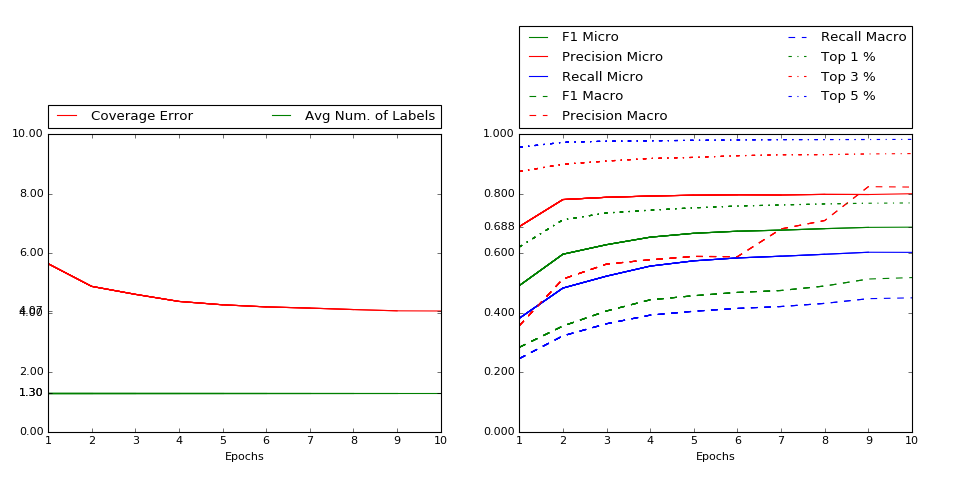

CPU times: user 39 s, sys: 28.5 s, total: 1min 7s
Wall time: 2min 21s


2017-01-01 22:58:22,289 : INFO : Getting Validation Embeddings
2017-01-01 22:58:22,290 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.767, Avg Labels: 1.290, 
		 Top 1: 0.610, Top 3: 0.866, Top 5: 0.953, 
		 F1 Micro: 0.482, F1 Macro: 0.487, Total Pos: 34,729


2017-01-01 22:58:23,079 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.657, Avg Labels: 1.300, 
		 Top 1: 0.622, Top 3: 0.875, Top 5: 0.957, 
		 F1 Micro: 0.492, F1 Macro: 0.285, Total Pos: 8,911
CPU times: user 36.3 s, sys: 28.4 s, total: 1min 4s
Wall time: 2min 13s


2017-01-01 23:00:41,763 : INFO : Getting Validation Embeddings
2017-01-01 23:00:41,765 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.055, Avg Labels: 1.290, 
		 Top 1: 0.702, Top 3: 0.892, Top 5: 0.967, 
		 F1 Micro: 0.579, F1 Macro: 0.285, Total Pos: 38,266


2017-01-01 23:00:42,346 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.894, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.900, Top 5: 0.974, 
		 F1 Micro: 0.597, F1 Macro: 0.356, Total Pos: 9,967
CPU times: user 37.4 s, sys: 28.3 s, total: 1min 5s
Wall time: 2min 15s


2017-01-01 23:03:01,683 : INFO : Getting Validation Embeddings
2017-01-01 23:03:01,685 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.818, Avg Labels: 1.290, 
		 Top 1: 0.724, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.609, F1 Macro: 0.356, Total Pos: 40,552


2017-01-01 23:03:02,303 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.626, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.911, Top 5: 0.977, 
		 F1 Micro: 0.629, F1 Macro: 0.407, Total Pos: 10,689
CPU times: user 37.8 s, sys: 28.8 s, total: 1min 6s


2017-01-01 23:05:24,010 : INFO : Getting Validation Embeddings
2017-01-01 23:05:24,011 : INFO : ===== Loading validation vectors


Wall time: 2min 17s
** Training Metrics: Cov Err: 4.669, Avg Labels: 1.290, 
		 Top 1: 0.735, Top 3: 0.913, Top 5: 0.975, 
		 F1 Micro: 0.627, F1 Macro: 0.407, Total Pos: 42,292


2017-01-01 23:05:24,712 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.388, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.919, Top 5: 0.978, 
		 F1 Micro: 0.655, F1 Macro: 0.444, Total Pos: 11,317
CPU times: user 36.3 s, sys: 28.2 s, total: 1min 4s
Wall time: 2min 13s


2017-01-01 23:07:42,667 : INFO : Getting Validation Embeddings
2017-01-01 23:07:42,668 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.532, Avg Labels: 1.290, 
		 Top 1: 0.743, Top 3: 0.918, Top 5: 0.977, 
		 F1 Micro: 0.641, F1 Macro: 0.444, Total Pos: 43,777


2017-01-01 23:07:43,319 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.275, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.668, F1 Macro: 0.458, Total Pos: 11,634
CPU times: user 36.8 s, sys: 28.7 s, total: 1min 5s
Wall time: 2min 14s


2017-01-01 23:10:02,193 : INFO : Getting Validation Embeddings
2017-01-01 23:10:02,195 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.439, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.651, F1 Macro: 0.458, Total Pos: 44,730


2017-01-01 23:10:02,893 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.204, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.675, F1 Macro: 0.469, Total Pos: 11,813
CPU times: user 37.2 s, sys: 27.8 s, total: 1min 4s
Wall time: 2min 14s

2017-01-01 23:12:22,181 : INFO : Getting Validation Embeddings
2017-01-01 23:12:22,183 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.397, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.926, Top 5: 0.980, 
		 F1 Micro: 0.656, F1 Macro: 0.469, Total Pos: 45,073


2017-01-01 23:12:22,807 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.164, Avg Labels: 1.300, 
		 Top 1: 0.763, Top 3: 0.932, Top 5: 0.982, 
		 F1 Micro: 0.678, F1 Macro: 0.476, Total Pos: 11,940
CPU times: user 37.7 s, sys: 28.8 s, total: 1min 6s
Wall time: 2min 15s


2017-01-01 23:14:42,720 : INFO : Getting Validation Embeddings
2017-01-01 23:14:42,722 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.359, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.927, Top 5: 0.980, 
		 F1 Micro: 0.660, F1 Macro: 0.476, Total Pos: 45,408


2017-01-01 23:14:43,327 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.114, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.683, F1 Macro: 0.491, Total Pos: 12,037
CPU times: user 36.2 s, sys: 27.9 s, total: 1min 4s


2017-01-01 23:17:00,389 : INFO : Getting Validation Embeddings
2017-01-01 23:17:00,392 : INFO : ===== Loading validation vectors


Wall time: 2min 12s
** Training Metrics: Cov Err: 4.323, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.929, Top 5: 0.981, 
		 F1 Micro: 0.665, F1 Macro: 0.491, Total Pos: 45,799


2017-01-01 23:17:01,177 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.072, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.934, Top 5: 0.983, 
		 F1 Micro: 0.688, F1 Macro: 0.514, Total Pos: 12,183
CPU times: user 37.5 s, sys: 28.7 s, total: 1min 6s
Wall time: 2min 15s

2017-01-01 23:19:21,165 : INFO : Getting Validation Embeddings
2017-01-01 23:19:21,167 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.325, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.664, F1 Macro: 0.514, Total Pos: 45,641


2017-01-01 23:19:21,885 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.066, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.936, Top 5: 0.983, 
		 F1 Micro: 0.688, F1 Macro: 0.519, Total Pos: 12,135
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_113 (Dropout)            (None, 200) 

<IPython.core.display.Javascript object>


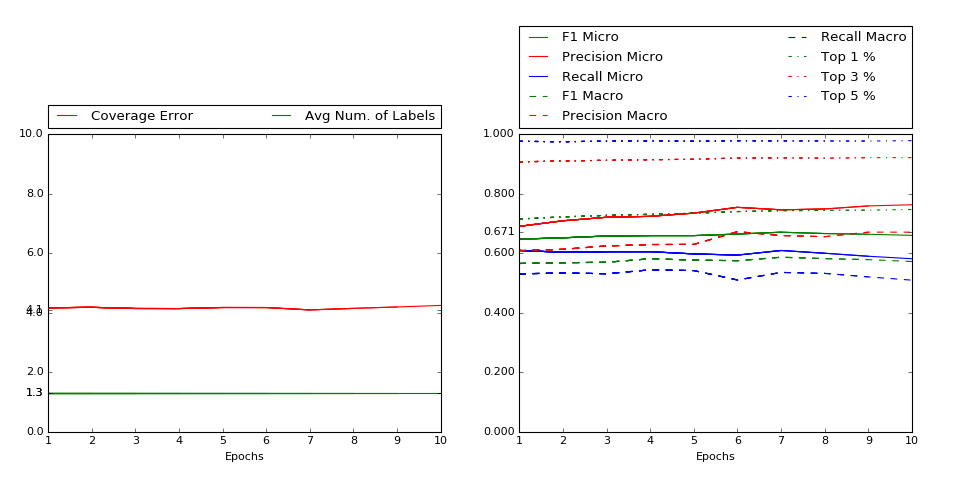

CPU times: user 20.2 s, sys: 1.99 s, total: 22.2 s


2017-01-01 23:19:50,990 : INFO : Getting Validation Embeddings
2017-01-01 23:19:50,992 : INFO : ===== Loading validation vectors


Wall time: 21.8 s
** Training Metrics: Cov Err: 4.358, Avg Labels: 1.290, 
		 Top 1: 0.722, Top 3: 0.916, Top 5: 0.980, 
		 F1 Micro: 0.644, F1 Macro: 0.519, Total Pos: 50,821


2017-01-01 23:19:51,714 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.174, Avg Labels: 1.300, 
		 Top 1: 0.716, Top 3: 0.908, Top 5: 0.977, 
		 F1 Micro: 0.648, F1 Macro: 0.566, Total Pos: 14,213
CPU times: user 16.3 s, sys: 1.99 s, total: 18.3 s
Wall time: 17.2 s


2017-01-01 23:20:12,960 : INFO : Getting Validation Embeddings
2017-01-01 23:20:12,962 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.290, Avg Labels: 1.290, 
		 Top 1: 0.732, Top 3: 0.921, Top 5: 0.980, 
		 F1 Micro: 0.655, F1 Macro: 0.566, Total Pos: 50,670


2017-01-01 23:20:13,670 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.190, Avg Labels: 1.300, 
		 Top 1: 0.723, Top 3: 0.911, Top 5: 0.975, 
		 F1 Micro: 0.653, F1 Macro: 0.569, Total Pos: 13,694
CPU times: user 20.3 s, sys: 2.2 s, total: 22.5 s
Wall time: 21.2 s

2017-01-01 23:20:39,455 : INFO : Getting Validation Embeddings
2017-01-01 23:20:39,457 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.222, Avg Labels: 1.290, 
		 Top 1: 0.741, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.664, F1 Macro: 0.569, Total Pos: 50,511


2017-01-01 23:20:40,118 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.150, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.913, Top 5: 0.977, 
		 F1 Micro: 0.659, F1 Macro: 0.570, Total Pos: 13,513
CPU times: user 16.7 s, sys: 1.84 s, total: 18.5 s
Wall time: 17.5 s


2017-01-01 23:21:01,609 : INFO : Getting Validation Embeddings
2017-01-01 23:21:01,610 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.124, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.927, Top 5: 0.983, 
		 F1 Micro: 0.675, F1 Macro: 0.570, Total Pos: 51,589


2017-01-01 23:21:02,309 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.148, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.915, Top 5: 0.978, 
		 F1 Micro: 0.660, F1 Macro: 0.582, Total Pos: 13,458
CPU times: user 15.9 s, sys: 1.75 s, total: 17.7 s
Wall time: 16.7 s

2017-01-01 23:21:23,774 : INFO : Getting Validation Embeddings
2017-01-01 23:21:23,778 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.117, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.679, F1 Macro: 0.582, Total Pos: 50,860


2017-01-01 23:21:24,533 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.183, Avg Labels: 1.300, 
		 Top 1: 0.735, Top 3: 0.916, Top 5: 0.977, 
		 F1 Micro: 0.660, F1 Macro: 0.578, Total Pos: 13,097
CPU times: user 17.7 s, sys: 1.64 s, total: 19.3 s
Wall time: 18.3 s

2017-01-01 23:21:47,812 : INFO : Getting Validation Embeddings
2017-01-01 23:21:47,814 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.083, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.682, F1 Macro: 0.578, Total Pos: 50,847


2017-01-01 23:21:48,540 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.182, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.921, Top 5: 0.979, 
		 F1 Micro: 0.665, F1 Macro: 0.576, Total Pos: 12,674
CPU times: user 16.3 s, sys: 1.84 s, total: 18.1 s
Wall time: 17.1 s


2017-01-01 23:22:09,406 : INFO : Getting Validation Embeddings
2017-01-01 23:22:09,407 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.916, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.576, Total Pos: 53,855


2017-01-01 23:22:10,067 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.103, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.921, Top 5: 0.978, 
		 F1 Micro: 0.671, F1 Macro: 0.587, Total Pos: 13,149
CPU times: user 16.5 s, sys: 1.8 s, total: 18.3 s
Wall time: 17.2 s


2017-01-01 23:22:30,602 : INFO : Getting Validation Embeddings
2017-01-01 23:22:30,603 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.931, Avg Labels: 1.290, 
		 Top 1: 0.765, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.587, Total Pos: 52,866


2017-01-01 23:22:31,191 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.154, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.920, Top 5: 0.978, 
		 F1 Micro: 0.667, F1 Macro: 0.582, Total Pos: 12,901
CPU times: user 17.8 s, sys: 1.9 s, total: 19.7 s
Wall time: 18.6 s


2017-01-01 23:22:53,599 : INFO : Getting Validation Embeddings
2017-01-01 23:22:53,601 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.959, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.582, Total Pos: 52,113


2017-01-01 23:22:54,196 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.202, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.922, Top 5: 0.978, 
		 F1 Micro: 0.664, F1 Macro: 0.579, Total Pos: 12,512
CPU times: user 16.2 s, sys: 1.93 s, total: 18.1 s
Wall time: 17.1 s


2017-01-01 23:23:15,777 : INFO : Getting Validation Embeddings
2017-01-01 23:23:15,779 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.962, Avg Labels: 1.290, 
		 Top 1: 0.771, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.697, F1 Macro: 0.579, Total Pos: 51,538


2017-01-01 23:23:16,503 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.253, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.661, F1 Macro: 0.573, Total Pos: 12,272
========== 1st Layer Size: 1000, 1st Layer Activation: linear, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_114 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 100

<IPython.core.display.Javascript object>


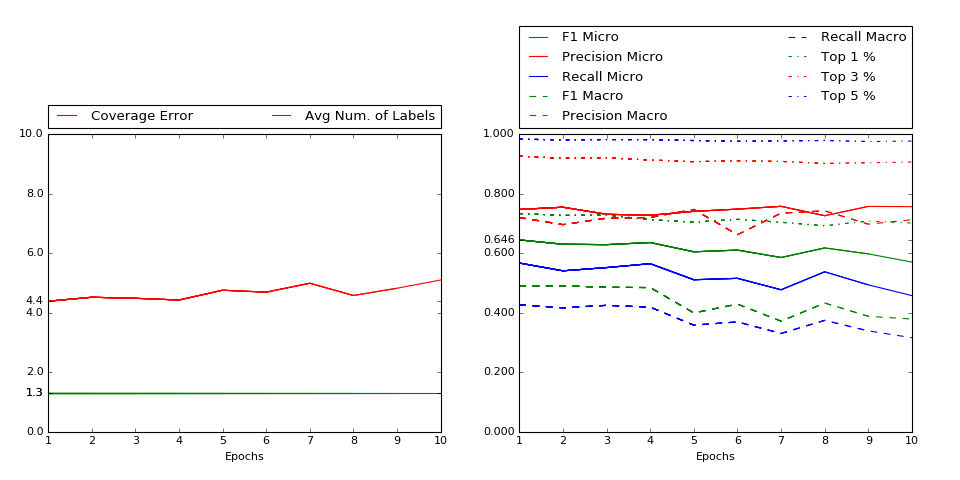

CPU times: user 43.4 s, sys: 42.9 s, total: 1min 26s
Wall time: 2min 56s


2017-01-01 23:26:24,183 : INFO : Getting Validation Embeddings
2017-01-01 23:26:24,185 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.817, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.918, Top 5: 0.980, 
		 F1 Micro: 0.605, F1 Macro: 0.573, Total Pos: 42,904


2017-01-01 23:26:24,764 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.394, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.927, Top 5: 0.984, 
		 F1 Micro: 0.646, F1 Macro: 0.490, Total Pos: 12,219
CPU times: user 40.2 s, sys: 42.8 s, total: 1min 22s


2017-01-01 23:29:26,025 : INFO : Getting Validation Embeddings
2017-01-01 23:29:26,028 : INFO : ===== Loading validation vectors


Wall time: 2min 49s
** Training Metrics: Cov Err: 4.989, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.909, Top 5: 0.979, 
		 F1 Micro: 0.585, F1 Macro: 0.490, Total Pos: 41,072


2017-01-01 23:29:26,790 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.528, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.920, Top 5: 0.982, 
		 F1 Micro: 0.631, F1 Macro: 0.491, Total Pos: 11,542
CPU times: user 40.6 s, sys: 43.1 s, total: 1min 23s
Wall time: 2min 51s


2017-01-01 23:32:29,284 : INFO : Getting Validation Embeddings
2017-01-01 23:32:29,287 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.960, Avg Labels: 1.290, 
		 Top 1: 0.703, Top 3: 0.910, Top 5: 0.978, 
		 F1 Micro: 0.583, F1 Macro: 0.491, Total Pos: 42,236


2017-01-01 23:32:30,085 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.494, Avg Labels: 1.300, 
		 Top 1: 0.729, Top 3: 0.921, Top 5: 0.983, 
		 F1 Micro: 0.630, F1 Macro: 0.486, Total Pos: 12,155
CPU times: user 40.4 s, sys: 43.1 s, total: 1min 23s


2017-01-01 23:35:32,592 : INFO : Getting Validation Embeddings
2017-01-01 23:35:32,594 : INFO : ===== Loading validation vectors


Wall time: 2min 51s
** Training Metrics: Cov Err: 4.788, Avg Labels: 1.290, 
		 Top 1: 0.688, Top 3: 0.899, Top 5: 0.975, 
		 F1 Micro: 0.602, F1 Macro: 0.486, Total Pos: 44,715


2017-01-01 23:35:33,325 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.435, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.914, Top 5: 0.982, 
		 F1 Micro: 0.637, F1 Macro: 0.485, Total Pos: 12,502
CPU times: user 40.5 s, sys: 44.1 s, total: 1min 24s
Wall time: 2min 53s


2017-01-01 23:38:37,500 : INFO : Getting Validation Embeddings
2017-01-01 23:38:37,502 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.064, Avg Labels: 1.290, 
		 Top 1: 0.677, Top 3: 0.896, Top 5: 0.972, 
		 F1 Micro: 0.574, F1 Macro: 0.485, Total Pos: 40,621


2017-01-01 23:38:38,269 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.764, Avg Labels: 1.300, 
		 Top 1: 0.705, Top 3: 0.908, Top 5: 0.979, 
		 F1 Micro: 0.605, F1 Macro: 0.400, Total Pos: 11,106
CPU times: user 39.7 s, sys: 43.4 s, total: 1min 23s
Wall time: 2min 51s


2017-01-01 23:41:41,021 : INFO : Getting Validation Embeddings
2017-01-01 23:41:41,024 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.125, Avg Labels: 1.290, 
		 Top 1: 0.698, Top 3: 0.902, Top 5: 0.971, 
		 F1 Micro: 0.569, F1 Macro: 0.400, Total Pos: 38,834


2017-01-01 23:41:41,728 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.699, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.911, Top 5: 0.977, 
		 F1 Micro: 0.611, F1 Macro: 0.430, Total Pos: 11,098
CPU times: user 41.1 s, sys: 43.7 s, total: 1min 24s
Wall time: 2min 54s


2017-01-01 23:44:47,474 : INFO : Getting Validation Embeddings
2017-01-01 23:44:47,476 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.395, Avg Labels: 1.290, 
		 Top 1: 0.676, Top 3: 0.898, Top 5: 0.973, 
		 F1 Micro: 0.541, F1 Macro: 0.430, Total Pos: 36,277


2017-01-01 23:44:48,220 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.999, Avg Labels: 1.300, 
		 Top 1: 0.705, Top 3: 0.909, Top 5: 0.978, 
		 F1 Micro: 0.586, F1 Macro: 0.372, Total Pos: 10,145
CPU times: user 40.3 s, sys: 43.8 s, total: 1min 24s
Wall time: 2min 52s


2017-01-01 23:47:51,250 : INFO : Getting Validation Embeddings
2017-01-01 23:47:51,252 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.990, Avg Labels: 1.290, 
		 Top 1: 0.655, Top 3: 0.882, Top 5: 0.974, 
		 F1 Micro: 0.577, F1 Macro: 0.372, Total Pos: 43,646


2017-01-01 23:47:52,048 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.586, Avg Labels: 1.300, 
		 Top 1: 0.693, Top 3: 0.903, Top 5: 0.980, 
		 F1 Micro: 0.619, F1 Macro: 0.433, Total Pos: 11,923
CPU times: user 40.7 s, sys: 43.8 s, total: 1min 24s
Wall time: 2min 53s


2017-01-01 23:50:56,399 : INFO : Getting Validation Embeddings
2017-01-01 23:50:56,402 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.140, Avg Labels: 1.290, 
		 Top 1: 0.691, Top 3: 0.897, Top 5: 0.971, 
		 F1 Micro: 0.567, F1 Macro: 0.433, Total Pos: 38,198


2017-01-01 23:50:57,022 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.831, Avg Labels: 1.300, 
		 Top 1: 0.709, Top 3: 0.905, Top 5: 0.976, 
		 F1 Micro: 0.599, F1 Macro: 0.389, Total Pos: 10,497
CPU times: user 40.4 s, sys: 43 s, total: 1min 23s
Wall time: 2min 50s


2017-01-01 23:53:56,575 : INFO : Getting Validation Embeddings
2017-01-01 23:53:56,576 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.504, Avg Labels: 1.290, 
		 Top 1: 0.670, Top 3: 0.896, Top 5: 0.973, 
		 F1 Micro: 0.528, F1 Macro: 0.389, Total Pos: 35,193


2017-01-01 23:53:57,182 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.108, Avg Labels: 1.300, 
		 Top 1: 0.702, Top 3: 0.907, Top 5: 0.978, 
		 F1 Micro: 0.571, F1 Macro: 0.380, Total Pos: 9,741
========== 1st Layer Size: 50, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_116 (Dropout)            (None, 50)    

<IPython.core.display.Javascript object>


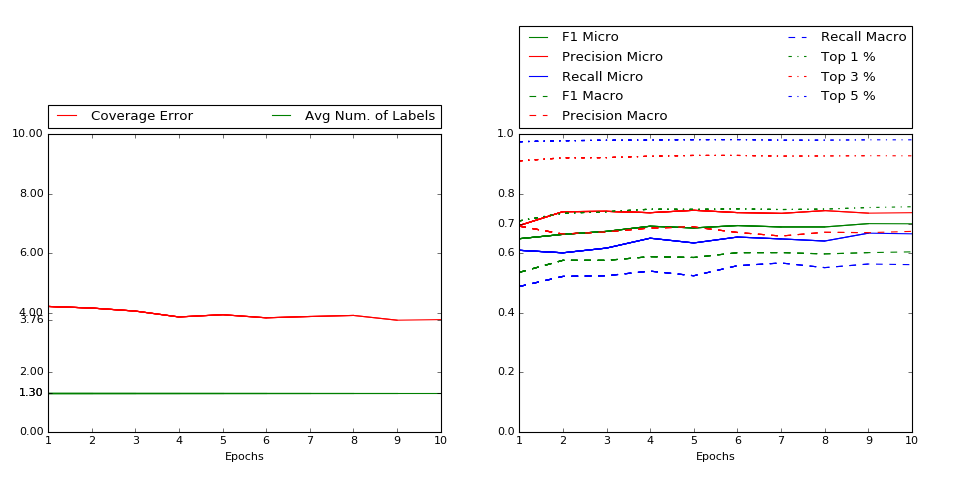

CPU times: user 30.8 s, sys: 12 s, total: 42.8 s
Wall time: 1min 25s


2017-01-01 23:55:31,806 : INFO : Getting Validation Embeddings
2017-01-01 23:55:31,810 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.056, Avg Labels: 1.290, 
		 Top 1: 0.716, Top 3: 0.913, Top 5: 0.978, 
		 F1 Micro: 0.662, F1 Macro: 0.380, Total Pos: 58,791


2017-01-01 23:55:32,804 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.219, Avg Labels: 1.300, 
		 Top 1: 0.709, Top 3: 0.911, Top 5: 0.975, 
		 F1 Micro: 0.650, F1 Macro: 0.536, Total Pos: 14,164
CPU times: user 28.7 s, sys: 12 s, total: 40.8 s
Wall time: 1min 21s


2017-01-01 23:57:02,814 : INFO : Getting Validation Embeddings
2017-01-01 23:57:02,815 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.064, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.679, F1 Macro: 0.536, Total Pos: 52,602


2017-01-01 23:57:03,502 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.165, Avg Labels: 1.300, 
		 Top 1: 0.735, Top 3: 0.921, Top 5: 0.979, 
		 F1 Micro: 0.664, F1 Macro: 0.577, Total Pos: 13,091
CPU times: user 28.8 s, sys: 11.6 s, total: 40.4 s
Wall time: 1min 21s


2017-01-01 23:58:30,743 : INFO : Getting Validation Embeddings
2017-01-01 23:58:30,744 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.970, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.689, F1 Macro: 0.577, Total Pos: 53,626


2017-01-01 23:58:31,377 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.064, Avg Labels: 1.300, 
		 Top 1: 0.740, Top 3: 0.922, Top 5: 0.980, 
		 F1 Micro: 0.674, F1 Macro: 0.577, Total Pos: 13,418
CPU times: user 29.1 s, sys: 11.9 s, total: 41 s

2017-01-02 00:00:01,935 : INFO : Getting Validation Embeddings
2017-01-02 00:00:01,936 : INFO : ===== Loading validation vectors



Wall time: 1min 22s
** Training Metrics: Cov Err: 3.752, Avg Labels: 1.290, 
		 Top 1: 0.761, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.706, F1 Macro: 0.577, Total Pos: 57,401


2017-01-02 00:00:02,705 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.866, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.691, F1 Macro: 0.589, Total Pos: 14,224
CPU times: user 28.3 s, sys: 11.6 s, total: 40 s
Wall time: 1min 21s


2017-01-02 00:01:32,673 : INFO : Getting Validation Embeddings
2017-01-02 00:01:32,675 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.801, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.705, F1 Macro: 0.589, Total Pos: 55,666


2017-01-02 00:01:33,385 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.941, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.686, F1 Macro: 0.586, Total Pos: 13,727
CPU times: user 28 s, sys: 11.4 s, total: 39.5 s
Wall time: 1min 20s


2017-01-02 00:03:00,697 : INFO : Getting Validation Embeddings
2017-01-02 00:03:00,699 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.660, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.716, F1 Macro: 0.586, Total Pos: 58,446


2017-01-02 00:03:01,381 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.838, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.694, F1 Macro: 0.603, Total Pos: 14,302
CPU times: user 27.5 s, sys: 11.6 s, total: 39.1 s
Wall time: 1min 18s


2017-01-02 00:04:28,711 : INFO : Getting Validation Embeddings
2017-01-02 00:04:28,715 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.671, Avg Labels: 1.290, 
		 Top 1: 0.770, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.715, F1 Macro: 0.603, Total Pos: 57,888


2017-01-02 00:04:29,562 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.881, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.689, F1 Macro: 0.603, Total Pos: 14,216
CPU times: user 27.8 s, sys: 11.7 s, total: 39.5 s
Wall time: 1min 20s


2017-01-02 00:05:58,532 : INFO : Getting Validation Embeddings
2017-01-02 00:05:58,533 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.719, Avg Labels: 1.290, 
		 Top 1: 0.774, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.715, F1 Macro: 0.603, Total Pos: 56,314


2017-01-02 00:05:59,257 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.917, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.689, F1 Macro: 0.598, Total Pos: 13,885
CPU times: user 28.9 s, sys: 11.9 s, total: 40.8 s
Wall time: 1min 22s

2017-01-02 00:07:28,669 : INFO : Getting Validation Embeddings
2017-01-02 00:07:28,671 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.582, Avg Labels: 1.290, 
		 Top 1: 0.777, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.724, F1 Macro: 0.598, Total Pos: 58,931


2017-01-02 00:07:29,408 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.757, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.700, F1 Macro: 0.603, Total Pos: 14,625
CPU times: user 27.3 s, sys: 11.3 s, total: 38.5 s
Wall time: 1min 17s


2017-01-02 00:08:55,851 : INFO : Getting Validation Embeddings
2017-01-02 00:08:55,852 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.629, Avg Labels: 1.290, 
		 Top 1: 0.776, Top 3: 0.939, Top 5: 0.987, 
		 F1 Micro: 0.722, F1 Macro: 0.603, Total Pos: 58,290


2017-01-02 00:08:56,518 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.777, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.700, F1 Macro: 0.605, Total Pos: 14,545
========== 1st Layer Size: 50, 1st Layer Activation: linear, 
 2nd Layer Size: 50, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_117 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 50)     

<IPython.core.display.Javascript object>


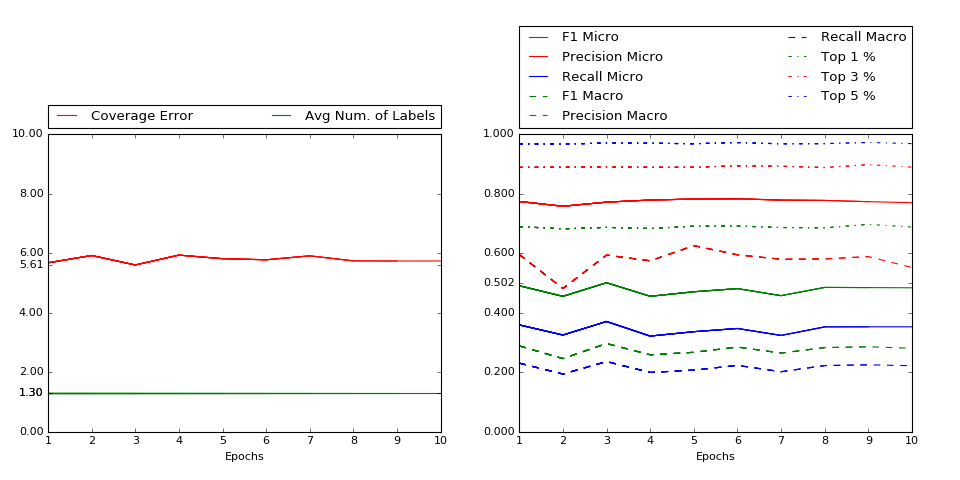

CPU times: user 20.5 s, sys: 2.88 s, total: 23.3 s
Wall time: 24.3 s

2017-01-02 00:09:27,744 : INFO : Getting Validation Embeddings
2017-01-02 00:09:27,747 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 6.030, Avg Labels: 1.290, 
		 Top 1: 0.668, Top 3: 0.874, Top 5: 0.960, 
		 F1 Micro: 0.448, F1 Macro: 0.605, Total Pos: 25,542


2017-01-02 00:09:28,397 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.686, Avg Labels: 1.300, 
		 Top 1: 0.690, Top 3: 0.889, Top 5: 0.968, 
		 F1 Micro: 0.491, F1 Macro: 0.289, Total Pos: 7,479
CPU times: user 20 s, sys: 2.21 s, total: 22.2 s
Wall time: 20.9 s


2017-01-02 00:09:53,157 : INFO : Getting Validation Embeddings
2017-01-02 00:09:53,158 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.250, Avg Labels: 1.290, 
		 Top 1: 0.663, Top 3: 0.877, Top 5: 0.960, 
		 F1 Micro: 0.413, F1 Macro: 0.289, Total Pos: 23,068


2017-01-02 00:09:53,947 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.931, Avg Labels: 1.300, 
		 Top 1: 0.683, Top 3: 0.890, Top 5: 0.968, 
		 F1 Micro: 0.456, F1 Macro: 0.247, Total Pos: 6,914
CPU times: user 16.6 s, sys: 2.27 s, total: 18.9 s
Wall time: 18 s

2017-01-02 00:10:15,583 : INFO : Getting Validation Embeddings
2017-01-02 00:10:15,584 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 6.022, Avg Labels: 1.290, 
		 Top 1: 0.670, Top 3: 0.876, Top 5: 0.963, 
		 F1 Micro: 0.451, F1 Macro: 0.247, Total Pos: 25,709


2017-01-02 00:10:16,732 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.612, Avg Labels: 1.300, 
		 Top 1: 0.688, Top 3: 0.891, Top 5: 0.971, 
		 F1 Micro: 0.502, F1 Macro: 0.297, Total Pos: 7,738
CPU times: user 18.2 s, sys: 2.3 s, total: 20.5 s
Wall time: 19.4 s


2017-01-02 00:10:39,852 : INFO : Getting Validation Embeddings
2017-01-02 00:10:39,853 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.285, Avg Labels: 1.290, 
		 Top 1: 0.662, Top 3: 0.874, Top 5: 0.963, 
		 F1 Micro: 0.411, F1 Macro: 0.297, Total Pos: 22,521


2017-01-02 00:10:40,422 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.944, Avg Labels: 1.300, 
		 Top 1: 0.684, Top 3: 0.889, Top 5: 0.970, 
		 F1 Micro: 0.456, F1 Macro: 0.260, Total Pos: 6,656
CPU times: user 16.6 s, sys: 2.08 s, total: 18.6 s
Wall time: 17.7 s


2017-01-02 00:11:02,650 : INFO : Getting Validation Embeddings
2017-01-02 00:11:02,651 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.198, Avg Labels: 1.290, 
		 Top 1: 0.669, Top 3: 0.876, Top 5: 0.961, 
		 F1 Micro: 0.421, F1 Macro: 0.260, Total Pos: 23,012


2017-01-02 00:11:03,443 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.824, Avg Labels: 1.300, 
		 Top 1: 0.692, Top 3: 0.890, Top 5: 0.969, 
		 F1 Micro: 0.471, F1 Macro: 0.268, Total Pos: 6,932
CPU times: user 20.7 s, sys: 2.46 s, total: 23.1 s
Wall time: 21.8 s


2017-01-02 00:11:29,065 : INFO : Getting Validation Embeddings
2017-01-02 00:11:29,067 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.227, Avg Labels: 1.290, 
		 Top 1: 0.668, Top 3: 0.880, Top 5: 0.964, 
		 F1 Micro: 0.424, F1 Macro: 0.268, Total Pos: 23,126


2017-01-02 00:11:29,683 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.787, Avg Labels: 1.300, 
		 Top 1: 0.692, Top 3: 0.895, Top 5: 0.973, 
		 F1 Micro: 0.482, F1 Macro: 0.285, Total Pos: 7,145
CPU times: user 19.1 s, sys: 2.23 s, total: 21.3 s
Wall time: 20.2 s


2017-01-02 00:11:54,427 : INFO : Getting Validation Embeddings
2017-01-02 00:11:54,428 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.300, Avg Labels: 1.290, 
		 Top 1: 0.667, Top 3: 0.877, Top 5: 0.961, 
		 F1 Micro: 0.406, F1 Macro: 0.285, Total Pos: 22,101


2017-01-02 00:11:55,188 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.919, Avg Labels: 1.300, 
		 Top 1: 0.687, Top 3: 0.893, Top 5: 0.968, 
		 F1 Micro: 0.458, F1 Macro: 0.265, Total Pos: 6,702
CPU times: user 19.1 s, sys: 2.27 s, total: 21.4 s
Wall time: 20.1 s


2017-01-02 00:12:19,230 : INFO : Getting Validation Embeddings
2017-01-02 00:12:19,231 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.146, Avg Labels: 1.290, 
		 Top 1: 0.664, Top 3: 0.875, Top 5: 0.962, 
		 F1 Micro: 0.433, F1 Macro: 0.265, Total Pos: 24,013


2017-01-02 00:12:19,814 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.750, Avg Labels: 1.300, 
		 Top 1: 0.686, Top 3: 0.889, Top 5: 0.969, 
		 F1 Micro: 0.486, F1 Macro: 0.284, Total Pos: 7,306
CPU times: user 19.8 s, sys: 2.41 s, total: 22.2 s
Wall time: 21 s


2017-01-02 00:12:45,653 : INFO : Getting Validation Embeddings
2017-01-02 00:12:45,655 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.109, Avg Labels: 1.290, 
		 Top 1: 0.675, Top 3: 0.884, Top 5: 0.965, 
		 F1 Micro: 0.437, F1 Macro: 0.284, Total Pos: 24,593


2017-01-02 00:12:46,279 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.745, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.898, Top 5: 0.973, 
		 F1 Micro: 0.485, F1 Macro: 0.286, Total Pos: 7,351
CPU times: user 20.4 s, sys: 2.36 s, total: 22.7 s
Wall time: 21.4 s


2017-01-02 00:13:11,779 : INFO : Getting Validation Embeddings
2017-01-02 00:13:11,780 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.126, Avg Labels: 1.290, 
		 Top 1: 0.667, Top 3: 0.876, Top 5: 0.961, 
		 F1 Micro: 0.435, F1 Macro: 0.286, Total Pos: 24,501


2017-01-02 00:13:12,363 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 5.746, Avg Labels: 1.300, 
		 Top 1: 0.689, Top 3: 0.890, Top 5: 0.969, 
		 F1 Micro: 0.485, F1 Macro: 0.281, Total Pos: 7,383
========== 1st Layer Size: 500, 1st Layer Activation: linear, 
 2nd Layer Size: 50, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 50)  

<IPython.core.display.Javascript object>


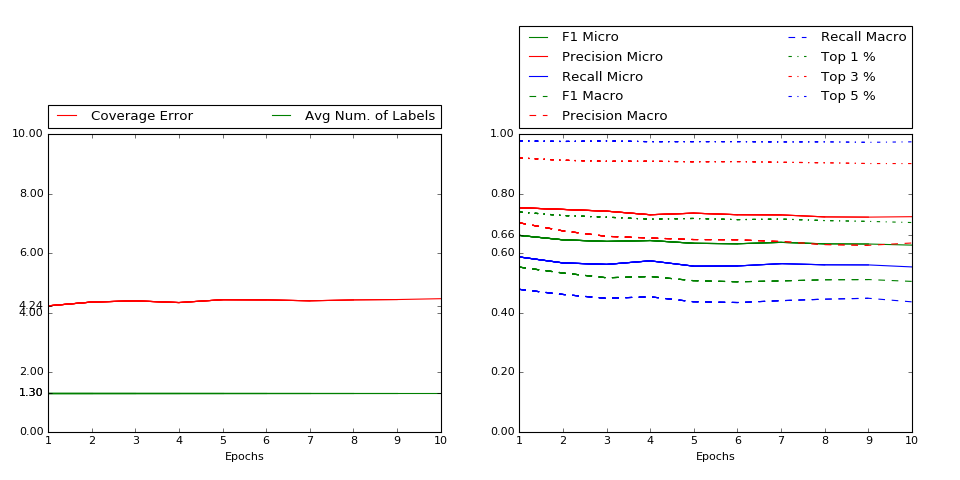

CPU times: user 26.8 s, sys: 10.5 s, total: 37.3 s
Wall time: 1min 16s


2017-01-02 00:14:34,340 : INFO : Getting Validation Embeddings
2017-01-02 00:14:34,341 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.883, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.699, F1 Macro: 0.281, Total Pos: 54,428


2017-01-02 00:14:35,077 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.239, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.921, Top 5: 0.978, 
		 F1 Micro: 0.661, F1 Macro: 0.554, Total Pos: 12,565
CPU times: user 24.9 s, sys: 10.2 s, total: 35.1 s


2017-01-02 00:15:50,315 : INFO : Getting Validation Embeddings
2017-01-02 00:15:50,316 : INFO : ===== Loading validation vectors


Wall time: 1min 11s
** Training Metrics: Cov Err: 3.825, Avg Labels: 1.290, 
		 Top 1: 0.774, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.709, F1 Macro: 0.554, Total Pos: 54,091


2017-01-02 00:15:50,975 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.366, Avg Labels: 1.300, 
		 Top 1: 0.727, Top 3: 0.913, Top 5: 0.976, 
		 F1 Micro: 0.646, F1 Macro: 0.534, Total Pos: 12,228
CPU times: user 25.8 s, sys: 10.3 s, total: 36 s
Wall time: 1min 14s


2017-01-02 00:17:09,623 : INFO : Getting Validation Embeddings
2017-01-02 00:17:09,624 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.782, Avg Labels: 1.290, 
		 Top 1: 0.780, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.714, F1 Macro: 0.534, Total Pos: 54,597


2017-01-02 00:17:10,436 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.406, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.910, Top 5: 0.978, 
		 F1 Micro: 0.640, F1 Macro: 0.518, Total Pos: 12,214
CPU times: user 24.2 s, sys: 9.66 s, total: 33.8 s
Wall time: 1min 8s


2017-01-02 00:18:23,879 : INFO : Getting Validation Embeddings
2017-01-02 00:18:23,880 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.653, Avg Labels: 1.290, 
		 Top 1: 0.782, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.723, F1 Macro: 0.518, Total Pos: 56,918


2017-01-02 00:18:24,624 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.350, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.910, Top 5: 0.976, 
		 F1 Micro: 0.643, F1 Macro: 0.522, Total Pos: 12,681
CPU times: user 24.8 s, sys: 9.92 s, total: 34.7 s


2017-01-02 00:19:40,366 : INFO : Getting Validation Embeddings
2017-01-02 00:19:40,368 : INFO : ===== Loading validation vectors


Wall time: 1min 10s
** Training Metrics: Cov Err: 3.729, Avg Labels: 1.290, 
		 Top 1: 0.785, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.721, F1 Macro: 0.522, Total Pos: 54,802


2017-01-02 00:19:41,101 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.445, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.908, Top 5: 0.976, 
		 F1 Micro: 0.634, F1 Macro: 0.508, Total Pos: 12,199
CPU times: user 24.2 s, sys: 9.45 s, total: 33.7 s
Wall time: 1min 9s


2017-01-02 00:20:53,535 : INFO : Getting Validation Embeddings
2017-01-02 00:20:53,537 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.714, Avg Labels: 1.290, 
		 Top 1: 0.786, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.721, F1 Macro: 0.508, Total Pos: 54,955


2017-01-02 00:20:54,111 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.440, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.909, Top 5: 0.976, 
		 F1 Micro: 0.633, F1 Macro: 0.505, Total Pos: 12,300
CPU times: user 24.4 s, sys: 9.91 s, total: 34.3 s


2017-01-02 00:22:08,640 : INFO : Getting Validation Embeddings
2017-01-02 00:22:08,642 : INFO : ===== Loading validation vectors


Wall time: 1min 10s
** Training Metrics: Cov Err: 3.657, Avg Labels: 1.290, 
		 Top 1: 0.786, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.726, F1 Macro: 0.505, Total Pos: 56,058


2017-01-02 00:22:09,427 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.408, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.906, Top 5: 0.975, 
		 F1 Micro: 0.637, F1 Macro: 0.508, Total Pos: 12,481
CPU times: user 26 s, sys: 10.2 s, total: 36.2 s
Wall time: 1min 13s

2017-01-02 00:23:27,615 : INFO : Getting Validation Embeddings
2017-01-02 00:23:27,617 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.648, Avg Labels: 1.290, 
		 Top 1: 0.789, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.727, F1 Macro: 0.508, Total Pos: 55,964


2017-01-02 00:23:28,254 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.438, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.905, Top 5: 0.975, 
		 F1 Micro: 0.632, F1 Macro: 0.511, Total Pos: 12,511
CPU times: user 25.8 s, sys: 10.3 s, total: 36.1 s
Wall time: 1min 13s

2017-01-02 00:24:45,750 : INFO : Getting Validation Embeddings
2017-01-02 00:24:45,753 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.650, Avg Labels: 1.290, 
		 Top 1: 0.789, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.727, F1 Macro: 0.511, Total Pos: 56,140


2017-01-02 00:24:46,361 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.451, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.902, Top 5: 0.973, 
		 F1 Micro: 0.632, F1 Macro: 0.512, Total Pos: 12,516
CPU times: user 26 s, sys: 10.6 s, total: 36.6 s
Wall time: 1min 16s


2017-01-02 00:26:06,624 : INFO : Getting Validation Embeddings
2017-01-02 00:26:06,625 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.661, Avg Labels: 1.290, 
		 Top 1: 0.789, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.726, F1 Macro: 0.512, Total Pos: 55,548


2017-01-02 00:26:07,211 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.480, Avg Labels: 1.300, 
		 Top 1: 0.704, Top 3: 0.902, Top 5: 0.975, 
		 F1 Micro: 0.628, F1 Macro: 0.506, Total Pos: 12,340
========== 1st Layer Size: 1000, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_119 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000

<IPython.core.display.Javascript object>


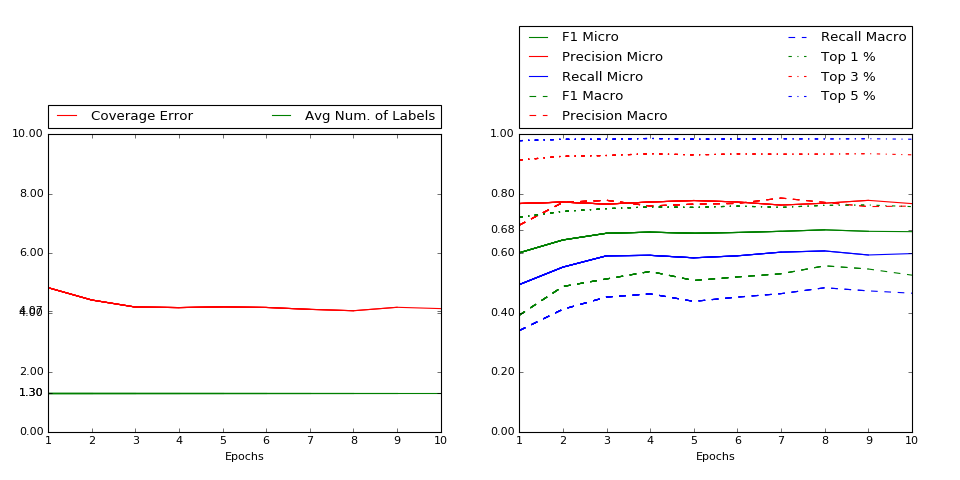

CPU times: user 28.3 s, sys: 17.5 s, total: 45.7 s
Wall time: 1min 32s


2017-01-02 00:27:45,762 : INFO : Getting Validation Embeddings
2017-01-02 00:27:45,764 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.997, Avg Labels: 1.290, 
		 Top 1: 0.707, Top 3: 0.904, Top 5: 0.975, 
		 F1 Micro: 0.586, F1 Macro: 0.506, Total Pos: 39,779


2017-01-02 00:27:46,369 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.851, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.602, F1 Macro: 0.392, Total Pos: 10,385
CPU times: user 25.3 s, sys: 16.5 s, total: 41.8 s
Wall time: 1min 26s


2017-01-02 00:29:17,771 : INFO : Getting Validation Embeddings
2017-01-02 00:29:17,773 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.627, Avg Labels: 1.290, 
		 Top 1: 0.734, Top 3: 0.921, Top 5: 0.981, 
		 F1 Micro: 0.626, F1 Macro: 0.392, Total Pos: 43,621


2017-01-02 00:29:18,395 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.436, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.927, Top 5: 0.983, 
		 F1 Micro: 0.645, F1 Macro: 0.489, Total Pos: 11,544
CPU times: user 25.8 s, sys: 16.5 s, total: 42.3 s
Wall time: 1min 27s


2017-01-02 00:30:51,298 : INFO : Getting Validation Embeddings
2017-01-02 00:30:51,301 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.381, Avg Labels: 1.290, 
		 Top 1: 0.742, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.650, F1 Macro: 0.489, Total Pos: 47,620


2017-01-02 00:30:52,041 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.199, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.929, Top 5: 0.984, 
		 F1 Micro: 0.668, F1 Macro: 0.514, Total Pos: 12,443
CPU times: user 26.4 s, sys: 17 s, total: 43.3 s
Wall time: 1min 28s


2017-01-02 00:32:25,744 : INFO : Getting Validation Embeddings
2017-01-02 00:32:25,746 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.361, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.654, F1 Macro: 0.514, Total Pos: 47,431


2017-01-02 00:32:26,489 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.181, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.671, F1 Macro: 0.539, Total Pos: 12,364
CPU times: user 26.6 s, sys: 16.5 s, total: 43.1 s
Wall time: 1min 29s


2017-01-02 00:34:00,763 : INFO : Getting Validation Embeddings
2017-01-02 00:34:00,766 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.414, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.649, F1 Macro: 0.539, Total Pos: 45,891


2017-01-02 00:34:01,425 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.204, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.668, F1 Macro: 0.509, Total Pos: 12,112
CPU times: user 26.1 s, sys: 16.9 s, total: 43 s
Wall time: 1min 28s


2017-01-02 00:35:33,947 : INFO : Getting Validation Embeddings
2017-01-02 00:35:33,949 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.361, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.656, F1 Macro: 0.509, Total Pos: 47,225


2017-01-02 00:35:34,731 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.185, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.670, F1 Macro: 0.521, Total Pos: 12,328
CPU times: user 26.1 s, sys: 17 s, total: 43.1 s
Wall time: 1min 28s


2017-01-02 00:37:07,467 : INFO : Getting Validation Embeddings
2017-01-02 00:37:07,469 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.273, Avg Labels: 1.290, 
		 Top 1: 0.744, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.660, F1 Macro: 0.521, Total Pos: 49,646


2017-01-02 00:37:08,069 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.121, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.674, F1 Macro: 0.532, Total Pos: 12,757
CPU times: user 25.4 s, sys: 16.5 s, total: 41.9 s


2017-01-02 00:38:38,048 : INFO : Getting Validation Embeddings
2017-01-02 00:38:38,050 : INFO : ===== Loading validation vectors


Wall time: 1min 26s
** Training Metrics: Cov Err: 4.261, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.664, F1 Macro: 0.532, Total Pos: 48,507


2017-01-02 00:38:38,757 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.075, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.679, F1 Macro: 0.558, Total Pos: 12,738
CPU times: user 25.8 s, sys: 16.9 s, total: 42.7 s
Wall time: 1min 28s

2017-01-02 00:40:11,924 : INFO : Getting Validation Embeddings
2017-01-02 00:40:11,926 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.432, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.651, F1 Macro: 0.558, Total Pos: 45,946


2017-01-02 00:40:12,547 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.191, Avg Labels: 1.300, 
		 Top 1: 0.763, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.674, F1 Macro: 0.548, Total Pos: 12,300
CPU times: user 25.7 s, sys: 17.2 s, total: 42.9 s
Wall time: 1min 27s


2017-01-02 00:41:44,042 : INFO : Getting Validation Embeddings
2017-01-02 00:41:44,043 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.357, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.657, F1 Macro: 0.548, Total Pos: 47,155


2017-01-02 00:41:44,873 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.146, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.673, F1 Macro: 0.527, Total Pos: 12,575
========== 1st Layer Size: 1000, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_120 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)   

<IPython.core.display.Javascript object>


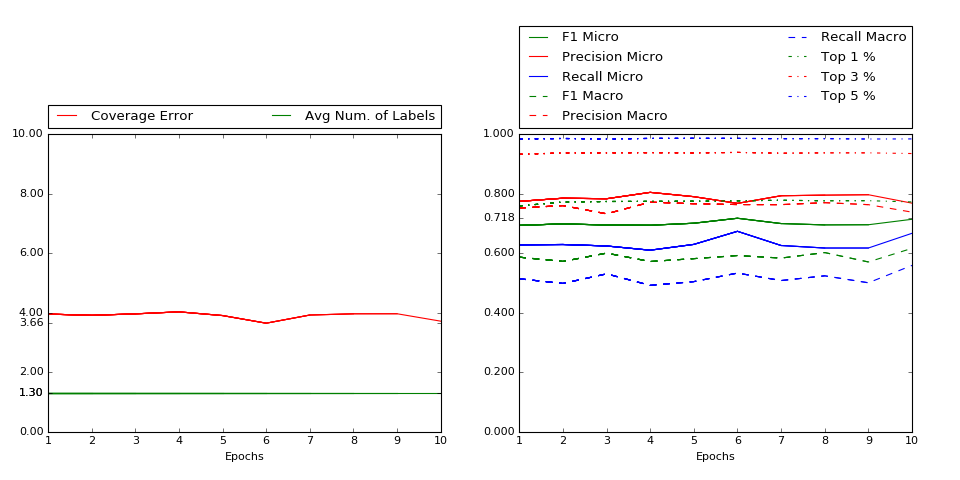

CPU times: user 37.1 s, sys: 32.5 s, total: 1min 9s
Wall time: 2min 24s


2017-01-02 00:44:14,680 : INFO : Getting Validation Embeddings
2017-01-02 00:44:14,682 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.070, Avg Labels: 1.290, 
		 Top 1: 0.753, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.683, F1 Macro: 0.527, Total Pos: 51,173


2017-01-02 00:44:15,297 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.962, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.694, F1 Macro: 0.587, Total Pos: 13,065
CPU times: user 35.9 s, sys: 34 s, total: 1min 9s


2017-01-02 00:46:44,708 : INFO : Getting Validation Embeddings
2017-01-02 00:46:44,710 : INFO : ===== Loading validation vectors


Wall time: 2min 24s
** Training Metrics: Cov Err: 4.106, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.680, F1 Macro: 0.587, Total Pos: 50,038


2017-01-02 00:46:45,481 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.921, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.699, F1 Macro: 0.573, Total Pos: 12,908
CPU times: user 36.1 s, sys: 33.6 s, total: 1min 9s


2017-01-02 00:49:13,858 : INFO : Getting Validation Embeddings
2017-01-02 00:49:13,859 : INFO : ===== Loading validation vectors


Wall time: 2min 23s
** Training Metrics: Cov Err: 4.227, Avg Labels: 1.290, 
		 Top 1: 0.763, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.674, F1 Macro: 0.573, Total Pos: 47,498


2017-01-02 00:49:14,521 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.970, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.938, Top 5: 0.984, 
		 F1 Micro: 0.696, F1 Macro: 0.601, Total Pos: 12,837
CPU times: user 34.7 s, sys: 32.2 s, total: 1min 6s
Wall time: 2min 18s


2017-01-02 00:51:37,993 : INFO : Getting Validation Embeddings
2017-01-02 00:51:37,998 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.330, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.666, F1 Macro: 0.601, Total Pos: 45,289


2017-01-02 00:51:38,780 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.037, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.939, Top 5: 0.987, 
		 F1 Micro: 0.695, F1 Macro: 0.573, Total Pos: 12,211
CPU times: user 37 s, sys: 33.7 s, total: 1min 10s
Wall time: 2min 24s


2017-01-02 00:54:08,002 : INFO : Getting Validation Embeddings
2017-01-02 00:54:08,004 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.163, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.679, F1 Macro: 0.573, Total Pos: 48,142


2017-01-02 00:54:08,595 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.913, Avg Labels: 1.300, 
		 Top 1: 0.776, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.702, F1 Macro: 0.583, Total Pos: 12,832
CPU times: user 35.8 s, sys: 32.6 s, total: 1min 8s
Wall time: 2min 21s


2017-01-02 00:56:34,376 : INFO : Getting Validation Embeddings
2017-01-02 00:56:34,378 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.905, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.694, F1 Macro: 0.583, Total Pos: 54,298


2017-01-02 00:56:35,019 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.656, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.939, Top 5: 0.987, 
		 F1 Micro: 0.718, F1 Macro: 0.593, Total Pos: 14,130
CPU times: user 35.8 s, sys: 33.1 s, total: 1min 8s
Wall time: 2min 23s


2017-01-02 00:59:03,061 : INFO : Getting Validation Embeddings
2017-01-02 00:59:03,066 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.198, Avg Labels: 1.290, 
		 Top 1: 0.763, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.676, F1 Macro: 0.593, Total Pos: 48,172


2017-01-02 00:59:03,847 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.930, Avg Labels: 1.300, 
		 Top 1: 0.779, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.700, F1 Macro: 0.584, Total Pos: 12,706
CPU times: user 36.1 s, sys: 33.5 s, total: 1min 9s


2017-01-02 01:01:31,443 : INFO : Getting Validation Embeddings
2017-01-02 01:01:31,445 : INFO : ===== Loading validation vectors


Wall time: 2min 23s
** Training Metrics: Cov Err: 4.227, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.672, F1 Macro: 0.584, Total Pos: 47,418


2017-01-02 01:01:32,080 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.972, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.696, F1 Macro: 0.603, Total Pos: 12,503
CPU times: user 36.8 s, sys: 34.5 s, total: 1min 11s


2017-01-02 01:04:04,056 : INFO : Getting Validation Embeddings
2017-01-02 01:04:04,057 : INFO : ===== Loading validation vectors


Wall time: 2min 28s
** Training Metrics: Cov Err: 4.226, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.674, F1 Macro: 0.603, Total Pos: 46,752


2017-01-02 01:04:04,804 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.973, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.696, F1 Macro: 0.571, Total Pos: 12,481
CPU times: user 35 s, sys: 32.9 s, total: 1min 7s
Wall time: 2min 21s


2017-01-02 01:06:30,560 : INFO : Getting Validation Embeddings
2017-01-02 01:06:30,561 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.012, Avg Labels: 1.290, 
		 Top 1: 0.762, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.691, F1 Macro: 0.571, Total Pos: 51,661


2017-01-02 01:06:31,140 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.724, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.715, F1 Macro: 0.617, Total Pos: 13,976
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_121 (Dropout)            (None, 200)    

<IPython.core.display.Javascript object>


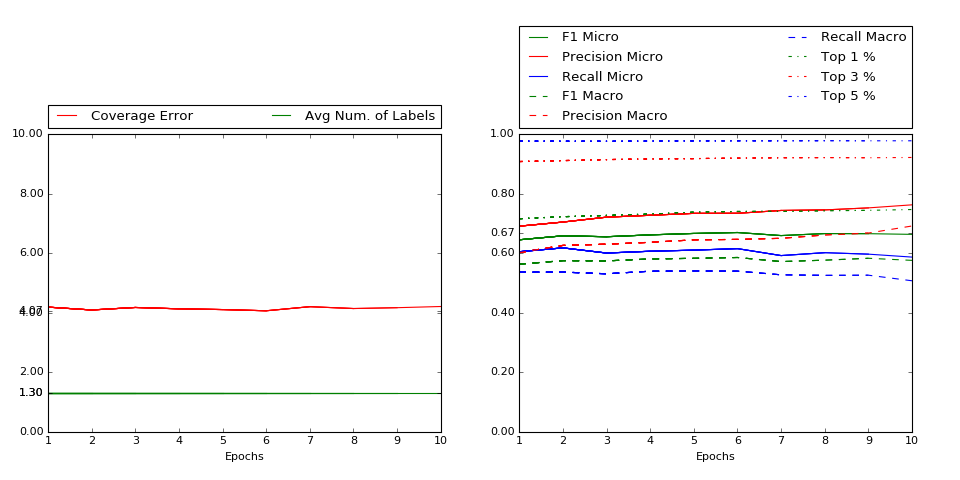

CPU times: user 15.7 s, sys: 1.92 s, total: 17.6 s
Wall time: 17.9 s


2017-01-02 01:06:53,794 : INFO : Getting Validation Embeddings
2017-01-02 01:06:53,796 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.425, Avg Labels: 1.290, 
		 Top 1: 0.722, Top 3: 0.917, Top 5: 0.980, 
		 F1 Micro: 0.639, F1 Macro: 0.617, Total Pos: 49,430


2017-01-02 01:06:54,522 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.196, Avg Labels: 1.300, 
		 Top 1: 0.717, Top 3: 0.909, Top 5: 0.978, 
		 F1 Micro: 0.646, F1 Macro: 0.564, Total Pos: 14,098
CPU times: user 18.3 s, sys: 1.84 s, total: 20.2 s
Wall time: 19 s


2017-01-02 01:07:17,738 : INFO : Getting Validation Embeddings
2017-01-02 01:07:17,740 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.232, Avg Labels: 1.290, 
		 Top 1: 0.732, Top 3: 0.921, Top 5: 0.980, 
		 F1 Micro: 0.659, F1 Macro: 0.564, Total Pos: 52,164


2017-01-02 01:07:18,367 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.100, Avg Labels: 1.300, 
		 Top 1: 0.724, Top 3: 0.912, Top 5: 0.977, 
		 F1 Micro: 0.659, F1 Macro: 0.576, Total Pos: 14,117
CPU times: user 18.4 s, sys: 1.98 s, total: 20.4 s
Wall time: 19.2 s


2017-01-02 01:07:41,474 : INFO : Getting Validation Embeddings
2017-01-02 01:07:41,476 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.199, Avg Labels: 1.290, 
		 Top 1: 0.739, Top 3: 0.924, Top 5: 0.982, 
		 F1 Micro: 0.665, F1 Macro: 0.576, Total Pos: 51,201


2017-01-02 01:07:42,069 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.185, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.915, Top 5: 0.977, 
		 F1 Micro: 0.656, F1 Macro: 0.575, Total Pos: 13,407
CPU times: user 19.9 s, sys: 1.91 s, total: 21.8 s
Wall time: 20.5 s


2017-01-02 01:08:05,721 : INFO : Getting Validation Embeddings
2017-01-02 01:08:05,722 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.117, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.674, F1 Macro: 0.575, Total Pos: 51,900


2017-01-02 01:08:06,299 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.139, Avg Labels: 1.300, 
		 Top 1: 0.732, Top 3: 0.918, Top 5: 0.978, 
		 F1 Micro: 0.662, F1 Macro: 0.581, Total Pos: 13,425
CPU times: user 17.1 s, sys: 1.85 s, total: 18.9 s
Wall time: 18 s

2017-01-02 01:08:28,127 : INFO : Getting Validation Embeddings
2017-01-02 01:08:28,129 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.045, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.682, F1 Macro: 0.581, Total Pos: 53,022


2017-01-02 01:08:28,936 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.114, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.919, Top 5: 0.978, 
		 F1 Micro: 0.667, F1 Macro: 0.584, Total Pos: 13,388
CPU times: user 15.3 s, sys: 1.84 s, total: 17.1 s
Wall time: 16.2 s


2017-01-02 01:08:48,651 : INFO : Getting Validation Embeddings
2017-01-02 01:08:48,653 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.941, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.690, F1 Macro: 0.584, Total Pos: 54,401


2017-01-02 01:08:49,302 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.074, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.920, Top 5: 0.978, 
		 F1 Micro: 0.670, F1 Macro: 0.586, Total Pos: 13,496
CPU times: user 19.4 s, sys: 2.25 s, total: 21.6 s
Wall time: 20.3 s


2017-01-02 01:09:12,922 : INFO : Getting Validation Embeddings
2017-01-02 01:09:12,923 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.037, Avg Labels: 1.290, 
		 Top 1: 0.761, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.686, F1 Macro: 0.586, Total Pos: 51,723


2017-01-02 01:09:13,552 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.211, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.660, F1 Macro: 0.573, Total Pos: 12,818
CPU times: user 16 s, sys: 1.71 s, total: 17.8 s
Wall time: 16.8 s


2017-01-02 01:09:33,504 : INFO : Getting Validation Embeddings
2017-01-02 01:09:33,506 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.937, Avg Labels: 1.290, 
		 Top 1: 0.764, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.694, F1 Macro: 0.573, Total Pos: 53,319


2017-01-02 01:09:34,256 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.149, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.667, F1 Macro: 0.577, Total Pos: 12,997
CPU times: user 19.7 s, sys: 1.88 s, total: 21.6 s
Wall time: 20.4 s


2017-01-02 01:09:58,151 : INFO : Getting Validation Embeddings
2017-01-02 01:09:58,153 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.947, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.696, F1 Macro: 0.577, Total Pos: 52,402


2017-01-02 01:09:58,826 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.177, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.666, F1 Macro: 0.584, Total Pos: 12,773
CPU times: user 14.2 s, sys: 1.43 s, total: 15.6 s

2017-01-02 01:10:17,377 : INFO : Getting Validation Embeddings
2017-01-02 01:10:17,378 : INFO : ===== Loading validation vectors



Wall time: 14.9 s
** Training Metrics: Cov Err: 3.945, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.697, F1 Macro: 0.584, Total Pos: 52,226


2017-01-02 01:10:18,019 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.217, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.664, F1 Macro: 0.577, Total Pos: 12,393
========== 1st Layer Size: 200, 1st Layer Activation: linear, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 200)  

<IPython.core.display.Javascript object>


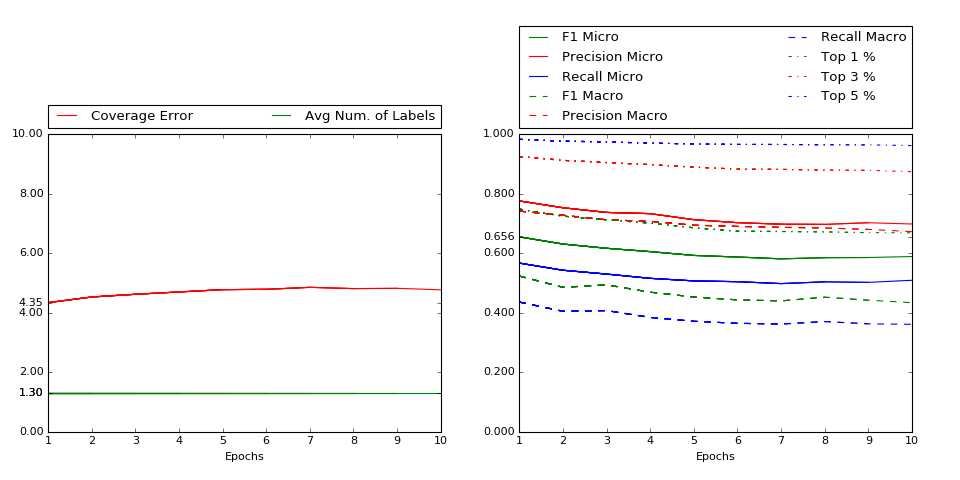

CPU times: user 25.9 s, sys: 9.72 s, total: 35.6 s
Wall time: 1min 13s


2017-01-02 01:11:36,650 : INFO : Getting Validation Embeddings
2017-01-02 01:11:36,651 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.464, Avg Labels: 1.290, 
		 Top 1: 0.817, Top 3: 0.955, Top 5: 0.991, 
		 F1 Micro: 0.751, F1 Macro: 0.577, Total Pos: 56,387


2017-01-02 01:11:37,301 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.346, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.926, Top 5: 0.983, 
		 F1 Micro: 0.656, F1 Macro: 0.524, Total Pos: 11,766
CPU times: user 24.6 s, sys: 10.2 s, total: 34.8 s
Wall time: 1min 12s

2017-01-02 01:12:53,988 : INFO : Getting Validation Embeddings
2017-01-02 01:12:53,993 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.262, Avg Labels: 1.290, 
		 Top 1: 0.839, Top 3: 0.962, Top 5: 0.993, 
		 F1 Micro: 0.778, F1 Macro: 0.524, Total Pos: 57,604


2017-01-02 01:12:54,737 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.537, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.913, Top 5: 0.977, 
		 F1 Micro: 0.632, F1 Macro: 0.486, Total Pos: 11,610
CPU times: user 25.8 s, sys: 10 s, total: 35.9 s
Wall time: 1min 13s


2017-01-02 01:14:12,767 : INFO : Getting Validation Embeddings
2017-01-02 01:14:12,768 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.132, Avg Labels: 1.290, 
		 Top 1: 0.849, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.789, F1 Macro: 0.486, Total Pos: 59,526


2017-01-02 01:14:13,739 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.627, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.905, Top 5: 0.975, 
		 F1 Micro: 0.617, F1 Macro: 0.494, Total Pos: 11,577
CPU times: user 24.8 s, sys: 9.78 s, total: 34.6 s
Wall time: 1min 11s


2017-01-02 01:15:29,602 : INFO : Getting Validation Embeddings
2017-01-02 01:15:29,603 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.131, Avg Labels: 1.290, 
		 Top 1: 0.857, Top 3: 0.967, Top 5: 0.994, 
		 F1 Micro: 0.793, F1 Macro: 0.494, Total Pos: 58,464


2017-01-02 01:15:30,225 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.706, Avg Labels: 1.300, 
		 Top 1: 0.702, Top 3: 0.898, Top 5: 0.971, 
		 F1 Micro: 0.606, F1 Macro: 0.470, Total Pos: 11,327
CPU times: user 24.8 s, sys: 9.75 s, total: 34.6 s
Wall time: 1min 11s


2017-01-02 01:16:46,168 : INFO : Getting Validation Embeddings
2017-01-02 01:16:46,170 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.027, Avg Labels: 1.290, 
		 Top 1: 0.864, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.801, F1 Macro: 0.470, Total Pos: 59,757


2017-01-02 01:16:46,902 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.784, Avg Labels: 1.300, 
		 Top 1: 0.686, Top 3: 0.890, Top 5: 0.968, 
		 F1 Micro: 0.593, F1 Macro: 0.454, Total Pos: 11,455
CPU times: user 25.3 s, sys: 9.98 s, total: 35.2 s
Wall time: 1min 12s


2017-01-02 01:18:03,810 : INFO : Getting Validation Embeddings
2017-01-02 01:18:03,812 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.067, Avg Labels: 1.290, 
		 Top 1: 0.862, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.800, F1 Macro: 0.454, Total Pos: 58,746


2017-01-02 01:18:04,386 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.795, Avg Labels: 1.300, 
		 Top 1: 0.675, Top 3: 0.883, Top 5: 0.966, 
		 F1 Micro: 0.588, F1 Macro: 0.444, Total Pos: 11,558
CPU times: user 26.1 s, sys: 10.1 s, total: 36.2 s
Wall time: 1min 14s


2017-01-02 01:19:22,944 : INFO : Getting Validation Embeddings
2017-01-02 01:19:22,946 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.107, Avg Labels: 1.290, 
		 Top 1: 0.865, Top 3: 0.967, Top 5: 0.995, 
		 F1 Micro: 0.799, F1 Macro: 0.444, Total Pos: 57,823


2017-01-02 01:19:23,590 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.861, Avg Labels: 1.300, 
		 Top 1: 0.674, Top 3: 0.883, Top 5: 0.966, 
		 F1 Micro: 0.582, F1 Macro: 0.441, Total Pos: 11,494
CPU times: user 24.3 s, sys: 9.46 s, total: 33.7 s


2017-01-02 01:20:37,051 : INFO : Getting Validation Embeddings
2017-01-02 01:20:37,053 : INFO : ===== Loading validation vectors


Wall time: 1min 9s
** Training Metrics: Cov Err: 2.974, Avg Labels: 1.290, 
		 Top 1: 0.864, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.804, F1 Macro: 0.441, Total Pos: 60,900


2017-01-02 01:20:37,860 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.818, Avg Labels: 1.300, 
		 Top 1: 0.672, Top 3: 0.880, Top 5: 0.965, 
		 F1 Micro: 0.586, F1 Macro: 0.453, Total Pos: 11,642
CPU times: user 25.2 s, sys: 9.78 s, total: 34.9 s
Wall time: 1min 13s


2017-01-02 01:21:55,454 : INFO : Getting Validation Embeddings
2017-01-02 01:21:55,456 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.051, Avg Labels: 1.290, 
		 Top 1: 0.862, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.800, F1 Macro: 0.453, Total Pos: 59,408


2017-01-02 01:21:56,102 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.828, Avg Labels: 1.300, 
		 Top 1: 0.670, Top 3: 0.879, Top 5: 0.965, 
		 F1 Micro: 0.586, F1 Macro: 0.443, Total Pos: 11,509
CPU times: user 25.5 s, sys: 10.2 s, total: 35.8 s

2017-01-02 01:23:13,753 : INFO : Getting Validation Embeddings
2017-01-02 01:23:13,755 : INFO : ===== Loading validation vectors



Wall time: 1min 14s
** Training Metrics: Cov Err: 3.035, Avg Labels: 1.290, 
		 Top 1: 0.859, Top 3: 0.967, Top 5: 0.995, 
		 F1 Micro: 0.797, F1 Macro: 0.443, Total Pos: 60,490


2017-01-02 01:23:14,341 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.777, Avg Labels: 1.300, 
		 Top 1: 0.669, Top 3: 0.875, Top 5: 0.963, 
		 F1 Micro: 0.590, F1 Macro: 0.435, Total Pos: 11,740
========== 1st Layer Size: 500, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 50

<IPython.core.display.Javascript object>


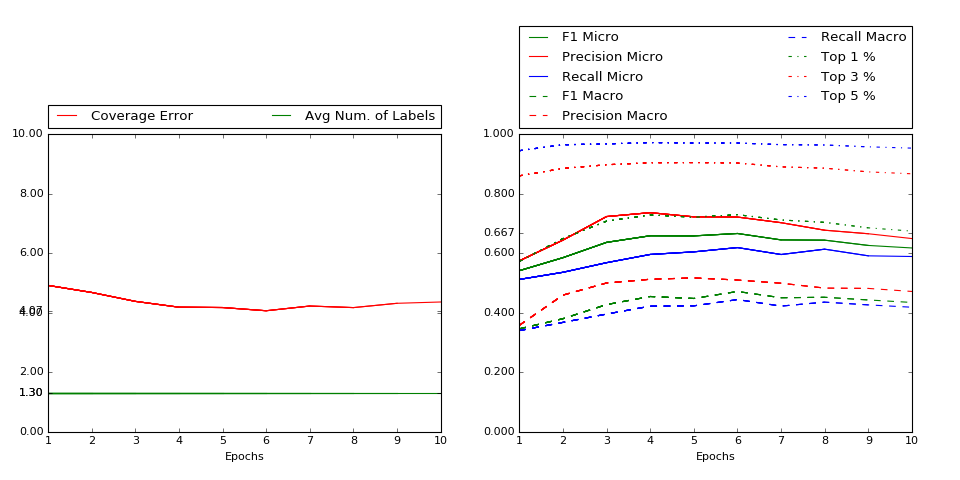

CPU times: user 33.6 s, sys: 26.8 s, total: 1min


2017-01-02 01:25:24,095 : INFO : Getting Validation Embeddings
2017-01-02 01:25:24,096 : INFO : ===== Loading validation vectors


Wall time: 2min 3s
** Training Metrics: Cov Err: 4.916, Avg Labels: 1.290, 
		 Top 1: 0.575, Top 3: 0.864, Top 5: 0.949, 
		 F1 Micro: 0.545, F1 Macro: 0.435, Total Pos: 57,102


2017-01-02 01:25:24,839 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.926, Avg Labels: 1.300, 
		 Top 1: 0.573, Top 3: 0.861, Top 5: 0.945, 
		 F1 Micro: 0.542, F1 Macro: 0.347, Total Pos: 14,349
CPU times: user 31.8 s, sys: 26.1 s, total: 57.9 s
Wall time: 2min


2017-01-02 01:27:29,822 : INFO : Getting Validation Embeddings
2017-01-02 01:27:29,824 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.804, Avg Labels: 1.290, 
		 Top 1: 0.652, Top 3: 0.891, Top 5: 0.966, 
		 F1 Micro: 0.579, F1 Macro: 0.347, Total Pos: 51,079


2017-01-02 01:27:30,454 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.690, Avg Labels: 1.300, 
		 Top 1: 0.650, Top 3: 0.886, Top 5: 0.965, 
		 F1 Micro: 0.586, F1 Macro: 0.381, Total Pos: 13,397
CPU times: user 33.2 s, sys: 27.4 s, total: 1min
Wall time: 2min 5s

2017-01-02 01:29:40,390 : INFO : Getting Validation Embeddings
2017-01-02 01:29:40,392 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.406, Avg Labels: 1.290, 
		 Top 1: 0.722, Top 3: 0.907, Top 5: 0.971, 
		 F1 Micro: 0.641, F1 Macro: 0.381, Total Pos: 48,506


2017-01-02 01:29:41,189 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.390, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.898, Top 5: 0.968, 
		 F1 Micro: 0.637, F1 Macro: 0.428, Total Pos: 12,650
CPU times: user 31.1 s, sys: 26.1 s, total: 57.1 s
Wall time: 1min 58s


2017-01-02 01:31:42,824 : INFO : Getting Validation Embeddings
2017-01-02 01:31:42,826 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.108, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.918, Top 5: 0.976, 
		 F1 Micro: 0.678, F1 Macro: 0.428, Total Pos: 50,230


2017-01-02 01:31:43,401 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.194, Avg Labels: 1.300, 
		 Top 1: 0.729, Top 3: 0.905, Top 5: 0.973, 
		 F1 Micro: 0.659, F1 Macro: 0.455, Total Pos: 13,029
CPU times: user 31.9 s, sys: 25.7 s, total: 57.6 s
Wall time: 1min 58s


2017-01-02 01:33:46,634 : INFO : Getting Validation Embeddings
2017-01-02 01:33:46,635 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.932, Avg Labels: 1.290, 
		 Top 1: 0.774, Top 3: 0.925, Top 5: 0.978, 
		 F1 Micro: 0.701, F1 Macro: 0.455, Total Pos: 51,816


2017-01-02 01:33:47,373 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.182, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.905, Top 5: 0.971, 
		 F1 Micro: 0.659, F1 Macro: 0.449, Total Pos: 13,475
CPU times: user 31.3 s, sys: 26.1 s, total: 57.4 s
Wall time: 1min 59s


2017-01-02 01:35:51,271 : INFO : Getting Validation Embeddings
2017-01-02 01:35:51,273 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.664, Avg Labels: 1.290, 
		 Top 1: 0.801, Top 3: 0.935, Top 5: 0.981, 
		 F1 Micro: 0.732, F1 Macro: 0.449, Total Pos: 53,569


2017-01-02 01:35:52,049 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.075, Avg Labels: 1.300, 
		 Top 1: 0.730, Top 3: 0.904, Top 5: 0.971, 
		 F1 Micro: 0.667, F1 Macro: 0.472, Total Pos: 13,811
CPU times: user 31.7 s, sys: 26.1 s, total: 57.9 s
Wall time: 1min 59s


2017-01-02 01:37:56,831 : INFO : Getting Validation Embeddings
2017-01-02 01:37:56,833 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.574, Avg Labels: 1.290, 
		 Top 1: 0.818, Top 3: 0.940, Top 5: 0.983, 
		 F1 Micro: 0.750, F1 Macro: 0.472, Total Pos: 52,810


2017-01-02 01:37:57,757 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.233, Avg Labels: 1.300, 
		 Top 1: 0.712, Top 3: 0.891, Top 5: 0.966, 
		 F1 Micro: 0.645, F1 Macro: 0.451, Total Pos: 13,649
CPU times: user 32 s, sys: 27.1 s, total: 59.1 s
Wall time: 2min 1s


2017-01-02 01:40:04,017 : INFO : Getting Validation Embeddings
2017-01-02 01:40:04,019 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.261, Avg Labels: 1.290, 
		 Top 1: 0.836, Top 3: 0.945, Top 5: 0.985, 
		 F1 Micro: 0.778, F1 Macro: 0.451, Total Pos: 56,615


2017-01-02 01:40:04,621 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.180, Avg Labels: 1.300, 
		 Top 1: 0.704, Top 3: 0.886, Top 5: 0.964, 
		 F1 Micro: 0.645, F1 Macro: 0.453, Total Pos: 14,583
CPU times: user 32 s, sys: 26.7 s, total: 58.7 s


2017-01-02 01:42:10,936 : INFO : Getting Validation Embeddings
2017-01-02 01:42:10,938 : INFO : ===== Loading validation vectors


Wall time: 2min 1s
** Training Metrics: Cov Err: 3.142, Avg Labels: 1.290, 
		 Top 1: 0.853, Top 3: 0.950, Top 5: 0.987, 
		 F1 Micro: 0.797, F1 Macro: 0.453, Total Pos: 56,181


2017-01-02 01:42:11,737 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.325, Avg Labels: 1.300, 
		 Top 1: 0.686, Top 3: 0.874, Top 5: 0.958, 
		 F1 Micro: 0.627, F1 Macro: 0.444, Total Pos: 14,303
CPU times: user 32.4 s, sys: 26.7 s, total: 59.1 s


2017-01-02 01:44:17,809 : INFO : Getting Validation Embeddings
2017-01-02 01:44:17,812 : INFO : ===== Loading validation vectors


Wall time: 2min 1s
** Training Metrics: Cov Err: 3.030, Avg Labels: 1.290, 
		 Top 1: 0.863, Top 3: 0.953, Top 5: 0.987, 
		 F1 Micro: 0.811, F1 Macro: 0.444, Total Pos: 56,589


2017-01-02 01:44:18,424 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.369, Avg Labels: 1.300, 
		 Top 1: 0.675, Top 3: 0.868, Top 5: 0.954, 
		 F1 Micro: 0.618, F1 Macro: 0.435, Total Pos: 14,604
========== 1st Layer Size: 200, 1st Layer Activation: linear, 
 2nd Layer Size: 1000, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_122 (Dropout)            (None, 200)  

<IPython.core.display.Javascript object>


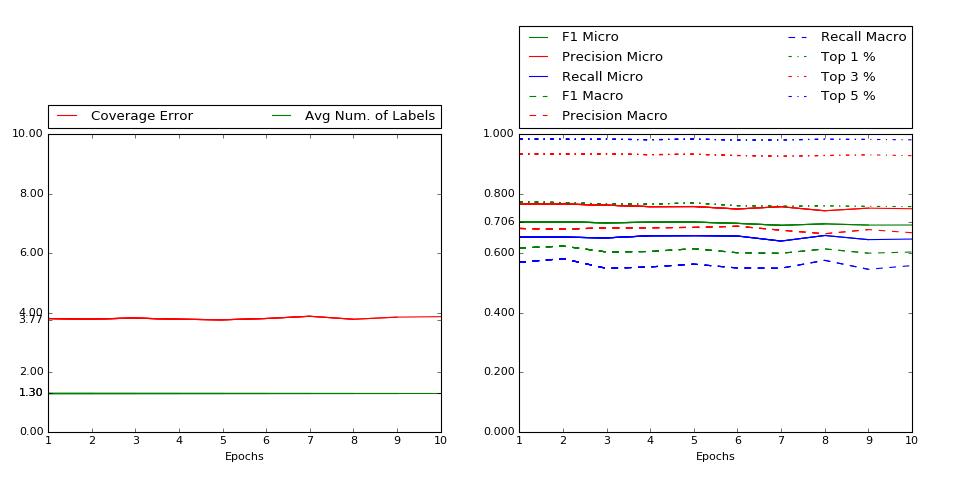

CPU times: user 45 s, sys: 27.6 s, total: 1min 12s
Wall time: 2min 19s


2017-01-02 01:46:45,451 : INFO : Getting Validation Embeddings
2017-01-02 01:46:45,452 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.574, Avg Labels: 1.290, 
		 Top 1: 0.793, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.732, F1 Macro: 0.435, Total Pos: 57,285


2017-01-02 01:46:46,141 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.813, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.706, F1 Macro: 0.618, Total Pos: 13,763
CPU times: user 34.7 s, sys: 26.1 s, total: 1min


2017-01-02 01:48:56,210 : INFO : Getting Validation Embeddings
2017-01-02 01:48:56,211 : INFO : ===== Loading validation vectors


Wall time: 2min 6s
** Training Metrics: Cov Err: 3.634, Avg Labels: 1.290, 
		 Top 1: 0.794, Top 3: 0.945, Top 5: 0.987, 
		 F1 Micro: 0.731, F1 Macro: 0.618, Total Pos: 55,253


2017-01-02 01:48:56,803 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.798, Avg Labels: 1.300, 
		 Top 1: 0.771, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.706, F1 Macro: 0.625, Total Pos: 13,756
CPU times: user 34.4 s, sys: 26.3 s, total: 1min
Wall time: 2min 6s


2017-01-02 01:51:08,266 : INFO : Getting Validation Embeddings
2017-01-02 01:51:08,268 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.719, Avg Labels: 1.290, 
		 Top 1: 0.795, Top 3: 0.946, Top 5: 0.988, 
		 F1 Micro: 0.725, F1 Macro: 0.625, Total Pos: 53,338


2017-01-02 01:51:08,847 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.826, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.703, F1 Macro: 0.605, Total Pos: 13,776
CPU times: user 35.1 s, sys: 26.2 s, total: 1min 1s
Wall time: 2min 6s


2017-01-02 01:53:20,209 : INFO : Getting Validation Embeddings
2017-01-02 01:53:20,211 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.716, Avg Labels: 1.290, 
		 Top 1: 0.792, Top 3: 0.945, Top 5: 0.988, 
		 F1 Micro: 0.723, F1 Macro: 0.605, Total Pos: 54,307


2017-01-02 01:53:20,897 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.789, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.932, Top 5: 0.982, 
		 F1 Micro: 0.705, F1 Macro: 0.607, Total Pos: 14,016
CPU times: user 34.5 s, sys: 25.5 s, total: 1min
Wall time: 2min 4s


2017-01-02 01:55:29,376 : INFO : Getting Validation Embeddings
2017-01-02 01:55:29,382 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.834, Avg Labels: 1.290, 
		 Top 1: 0.783, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.710, F1 Macro: 0.607, Total Pos: 52,950


2017-01-02 01:55:30,233 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.770, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.705, F1 Macro: 0.616, Total Pos: 14,019
CPU times: user 34.1 s, sys: 24.9 s, total: 59.1 s
Wall time: 2min 2s


2017-01-02 01:57:37,535 : INFO : Getting Validation Embeddings
2017-01-02 01:57:37,538 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.808, Avg Labels: 1.290, 
		 Top 1: 0.780, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.711, F1 Macro: 0.616, Total Pos: 53,866


2017-01-02 01:57:38,156 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.814, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.929, Top 5: 0.981, 
		 F1 Micro: 0.701, F1 Macro: 0.602, Total Pos: 14,146
CPU times: user 34.6 s, sys: 25.9 s, total: 1min
Wall time: 2min 6s


2017-01-02 01:59:49,470 : INFO : Getting Validation Embeddings
2017-01-02 01:59:49,472 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.990, Avg Labels: 1.290, 
		 Top 1: 0.772, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.694, F1 Macro: 0.602, Total Pos: 51,077


2017-01-02 01:59:50,218 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.889, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.695, F1 Macro: 0.601, Total Pos: 13,641
CPU times: user 33.6 s, sys: 25.6 s, total: 59.2 s
Wall time: 2min 2s


2017-01-02 02:01:57,829 : INFO : Getting Validation Embeddings
2017-01-02 02:01:57,831 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.764, Avg Labels: 1.290, 
		 Top 1: 0.775, Top 3: 0.939, Top 5: 0.985, 
		 F1 Micro: 0.710, F1 Macro: 0.601, Total Pos: 55,610


2017-01-02 02:01:58,645 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.789, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.929, Top 5: 0.984, 
		 F1 Micro: 0.699, F1 Macro: 0.615, Total Pos: 14,297
CPU times: user 34.7 s, sys: 26.4 s, total: 1min 1s
Wall time: 2min 5s


2017-01-02 02:04:10,202 : INFO : Getting Validation Embeddings
2017-01-02 02:04:10,204 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.872, Avg Labels: 1.290, 
		 Top 1: 0.775, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.704, F1 Macro: 0.615, Total Pos: 53,009


2017-01-02 02:04:10,996 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.860, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.695, F1 Macro: 0.601, Total Pos: 13,831
CPU times: user 35.7 s, sys: 26.7 s, total: 1min 2s
Wall time: 2min 9s


2017-01-02 02:06:25,850 : INFO : Getting Validation Embeddings
2017-01-02 02:06:25,852 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.899, Avg Labels: 1.290, 
		 Top 1: 0.770, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.699, F1 Macro: 0.601, Total Pos: 53,327


2017-01-02 02:06:26,534 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 3.876, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.696, F1 Macro: 0.605, Total Pos: 13,911
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 200, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 200) 

<IPython.core.display.Javascript object>


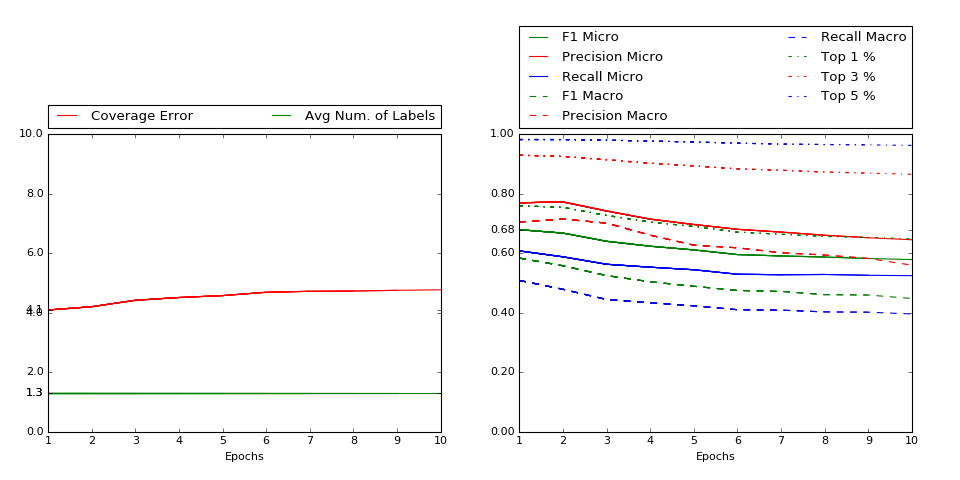

CPU times: user 27.1 s, sys: 10.5 s, total: 37.6 s


2017-01-02 02:07:51,529 : INFO : Getting Validation Embeddings
2017-01-02 02:07:51,537 : INFO : ===== Loading validation vectors


Wall time: 1min 18s
** Training Metrics: Cov Err: 3.688, Avg Labels: 1.290, 
		 Top 1: 0.782, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.723, F1 Macro: 0.605, Total Pos: 55,693


2017-01-02 02:07:52,330 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.100, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.680, F1 Macro: 0.584, Total Pos: 12,717
CPU times: user 26 s, sys: 9.42 s, total: 35.5 s
Wall time: 1min 13s


2017-01-02 02:09:09,864 : INFO : Getting Validation Embeddings
2017-01-02 02:09:09,866 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.336, Avg Labels: 1.290, 
		 Top 1: 0.829, Top 3: 0.957, Top 5: 0.992, 
		 F1 Micro: 0.767, F1 Macro: 0.584, Total Pos: 56,745


2017-01-02 02:09:10,621 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.210, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.926, Top 5: 0.983, 
		 F1 Micro: 0.668, F1 Macro: 0.559, Total Pos: 12,256
CPU times: user 27.4 s, sys: 9.95 s, total: 37.3 s
Wall time: 1min 17s


2017-01-02 02:10:32,834 : INFO : Getting Validation Embeddings
2017-01-02 02:10:32,836 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.001, Avg Labels: 1.290, 
		 Top 1: 0.867, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.807, F1 Macro: 0.559, Total Pos: 58,428


2017-01-02 02:10:33,552 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.426, Avg Labels: 1.300, 
		 Top 1: 0.728, Top 3: 0.915, Top 5: 0.981, 
		 F1 Micro: 0.641, F1 Macro: 0.526, Total Pos: 12,218
CPU times: user 26.1 s, sys: 9.66 s, total: 35.8 s

2017-01-02 02:11:52,641 : INFO : Getting Validation Embeddings
2017-01-02 02:11:52,644 : INFO : ===== Loading validation vectors



Wall time: 1min 14s
** Training Metrics: Cov Err: 2.687, Avg Labels: 1.290, 
		 Top 1: 0.901, Top 3: 0.976, Top 5: 0.997, 
		 F1 Micro: 0.845, F1 Macro: 0.526, Total Pos: 59,662


2017-01-02 02:11:53,399 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.519, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.903, Top 5: 0.978, 
		 F1 Micro: 0.624, F1 Macro: 0.505, Total Pos: 12,464
CPU times: user 27.7 s, sys: 10.2 s, total: 37.9 s
Wall time: 1min 19s


2017-01-02 02:13:15,600 : INFO : Getting Validation Embeddings
2017-01-02 02:13:15,601 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.401, Avg Labels: 1.290, 
		 Top 1: 0.926, Top 3: 0.983, Top 5: 0.998, 
		 F1 Micro: 0.875, F1 Macro: 0.505, Total Pos: 61,484


2017-01-02 02:13:16,187 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.584, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.894, Top 5: 0.974, 
		 F1 Micro: 0.612, F1 Macro: 0.490, Total Pos: 12,586
CPU times: user 26.2 s, sys: 9.7 s, total: 35.9 s
Wall time: 1min 14s


2017-01-02 02:14:34,491 : INFO : Getting Validation Embeddings
2017-01-02 02:14:34,493 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.219, Avg Labels: 1.290, 
		 Top 1: 0.947, Top 3: 0.988, Top 5: 0.998, 
		 F1 Micro: 0.900, F1 Macro: 0.490, Total Pos: 61,166


2017-01-02 02:14:35,273 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.696, Avg Labels: 1.300, 
		 Top 1: 0.672, Top 3: 0.884, Top 5: 0.971, 
		 F1 Micro: 0.596, F1 Macro: 0.475, Total Pos: 12,530
CPU times: user 26.7 s, sys: 9.8 s, total: 36.5 s
Wall time: 1min 16s


2017-01-02 02:15:56,076 : INFO : Getting Validation Embeddings
2017-01-02 02:15:56,077 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.047, Avg Labels: 1.290, 
		 Top 1: 0.962, Top 3: 0.992, Top 5: 0.999, 
		 F1 Micro: 0.920, F1 Macro: 0.475, Total Pos: 61,512


2017-01-02 02:15:56,866 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.728, Avg Labels: 1.300, 
		 Top 1: 0.665, Top 3: 0.880, Top 5: 0.968, 
		 F1 Micro: 0.592, F1 Macro: 0.472, Total Pos: 12,664
CPU times: user 25.4 s, sys: 9.97 s, total: 35.4 s
Wall time: 1min 13s


2017-01-02 02:17:15,299 : INFO : Getting Validation Embeddings
2017-01-02 02:17:15,301 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.867, Avg Labels: 1.290, 
		 Top 1: 0.974, Top 3: 0.994, Top 5: 0.999, 
		 F1 Micro: 0.939, F1 Macro: 0.472, Total Pos: 62,296


2017-01-02 02:17:16,090 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.737, Avg Labels: 1.300, 
		 Top 1: 0.657, Top 3: 0.874, Top 5: 0.966, 
		 F1 Micro: 0.588, F1 Macro: 0.462, Total Pos: 12,887
CPU times: user 26 s, sys: 9.76 s, total: 35.8 s
Wall time: 1min 13s


2017-01-02 02:18:34,016 : INFO : Getting Validation Embeddings
2017-01-02 02:18:34,018 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 1.731, Avg Labels: 1.290, 
		 Top 1: 0.982, Top 3: 0.996, Top 5: 0.999, 
		 F1 Micro: 0.953, F1 Macro: 0.462, Total Pos: 62,807


2017-01-02 02:18:34,696 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.761, Avg Labels: 1.300, 
		 Top 1: 0.654, Top 3: 0.870, Top 5: 0.965, 
		 F1 Micro: 0.583, F1 Macro: 0.460, Total Pos: 12,984
CPU times: user 26.6 s, sys: 9.96 s, total: 36.5 s
Wall time: 1min 15s

2017-01-02 02:19:54,165 : INFO : Getting Validation Embeddings
2017-01-02 02:19:54,166 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 1.613, Avg Labels: 1.290, 
		 Top 1: 0.989, Top 3: 0.997, Top 5: 1.000, 
		 F1 Micro: 0.966, F1 Macro: 0.460, Total Pos: 63,164


2017-01-02 02:19:54,947 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.779, Avg Labels: 1.300, 
		 Top 1: 0.649, Top 3: 0.866, Top 5: 0.963, 
		 F1 Micro: 0.579, F1 Macro: 0.449, Total Pos: 13,088
========== 1st Layer Size: 50, 1st Layer Activation: tanh, 
 2nd Layer Size: 50, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_123 (Dropout)            (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 50)        

<IPython.core.display.Javascript object>


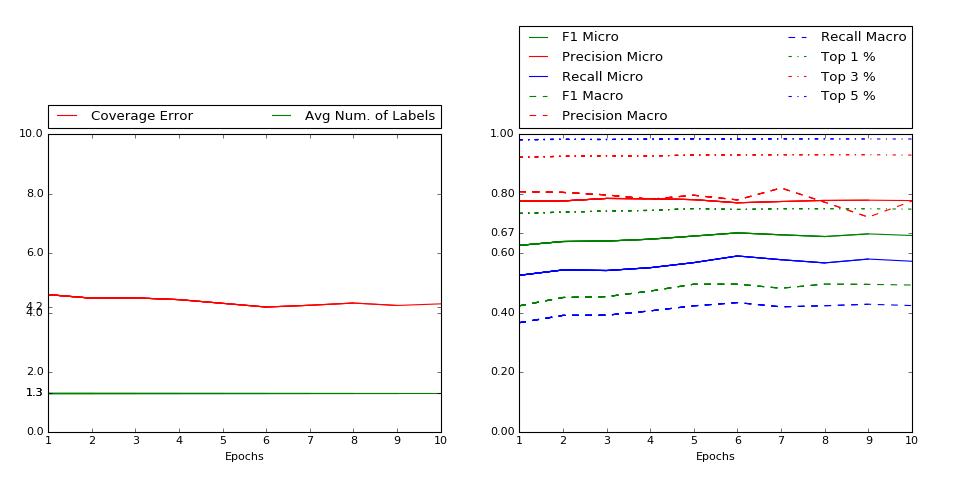

CPU times: user 21.4 s, sys: 2.6 s, total: 24 s
Wall time: 24.5 s


2017-01-02 02:20:24,942 : INFO : Getting Validation Embeddings
2017-01-02 02:20:24,945 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.783, Avg Labels: 1.290, 
		 Top 1: 0.724, Top 3: 0.915, Top 5: 0.977, 
		 F1 Micro: 0.609, F1 Macro: 0.449, Total Pos: 42,285


2017-01-02 02:20:25,678 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.617, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.923, Top 5: 0.982, 
		 F1 Micro: 0.627, F1 Macro: 0.424, Total Pos: 10,931
CPU times: user 21.7 s, sys: 2.44 s, total: 24.2 s


2017-01-02 02:20:52,527 : INFO : Getting Validation Embeddings
2017-01-02 02:20:52,528 : INFO : ===== Loading validation vectors


Wall time: 22.7 s
** Training Metrics: Cov Err: 4.727, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.922, Top 5: 0.979, 
		 F1 Micro: 0.617, F1 Macro: 0.424, Total Pos: 42,448


2017-01-02 02:20:53,144 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.497, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.927, Top 5: 0.983, 
		 F1 Micro: 0.640, F1 Macro: 0.452, Total Pos: 11,288
CPU times: user 21 s, sys: 2.16 s, total: 23.1 s
Wall time: 21.8 s


2017-01-02 02:21:19,489 : INFO : Getting Validation Embeddings
2017-01-02 02:21:19,491 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.698, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.920, Top 5: 0.979, 
		 F1 Micro: 0.620, F1 Macro: 0.452, Total Pos: 42,960


2017-01-02 02:21:20,279 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.507, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.642, F1 Macro: 0.455, Total Pos: 11,129
CPU times: user 20.3 s, sys: 2.1 s, total: 22.4 s
Wall time: 21.1 s


2017-01-02 02:21:45,725 : INFO : Getting Validation Embeddings
2017-01-02 02:21:45,726 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.616, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.922, Top 5: 0.980, 
		 F1 Micro: 0.627, F1 Macro: 0.455, Total Pos: 44,299


2017-01-02 02:21:46,408 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.448, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.927, Top 5: 0.984, 
		 F1 Micro: 0.648, F1 Macro: 0.474, Total Pos: 11,338
CPU times: user 21.2 s, sys: 2.57 s, total: 23.8 s
Wall time: 22.4 s


2017-01-02 02:22:13,264 : INFO : Getting Validation Embeddings
2017-01-02 02:22:13,265 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.523, Avg Labels: 1.290, 
		 Top 1: 0.738, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.637, F1 Macro: 0.474, Total Pos: 45,145


2017-01-02 02:22:13,974 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.324, Avg Labels: 1.300, 
		 Top 1: 0.751, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.658, F1 Macro: 0.497, Total Pos: 11,734
CPU times: user 19.5 s, sys: 2.46 s, total: 22 s
Wall time: 20.8 s

2017-01-02 02:22:39,377 : INFO : Getting Validation Embeddings
2017-01-02 02:22:39,379 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.413, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.647, F1 Macro: 0.497, Total Pos: 47,345


2017-01-02 02:22:40,164 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.199, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.669, F1 Macro: 0.497, Total Pos: 12,360
CPU times: user 20.9 s, sys: 2.32 s, total: 23.2 s


2017-01-02 02:23:06,497 : INFO : Getting Validation Embeddings
2017-01-02 02:23:06,499 : INFO : ===== Loading validation vectors


Wall time: 21.9 s
** Training Metrics: Cov Err: 4.489, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.638, F1 Macro: 0.497, Total Pos: 46,384


2017-01-02 02:23:07,226 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.258, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.663, F1 Macro: 0.483, Total Pos: 12,032
CPU times: user 22.7 s, sys: 2.2 s, total: 24.9 s


2017-01-02 02:23:35,810 : INFO : Getting Validation Embeddings
2017-01-02 02:23:35,812 : INFO : ===== Loading validation vectors


Wall time: 23.5 s
** Training Metrics: Cov Err: 4.522, Avg Labels: 1.290, 
		 Top 1: 0.740, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.636, F1 Macro: 0.483, Total Pos: 45,234


2017-01-02 02:23:36,492 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.333, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.657, F1 Macro: 0.497, Total Pos: 11,754
CPU times: user 20 s, sys: 2.34 s, total: 22.3 s


2017-01-02 02:24:02,331 : INFO : Getting Validation Embeddings
2017-01-02 02:24:02,332 : INFO : ===== Loading validation vectors


Wall time: 21.1 s
** Training Metrics: Cov Err: 4.458, Avg Labels: 1.290, 
		 Top 1: 0.742, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.644, F1 Macro: 0.497, Total Pos: 46,081


2017-01-02 02:24:02,918 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.252, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.666, F1 Macro: 0.496, Total Pos: 12,009
CPU times: user 21.4 s, sys: 2.5 s, total: 23.9 s
Wall time: 22.5 s


2017-01-02 02:24:28,920 : INFO : Getting Validation Embeddings
2017-01-02 02:24:28,921 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.526, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.637, F1 Macro: 0.496, Total Pos: 45,357


2017-01-02 02:24:29,512 : INFO : Evaluating on Validation Data


****** Validation Metrics: Cov Err: 4.306, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.930, Top 5: 0.985, 
		 F1 Micro: 0.660, F1 Macro: 0.494, Total Pos: 11,877
CPU times: user 4h 23min 23s, sys: 2h 18min 42s, total: 6h 42min 6s
Wall time: 11h 55min 54s


In [290]:
%%time
%matplotlib notebook
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))
        
        
    X, y = get_training_data(doc2vec_model, classifications)
    
    
    history_list = []
    
    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)
    
    parameters_used = []
    parameter_results = []
    for parameters in param_sampler:
        
        parameters_used.append(parameters)
        
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        
        print ("===================================================================================\n" + \
              "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
              "Input Dropout: {}, Hidden Dropout: {}" + \
              "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                    second_hidden_layer_size, second_hidden_layer_activation, 
                                                    input_dropout_do, hidden_dropout_do)
        
        doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
        if input_dropout_do:
            hidden = Dropout(0.7)(doc_input)
        hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                       name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
        if hidden_dropout_do:
            hidden = Dropout(0.5)(hidden)
        if second_hidden_layer_size is not None:
            hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                           name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
        softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
        
        model = Model(input=doc_input, output=softmax_output)
        model.compile(optimizer='rmsprop', loss='binary_crossentropy')
        model.summary()
        
        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-acc_{}_2nd-size_{}_2nd-acc_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )

        graph = MetricsGraph()
        graph.init_graph()
        
        epoch_results = []

        for nn_epoch in range(1, NN_MAX_EPOCHS+1):
            %time history = model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, nb_epoch=10, verbose=0)
            yp = model.predict(X, batch_size=NN_BATCH_SIZE)
            yp_binary = get_binary_0_5(yp)
            history_list.append(history)
            #print yp
            training_metrics = get_metrics(y, yp, yp_binary)
            print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
                training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
                training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
                training_metrics['f1_micro'],validation_metrics['f1_macro'],  training_metrics['total_positive'])
            

            # Validation Metrics
            info('Getting Validation Embeddings')
            Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                            validation_docs_list, validation_preprocessed_files_prefix,
                                                            validation_preprocessed_docids_files_prefix)
            info('Evaluating on Validation Data')
            yvp = model.predict(Xv)
            yvp_binary = get_binary_0_5(yvp)
            #print yvp
            validation_metrics = get_metrics(yv, yvp, yvp_binary)
            print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
                validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
                validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
                validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
            
            graph.add_metrics_to_graph(validation_metrics, nn_epoch)
            
            epoch_results.append({'training_metrics': training_metrics, 'validation_metrics':validation_metrics})
            
        parameter_results.append(epoch_results)
            
    break;


<IPython.core.display.Javascript object>


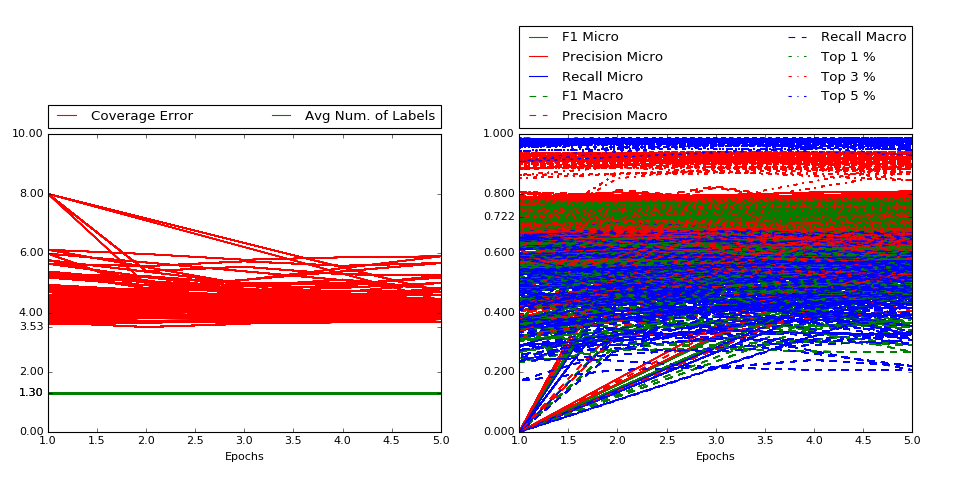

2017-01-01 07:15:24,458 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-01 07:15:24,462 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-01-01 07:15:25,183 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-01-01 07:15:25,184 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.syn1neg.npy with mmap=None
2017-01-01 07:15:25,681 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_s

========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_17 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       dropout_17[0][0]                 
____________________________________________________________________________________________________
hidde

2017-01-01 07:16:31,228 : INFO : Getting Validation Embeddings
2017-01-01 07:16:31,229 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.421, Avg Labels: 1.290, 
		 Top 1: 0.669, Top 3: 0.876, Top 5: 0.953, 
		 F1 Micro: 0.533, Total Pos: 34,734


2017-01-01 07:16:31,862 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.344, Avg Labels: 1.300, 
		 Top 1: 0.678, Top 3: 0.882, Top 5: 0.956, 
		 F1 Micro: 0.541, Total Pos: 8,822
CPU times: user 19.4 s, sys: 9.26 s, total: 28.7 s
Wall time: 58.4 s


2017-01-01 07:17:35,155 : INFO : Getting Validation Embeddings
2017-01-01 07:17:35,157 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.974, Avg Labels: 1.290, 
		 Top 1: 0.708, Top 3: 0.894, Top 5: 0.968, 
		 F1 Micro: 0.591, Total Pos: 39,076


2017-01-01 07:17:35,800 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.830, Avg Labels: 1.300, 
		 Top 1: 0.716, Top 3: 0.899, Top 5: 0.973, 
		 F1 Micro: 0.606, Total Pos: 10,161
CPU times: user 18.6 s, sys: 9.11 s, total: 27.7 s
Wall time: 57.1 s


2017-01-01 07:18:36,936 : INFO : Getting Validation Embeddings
2017-01-01 07:18:36,937 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.860, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.607, Total Pos: 40,170


2017-01-01 07:18:37,523 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.713, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.910, Top 5: 0.977, 
		 F1 Micro: 0.620, Total Pos: 10,527
CPU times: user 18.2 s, sys: 9.04 s, total: 27.2 s
Wall time: 55.9 s


2017-01-01 07:19:37,707 : INFO : Getting Validation Embeddings
2017-01-01 07:19:37,709 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.683, Avg Labels: 1.290, 
		 Top 1: 0.729, Top 3: 0.911, Top 5: 0.976, 
		 F1 Micro: 0.626, Total Pos: 42,257


2017-01-01 07:19:38,518 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.502, Avg Labels: 1.300, 
		 Top 1: 0.733, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.641, Total Pos: 11,159
CPU times: user 19.8 s, sys: 9.4 s, total: 29.2 s
Wall time: 59.4 s


2017-01-01 07:20:42,607 : INFO : Getting Validation Embeddings
2017-01-01 07:20:42,609 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.556, Avg Labels: 1.290, 
		 Top 1: 0.739, Top 3: 0.916, Top 5: 0.978, 
		 F1 Micro: 0.639, Total Pos: 43,480


2017-01-01 07:20:43,268 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.368, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.918, Top 5: 0.980, 
		 F1 Micro: 0.656, Total Pos: 11,443
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_18 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200      

INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 07:20:48,606 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock


CPU times: user 21.3 s, sys: 18 s, total: 39.3 s
Wall time: 1min 25s


2017-01-01 07:22:18,725 : INFO : Getting Validation Embeddings
2017-01-01 07:22:18,729 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.928, Avg Labels: 1.290, 
		 Top 1: 0.720, Top 3: 0.916, Top 5: 0.978, 
		 F1 Micro: 0.596, Total Pos: 40,248


2017-01-01 07:22:19,462 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.600, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.924, Top 5: 0.983, 
		 F1 Micro: 0.630, Total Pos: 10,969
CPU times: user 19 s, sys: 16.1 s, total: 35.2 s
Wall time: 1min 12s


2017-01-01 07:23:38,272 : INFO : Getting Validation Embeddings
2017-01-01 07:23:38,274 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.591, Avg Labels: 1.290, 
		 Top 1: 0.739, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.633, Total Pos: 44,154


2017-01-01 07:23:39,046 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.221, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.667, Total Pos: 12,341
CPU times: user 18.3 s, sys: 15.3 s, total: 33.6 s
Wall time: 1min 9s


2017-01-01 07:24:54,575 : INFO : Getting Validation Embeddings
2017-01-01 07:24:54,577 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.484, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.645, Total Pos: 44,444


2017-01-01 07:24:55,389 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.133, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.678, Total Pos: 12,203
CPU times: user 19.6 s, sys: 16.5 s, total: 36 s
Wall time: 1min 14s


2017-01-01 07:26:15,462 : INFO : Getting Validation Embeddings
2017-01-01 07:26:15,463 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.430, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.650, Total Pos: 45,440


2017-01-01 07:26:16,065 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.056, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.939, Top 5: 0.985, 
		 F1 Micro: 0.685, Total Pos: 12,448
CPU times: user 19.9 s, sys: 16.4 s, total: 36.3 s
Wall time: 1min 14s


2017-01-01 07:27:35,454 : INFO : Getting Validation Embeddings
2017-01-01 07:27:35,456 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.448, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.652, Total Pos: 44,214


2017-01-01 07:27:36,147 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.136, Avg Labels: 1.300, 
		 Top 1: 0.771, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.682, Total Pos: 11,933
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           50500       

2017-01-01 07:28:59,779 : INFO : Getting Validation Embeddings
2017-01-01 07:28:59,781 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.770, Avg Labels: 1.290, 
		 Top 1: 0.735, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.613, Total Pos: 41,811


2017-01-01 07:29:00,537 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.426, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.647, Total Pos: 11,555
CPU times: user 18.7 s, sys: 15.7 s, total: 34.4 s
Wall time: 1min 11s


2017-01-01 07:30:16,258 : INFO : Getting Validation Embeddings
2017-01-01 07:30:16,260 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.331, Avg Labels: 1.290, 
		 Top 1: 0.744, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.652, Total Pos: 49,130


2017-01-01 07:30:16,858 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.041, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.680, Total Pos: 13,108
CPU times: user 19.1 s, sys: 16 s, total: 35.2 s
Wall time: 1min 12s


2017-01-01 07:31:32,886 : INFO : Getting Validation Embeddings
2017-01-01 07:31:32,891 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.412, Avg Labels: 1.290, 
		 Top 1: 0.753, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.655, Total Pos: 45,366


2017-01-01 07:31:33,464 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.101, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.683, Total Pos: 12,334
CPU times: user 19.3 s, sys: 16.5 s, total: 35.7 s
Wall time: 1min 12s


2017-01-01 07:32:50,707 : INFO : Getting Validation Embeddings
2017-01-01 07:32:50,709 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.357, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.658, Total Pos: 46,405


2017-01-01 07:32:51,373 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.042, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.687, Total Pos: 12,515
CPU times: user 19.6 s, sys: 16.2 s, total: 35.8 s
Wall time: 1min 13s


2017-01-01 07:34:09,475 : INFO : Getting Validation Embeddings
2017-01-01 07:34:09,477 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.315, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.660, Total Pos: 47,430


2017-01-01 07:34:10,121 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.027, Avg Labels: 1.300, 
		 Top 1: 0.773, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.689, Total Pos: 12,529
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_20 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       d

2017-01-01 07:35:45,934 : INFO : Getting Validation Embeddings
2017-01-01 07:35:45,936 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.785, Avg Labels: 1.290, 
		 Top 1: 0.741, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.610, Total Pos: 41,512


2017-01-01 07:35:46,518 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.357, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.934, Top 5: 0.986, 
		 F1 Micro: 0.653, Total Pos: 11,922
CPU times: user 20.8 s, sys: 20.7 s, total: 41.4 s
Wall time: 1min 26s


2017-01-01 07:37:19,212 : INFO : Getting Validation Embeddings
2017-01-01 07:37:19,214 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.761, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.930, Top 5: 0.981, 
		 F1 Micro: 0.619, Total Pos: 40,305


2017-01-01 07:37:19,948 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.291, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.664, Total Pos: 11,684
CPU times: user 20.9 s, sys: 21.4 s, total: 42.3 s
Wall time: 1min 27s


2017-01-01 07:38:53,938 : INFO : Getting Validation Embeddings
2017-01-01 07:38:53,940 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.610, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.633, Total Pos: 42,214


2017-01-01 07:38:54,519 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.060, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.684, Total Pos: 12,634
CPU times: user 20.7 s, sys: 20.5 s, total: 41.2 s


2017-01-01 07:40:25,687 : INFO : Getting Validation Embeddings
2017-01-01 07:40:25,689 : INFO : ===== Loading validation vectors


Wall time: 1min 24s
** Training Metrics: Cov Err: 4.606, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.633, Total Pos: 42,604


2017-01-01 07:40:26,533 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.079, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.681, Total Pos: 12,463
CPU times: user 20.3 s, sys: 20.4 s, total: 40.7 s
Wall time: 1min 24s


2017-01-01 07:41:56,883 : INFO : Getting Validation Embeddings
2017-01-01 07:41:56,885 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.481, Avg Labels: 1.290, 
		 Top 1: 0.757, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.644, Total Pos: 44,827


2017-01-01 07:41:57,481 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.907, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.695, Total Pos: 13,281
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_21 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dro

2017-01-01 07:42:23,412 : INFO : Getting Validation Embeddings
2017-01-01 07:42:23,414 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.567, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.636, Total Pos: 43,787


2017-01-01 07:42:24,191 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.174, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.672, Total Pos: 12,393
CPU times: user 10.5 s, sys: 2.08 s, total: 12.6 s


2017-01-01 07:42:38,938 : INFO : Getting Validation Embeddings
2017-01-01 07:42:38,940 : INFO : ===== Loading validation vectors


Wall time: 11.9 s
** Training Metrics: Cov Err: 4.528, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.927, Top 5: 0.982, 
		 F1 Micro: 0.639, Total Pos: 44,335


2017-01-01 07:42:39,513 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.146, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.675, Total Pos: 12,332
CPU times: user 11.2 s, sys: 2.26 s, total: 13.4 s
Wall time: 12.7 s

2017-01-01 07:42:55,862 : INFO : Getting Validation Embeddings
2017-01-01 07:42:55,863 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.457, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.646, Total Pos: 45,253


2017-01-01 07:42:56,576 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.055, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.683, Total Pos: 12,562
CPU times: user 12.5 s, sys: 2 s, total: 14.5 s
Wall time: 13.6 s


2017-01-01 07:43:14,369 : INFO : Getting Validation Embeddings
2017-01-01 07:43:14,371 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.359, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.656, Total Pos: 46,915


2017-01-01 07:43:15,138 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.016, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.685, Total Pos: 12,849
CPU times: user 13.9 s, sys: 2.22 s, total: 16.1 s
Wall time: 15.2 s


2017-01-01 07:43:33,775 : INFO : Getting Validation Embeddings
2017-01-01 07:43:33,777 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.432, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.646, Total Pos: 46,292


2017-01-01 07:43:34,342 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.079, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.679, Total Pos: 12,570
========== 1st Layer Size: 1000, 1st Layer Activation: linear, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_22 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 1000)          101000    

INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 07:43:36,322 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock



CPU times: user 28.7 s, sys: 30.3 s, total: 58.9 s


2017-01-01 07:45:45,476 : INFO : Getting Validation Embeddings
2017-01-01 07:45:45,477 : INFO : ===== Loading validation vectors


Wall time: 2min 3s
** Training Metrics: Cov Err: 5.475, Avg Labels: 1.290, 
		 Top 1: 0.662, Top 3: 0.878, Top 5: 0.958, 
		 F1 Micro: 0.529, Total Pos: 35,783


2017-01-01 07:45:46,229 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.394, Avg Labels: 1.300, 
		 Top 1: 0.673, Top 3: 0.885, Top 5: 0.960, 
		 F1 Micro: 0.539, Total Pos: 8,970
CPU times: user 26.4 s, sys: 28 s, total: 54.4 s
Wall time: 1min 51s


2017-01-01 07:47:44,345 : INFO : Getting Validation Embeddings
2017-01-01 07:47:44,347 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.148, Avg Labels: 1.290, 
		 Top 1: 0.702, Top 3: 0.895, Top 5: 0.969, 
		 F1 Micro: 0.571, Total Pos: 37,246


2017-01-01 07:47:45,151 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.094, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.897, Top 5: 0.972, 
		 F1 Micro: 0.578, Total Pos: 9,460
CPU times: user 26.4 s, sys: 27.5 s, total: 53.9 s
Wall time: 1min 50s


2017-01-01 07:49:42,641 : INFO : Getting Validation Embeddings
2017-01-01 07:49:42,644 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.758, Avg Labels: 1.290, 
		 Top 1: 0.721, Top 3: 0.911, Top 5: 0.975, 
		 F1 Micro: 0.615, Total Pos: 41,566


2017-01-01 07:49:43,363 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.649, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.913, Top 5: 0.978, 
		 F1 Micro: 0.626, Total Pos: 10,654
CPU times: user 24.7 s, sys: 27.7 s, total: 52.4 s
Wall time: 1min 48s


2017-01-01 07:51:37,669 : INFO : Getting Validation Embeddings
2017-01-01 07:51:37,673 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.539, Avg Labels: 1.290, 
		 Top 1: 0.729, Top 3: 0.916, Top 5: 0.976, 
		 F1 Micro: 0.638, Total Pos: 44,471


2017-01-01 07:51:38,375 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.462, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.918, Top 5: 0.978, 
		 F1 Micro: 0.645, Total Pos: 11,386
CPU times: user 26.1 s, sys: 27.9 s, total: 54 s
Wall time: 1min 50s


2017-01-01 07:53:36,335 : INFO : Getting Validation Embeddings
2017-01-01 07:53:36,337 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.517, Avg Labels: 1.290, 
		 Top 1: 0.733, Top 3: 0.917, Top 5: 0.977, 
		 F1 Micro: 0.639, Total Pos: 45,140


2017-01-01 07:53:37,112 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.413, Avg Labels: 1.300, 
		 Top 1: 0.741, Top 3: 0.918, Top 5: 0.979, 
		 F1 Micro: 0.647, Total Pos: 11,687
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_24 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)           50500       

2017-01-01 07:54:53,072 : INFO : Getting Validation Embeddings
2017-01-01 07:54:53,075 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.493, Avg Labels: 1.290, 
		 Top 1: 0.745, Top 3: 0.925, Top 5: 0.980, 
		 F1 Micro: 0.644, Total Pos: 44,774


2017-01-01 07:54:53,893 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.222, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.669, Total Pos: 12,026
CPU times: user 20.3 s, sys: 13.1 s, total: 33.4 s
Wall time: 1min 8s


2017-01-01 07:56:07,370 : INFO : Getting Validation Embeddings
2017-01-01 07:56:07,372 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.207, Avg Labels: 1.290, 
		 Top 1: 0.765, Top 3: 0.935, Top 5: 0.983, 
		 F1 Micro: 0.676, Total Pos: 47,780


2017-01-01 07:56:07,992 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.954, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.698, Total Pos: 12,746
CPU times: user 19.5 s, sys: 12.2 s, total: 31.6 s
Wall time: 1min 4s


2017-01-01 07:57:16,211 : INFO : Getting Validation Embeddings
2017-01-01 07:57:16,212 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.957, Avg Labels: 1.290, 
		 Top 1: 0.774, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.697, Total Pos: 51,526


2017-01-01 07:57:16,838 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.752, Avg Labels: 1.300, 
		 Top 1: 0.783, Top 3: 0.942, Top 5: 0.986, 
		 F1 Micro: 0.714, Total Pos: 13,605
CPU times: user 19.4 s, sys: 12.6 s, total: 32 s


2017-01-01 07:58:27,914 : INFO : Getting Validation Embeddings
2017-01-01 07:58:27,916 : INFO : ===== Loading validation vectors


Wall time: 1min 7s
** Training Metrics: Cov Err: 3.969, Avg Labels: 1.290, 
		 Top 1: 0.777, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.699, Total Pos: 50,614


2017-01-01 07:58:28,711 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.751, Avg Labels: 1.300, 
		 Top 1: 0.783, Top 3: 0.942, Top 5: 0.986, 
		 F1 Micro: 0.716, Total Pos: 13,465
CPU times: user 19.4 s, sys: 12.4 s, total: 31.9 s
Wall time: 1min 7s


2017-01-01 07:59:40,375 : INFO : Getting Validation Embeddings
2017-01-01 07:59:40,377 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.885, Avg Labels: 1.290, 
		 Top 1: 0.781, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.707, Total Pos: 51,753


2017-01-01 07:59:41,010 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.709, Avg Labels: 1.300, 
		 Top 1: 0.786, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.720, Total Pos: 13,578
========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          201000 

2017-01-01 08:01:07,268 : INFO : Getting Validation Embeddings
2017-01-01 08:01:07,270 : INFO : ===== Loading validation vectors


Wall time: 1min 19s
** Training Metrics: Cov Err: 3.725, Avg Labels: 1.290, 
		 Top 1: 0.785, Top 3: 0.938, Top 5: 0.984, 
		 F1 Micro: 0.721, Total Pos: 54,283


2017-01-01 08:01:07,938 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.684, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.715, Total Pos: 14,468
CPU times: user 20 s, sys: 16.8 s, total: 36.8 s
Wall time: 1min 15s


2017-01-01 08:02:26,932 : INFO : Getting Validation Embeddings
2017-01-01 08:02:26,934 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.348, Avg Labels: 1.290, 
		 Top 1: 0.812, Top 3: 0.946, Top 5: 0.985, 
		 F1 Micro: 0.755, Total Pos: 58,592


2017-01-01 08:02:27,532 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.528, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.722, Total Pos: 15,268
CPU times: user 19.4 s, sys: 16.5 s, total: 35.9 s
Wall time: 1min 14s


2017-01-01 08:03:46,759 : INFO : Getting Validation Embeddings
2017-01-01 08:03:46,761 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.252, Avg Labels: 1.290, 
		 Top 1: 0.826, Top 3: 0.950, Top 5: 0.987, 
		 F1 Micro: 0.772, Total Pos: 57,997


2017-01-01 08:03:47,508 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.635, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.929, Top 5: 0.980, 
		 F1 Micro: 0.712, Total Pos: 15,122
CPU times: user 20.5 s, sys: 16.4 s, total: 36.9 s


2017-01-01 08:05:06,786 : INFO : Getting Validation Embeddings
2017-01-01 08:05:06,788 : INFO : ===== Loading validation vectors


Wall time: 1min 15s
** Training Metrics: Cov Err: 3.301, Avg Labels: 1.290, 
		 Top 1: 0.846, Top 3: 0.956, Top 5: 0.990, 
		 F1 Micro: 0.782, Total Pos: 53,994


2017-01-01 08:05:07,366 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.850, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.922, Top 5: 0.978, 
		 F1 Micro: 0.691, Total Pos: 14,482
CPU times: user 19.1 s, sys: 17.1 s, total: 36.2 s
Wall time: 1min 14s


2017-01-01 08:06:26,373 : INFO : Getting Validation Embeddings
2017-01-01 08:06:26,374 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.145, Avg Labels: 1.290, 
		 Top 1: 0.853, Top 3: 0.956, Top 5: 0.990, 
		 F1 Micro: 0.795, Total Pos: 55,936


2017-01-01 08:06:27,098 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.902, Avg Labels: 1.300, 
		 Top 1: 0.732, Top 3: 0.914, Top 5: 0.974, 
		 F1 Micro: 0.677, Total Pos: 14,742
========== 1st Layer Size: 500, 1st Layer Activation: linear, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 500)           50500    

2017-01-01 08:07:17,721 : INFO : Getting Validation Embeddings
2017-01-01 08:07:17,724 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.029, Avg Labels: 1.290, 
		 Top 1: 0.679, Top 3: 0.889, Top 5: 0.970, 
		 F1 Micro: 0.451, Total Pos: 26,024


2017-01-01 08:07:18,341 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.653, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.899, Top 5: 0.975, 
		 F1 Micro: 0.499, Total Pos: 7,825
CPU times: user 14.8 s, sys: 6.22 s, total: 21 s
Wall time: 43 s


2017-01-01 08:08:04,802 : INFO : Getting Validation Embeddings
2017-01-01 08:08:04,803 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.883, Avg Labels: 1.290, 
		 Top 1: 0.674, Top 3: 0.883, Top 5: 0.969, 
		 F1 Micro: 0.468, Total Pos: 28,056


2017-01-01 08:08:05,428 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.574, Avg Labels: 1.300, 
		 Top 1: 0.694, Top 3: 0.897, Top 5: 0.975, 
		 F1 Micro: 0.506, Total Pos: 8,115
CPU times: user 14.2 s, sys: 6.32 s, total: 20.6 s
Wall time: 41.9 s


2017-01-01 08:08:51,251 : INFO : Getting Validation Embeddings
2017-01-01 08:08:51,254 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.109, Avg Labels: 1.290, 
		 Top 1: 0.680, Top 3: 0.887, Top 5: 0.969, 
		 F1 Micro: 0.433, Total Pos: 24,004


2017-01-01 08:08:51,998 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.735, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.901, Top 5: 0.976, 
		 F1 Micro: 0.481, Total Pos: 7,279
CPU times: user 15.1 s, sys: 6.51 s, total: 21.6 s
Wall time: 43.9 s


2017-01-01 08:09:40,077 : INFO : Getting Validation Embeddings
2017-01-01 08:09:40,079 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.930, Avg Labels: 1.290, 
		 Top 1: 0.676, Top 3: 0.888, Top 5: 0.967, 
		 F1 Micro: 0.466, Total Pos: 27,270


2017-01-01 08:09:40,915 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.586, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.899, Top 5: 0.975, 
		 F1 Micro: 0.506, Total Pos: 7,936
CPU times: user 12.1 s, sys: 5.8 s, total: 17.9 s
Wall time: 36.7 s


2017-01-01 08:10:21,437 : INFO : Getting Validation Embeddings
2017-01-01 08:10:21,439 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.037, Avg Labels: 1.290, 
		 Top 1: 0.678, Top 3: 0.885, Top 5: 0.970, 
		 F1 Micro: 0.443, Total Pos: 24,871


2017-01-01 08:10:22,114 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.678, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.899, Top 5: 0.977, 
		 F1 Micro: 0.488, Total Pos: 7,409
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_26 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           20200       dr

INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:10:27,405 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock



CPU times: user 22.6 s, sys: 14.5 s, total: 37 s
Wall time: 1min 20s


INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:11:46,226 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:11:53,930 : INFO : Getting Validation Embeddings
2017-01-01 08:11:53,932 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.693, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.918, Top 5: 0.980, 
		 F1 Micro: 0.614, Total Pos: 44,729


2017-01-01 08:11:54,552 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.551, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.923, Top 5: 0.983, 
		 F1 Micro: 0.632, Total Pos: 11,225
CPU times: user 19.5 s, sys: 11.7 s, total: 31.2 s
Wall time: 1min 4s


2017-01-01 08:13:06,220 : INFO : Getting Validation Embeddings
2017-01-01 08:13:06,221 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.647, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.624, Total Pos: 43,881


2017-01-01 08:13:06,978 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.502, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.641, Total Pos: 11,145
CPU times: user 18.1 s, sys: 11.3 s, total: 29.4 s
Wall time: 1min


2017-01-01 08:14:13,748 : INFO : Getting Validation Embeddings
2017-01-01 08:14:13,750 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.534, Avg Labels: 1.290, 
		 Top 1: 0.734, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.633, Total Pos: 45,707


2017-01-01 08:14:14,539 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.384, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.652, Total Pos: 11,587
CPU times: user 18.8 s, sys: 11.8 s, total: 30.6 s
Wall time: 1min 1s

2017-01-01 08:15:24,257 : INFO : Getting Validation Embeddings
2017-01-01 08:15:24,259 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.485, Avg Labels: 1.290, 
		 Top 1: 0.744, Top 3: 0.926, Top 5: 0.981, 
		 F1 Micro: 0.642, Total Pos: 45,074


2017-01-01 08:15:25,002 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.241, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.930, Top 5: 0.985, 
		 F1 Micro: 0.667, Total Pos: 11,994
CPU times: user 19.8 s, sys: 11.9 s, total: 31.7 s
Wall time: 1min 3s


2017-01-01 08:16:36,444 : INFO : Getting Validation Embeddings
2017-01-01 08:16:36,446 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.565, Avg Labels: 1.290, 
		 Top 1: 0.741, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.633, Total Pos: 44,106


2017-01-01 08:16:37,080 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.309, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.659, Total Pos: 11,697
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_28 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           20200       d

2017-01-01 08:16:57,010 : INFO : Getting Validation Embeddings
2017-01-01 08:16:57,011 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.559, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.634, Total Pos: 44,631


2017-01-01 08:16:57,745 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.154, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.668, Total Pos: 12,848
CPU times: user 12.8 s, sys: 1.9 s, total: 14.7 s
Wall time: 13.9 s


2017-01-01 08:17:16,251 : INFO : Getting Validation Embeddings
2017-01-01 08:17:16,252 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.690, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.624, Total Pos: 41,682


2017-01-01 08:17:16,988 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.238, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.667, Total Pos: 12,108
CPU times: user 8.96 s, sys: 1.42 s, total: 10.4 s
Wall time: 9.86 s


2017-01-01 08:17:30,582 : INFO : Getting Validation Embeddings
2017-01-01 08:17:30,584 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.571, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.927, Top 5: 0.980, 
		 F1 Micro: 0.635, Total Pos: 43,667


2017-01-01 08:17:31,342 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.103, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.677, Total Pos: 12,770
CPU times: user 11.2 s, sys: 1.64 s, total: 12.8 s
Wall time: 12.2 s


2017-01-01 08:17:47,993 : INFO : Getting Validation Embeddings
2017-01-01 08:17:47,995 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.650, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.929, Top 5: 0.981, 
		 F1 Micro: 0.629, Total Pos: 41,923


2017-01-01 08:17:48,725 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.146, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.676, Total Pos: 12,300
CPU times: user 9.49 s, sys: 1.58 s, total: 11.1 s
Wall time: 10.5 s


2017-01-01 08:18:03,810 : INFO : Getting Validation Embeddings
2017-01-01 08:18:03,812 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.591, Avg Labels: 1.290, 
		 Top 1: 0.753, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.632, Total Pos: 43,443


2017-01-01 08:18:04,513 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.101, Avg Labels: 1.300, 
		 Top 1: 0.766, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.678, Total Pos: 12,489
========== 1st Layer Size: 1000, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          101000      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_29 (Dropout)             (None, 1000)          0          

INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:18:12,561 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock


____________________________________________________________________________________________________
CPU times: user 29.7 s, sys: 35.1 s, total: 1min 4s
Wall time: 2min 15s


INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:20:24,620 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:20:34,973 : INFO : Getting Validation Embeddings
2017-01-01 08:20:34,976 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.804, Avg Labels: 1.290, 
		 Top 1: 0.689, Top 3: 0.891, Top 5: 0.965, 
		 F1 Micro: 0.599, Total Pos: 45,246


2017-01-01 08:20:35,745 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.879, Avg Labels: 1.300, 
		 Top 1: 0.673, Top 3: 0.884, Top 5: 0.964, 
		 F1 Micro: 0.586, Total Pos: 11,244
CPU times: user 26.5 s, sys: 31.7 s, total: 58.2 s
Wall time: 2min


2017-01-01 08:22:42,911 : INFO : Getting Validation Embeddings
2017-01-01 08:22:42,912 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.255, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.917, Top 5: 0.975, 
		 F1 Micro: 0.666, Total Pos: 48,461


2017-01-01 08:22:43,601 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.339, Avg Labels: 1.300, 
		 Top 1: 0.727, Top 3: 0.912, Top 5: 0.973, 
		 F1 Micro: 0.651, Total Pos: 12,183
CPU times: user 26.2 s, sys: 32.5 s, total: 58.7 s
Wall time: 2min


2017-01-01 08:24:51,734 : INFO : Getting Validation Embeddings
2017-01-01 08:24:51,736 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.939, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.927, Top 5: 0.979, 
		 F1 Micro: 0.699, Total Pos: 51,564


2017-01-01 08:24:52,304 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.165, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.915, Top 5: 0.976, 
		 F1 Micro: 0.665, Total Pos: 12,859
CPU times: user 26.6 s, sys: 31.8 s, total: 58.4 s


2017-01-01 08:26:58,071 : INFO : Getting Validation Embeddings
2017-01-01 08:26:58,073 : INFO : ===== Loading validation vectors


Wall time: 1min 59s
** Training Metrics: Cov Err: 3.747, Avg Labels: 1.290, 
		 Top 1: 0.784, Top 3: 0.935, Top 5: 0.981, 
		 F1 Micro: 0.719, Total Pos: 53,463


2017-01-01 08:26:58,654 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.027, Avg Labels: 1.300, 
		 Top 1: 0.740, Top 3: 0.916, Top 5: 0.977, 
		 F1 Micro: 0.679, Total Pos: 13,282
CPU times: user 26.9 s, sys: 32.7 s, total: 59.6 s
Wall time: 2min 3s


2017-01-01 08:29:08,909 : INFO : Getting Validation Embeddings
2017-01-01 08:29:08,912 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.527, Avg Labels: 1.290, 
		 Top 1: 0.802, Top 3: 0.941, Top 5: 0.984, 
		 F1 Micro: 0.741, Total Pos: 55,889


2017-01-01 08:29:09,631 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.936, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.912, Top 5: 0.977, 
		 F1 Micro: 0.686, Total Pos: 13,791
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 50, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_linear (Dense)     (None, 50)            25050       h

2017-01-01 08:30:05,079 : INFO : Getting Validation Embeddings
2017-01-01 08:30:05,080 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.163, Avg Labels: 1.290, 
		 Top 1: 0.857, Top 3: 0.969, Top 5: 0.994, 
		 F1 Micro: 0.794, Total Pos: 57,195


2017-01-01 08:30:05,674 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.244, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.920, Top 5: 0.981, 
		 F1 Micro: 0.656, Total Pos: 12,911
CPU times: user 13.9 s, sys: 6.04 s, total: 20 s


2017-01-01 08:30:50,050 : INFO : Getting Validation Embeddings
2017-01-01 08:30:50,052 : INFO : ===== Loading validation vectors


Wall time: 39.8 s
** Training Metrics: Cov Err: 2.755, Avg Labels: 1.290, 
		 Top 1: 0.898, Top 3: 0.979, Top 5: 0.997, 
		 F1 Micro: 0.840, Total Pos: 59,938


2017-01-01 08:30:50,773 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.428, Avg Labels: 1.300, 
		 Top 1: 0.700, Top 3: 0.899, Top 5: 0.974, 
		 F1 Micro: 0.628, Total Pos: 13,242
CPU times: user 15.3 s, sys: 6.45 s, total: 21.8 s
Wall time: 43.1 s


2017-01-01 08:31:39,005 : INFO : Getting Validation Embeddings
2017-01-01 08:31:39,007 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.566, Avg Labels: 1.290, 
		 Top 1: 0.923, Top 3: 0.986, Top 5: 0.999, 
		 F1 Micro: 0.865, Total Pos: 59,939


2017-01-01 08:31:39,813 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.617, Avg Labels: 1.300, 
		 Top 1: 0.672, Top 3: 0.889, Top 5: 0.971, 
		 F1 Micro: 0.599, Total Pos: 13,294
CPU times: user 16.3 s, sys: 7 s, total: 23.3 s
Wall time: 47 s


2017-01-01 08:32:31,091 : INFO : Getting Validation Embeddings
2017-01-01 08:32:31,092 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.297, Avg Labels: 1.290, 
		 Top 1: 0.940, Top 3: 0.991, Top 5: 0.999, 
		 F1 Micro: 0.886, Total Pos: 62,789


2017-01-01 08:32:31,732 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.503, Avg Labels: 1.300, 
		 Top 1: 0.664, Top 3: 0.882, Top 5: 0.969, 
		 F1 Micro: 0.604, Total Pos: 14,072
CPU times: user 15.8 s, sys: 6.98 s, total: 22.8 s
Wall time: 46.4 s

2017-01-01 08:33:22,655 : INFO : Getting Validation Embeddings
2017-01-01 08:33:22,657 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 2.328, Avg Labels: 1.290, 
		 Top 1: 0.950, Top 3: 0.993, Top 5: 0.999, 
		 F1 Micro: 0.896, Total Pos: 60,290


2017-01-01 08:33:23,410 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.706, Avg Labels: 1.300, 
		 Top 1: 0.653, Top 3: 0.874, Top 5: 0.967, 
		 F1 Micro: 0.585, Total Pos: 13,326
========== 1st Layer Size: 200, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_30 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           20200    

2017-01-01 08:34:42,712 : INFO : Getting Validation Embeddings
2017-01-01 08:34:42,713 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 8.000, Avg Labels: 1.290, 
		 Top 1: 0.384, Top 3: 0.661, Top 5: 0.907, 
		 F1 Micro: 0.000, Total Pos: 0


2017-01-01 08:34:43,465 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 8.000, Avg Labels: 1.300, 
		 Top 1: 0.383, Top 3: 0.659, Top 5: 0.908, 
		 F1 Micro: 0.000, Total Pos: 0
CPU times: user 18.9 s, sys: 12.6 s, total: 31.5 s
Wall time: 1min 3s


2017-01-01 08:35:54,732 : INFO : Getting Validation Embeddings
2017-01-01 08:35:54,750 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.439, Avg Labels: 1.290, 
		 Top 1: 0.583, Top 3: 0.858, Top 5: 0.956, 
		 F1 Micro: 0.508, Total Pos: 45,171


2017-01-01 08:35:55,460 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.409, Avg Labels: 1.300, 
		 Top 1: 0.591, Top 3: 0.869, Top 5: 0.958, 
		 F1 Micro: 0.511, Total Pos: 11,358
CPU times: user 19.9 s, sys: 13.1 s, total: 33 s
Wall time: 1min 7s

2017-01-01 08:37:09,221 : INFO : Getting Validation Embeddings
2017-01-01 08:37:09,223 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 5.703, Avg Labels: 1.290, 
		 Top 1: 0.596, Top 3: 0.872, Top 5: 0.957, 
		 F1 Micro: 0.484, Total Pos: 39,414


2017-01-01 08:37:09,916 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.553, Avg Labels: 1.300, 
		 Top 1: 0.605, Top 3: 0.877, Top 5: 0.961, 
		 F1 Micro: 0.498, Total Pos: 10,535
CPU times: user 19.9 s, sys: 12.9 s, total: 32.9 s


2017-01-01 08:38:23,479 : INFO : Getting Validation Embeddings
2017-01-01 08:38:23,481 : INFO : ===== Loading validation vectors


Wall time: 1min 6s
** Training Metrics: Cov Err: 5.467, Avg Labels: 1.290, 
		 Top 1: 0.618, Top 3: 0.877, Top 5: 0.960, 
		 F1 Micro: 0.510, Total Pos: 42,903


2017-01-01 08:38:24,308 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.299, Avg Labels: 1.300, 
		 Top 1: 0.626, Top 3: 0.883, Top 5: 0.966, 
		 F1 Micro: 0.525, Total Pos: 11,424
CPU times: user 19.6 s, sys: 12.8 s, total: 32.3 s
Wall time: 1min 6s


2017-01-01 08:39:37,283 : INFO : Getting Validation Embeddings
2017-01-01 08:39:37,285 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.572, Avg Labels: 1.290, 
		 Top 1: 0.644, Top 3: 0.887, Top 5: 0.966, 
		 F1 Micro: 0.503, Total Pos: 39,437


2017-01-01 08:39:37,945 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.261, Avg Labels: 1.300, 
		 Top 1: 0.649, Top 3: 0.889, Top 5: 0.972, 
		 F1 Micro: 0.533, Total Pos: 11,180
========== 1st Layer Size: 50, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 200)           10200       

2017-01-01 08:40:35,598 : INFO : Getting Validation Embeddings
2017-01-01 08:40:35,600 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.745, Avg Labels: 1.290, 
		 Top 1: 0.777, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.714, Total Pos: 55,166


2017-01-01 08:40:36,322 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.830, Avg Labels: 1.300, 
		 Top 1: 0.758, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.700, Total Pos: 13,953
CPU times: user 17.1 s, sys: 7.68 s, total: 24.8 s
Wall time: 50 s


2017-01-01 08:41:33,157 : INFO : Getting Validation Embeddings
2017-01-01 08:41:33,158 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.571, Avg Labels: 1.290, 
		 Top 1: 0.793, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.734, Total Pos: 56,551


2017-01-01 08:41:33,921 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.821, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.699, Total Pos: 14,100
CPU times: user 17.4 s, sys: 7.51 s, total: 24.9 s
Wall time: 50.5 s


2017-01-01 08:42:30,990 : INFO : Getting Validation Embeddings
2017-01-01 08:42:30,992 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.497, Avg Labels: 1.290, 
		 Top 1: 0.798, Top 3: 0.946, Top 5: 0.988, 
		 F1 Micro: 0.741, Total Pos: 57,343


2017-01-01 08:42:31,632 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.810, Avg Labels: 1.300, 
		 Top 1: 0.752, Top 3: 0.928, Top 5: 0.981, 
		 F1 Micro: 0.699, Total Pos: 14,248
CPU times: user 16.5 s, sys: 7.27 s, total: 23.7 s
Wall time: 48.4 s


2017-01-01 08:43:26,250 : INFO : Getting Validation Embeddings
2017-01-01 08:43:26,251 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.457, Avg Labels: 1.290, 
		 Top 1: 0.804, Top 3: 0.947, Top 5: 0.989, 
		 F1 Micro: 0.745, Total Pos: 57,658


2017-01-01 08:43:26,856 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.814, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.698, Total Pos: 14,279
CPU times: user 17.6 s, sys: 7.42 s, total: 25 s
Wall time: 50.8 s


2017-01-01 08:44:25,332 : INFO : Getting Validation Embeddings
2017-01-01 08:44:25,333 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.484, Avg Labels: 1.290, 
		 Top 1: 0.805, Top 3: 0.949, Top 5: 0.989, 
		 F1 Micro: 0.745, Total Pos: 56,550


2017-01-01 08:44:26,029 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.854, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.923, Top 5: 0.979, 
		 F1 Micro: 0.695, Total Pos: 14,108
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: None, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             4008      

2017-01-01 08:45:17,041 : INFO : Getting Validation Embeddings
2017-01-01 08:45:17,043 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.379, Avg Labels: 1.290, 
		 Top 1: 0.831, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.767, Total Pos: 55,864


2017-01-01 08:45:17,641 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.373, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.657, Total Pos: 11,480
CPU times: user 13.3 s, sys: 5.59 s, total: 18.9 s
Wall time: 39.5 s

2017-01-01 08:46:01,872 : INFO : Getting Validation Embeddings
2017-01-01 08:46:01,874 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.001, Avg Labels: 1.290, 
		 Top 1: 0.868, Top 3: 0.972, Top 5: 0.995, 
		 F1 Micro: 0.810, Total Pos: 58,553


2017-01-01 08:46:02,701 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.423, Avg Labels: 1.300, 
		 Top 1: 0.737, Top 3: 0.923, Top 5: 0.983, 
		 F1 Micro: 0.643, Total Pos: 11,941
CPU times: user 13.7 s, sys: 6.06 s, total: 19.7 s
Wall time: 41 s


2017-01-01 08:46:48,332 : INFO : Getting Validation Embeddings
2017-01-01 08:46:48,334 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.743, Avg Labels: 1.290, 
		 Top 1: 0.894, Top 3: 0.979, Top 5: 0.997, 
		 F1 Micro: 0.838, Total Pos: 60,561


2017-01-01 08:46:49,048 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.477, Avg Labels: 1.300, 
		 Top 1: 0.721, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.629, Total Pos: 12,266
CPU times: user 14.2 s, sys: 6.65 s, total: 20.8 s
Wall time: 43.2 s


2017-01-01 08:47:37,280 : INFO : Getting Validation Embeddings
2017-01-01 08:47:37,281 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.668, Avg Labels: 1.290, 
		 Top 1: 0.909, Top 3: 0.983, Top 5: 0.998, 
		 F1 Micro: 0.852, Total Pos: 59,820


2017-01-01 08:47:37,956 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.590, Avg Labels: 1.300, 
		 Top 1: 0.707, Top 3: 0.908, Top 5: 0.977, 
		 F1 Micro: 0.616, Total Pos: 12,211
CPU times: user 13.4 s, sys: 5.87 s, total: 19.2 s
Wall time: 39.7 s


2017-01-01 08:48:22,922 : INFO : Getting Validation Embeddings
2017-01-01 08:48:22,924 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.453, Avg Labels: 1.290, 
		 Top 1: 0.927, Top 3: 0.986, Top 5: 0.998, 
		 F1 Micro: 0.874, Total Pos: 61,244


2017-01-01 08:48:23,693 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.589, Avg Labels: 1.300, 
		 Top 1: 0.693, Top 3: 0.900, Top 5: 0.976, 
		 F1 Micro: 0.612, Total Pos: 12,608
========== 1st Layer Size: 50, 1st Layer Activation: relu, 
 2nd Layer Size: 50, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 50)            2550        h

2017-01-01 08:48:45,154 : INFO : Getting Validation Embeddings
2017-01-01 08:48:45,156 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.662, Avg Labels: 1.290, 
		 Top 1: 0.639, Top 3: 0.893, Top 5: 0.965, 
		 F1 Micro: 0.593, Total Pos: 53,215


2017-01-01 08:48:45,934 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.586, Avg Labels: 1.300, 
		 Top 1: 0.629, Top 3: 0.890, Top 5: 0.966, 
		 F1 Micro: 0.591, Total Pos: 14,272
CPU times: user 12.1 s, sys: 2.33 s, total: 14.4 s
Wall time: 13.5 s


2017-01-01 08:49:04,183 : INFO : Getting Validation Embeddings
2017-01-01 08:49:04,186 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.230, Avg Labels: 1.290, 
		 Top 1: 0.744, Top 3: 0.911, Top 5: 0.972, 
		 F1 Micro: 0.667, Total Pos: 48,559


2017-01-01 08:49:11,326 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.378, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.898, Top 5: 0.967, 
		 F1 Micro: 0.642, Total Pos: 12,454
CPU times: user 14.4 s, sys: 2.14 s, total: 16.5 s
Wall time: 15.5 s


2017-01-01 08:49:31,123 : INFO : Getting Validation Embeddings
2017-01-01 08:49:31,124 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.947, Avg Labels: 1.290, 
		 Top 1: 0.771, Top 3: 0.921, Top 5: 0.977, 
		 F1 Micro: 0.699, Total Pos: 50,680


2017-01-01 08:49:31,785 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.216, Avg Labels: 1.300, 
		 Top 1: 0.723, Top 3: 0.901, Top 5: 0.970, 
		 F1 Micro: 0.660, Total Pos: 12,906
CPU times: user 11.1 s, sys: 2.18 s, total: 13.3 s
Wall time: 12.6 s


2017-01-01 08:49:48,760 : INFO : Getting Validation Embeddings
2017-01-01 08:49:48,762 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.800, Avg Labels: 1.290, 
		 Top 1: 0.783, Top 3: 0.928, Top 5: 0.979, 
		 F1 Micro: 0.715, Total Pos: 52,232


2017-01-01 08:49:49,391 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.161, Avg Labels: 1.300, 
		 Top 1: 0.722, Top 3: 0.902, Top 5: 0.971, 
		 F1 Micro: 0.664, Total Pos: 13,311
CPU times: user 12.9 s, sys: 2.42 s, total: 15.3 s
Wall time: 14.4 s


2017-01-01 08:50:07,944 : INFO : Getting Validation Embeddings
2017-01-01 08:50:07,945 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.776, Avg Labels: 1.290, 
		 Top 1: 0.788, Top 3: 0.931, Top 5: 0.980, 
		 F1 Micro: 0.719, Total Pos: 52,245


2017-01-01 08:50:08,522 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.178, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.903, Top 5: 0.970, 
		 F1 Micro: 0.662, Total Pos: 13,327
========== 1st Layer Size: 50, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 50)            5050        

INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:50:30,014 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 08:50:32,890 : INFO : Getting Validation Embeddings
2017-01-01 08:50:32,892 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.413, Avg Labels: 1.290, 
		 Top 1: 0.697, Top 3: 0.895, Top 5: 0.964, 
		 F1 Micro: 0.537, Total Pos: 33,463


2017-01-01 08:50:33,767 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.189, Avg Labels: 1.300, 
		 Top 1: 0.711, Top 3: 0.904, Top 5: 0.971, 
		 F1 Micro: 0.562, Total Pos: 8,996
CPU times: user 13.9 s, sys: 2.98 s, total: 16.9 s
Wall time: 15.9 s


2017-01-01 08:50:53,747 : INFO : Getting Validation Embeddings
2017-01-01 08:50:53,749 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.385, Avg Labels: 1.290, 
		 Top 1: 0.707, Top 3: 0.898, Top 5: 0.965, 
		 F1 Micro: 0.541, Total Pos: 32,954


2017-01-01 08:50:54,341 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.198, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.908, Top 5: 0.972, 
		 F1 Micro: 0.563, Total Pos: 8,792
CPU times: user 15.8 s, sys: 3.09 s, total: 18.9 s
Wall time: 17.7 s


2017-01-01 08:51:16,545 : INFO : Getting Validation Embeddings
2017-01-01 08:51:16,546 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.201, Avg Labels: 1.290, 
		 Top 1: 0.709, Top 3: 0.901, Top 5: 0.967, 
		 F1 Micro: 0.563, Total Pos: 36,038


2017-01-01 08:51:17,189 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.985, Avg Labels: 1.300, 
		 Top 1: 0.727, Top 3: 0.912, Top 5: 0.973, 
		 F1 Micro: 0.587, Total Pos: 9,604
CPU times: user 14.3 s, sys: 2.96 s, total: 17.2 s


2017-01-01 08:51:38,489 : INFO : Getting Validation Embeddings
2017-01-01 08:51:38,490 : INFO : ===== Loading validation vectors


Wall time: 16.3 s
** Training Metrics: Cov Err: 5.167, Avg Labels: 1.290, 
		 Top 1: 0.711, Top 3: 0.903, Top 5: 0.971, 
		 F1 Micro: 0.564, Total Pos: 36,263


2017-01-01 08:51:39,160 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.980, Avg Labels: 1.300, 
		 Top 1: 0.727, Top 3: 0.914, Top 5: 0.978, 
		 F1 Micro: 0.585, Total Pos: 9,596
CPU times: user 16.3 s, sys: 2.68 s, total: 18.9 s
Wall time: 17.8 s


2017-01-01 08:52:02,044 : INFO : Getting Validation Embeddings
2017-01-01 08:52:02,045 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.479, Avg Labels: 1.290, 
		 Top 1: 0.708, Top 3: 0.900, Top 5: 0.969, 
		 F1 Micro: 0.531, Total Pos: 31,704


2017-01-01 08:52:02,642 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.188, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.913, Top 5: 0.977, 
		 F1 Micro: 0.565, Total Pos: 8,708
========== 1st Layer Size: 1000, 1st Layer Activation: relu, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          101000      dro

2017-01-01 08:53:12,221 : INFO : Getting Validation Embeddings
2017-01-01 08:53:12,223 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.564, Avg Labels: 1.290, 
		 Top 1: 0.738, Top 3: 0.924, Top 5: 0.982, 
		 F1 Micro: 0.633, Total Pos: 44,980


2017-01-01 08:53:12,992 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.247, Avg Labels: 1.300, 
		 Top 1: 0.753, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.663, Total Pos: 12,293
CPU times: user 17.7 s, sys: 11.4 s, total: 29.1 s
Wall time: 58.8 s


2017-01-01 08:54:18,838 : INFO : Getting Validation Embeddings
2017-01-01 08:54:18,839 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.996, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.930, Top 5: 0.984, 
		 F1 Micro: 0.591, Total Pos: 36,842


2017-01-01 08:54:19,485 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.301, Avg Labels: 1.300, 
		 Top 1: 0.762, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.662, Total Pos: 11,636
CPU times: user 17.1 s, sys: 11.1 s, total: 28.2 s
Wall time: 58.3 s


2017-01-01 08:55:25,947 : INFO : Getting Validation Embeddings
2017-01-01 08:55:25,950 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.147, Avg Labels: 1.290, 
		 Top 1: 0.740, Top 3: 0.923, Top 5: 0.984, 
		 F1 Micro: 0.572, Total Pos: 34,994


2017-01-01 08:55:26,681 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.377, Avg Labels: 1.300, 
		 Top 1: 0.764, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.654, Total Pos: 11,323
CPU times: user 17.8 s, sys: 11.1 s, total: 28.8 s


2017-01-01 08:56:33,502 : INFO : Getting Validation Embeddings
2017-01-01 08:56:33,504 : INFO : ===== Loading validation vectors


Wall time: 58.8 s
** Training Metrics: Cov Err: 5.244, Avg Labels: 1.290, 
		 Top 1: 0.739, Top 3: 0.925, Top 5: 0.983, 
		 F1 Micro: 0.560, Total Pos: 33,953


2017-01-01 08:56:34,250 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.372, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.656, Total Pos: 11,308
CPU times: user 17.4 s, sys: 10.7 s, total: 28.1 s
Wall time: 56.5 s


2017-01-01 08:57:39,958 : INFO : Getting Validation Embeddings
2017-01-01 08:57:39,961 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.392, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.922, Top 5: 0.983, 
		 F1 Micro: 0.542, Total Pos: 31,652


2017-01-01 08:57:40,690 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.454, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.647, Total Pos: 10,826
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 1000, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 1000)          201000    

2017-01-01 08:59:13,210 : INFO : Getting Validation Embeddings
2017-01-01 08:59:13,212 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.909, Avg Labels: 1.290, 
		 Top 1: 0.643, Top 3: 0.890, Top 5: 0.967, 
		 F1 Micro: 0.562, Total Pos: 53,636


2017-01-01 08:59:13,797 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.770, Avg Labels: 1.300, 
		 Top 1: 0.631, Top 3: 0.887, Top 5: 0.968, 
		 F1 Micro: 0.568, Total Pos: 14,003
CPU times: user 21.9 s, sys: 18.4 s, total: 40.3 s
Wall time: 1min 23s


2017-01-01 09:00:43,366 : INFO : Getting Validation Embeddings
2017-01-01 09:00:43,368 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.182, Avg Labels: 1.290, 
		 Top 1: 0.747, Top 3: 0.916, Top 5: 0.973, 
		 F1 Micro: 0.667, Total Pos: 50,179


2017-01-01 09:00:43,986 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.251, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.887, Top 5: 0.966, 
		 F1 Micro: 0.643, Total Pos: 13,752
CPU times: user 21.6 s, sys: 17.6 s, total: 39.1 s


2017-01-01 09:02:11,169 : INFO : Getting Validation Embeddings
2017-01-01 09:02:11,174 : INFO : ===== Loading validation vectors


Wall time: 1min 20s
** Training Metrics: Cov Err: 3.858, Avg Labels: 1.290, 
		 Top 1: 0.781, Top 3: 0.929, Top 5: 0.977, 
		 F1 Micro: 0.710, Total Pos: 52,116


2017-01-01 09:02:11,879 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.291, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.892, Top 5: 0.964, 
		 F1 Micro: 0.641, Total Pos: 13,864
CPU times: user 21.9 s, sys: 17.9 s, total: 39.9 s
Wall time: 1min 22s


2017-01-01 09:03:41,243 : INFO : Getting Validation Embeddings
2017-01-01 09:03:41,245 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.577, Avg Labels: 1.290, 
		 Top 1: 0.810, Top 3: 0.938, Top 5: 0.981, 
		 F1 Micro: 0.742, Total Pos: 53,870


2017-01-01 09:03:41,834 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.264, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.886, Top 5: 0.961, 
		 F1 Micro: 0.641, Total Pos: 14,101
CPU times: user 20.8 s, sys: 17 s, total: 37.8 s
Wall time: 1min 18s


2017-01-01 09:05:07,197 : INFO : Getting Validation Embeddings
2017-01-01 09:05:07,198 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.372, Avg Labels: 1.290, 
		 Top 1: 0.830, Top 3: 0.943, Top 5: 0.984, 
		 F1 Micro: 0.767, Total Pos: 54,937


2017-01-01 09:05:07,782 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.275, Avg Labels: 1.300, 
		 Top 1: 0.690, Top 3: 0.883, Top 5: 0.958, 
		 F1 Micro: 0.641, Total Pos: 14,084
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: linear, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_35 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           50500       d

2017-01-01 09:06:53,968 : INFO : Getting Validation Embeddings
2017-01-01 09:06:53,970 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.444, Avg Labels: 1.290, 
		 Top 1: 0.668, Top 3: 0.882, Top 5: 0.966, 
		 F1 Micro: 0.523, Total Pos: 35,637


2017-01-01 09:06:54,575 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.287, Avg Labels: 1.300, 
		 Top 1: 0.686, Top 3: 0.894, Top 5: 0.974, 
		 F1 Micro: 0.536, Total Pos: 9,433
CPU times: user 22.9 s, sys: 21 s, total: 43.9 s


2017-01-01 09:08:29,264 : INFO : Getting Validation Embeddings
2017-01-01 09:08:29,265 : INFO : ===== Loading validation vectors


Wall time: 1min 30s
** Training Metrics: Cov Err: 5.368, Avg Labels: 1.290, 
		 Top 1: 0.684, Top 3: 0.893, Top 5: 0.971, 
		 F1 Micro: 0.538, Total Pos: 35,832


2017-01-01 09:08:29,868 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.236, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.903, Top 5: 0.978, 
		 F1 Micro: 0.553, Total Pos: 9,310
CPU times: user 23.2 s, sys: 21.6 s, total: 44.8 s


2017-01-01 09:10:08,027 : INFO : Getting Validation Embeddings
2017-01-01 09:10:08,028 : INFO : ===== Loading validation vectors


Wall time: 1min 33s
** Training Metrics: Cov Err: 5.134, Avg Labels: 1.290, 
		 Top 1: 0.691, Top 3: 0.901, Top 5: 0.974, 
		 F1 Micro: 0.562, Total Pos: 40,251


2017-01-01 09:10:08,617 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.991, Avg Labels: 1.300, 
		 Top 1: 0.703, Top 3: 0.908, Top 5: 0.978, 
		 F1 Micro: 0.575, Total Pos: 10,581
CPU times: user 22 s, sys: 20.7 s, total: 42.6 s


2017-01-01 09:11:42,420 : INFO : Getting Validation Embeddings
2017-01-01 09:11:42,422 : INFO : ===== Loading validation vectors


Wall time: 1min 27s
** Training Metrics: Cov Err: 5.158, Avg Labels: 1.290, 
		 Top 1: 0.692, Top 3: 0.898, Top 5: 0.972, 
		 F1 Micro: 0.560, Total Pos: 39,939


2017-01-01 09:11:43,146 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.019, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.908, Top 5: 0.978, 
		 F1 Micro: 0.574, Total Pos: 10,362
CPU times: user 23.1 s, sys: 21.5 s, total: 44.6 s
Wall time: 1min 31s

2017-01-01 09:13:20,839 : INFO : Getting Validation Embeddings
2017-01-01 09:13:20,841 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.978, Avg Labels: 1.290, 
		 Top 1: 0.698, Top 3: 0.901, Top 5: 0.973, 
		 F1 Micro: 0.582, Total Pos: 41,750


2017-01-01 09:13:21,607 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.820, Avg Labels: 1.300, 
		 Top 1: 0.715, Top 3: 0.909, Top 5: 0.979, 
		 F1 Micro: 0.597, Total Pos: 10,783
========== 1st Layer Size: 50, 1st Layer Activation: tanh, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_37 (Dropout)             (None, 50)            0           hidd

2017-01-01 09:13:48,074 : INFO : Getting Validation Embeddings
2017-01-01 09:13:48,076 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.799, Avg Labels: 1.290, 
		 Top 1: 0.755, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.698, Total Pos: 57,708


2017-01-01 09:13:48,757 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.922, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.928, Top 5: 0.982, 
		 F1 Micro: 0.686, Total Pos: 14,069
CPU times: user 14.1 s, sys: 1.79 s, total: 15.9 s
Wall time: 14.9 s

2017-01-01 09:14:08,644 : INFO : Getting Validation Embeddings
2017-01-01 09:14:08,646 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.827, Avg Labels: 1.290, 
		 Top 1: 0.763, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.702, Total Pos: 55,607


2017-01-01 09:14:09,393 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.945, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.688, Total Pos: 13,605
CPU times: user 14.8 s, sys: 1.8 s, total: 16.6 s
Wall time: 15.7 s


2017-01-01 09:14:30,967 : INFO : Getting Validation Embeddings
2017-01-01 09:14:30,968 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.687, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.712, Total Pos: 58,140


2017-01-01 09:14:31,538 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.817, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.700, Total Pos: 14,148
CPU times: user 13.3 s, sys: 1.84 s, total: 15.1 s
Wall time: 14.2 s


2017-01-01 09:14:50,644 : INFO : Getting Validation Embeddings
2017-01-01 09:14:50,648 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.656, Avg Labels: 1.290, 
		 Top 1: 0.770, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.715, Total Pos: 58,255


2017-01-01 09:14:51,358 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.779, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.703, Total Pos: 14,328
CPU times: user 10.5 s, sys: 1.66 s, total: 12.2 s


2017-01-01 09:15:08,751 : INFO : Getting Validation Embeddings
2017-01-01 09:15:08,753 : INFO : ===== Loading validation vectors


Wall time: 11.6 s
** Training Metrics: Cov Err: 3.711, Avg Labels: 1.290, 
		 Top 1: 0.772, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.714, Total Pos: 56,369


2017-01-01 09:15:09,387 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.823, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.702, Total Pos: 13,912
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_linear (Dense)     (None, 200)           100200   

2017-01-01 09:16:22,569 : INFO : Getting Validation Embeddings
2017-01-01 09:16:22,570 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.630, Avg Labels: 1.290, 
		 Top 1: 0.793, Top 3: 0.944, Top 5: 0.986, 
		 F1 Micro: 0.731, Total Pos: 55,578


2017-01-01 09:16:23,149 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.623, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.719, Total Pos: 14,558
CPU times: user 19.1 s, sys: 12.7 s, total: 31.8 s
Wall time: 1min 5s


2017-01-01 09:17:32,125 : INFO : Getting Validation Embeddings
2017-01-01 09:17:32,127 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.343, Avg Labels: 1.290, 
		 Top 1: 0.829, Top 3: 0.955, Top 5: 0.990, 
		 F1 Micro: 0.769, Total Pos: 56,164


2017-01-01 09:17:32,867 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.680, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.714, Total Pos: 14,430
CPU times: user 19.5 s, sys: 13.1 s, total: 32.6 s
Wall time: 1min 6s

2017-01-01 09:18:43,949 : INFO : Getting Validation Embeddings
2017-01-01 09:18:43,951 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.023, Avg Labels: 1.290, 
		 Top 1: 0.858, Top 3: 0.962, Top 5: 0.992, 
		 F1 Micro: 0.804, Total Pos: 58,482


2017-01-01 09:18:44,520 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.745, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.918, Top 5: 0.977, 
		 F1 Micro: 0.696, Total Pos: 15,133
CPU times: user 18.4 s, sys: 12.1 s, total: 30.5 s
Wall time: 1min 1s


2017-01-01 09:19:52,718 : INFO : Getting Validation Embeddings
2017-01-01 09:19:52,720 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.781, Avg Labels: 1.290, 
		 Top 1: 0.882, Top 3: 0.968, Top 5: 0.993, 
		 F1 Micro: 0.834, Total Pos: 59,455


2017-01-01 09:19:53,438 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.864, Avg Labels: 1.300, 
		 Top 1: 0.721, Top 3: 0.896, Top 5: 0.965, 
		 F1 Micro: 0.673, Total Pos: 15,814
CPU times: user 18.7 s, sys: 12.1 s, total: 30.8 s


2017-01-01 09:21:01,336 : INFO : Getting Validation Embeddings
2017-01-01 09:21:01,338 : INFO : ===== Loading validation vectors


Wall time: 1min 1s
** Training Metrics: Cov Err: 2.520, Avg Labels: 1.290, 
		 Top 1: 0.902, Top 3: 0.973, Top 5: 0.994, 
		 F1 Micro: 0.859, Total Pos: 61,639


2017-01-01 09:21:01,970 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.963, Avg Labels: 1.300, 
		 Top 1: 0.695, Top 3: 0.872, Top 5: 0.948, 
		 F1 Micro: 0.648, Total Pos: 16,780
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_38 (Dropout)             (None, 500)           0           h

2017-01-01 09:22:44,842 : INFO : Getting Validation Embeddings
2017-01-01 09:22:44,843 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.470, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.633, Total Pos: 49,644


2017-01-01 09:22:45,540 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.264, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.907, Top 5: 0.978, 
		 F1 Micro: 0.635, Total Pos: 14,167
CPU times: user 21.8 s, sys: 21.3 s, total: 43.2 s
Wall time: 1min 28s


2017-01-01 09:24:21,329 : INFO : Getting Validation Embeddings
2017-01-01 09:24:21,331 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.395, Avg Labels: 1.290, 
		 Top 1: 0.720, Top 3: 0.916, Top 5: 0.979, 
		 F1 Micro: 0.643, Total Pos: 50,358


2017-01-01 09:24:22,150 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.233, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.905, Top 5: 0.975, 
		 F1 Micro: 0.643, Total Pos: 13,970
CPU times: user 21.8 s, sys: 21 s, total: 42.8 s
Wall time: 1min 27s

2017-01-01 09:25:59,677 : INFO : Getting Validation Embeddings
2017-01-01 09:25:59,678 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.230, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.921, Top 5: 0.981, 
		 F1 Micro: 0.660, Total Pos: 51,757


2017-01-01 09:26:00,381 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.148, Avg Labels: 1.300, 
		 Top 1: 0.724, Top 3: 0.911, Top 5: 0.977, 
		 F1 Micro: 0.657, Total Pos: 13,739
CPU times: user 22.4 s, sys: 21.4 s, total: 43.8 s
Wall time: 1min 29s


2017-01-01 09:27:37,752 : INFO : Getting Validation Embeddings
2017-01-01 09:27:37,754 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.127, Avg Labels: 1.290, 
		 Top 1: 0.742, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.671, Total Pos: 52,552


2017-01-01 09:27:38,368 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.108, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.918, Top 5: 0.977, 
		 F1 Micro: 0.665, Total Pos: 13,576
CPU times: user 22 s, sys: 21.2 s, total: 43.2 s
Wall time: 1min 28s


2017-01-01 09:29:15,971 : INFO : Getting Validation Embeddings
2017-01-01 09:29:15,973 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.182, Avg Labels: 1.290, 
		 Top 1: 0.748, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.672, Total Pos: 50,508


2017-01-01 09:29:16,732 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.224, Avg Labels: 1.300, 
		 Top 1: 0.735, Top 3: 0.915, Top 5: 0.977, 
		 F1 Micro: 0.661, Total Pos: 12,746
========== 1st Layer Size: 50, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_39 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 50)            5050        dropo

2017-01-01 09:29:42,829 : INFO : Getting Validation Embeddings
2017-01-01 09:29:42,830 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.082, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.576, Total Pos: 38,857


2017-01-01 09:29:43,463 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.943, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.911, Top 5: 0.977, 
		 F1 Micro: 0.591, Total Pos: 10,107
CPU times: user 15 s, sys: 1.81 s, total: 16.9 s
Wall time: 15.9 s

2017-01-01 09:30:03,612 : INFO : Getting Validation Embeddings
2017-01-01 09:30:03,613 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.956, Avg Labels: 1.290, 
		 Top 1: 0.703, Top 3: 0.902, Top 5: 0.973, 
		 F1 Micro: 0.587, Total Pos: 41,264


2017-01-01 09:30:04,234 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.705, Avg Labels: 1.300, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.614, Total Pos: 11,009
CPU times: user 11.6 s, sys: 1.57 s, total: 13.2 s
Wall time: 12.5 s


2017-01-01 09:30:22,406 : INFO : Getting Validation Embeddings
2017-01-01 09:30:22,407 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.053, Avg Labels: 1.290, 
		 Top 1: 0.706, Top 3: 0.904, Top 5: 0.972, 
		 F1 Micro: 0.577, Total Pos: 38,698


2017-01-01 09:30:23,060 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.900, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.914, Top 5: 0.978, 
		 F1 Micro: 0.596, Total Pos: 10,045
CPU times: user 12 s, sys: 1.34 s, total: 13.3 s


2017-01-01 09:30:40,555 : INFO : Getting Validation Embeddings
2017-01-01 09:30:40,557 : INFO : ===== Loading validation vectors


Wall time: 12.6 s
** Training Metrics: Cov Err: 5.365, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.907, Top 5: 0.973, 
		 F1 Micro: 0.545, Total Pos: 33,619


2017-01-01 09:30:41,154 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.123, Avg Labels: 1.300, 
		 Top 1: 0.727, Top 3: 0.915, Top 5: 0.980, 
		 F1 Micro: 0.575, Total Pos: 9,022
CPU times: user 13.7 s, sys: 1.76 s, total: 15.4 s
Wall time: 14.6 s


2017-01-01 09:31:00,284 : INFO : Getting Validation Embeddings
2017-01-01 09:31:00,285 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.046, Avg Labels: 1.290, 
		 Top 1: 0.702, Top 3: 0.898, Top 5: 0.968, 
		 F1 Micro: 0.580, Total Pos: 38,461


2017-01-01 09:31:00,884 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.806, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.909, Top 5: 0.975, 
		 F1 Micro: 0.606, Total Pos: 10,221
========== 1st Layer Size: 50, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 200, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 200)           10200    

2017-01-01 09:32:14,465 : INFO : Getting Validation Embeddings
2017-01-01 09:32:14,467 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.043, Avg Labels: 1.290, 
		 Top 1: 0.599, Top 3: 0.862, Top 5: 0.945, 
		 F1 Micro: 0.444, Total Pos: 32,608


2017-01-01 09:32:15,197 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.993, Avg Labels: 1.300, 
		 Top 1: 0.600, Top 3: 0.853, Top 5: 0.945, 
		 F1 Micro: 0.448, Total Pos: 8,510
CPU times: user 19.4 s, sys: 11.5 s, total: 30.9 s
Wall time: 1min 4s


2017-01-01 09:33:24,249 : INFO : Getting Validation Embeddings
2017-01-01 09:33:24,251 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.030, Avg Labels: 1.290, 
		 Top 1: 0.650, Top 3: 0.876, Top 5: 0.949, 
		 F1 Micro: 0.556, Total Pos: 45,291


2017-01-01 09:33:24,856 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.813, Avg Labels: 1.300, 
		 Top 1: 0.645, Top 3: 0.866, Top 5: 0.949, 
		 F1 Micro: 0.574, Total Pos: 12,584
CPU times: user 19.1 s, sys: 12 s, total: 31.1 s
Wall time: 1min 3s


2017-01-01 09:34:34,761 : INFO : Getting Validation Embeddings
2017-01-01 09:34:34,763 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.901, Avg Labels: 1.290, 
		 Top 1: 0.680, Top 3: 0.879, Top 5: 0.952, 
		 F1 Micro: 0.577, Total Pos: 43,793


2017-01-01 09:34:35,505 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.759, Avg Labels: 1.300, 
		 Top 1: 0.666, Top 3: 0.869, Top 5: 0.950, 
		 F1 Micro: 0.587, Total Pos: 12,093
CPU times: user 19.3 s, sys: 12.4 s, total: 31.7 s
Wall time: 1min 5s


2017-01-01 09:35:46,553 : INFO : Getting Validation Embeddings
2017-01-01 09:35:46,555 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.790, Avg Labels: 1.290, 
		 Top 1: 0.690, Top 3: 0.883, Top 5: 0.955, 
		 F1 Micro: 0.592, Total Pos: 44,329


2017-01-01 09:35:47,226 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.733, Avg Labels: 1.300, 
		 Top 1: 0.673, Top 3: 0.869, Top 5: 0.952, 
		 F1 Micro: 0.591, Total Pos: 12,040
CPU times: user 18.7 s, sys: 12.1 s, total: 30.8 s
Wall time: 1min 4s


2017-01-01 09:36:58,312 : INFO : Getting Validation Embeddings
2017-01-01 09:36:58,314 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.752, Avg Labels: 1.290, 
		 Top 1: 0.696, Top 3: 0.885, Top 5: 0.957, 
		 F1 Micro: 0.598, Total Pos: 44,160


2017-01-01 09:36:59,120 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.718, Avg Labels: 1.300, 
		 Top 1: 0.673, Top 3: 0.866, Top 5: 0.951, 
		 F1 Micro: 0.593, Total Pos: 12,030
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_41 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       

2017-01-01 09:38:14,574 : INFO : Getting Validation Embeddings
2017-01-01 09:38:14,575 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.318, Avg Labels: 1.290, 
		 Top 1: 0.737, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.652, Total Pos: 49,565


2017-01-01 09:38:15,163 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.146, Avg Labels: 1.300, 
		 Top 1: 0.757, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.674, Total Pos: 12,456
CPU times: user 18.9 s, sys: 11.6 s, total: 30.5 s
Wall time: 1min 2s


2017-01-01 09:39:21,731 : INFO : Getting Validation Embeddings
2017-01-01 09:39:21,733 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.229, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.668, Total Pos: 48,954


2017-01-01 09:39:22,481 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.078, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.685, Total Pos: 12,463
CPU times: user 19.6 s, sys: 12 s, total: 31.5 s
Wall time: 1min 4s


2017-01-01 09:40:34,525 : INFO : Getting Validation Embeddings
2017-01-01 09:40:34,526 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.093, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.682, Total Pos: 49,771


2017-01-01 09:40:35,259 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.932, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.698, Total Pos: 12,797
CPU times: user 19 s, sys: 11.8 s, total: 30.8 s
Wall time: 1min 2s


2017-01-01 09:41:43,527 : INFO : Getting Validation Embeddings
2017-01-01 09:41:43,528 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.902, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.696, Total Pos: 53,958


2017-01-01 09:41:44,162 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.747, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.712, Total Pos: 13,822
CPU times: user 17.8 s, sys: 11.1 s, total: 28.9 s

2017-01-01 09:42:48,615 : INFO : Getting Validation Embeddings
2017-01-01 09:42:48,616 : INFO : ===== Loading validation vectors



Wall time: 58.7 s
** Training Metrics: Cov Err: 4.049, Avg Labels: 1.290, 
		 Top 1: 0.767, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.686, Total Pos: 50,528


2017-01-01 09:42:49,316 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.905, Avg Labels: 1.300, 
		 Top 1: 0.778, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.703, Total Pos: 12,786
========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_42 (Dropout)             (None, 200)           0           

2017-01-01 09:43:55,631 : INFO : Getting Validation Embeddings
2017-01-01 09:43:55,632 : INFO : ===== Loading validation vectors


Wall time: 57.8 s
** Training Metrics: Cov Err: 3.863, Avg Labels: 1.290, 
		 Top 1: 0.765, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.703, Total Pos: 53,958


2017-01-01 09:43:56,337 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.862, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.931, Top 5: 0.982, 
		 F1 Micro: 0.699, Total Pos: 13,761
CPU times: user 18.5 s, sys: 8.03 s, total: 26.5 s
Wall time: 52.9 s


2017-01-01 09:44:53,630 : INFO : Getting Validation Embeddings
2017-01-01 09:44:53,632 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.649, Avg Labels: 1.290, 
		 Top 1: 0.788, Top 3: 0.943, Top 5: 0.986, 
		 F1 Micro: 0.726, Total Pos: 55,412


2017-01-01 09:44:54,270 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.732, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.712, Total Pos: 13,971
CPU times: user 19.4 s, sys: 8.58 s, total: 28 s
Wall time: 56.3 s


2017-01-01 09:45:57,104 : INFO : Getting Validation Embeddings
2017-01-01 09:45:57,106 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.485, Avg Labels: 1.290, 
		 Top 1: 0.798, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.741, Total Pos: 57,503


2017-01-01 09:45:57,713 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.660, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.717, Total Pos: 14,330
CPU times: user 18.7 s, sys: 7.79 s, total: 26.5 s
Wall time: 53 s


2017-01-01 09:46:56,779 : INFO : Getting Validation Embeddings
2017-01-01 09:46:56,780 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.484, Avg Labels: 1.290, 
		 Top 1: 0.805, Top 3: 0.949, Top 5: 0.988, 
		 F1 Micro: 0.745, Total Pos: 56,400


2017-01-01 09:46:57,357 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.684, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.937, Top 5: 0.983, 
		 F1 Micro: 0.716, Total Pos: 14,152
CPU times: user 19.4 s, sys: 8.17 s, total: 27.6 s
Wall time: 54.8 s


2017-01-01 09:47:58,475 : INFO : Getting Validation Embeddings
2017-01-01 09:47:58,476 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.424, Avg Labels: 1.290, 
		 Top 1: 0.810, Top 3: 0.950, Top 5: 0.988, 
		 F1 Micro: 0.751, Total Pos: 56,957


2017-01-01 09:47:59,155 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.688, Avg Labels: 1.300, 
		 Top 1: 0.771, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.714, Total Pos: 14,247
========== 1st Layer Size: 500, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 1000, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_43 (Dropout)             (None, 500)           0        

INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 09:48:06,787 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock


CPU times: user 26.5 s, sys: 32.4 s, total: 58.9 s


INFO (theano.gof.compilelock): Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 09:50:09,263 : INFO : Refreshing lock /home/stud/shalaby/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
2017-01-01 09:50:18,782 : INFO : Getting Validation Embeddings
2017-01-01 09:50:18,785 : INFO : ===== Loading validation vectors


Wall time: 2min 3s
** Training Metrics: Cov Err: 4.204, Avg Labels: 1.290, 
		 Top 1: 0.714, Top 3: 0.916, Top 5: 0.980, 
		 F1 Micro: 0.649, Total Pos: 55,759


2017-01-01 09:50:19,390 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.049, Avg Labels: 1.300, 
		 Top 1: 0.709, Top 3: 0.912, Top 5: 0.979, 
		 F1 Micro: 0.654, Total Pos: 15,064
CPU times: user 25.7 s, sys: 30.6 s, total: 56.4 s


2017-01-01 09:52:24,351 : INFO : Getting Validation Embeddings
2017-01-01 09:52:24,354 : INFO : ===== Loading validation vectors


Wall time: 1min 54s
** Training Metrics: Cov Err: 4.390, Avg Labels: 1.290, 
		 Top 1: 0.734, Top 3: 0.925, Top 5: 0.983, 
		 F1 Micro: 0.650, Total Pos: 47,891


2017-01-01 09:52:25,143 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.266, Avg Labels: 1.300, 
		 Top 1: 0.730, Top 3: 0.918, Top 5: 0.981, 
		 F1 Micro: 0.652, Total Pos: 12,975
CPU times: user 25 s, sys: 31.3 s, total: 56.3 s


2017-01-01 09:54:32,336 : INFO : Getting Validation Embeddings
2017-01-01 09:54:32,339 : INFO : ===== Loading validation vectors


Wall time: 1min 55s
** Training Metrics: Cov Err: 4.129, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.676, Total Pos: 50,394


2017-01-01 09:54:33,108 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.135, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.671, Total Pos: 12,831
CPU times: user 26.2 s, sys: 31.8 s, total: 58 s
Wall time: 2min


2017-01-01 09:56:46,606 : INFO : Getting Validation Embeddings
2017-01-01 09:56:46,610 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.025, Avg Labels: 1.290, 
		 Top 1: 0.768, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.690, Total Pos: 50,861


2017-01-01 09:56:47,421 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.169, Avg Labels: 1.300, 
		 Top 1: 0.749, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.670, Total Pos: 12,584
CPU times: user 25.1 s, sys: 30.8 s, total: 55.9 s
Wall time: 1min 55s


2017-01-01 09:58:54,090 : INFO : Getting Validation Embeddings
2017-01-01 09:58:54,092 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.881, Avg Labels: 1.290, 
		 Top 1: 0.780, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.706, Total Pos: 52,204


2017-01-01 09:59:01,747 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.088, Avg Labels: 1.300, 
		 Top 1: 0.756, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.680, Total Pos: 12,666
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_44 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       

2017-01-01 10:00:01,605 : INFO : Getting Validation Embeddings
2017-01-01 10:00:01,607 : INFO : ===== Loading validation vectors


Wall time: 48.9 s
** Training Metrics: Cov Err: 5.563, Avg Labels: 1.290, 
		 Top 1: 0.683, Top 3: 0.893, Top 5: 0.969, 
		 F1 Micro: 0.517, Total Pos: 32,580


2017-01-01 10:00:02,295 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.213, Avg Labels: 1.300, 
		 Top 1: 0.705, Top 3: 0.903, Top 5: 0.976, 
		 F1 Micro: 0.556, Total Pos: 9,250
CPU times: user 16.1 s, sys: 6.32 s, total: 22.4 s
Wall time: 44.8 s


2017-01-01 10:00:55,238 : INFO : Getting Validation Embeddings
2017-01-01 10:00:55,240 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.321, Avg Labels: 1.290, 
		 Top 1: 0.697, Top 3: 0.900, Top 5: 0.970, 
		 F1 Micro: 0.546, Total Pos: 35,766


2017-01-01 10:00:56,039 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.054, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.908, Top 5: 0.978, 
		 F1 Micro: 0.575, Total Pos: 9,878
CPU times: user 15.4 s, sys: 6.67 s, total: 22.1 s


2017-01-01 10:01:48,433 : INFO : Getting Validation Embeddings
2017-01-01 10:01:48,435 : INFO : ===== Loading validation vectors


Wall time: 43.4 s
** Training Metrics: Cov Err: 5.111, Avg Labels: 1.290, 
		 Top 1: 0.699, Top 3: 0.901, Top 5: 0.972, 
		 F1 Micro: 0.569, Total Pos: 39,137


2017-01-01 10:01:49,196 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.928, Avg Labels: 1.300, 
		 Top 1: 0.714, Top 3: 0.910, Top 5: 0.978, 
		 F1 Micro: 0.588, Total Pos: 10,347
CPU times: user 16.3 s, sys: 6.59 s, total: 22.9 s
Wall time: 46.3 s


2017-01-01 10:02:44,066 : INFO : Getting Validation Embeddings
2017-01-01 10:02:44,068 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.051, Avg Labels: 1.290, 
		 Top 1: 0.696, Top 3: 0.901, Top 5: 0.972, 
		 F1 Micro: 0.577, Total Pos: 40,199


2017-01-01 10:02:44,845 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.842, Avg Labels: 1.300, 
		 Top 1: 0.711, Top 3: 0.909, Top 5: 0.979, 
		 F1 Micro: 0.598, Total Pos: 10,646
CPU times: user 16.6 s, sys: 6.36 s, total: 22.9 s
Wall time: 46.6 s


2017-01-01 10:03:41,968 : INFO : Getting Validation Embeddings
2017-01-01 10:03:41,970 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.150, Avg Labels: 1.290, 
		 Top 1: 0.707, Top 3: 0.904, Top 5: 0.969, 
		 F1 Micro: 0.567, Total Pos: 37,230


2017-01-01 10:03:42,746 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.014, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.910, Top 5: 0.976, 
		 F1 Micro: 0.581, Total Pos: 9,741
========== 1st Layer Size: 1000, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 1000)          101000      doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_linear (Dense)     (None, 500)           500500   

2017-01-01 10:05:47,304 : INFO : Getting Validation Embeddings
2017-01-01 10:05:47,306 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.708, Avg Labels: 1.290, 
		 Top 1: 0.795, Top 3: 0.945, Top 5: 0.987, 
		 F1 Micro: 0.727, Total Pos: 53,444


2017-01-01 10:05:48,049 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.742, Avg Labels: 1.300, 
		 Top 1: 0.777, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.714, Total Pos: 13,815
CPU times: user 25.6 s, sys: 27.3 s, total: 52.8 s
Wall time: 1min 48s


2017-01-01 10:07:47,105 : INFO : Getting Validation Embeddings
2017-01-01 10:07:47,107 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.304, Avg Labels: 1.290, 
		 Top 1: 0.835, Top 3: 0.957, Top 5: 0.990, 
		 F1 Micro: 0.775, Total Pos: 55,979


2017-01-01 10:07:47,717 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.708, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.713, Total Pos: 14,317
CPU times: user 24.8 s, sys: 27.7 s, total: 52.5 s
Wall time: 1min 47s

2017-01-01 10:09:46,766 : INFO : Getting Validation Embeddings
2017-01-01 10:09:46,768 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 2.833, Avg Labels: 1.290, 
		 Top 1: 0.875, Top 3: 0.968, Top 5: 0.993, 
		 F1 Micro: 0.826, Total Pos: 59,589


2017-01-01 10:09:47,580 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.779, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.914, Top 5: 0.975, 
		 F1 Micro: 0.693, Total Pos: 15,270
CPU times: user 22.3 s, sys: 25.4 s, total: 47.7 s
Wall time: 1min 37s


2017-01-01 10:11:39,583 : INFO : Getting Validation Embeddings
2017-01-01 10:11:39,585 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.505, Avg Labels: 1.290, 
		 Top 1: 0.911, Top 3: 0.976, Top 5: 0.996, 
		 F1 Micro: 0.869, Total Pos: 59,923


2017-01-01 10:11:40,427 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.954, Avg Labels: 1.300, 
		 Top 1: 0.709, Top 3: 0.882, Top 5: 0.954, 
		 F1 Micro: 0.659, Total Pos: 15,973
CPU times: user 24.2 s, sys: 26.8 s, total: 51 s
Wall time: 1min 43s


2017-01-01 10:13:34,730 : INFO : Getting Validation Embeddings
2017-01-01 10:13:34,732 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.114, Avg Labels: 1.290, 
		 Top 1: 0.941, Top 3: 0.984, Top 5: 0.997, 
		 F1 Micro: 0.909, Total Pos: 61,987


2017-01-01 10:13:35,317 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.068, Avg Labels: 1.300, 
		 Top 1: 0.674, Top 3: 0.846, Top 5: 0.930, 
		 F1 Micro: 0.631, Total Pos: 17,018
========== 1st Layer Size: 500, 1st Layer Activation: linear, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_46 (Dropout)             (None, 500)           0           

2017-01-01 10:14:46,565 : INFO : Getting Validation Embeddings
2017-01-01 10:14:46,566 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.441, Avg Labels: 1.290, 
		 Top 1: 0.716, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.635, Total Pos: 50,379


2017-01-01 10:14:47,188 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.180, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.904, Top 5: 0.976, 
		 F1 Micro: 0.641, Total Pos: 14,691
CPU times: user 16.4 s, sys: 10.4 s, total: 26.8 s


2017-01-01 10:15:51,063 : INFO : Getting Validation Embeddings
2017-01-01 10:15:51,066 : INFO : ===== Loading validation vectors


Wall time: 54.1 s
** Training Metrics: Cov Err: 4.356, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.641, Total Pos: 52,383


2017-01-01 10:15:51,776 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.145, Avg Labels: 1.300, 
		 Top 1: 0.707, Top 3: 0.903, Top 5: 0.975, 
		 F1 Micro: 0.642, Total Pos: 15,061
CPU times: user 17.9 s, sys: 11.1 s, total: 29 s
Wall time: 59 s


2017-01-01 10:17:04,801 : INFO : Getting Validation Embeddings
2017-01-01 10:17:04,803 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.571, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.624, Total Pos: 47,529


2017-01-01 10:17:05,499 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.272, Avg Labels: 1.300, 
		 Top 1: 0.710, Top 3: 0.906, Top 5: 0.976, 
		 F1 Micro: 0.636, Total Pos: 14,088
CPU times: user 17.7 s, sys: 11 s, total: 28.8 s
Wall time: 59.3 s


2017-01-01 10:18:17,772 : INFO : Getting Validation Embeddings
2017-01-01 10:18:17,774 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.429, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.979, 
		 F1 Micro: 0.637, Total Pos: 50,704


2017-01-01 10:18:18,539 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.152, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.902, Top 5: 0.974, 
		 F1 Micro: 0.644, Total Pos: 14,897
CPU times: user 17.2 s, sys: 10.2 s, total: 27.4 s
Wall time: 56.2 s


2017-01-01 10:19:29,027 : INFO : Getting Validation Embeddings
2017-01-01 10:19:29,030 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.525, Avg Labels: 1.290, 
		 Top 1: 0.718, Top 3: 0.914, Top 5: 0.979, 
		 F1 Micro: 0.629, Total Pos: 48,454


2017-01-01 10:19:29,717 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.253, Avg Labels: 1.300, 
		 Top 1: 0.709, Top 3: 0.903, Top 5: 0.974, 
		 F1 Micro: 0.638, Total Pos: 14,285
========== 1st Layer Size: 50, 1st Layer Activation: relu, 
 2nd Layer Size: 1000, 2nd Layer Activation: linear, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_47 (Dropout)             (None, 50)            0           h

2017-01-01 10:20:38,100 : INFO : Getting Validation Embeddings
2017-01-01 10:20:38,102 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.389, Avg Labels: 1.290, 
		 Top 1: 0.746, Top 3: 0.923, Top 5: 0.982, 
		 F1 Micro: 0.651, Total Pos: 46,039


2017-01-01 10:20:38,894 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.459, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.924, Top 5: 0.981, 
		 F1 Micro: 0.639, Total Pos: 11,354
CPU times: user 16.9 s, sys: 7.03 s, total: 23.9 s
Wall time: 47.9 s


2017-01-01 10:21:34,426 : INFO : Getting Validation Embeddings
2017-01-01 10:21:34,428 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.230, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.667, Total Pos: 48,224


2017-01-01 10:21:35,138 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.316, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.924, Top 5: 0.981, 
		 F1 Micro: 0.654, Total Pos: 11,855
CPU times: user 18.3 s, sys: 7.63 s, total: 25.9 s
Wall time: 51.9 s


2017-01-01 10:22:36,715 : INFO : Getting Validation Embeddings
2017-01-01 10:22:36,716 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.379, Avg Labels: 1.290, 
		 Top 1: 0.756, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.657, Total Pos: 44,885


2017-01-01 10:22:37,536 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.506, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.639, Total Pos: 10,956
CPU times: user 19.3 s, sys: 7.8 s, total: 27.1 s
Wall time: 55.2 s


2017-01-01 10:23:42,687 : INFO : Getting Validation Embeddings
2017-01-01 10:23:42,689 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.282, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.933, Top 5: 0.983, 
		 F1 Micro: 0.666, Total Pos: 46,394


2017-01-01 10:23:43,316 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.398, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.648, Total Pos: 11,407
CPU times: user 19.1 s, sys: 8.03 s, total: 27.1 s
Wall time: 54.4 s


2017-01-01 10:24:48,440 : INFO : Getting Validation Embeddings
2017-01-01 10:24:48,441 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.247, Avg Labels: 1.290, 
		 Top 1: 0.758, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.668, Total Pos: 47,063


2017-01-01 10:24:49,108 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.367, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.924, Top 5: 0.981, 
		 F1 Micro: 0.651, Total Pos: 11,595
========== 1st Layer Size: 500, 1st Layer Activation: relu, 
 2nd Layer Size: 200, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_48 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           50500       dro

2017-01-01 10:26:06,240 : INFO : Getting Validation Embeddings
2017-01-01 10:26:06,242 : INFO : ===== Loading validation vectors


Wall time: 1min 7s
** Training Metrics: Cov Err: 4.064, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.932, Top 5: 0.984, 
		 F1 Micro: 0.680, Total Pos: 52,814


2017-01-01 10:26:06,801 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.046, Avg Labels: 1.300, 
		 Top 1: 0.760, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.685, Total Pos: 12,916
CPU times: user 18.6 s, sys: 11.5 s, total: 30.1 s
Wall time: 1min 2s


2017-01-01 10:27:14,378 : INFO : Getting Validation Embeddings
2017-01-01 10:27:14,380 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.128, Avg Labels: 1.290, 
		 Top 1: 0.759, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.676, Total Pos: 50,618


2017-01-01 10:27:15,037 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.996, Avg Labels: 1.300, 
		 Top 1: 0.767, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.690, Total Pos: 12,783
CPU times: user 19.5 s, sys: 11.2 s, total: 30.6 s
Wall time: 1min 1s


2017-01-01 10:28:24,011 : INFO : Getting Validation Embeddings
2017-01-01 10:28:24,013 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.978, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.691, Total Pos: 52,272


2017-01-01 10:28:24,651 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.842, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.705, Total Pos: 13,316
CPU times: user 18.7 s, sys: 11.4 s, total: 30.1 s
Wall time: 1min 2s


2017-01-01 10:29:33,152 : INFO : Getting Validation Embeddings
2017-01-01 10:29:33,154 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.091, Avg Labels: 1.290, 
		 Top 1: 0.772, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.688, Total Pos: 48,709


2017-01-01 10:29:33,922 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.906, Avg Labels: 1.300, 
		 Top 1: 0.776, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.703, Total Pos: 12,850
CPU times: user 17.3 s, sys: 10.7 s, total: 28 s
Wall time: 56.7 s

2017-01-01 10:30:37,585 : INFO : Getting Validation Embeddings
2017-01-01 10:30:37,586 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.990, Avg Labels: 1.290, 
		 Top 1: 0.764, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.690, Total Pos: 52,153


2017-01-01 10:30:38,175 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.795, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.708, Total Pos: 13,492
========== 1st Layer Size: 200, 1st Layer Activation: softmax, 
 2nd Layer Size: 1000, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_49 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 200)           20200       

2017-01-01 10:32:15,072 : INFO : Getting Validation Embeddings
2017-01-01 10:32:15,074 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.956, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.916, Top 5: 0.979, 
		 F1 Micro: 0.594, Total Pos: 39,694


2017-01-01 10:32:15,689 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.700, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.922, Top 5: 0.984, 
		 F1 Micro: 0.620, Total Pos: 10,543
CPU times: user 22.4 s, sys: 17 s, total: 39.5 s
Wall time: 1min 21s


2017-01-01 10:33:43,153 : INFO : Getting Validation Embeddings
2017-01-01 10:33:43,155 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.674, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.625, Total Pos: 42,315


2017-01-01 10:33:43,831 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.434, Avg Labels: 1.300, 
		 Top 1: 0.750, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.649, Total Pos: 11,214
CPU times: user 23.1 s, sys: 17.3 s, total: 40.4 s
Wall time: 1min 23s


2017-01-01 10:35:17,015 : INFO : Getting Validation Embeddings
2017-01-01 10:35:17,017 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.575, Avg Labels: 1.290, 
		 Top 1: 0.744, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.636, Total Pos: 43,046


2017-01-01 10:35:17,870 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.270, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.667, Total Pos: 11,599
CPU times: user 25.1 s, sys: 18.5 s, total: 43.6 s
Wall time: 1min 29s


2017-01-01 10:36:56,385 : INFO : Getting Validation Embeddings
2017-01-01 10:36:56,387 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.602, Avg Labels: 1.290, 
		 Top 1: 0.751, Top 3: 0.929, Top 5: 0.982, 
		 F1 Micro: 0.634, Total Pos: 42,214


2017-01-01 10:36:57,108 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.306, Avg Labels: 1.300, 
		 Top 1: 0.763, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.665, Total Pos: 11,336
CPU times: user 24.4 s, sys: 18.3 s, total: 42.7 s
Wall time: 1min 28s


2017-01-01 10:38:33,794 : INFO : Getting Validation Embeddings
2017-01-01 10:38:33,798 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.657, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.931, Top 5: 0.983, 
		 F1 Micro: 0.628, Total Pos: 41,529


2017-01-01 10:38:34,507 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.374, Avg Labels: 1.300, 
		 Top 1: 0.765, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.658, Total Pos: 11,035
========== 1st Layer Size: 200, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 500)           100500     

2017-01-01 10:39:53,318 : INFO : Getting Validation Embeddings
2017-01-01 10:39:53,321 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.726, Avg Labels: 1.290, 
		 Top 1: 0.711, Top 3: 0.897, Top 5: 0.966, 
		 F1 Micro: 0.602, Total Pos: 44,107


2017-01-01 10:39:53,883 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.752, Avg Labels: 1.300, 
		 Top 1: 0.683, Top 3: 0.885, Top 5: 0.963, 
		 F1 Micro: 0.593, Total Pos: 11,369
CPU times: user 21.1 s, sys: 13.5 s, total: 34.6 s
Wall time: 1min 11s

2017-01-01 10:41:12,185 : INFO : Getting Validation Embeddings
2017-01-01 10:41:12,188 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.066, Avg Labels: 1.290, 
		 Top 1: 0.766, Top 3: 0.920, Top 5: 0.974, 
		 F1 Micro: 0.685, Total Pos: 49,037


2017-01-01 10:41:12,953 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.378, Avg Labels: 1.300, 
		 Top 1: 0.699, Top 3: 0.889, Top 5: 0.967, 
		 F1 Micro: 0.635, Total Pos: 12,856
CPU times: user 20.7 s, sys: 12.9 s, total: 33.5 s
Wall time: 1min 9s


2017-01-01 10:42:30,899 : INFO : Getting Validation Embeddings
2017-01-01 10:42:30,901 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.722, Avg Labels: 1.290, 
		 Top 1: 0.800, Top 3: 0.928, Top 5: 0.978, 
		 F1 Micro: 0.728, Total Pos: 51,928


2017-01-01 10:42:31,662 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.305, Avg Labels: 1.300, 
		 Top 1: 0.698, Top 3: 0.888, Top 5: 0.965, 
		 F1 Micro: 0.642, Total Pos: 13,510
CPU times: user 19.9 s, sys: 12.5 s, total: 32.4 s
Wall time: 1min 7s


2017-01-01 10:43:49,951 : INFO : Getting Validation Embeddings
2017-01-01 10:43:49,953 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.446, Avg Labels: 1.290, 
		 Top 1: 0.825, Top 3: 0.937, Top 5: 0.982, 
		 F1 Micro: 0.760, Total Pos: 53,571


2017-01-01 10:43:50,694 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.256, Avg Labels: 1.300, 
		 Top 1: 0.702, Top 3: 0.884, Top 5: 0.963, 
		 F1 Micro: 0.642, Total Pos: 14,016
CPU times: user 20.3 s, sys: 12.9 s, total: 33.3 s
Wall time: 1min 7s


2017-01-01 10:45:09,068 : INFO : Getting Validation Embeddings
2017-01-01 10:45:09,070 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.279, Avg Labels: 1.290, 
		 Top 1: 0.840, Top 3: 0.943, Top 5: 0.985, 
		 F1 Micro: 0.778, Total Pos: 54,854


2017-01-01 10:45:09,779 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.225, Avg Labels: 1.300, 
		 Top 1: 0.694, Top 3: 0.884, Top 5: 0.964, 
		 F1 Micro: 0.641, Total Pos: 14,366
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_51 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)           50500     

2017-01-01 10:46:53,416 : INFO : Getting Validation Embeddings
2017-01-01 10:46:53,417 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.810, Avg Labels: 1.290, 
		 Top 1: 0.567, Top 3: 0.852, Top 5: 0.952, 
		 F1 Micro: 0.466, Total Pos: 38,650


2017-01-01 10:46:54,026 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.774, Avg Labels: 1.300, 
		 Top 1: 0.574, Top 3: 0.864, Top 5: 0.957, 
		 F1 Micro: 0.468, Total Pos: 9,807
CPU times: user 25.1 s, sys: 19.8 s, total: 44.9 s
Wall time: 1min 32s


2017-01-01 10:48:31,846 : INFO : Getting Validation Embeddings
2017-01-01 10:48:31,848 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.186, Avg Labels: 1.290, 
		 Top 1: 0.683, Top 3: 0.884, Top 5: 0.962, 
		 F1 Micro: 0.562, Total Pos: 37,569


2017-01-01 10:48:32,657 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.058, Avg Labels: 1.300, 
		 Top 1: 0.694, Top 3: 0.891, Top 5: 0.969, 
		 F1 Micro: 0.576, Total Pos: 9,673
CPU times: user 24.9 s, sys: 19.2 s, total: 44.1 s
Wall time: 1min 32s


2017-01-01 10:50:12,778 : INFO : Getting Validation Embeddings
2017-01-01 10:50:12,779 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.967, Avg Labels: 1.290, 
		 Top 1: 0.710, Top 3: 0.894, Top 5: 0.969, 
		 F1 Micro: 0.591, Total Pos: 39,083


2017-01-01 10:50:13,376 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.818, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.900, Top 5: 0.975, 
		 F1 Micro: 0.607, Total Pos: 10,205
CPU times: user 24.7 s, sys: 18.8 s, total: 43.4 s
Wall time: 1min 29s


2017-01-01 10:51:49,982 : INFO : Getting Validation Embeddings
2017-01-01 10:51:49,983 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.818, Avg Labels: 1.290, 
		 Top 1: 0.723, Top 3: 0.905, Top 5: 0.973, 
		 F1 Micro: 0.610, Total Pos: 40,695


2017-01-01 10:51:50,713 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.611, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.911, Top 5: 0.978, 
		 F1 Micro: 0.631, Total Pos: 10,741
CPU times: user 25.8 s, sys: 19.8 s, total: 45.6 s
Wall time: 1min 33s


2017-01-01 10:53:34,417 : INFO : Getting Validation Embeddings
2017-01-01 10:53:34,419 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.684, Avg Labels: 1.290, 
		 Top 1: 0.733, Top 3: 0.913, Top 5: 0.975, 
		 F1 Micro: 0.625, Total Pos: 42,194


2017-01-01 10:53:34,998 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.469, Avg Labels: 1.300, 
		 Top 1: 0.743, Top 3: 0.917, Top 5: 0.979, 
		 F1 Micro: 0.647, Total Pos: 11,162
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_53 (Dropout)             (None, 200)           0          

2017-01-01 10:53:59,764 : INFO : Getting Validation Embeddings
2017-01-01 10:53:59,766 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.366, Avg Labels: 1.290, 
		 Top 1: 0.721, Top 3: 0.915, Top 5: 0.980, 
		 F1 Micro: 0.644, Total Pos: 50,894


2017-01-01 10:54:00,456 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.133, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.909, Top 5: 0.977, 
		 F1 Micro: 0.651, Total Pos: 14,442
CPU times: user 12.6 s, sys: 1.19 s, total: 13.8 s
Wall time: 13.1 s


2017-01-01 10:54:18,800 : INFO : Getting Validation Embeddings
2017-01-01 10:54:18,802 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.311, Avg Labels: 1.290, 
		 Top 1: 0.727, Top 3: 0.920, Top 5: 0.980, 
		 F1 Micro: 0.651, Total Pos: 50,836


2017-01-01 10:54:19,422 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.138, Avg Labels: 1.300, 
		 Top 1: 0.721, Top 3: 0.910, Top 5: 0.977, 
		 F1 Micro: 0.653, Total Pos: 14,134
CPU times: user 8.6 s, sys: 1.03 s, total: 9.63 s
Wall time: 9.12 s


2017-01-01 10:54:36,692 : INFO : Getting Validation Embeddings
2017-01-01 10:54:36,693 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.305, Avg Labels: 1.290, 
		 Top 1: 0.736, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.655, Total Pos: 49,727


2017-01-01 10:54:37,472 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.177, Avg Labels: 1.300, 
		 Top 1: 0.725, Top 3: 0.914, Top 5: 0.977, 
		 F1 Micro: 0.657, Total Pos: 13,532
CPU times: user 9.97 s, sys: 1.2 s, total: 11.2 s
Wall time: 10.6 s


2017-01-01 10:54:55,435 : INFO : Getting Validation Embeddings
2017-01-01 10:54:55,436 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.147, Avg Labels: 1.290, 
		 Top 1: 0.741, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.670, Total Pos: 51,883


2017-01-01 10:54:56,189 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.084, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.916, Top 5: 0.977, 
		 F1 Micro: 0.665, Total Pos: 13,808
CPU times: user 9.67 s, sys: 1.04 s, total: 10.7 s
Wall time: 10.2 s


2017-01-01 10:55:14,776 : INFO : Getting Validation Embeddings
2017-01-01 10:55:14,778 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.114, Avg Labels: 1.290, 
		 Top 1: 0.749, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.676, Total Pos: 51,672


2017-01-01 10:55:15,406 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.122, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.918, Top 5: 0.978, 
		 F1 Micro: 0.664, Total Pos: 13,506
========== 1st Layer Size: 1000, 1st Layer Activation: linear, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_54 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 1000)          101000   

2017-01-01 10:57:28,994 : INFO : Getting Validation Embeddings
2017-01-01 10:57:28,996 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.845, Avg Labels: 1.290, 
		 Top 1: 0.725, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.603, Total Pos: 40,915


2017-01-01 10:57:29,633 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.505, Avg Labels: 1.300, 
		 Top 1: 0.735, Top 3: 0.927, Top 5: 0.984, 
		 F1 Micro: 0.638, Total Pos: 11,466
CPU times: user 26.3 s, sys: 28.3 s, total: 54.6 s
Wall time: 1min 52s


2017-01-01 10:59:30,273 : INFO : Getting Validation Embeddings
2017-01-01 10:59:30,276 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.835, Avg Labels: 1.290, 
		 Top 1: 0.731, Top 3: 0.919, Top 5: 0.980, 
		 F1 Micro: 0.604, Total Pos: 40,998


2017-01-01 10:59:30,842 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.393, Avg Labels: 1.300, 
		 Top 1: 0.748, Top 3: 0.929, Top 5: 0.985, 
		 F1 Micro: 0.648, Total Pos: 11,569
CPU times: user 27.1 s, sys: 28.2 s, total: 55.3 s
Wall time: 1min 54s


2017-01-01 11:01:36,434 : INFO : Getting Validation Embeddings
2017-01-01 11:01:36,435 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.872, Avg Labels: 1.290, 
		 Top 1: 0.721, Top 3: 0.916, Top 5: 0.980, 
		 F1 Micro: 0.601, Total Pos: 41,205


2017-01-01 11:01:37,034 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.398, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.925, Top 5: 0.984, 
		 F1 Micro: 0.648, Total Pos: 11,880
CPU times: user 28.2 s, sys: 28.8 s, total: 57 s


2017-01-01 11:03:45,263 : INFO : Getting Validation Embeddings
2017-01-01 11:03:45,264 : INFO : ===== Loading validation vectors


Wall time: 1min 57s
** Training Metrics: Cov Err: 5.115, Avg Labels: 1.290, 
		 Top 1: 0.717, Top 3: 0.913, Top 5: 0.976, 
		 F1 Micro: 0.572, Total Pos: 37,455


2017-01-01 11:03:46,042 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.600, Avg Labels: 1.300, 
		 Top 1: 0.739, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.627, Total Pos: 10,912
CPU times: user 26.6 s, sys: 28.4 s, total: 55 s
Wall time: 1min 54s


2017-01-01 11:05:53,065 : INFO : Getting Validation Embeddings
2017-01-01 11:05:53,067 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.005, Avg Labels: 1.290, 
		 Top 1: 0.715, Top 3: 0.910, Top 5: 0.977, 
		 F1 Micro: 0.585, Total Pos: 39,005


2017-01-01 11:05:53,822 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.602, Avg Labels: 1.300, 
		 Top 1: 0.734, Top 3: 0.920, Top 5: 0.983, 
		 F1 Micro: 0.626, Total Pos: 11,034
========== 1st Layer Size: 50, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 50)            5050        doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_56 (Dropout)             (None, 50)            0           

2017-01-01 11:07:15,774 : INFO : Getting Validation Embeddings
2017-01-01 11:07:15,777 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.432, Avg Labels: 1.290, 
		 Top 1: 0.725, Top 3: 0.918, Top 5: 0.980, 
		 F1 Micro: 0.644, Total Pos: 48,294


2017-01-01 11:07:16,352 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.450, Avg Labels: 1.300, 
		 Top 1: 0.718, Top 3: 0.912, Top 5: 0.977, 
		 F1 Micro: 0.639, Total Pos: 12,158
CPU times: user 15.8 s, sys: 1.47 s, total: 17.3 s
Wall time: 16.4 s


2017-01-01 11:13:37,770 : INFO : Getting Validation Embeddings
2017-01-01 11:13:37,772 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.258, Avg Labels: 1.290, 
		 Top 1: 0.672, Top 3: 0.878, Top 5: 0.963, 
		 F1 Micro: 0.413, Total Pos: 22,375


2017-01-01 11:13:38,369 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.869, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.891, Top 5: 0.970, 
		 F1 Micro: 0.467, Total Pos: 6,823
CPU times: user 9.78 s, sys: 1.45 s, total: 11.2 s
Wall time: 10.7 s


2017-01-01 11:13:55,937 : INFO : Getting Validation Embeddings
2017-01-01 11:13:55,938 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.277, Avg Labels: 1.290, 
		 Top 1: 0.670, Top 3: 0.880, Top 5: 0.962, 
		 F1 Micro: 0.412, Total Pos: 22,368


2017-01-01 11:13:56,510 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 5.903, Avg Labels: 1.300, 
		 Top 1: 0.690, Top 3: 0.892, Top 5: 0.969, 
		 F1 Micro: 0.462, Total Pos: 6,775
========== 1st Layer Size: 500, 1st Layer Activation: linear, 
 2nd Layer Size: 50, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 50)            25050      

2017-01-01 11:14:29,688 : INFO : Getting Validation Embeddings
2017-01-01 11:14:29,691 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.912, Avg Labels: 1.290, 
		 Top 1: 0.761, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.697, Total Pos: 54,159


2017-01-01 11:14:30,452 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.314, Avg Labels: 1.300, 
		 Top 1: 0.732, Top 3: 0.918, Top 5: 0.979, 
		 F1 Micro: 0.653, Total Pos: 12,339
CPU times: user 17.8 s, sys: 6.86 s, total: 24.6 s
Wall time: 23.2 s


2017-01-01 11:14:59,949 : INFO : Getting Validation Embeddings
2017-01-01 11:14:59,951 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.839, Avg Labels: 1.290, 
		 Top 1: 0.773, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.708, Total Pos: 53,992


2017-01-01 11:15:00,634 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.440, Avg Labels: 1.300, 
		 Top 1: 0.732, Top 3: 0.916, Top 5: 0.978, 
		 F1 Micro: 0.640, Total Pos: 11,980
CPU times: user 17.6 s, sys: 6.71 s, total: 24.3 s

2017-01-01 11:15:33,280 : INFO : Getting Validation Embeddings
2017-01-01 11:15:33,283 : INFO : ===== Loading validation vectors



Wall time: 22.9 s
** Training Metrics: Cov Err: 3.728, Avg Labels: 1.290, 
		 Top 1: 0.780, Top 3: 0.939, Top 5: 0.985, 
		 F1 Micro: 0.718, Total Pos: 55,293


2017-01-01 11:15:34,029 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.441, Avg Labels: 1.300, 
		 Top 1: 0.723, Top 3: 0.912, Top 5: 0.980, 
		 F1 Micro: 0.637, Total Pos: 12,192
CPU times: user 16.7 s, sys: 6.37 s, total: 23.1 s
Wall time: 21.9 s


2017-01-01 11:16:05,158 : INFO : Getting Validation Embeddings
2017-01-01 11:16:05,160 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.667, Avg Labels: 1.290, 
		 Top 1: 0.784, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.723, Total Pos: 56,279


2017-01-01 11:16:05,751 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.381, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.910, Top 5: 0.978, 
		 F1 Micro: 0.639, Total Pos: 12,556
CPU times: user 16.3 s, sys: 6.52 s, total: 22.8 s
Wall time: 21.6 s


2017-01-01 11:16:37,210 : INFO : Getting Validation Embeddings
2017-01-01 11:16:37,211 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.639, Avg Labels: 1.290, 
		 Top 1: 0.786, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.726, Total Pos: 56,615


2017-01-01 11:16:37,913 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.375, Avg Labels: 1.300, 
		 Top 1: 0.720, Top 3: 0.908, Top 5: 0.978, 
		 F1 Micro: 0.640, Total Pos: 12,623
========== 1st Layer Size: 1000, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_59 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          101000    

2017-01-01 11:17:21,229 : INFO : Getting Validation Embeddings
2017-01-01 11:17:21,230 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 5.002, Avg Labels: 1.290, 
		 Top 1: 0.694, Top 3: 0.901, Top 5: 0.975, 
		 F1 Micro: 0.578, Total Pos: 41,516


2017-01-01 11:17:21,965 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.795, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.911, Top 5: 0.981, 
		 F1 Micro: 0.599, Total Pos: 10,983
CPU times: user 17 s, sys: 10.6 s, total: 27.6 s
Wall time: 26.1 s


2017-01-01 11:17:55,228 : INFO : Getting Validation Embeddings
2017-01-01 11:17:55,230 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.641, Avg Labels: 1.290, 
		 Top 1: 0.724, Top 3: 0.914, Top 5: 0.978, 
		 F1 Micro: 0.619, Total Pos: 44,114


2017-01-01 11:18:03,398 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.402, Avg Labels: 1.300, 
		 Top 1: 0.731, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.643, Total Pos: 11,966
CPU times: user 18.1 s, sys: 11.3 s, total: 29.4 s
Wall time: 27.7 s


2017-01-01 11:18:41,076 : INFO : Getting Validation Embeddings
2017-01-01 11:18:41,079 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.569, Avg Labels: 1.290, 
		 Top 1: 0.737, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.636, Total Pos: 44,220


2017-01-01 11:18:41,867 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.352, Avg Labels: 1.300, 
		 Top 1: 0.746, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.655, Total Pos: 11,848
CPU times: user 17.2 s, sys: 11.3 s, total: 28.5 s
Wall time: 26.9 s


2017-01-01 11:19:18,488 : INFO : Getting Validation Embeddings
2017-01-01 11:19:18,491 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.194, Avg Labels: 1.290, 
		 Top 1: 0.745, Top 3: 0.927, Top 5: 0.982, 
		 F1 Micro: 0.665, Total Pos: 51,116


2017-01-01 11:19:19,141 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.061, Avg Labels: 1.300, 
		 Top 1: 0.752, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.676, Total Pos: 13,264
CPU times: user 16.7 s, sys: 10.7 s, total: 27.4 s
Wall time: 25.9 s


2017-01-01 11:19:54,679 : INFO : Getting Validation Embeddings
2017-01-01 11:19:54,681 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.289, Avg Labels: 1.290, 
		 Top 1: 0.752, Top 3: 0.930, Top 5: 0.983, 
		 F1 Micro: 0.661, Total Pos: 48,417


2017-01-01 11:19:55,380 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.077, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.679, Total Pos: 12,806
========== 1st Layer Size: 1000, 1st Layer Activation: relu, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_60 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          101000      dr

2017-01-01 11:20:52,367 : INFO : Getting Validation Embeddings
2017-01-01 11:20:52,368 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.089, Avg Labels: 1.290, 
		 Top 1: 0.754, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.680, Total Pos: 51,710


2017-01-01 11:20:53,134 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.014, Avg Labels: 1.300, 
		 Top 1: 0.759, Top 3: 0.937, Top 5: 0.985, 
		 F1 Micro: 0.688, Total Pos: 13,030
CPU times: user 24.6 s, sys: 22.3 s, total: 46.9 s
Wall time: 43.9 s


2017-01-01 11:21:43,426 : INFO : Getting Validation Embeddings
2017-01-01 11:21:43,429 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.081, Avg Labels: 1.290, 
		 Top 1: 0.761, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.682, Total Pos: 50,905


2017-01-01 11:21:44,211 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.935, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.696, Total Pos: 13,064
CPU times: user 25.4 s, sys: 22.9 s, total: 48.3 s
Wall time: 45.1 s


2017-01-01 11:22:38,869 : INFO : Getting Validation Embeddings
2017-01-01 11:22:38,873 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.116, Avg Labels: 1.290, 
		 Top 1: 0.770, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.684, Total Pos: 49,238


2017-01-01 11:22:39,472 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.957, Avg Labels: 1.300, 
		 Top 1: 0.775, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.698, Total Pos: 12,833
CPU times: user 24.9 s, sys: 22.5 s, total: 47.4 s
Wall time: 44.3 s


2017-01-01 11:23:34,681 : INFO : Getting Validation Embeddings
2017-01-01 11:23:34,683 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.167, Avg Labels: 1.290, 
		 Top 1: 0.769, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.676, Total Pos: 48,724


2017-01-01 11:23:35,298 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.993, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.694, Total Pos: 12,488
CPU times: user 24.8 s, sys: 22.3 s, total: 47.1 s
Wall time: 44.1 s


2017-01-01 11:24:28,281 : INFO : Getting Validation Embeddings
2017-01-01 11:24:28,284 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.029, Avg Labels: 1.290, 
		 Top 1: 0.761, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.684, Total Pos: 52,694


2017-01-01 11:24:29,226 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.877, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.701, Total Pos: 13,422
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_61 (Dropout)             (None, 200)           0           hi

2017-01-01 11:24:53,902 : INFO : Getting Validation Embeddings
2017-01-01 11:24:53,904 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.391, Avg Labels: 1.290, 
		 Top 1: 0.721, Top 3: 0.917, Top 5: 0.980, 
		 F1 Micro: 0.642, Total Pos: 50,469


2017-01-01 11:24:54,627 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.151, Avg Labels: 1.300, 
		 Top 1: 0.716, Top 3: 0.908, Top 5: 0.977, 
		 F1 Micro: 0.649, Total Pos: 14,428
CPU times: user 14.8 s, sys: 1.6 s, total: 16.4 s
Wall time: 15.4 s


2017-01-01 11:25:15,675 : INFO : Getting Validation Embeddings
2017-01-01 11:25:15,677 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.317, Avg Labels: 1.290, 
		 Top 1: 0.728, Top 3: 0.920, Top 5: 0.980, 
		 F1 Micro: 0.651, Total Pos: 50,907


2017-01-01 11:25:16,379 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.155, Avg Labels: 1.300, 
		 Top 1: 0.719, Top 3: 0.910, Top 5: 0.976, 
		 F1 Micro: 0.652, Total Pos: 14,062
CPU times: user 13 s, sys: 1.29 s, total: 14.3 s
Wall time: 13.5 s


2017-01-01 11:25:39,954 : INFO : Getting Validation Embeddings
2017-01-01 11:25:39,956 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.168, Avg Labels: 1.290, 
		 Top 1: 0.737, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.665, Total Pos: 52,722


2017-01-01 11:25:40,578 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.080, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.913, Top 5: 0.977, 
		 F1 Micro: 0.660, Total Pos: 14,247
CPU times: user 8.7 s, sys: 976 ms, total: 9.67 s
Wall time: 9.25 s


2017-01-01 11:26:01,649 : INFO : Getting Validation Embeddings
2017-01-01 11:26:01,650 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.173, Avg Labels: 1.290, 
		 Top 1: 0.743, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.669, Total Pos: 51,377


2017-01-01 11:26:02,231 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.111, Avg Labels: 1.300, 
		 Top 1: 0.733, Top 3: 0.917, Top 5: 0.978, 
		 F1 Micro: 0.663, Total Pos: 13,753
CPU times: user 9.11 s, sys: 1 s, total: 10.1 s
Wall time: 9.66 s

2017-01-01 11:26:21,302 : INFO : Getting Validation Embeddings
2017-01-01 11:26:21,304 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 4.187, Avg Labels: 1.290, 
		 Top 1: 0.750, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.671, Total Pos: 50,053


2017-01-01 11:26:22,013 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.197, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.917, Top 5: 0.978, 
		 F1 Micro: 0.658, Total Pos: 13,047
========== 1st Layer Size: 200, 1st Layer Activation: linear, 
 2nd Layer Size: 200, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 200)           40200       

2017-01-01 11:26:57,936 : INFO : Getting Validation Embeddings
2017-01-01 11:26:57,938 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.456, Avg Labels: 1.290, 
		 Top 1: 0.813, Top 3: 0.953, Top 5: 0.991, 
		 F1 Micro: 0.750, Total Pos: 56,882


2017-01-01 11:26:58,718 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.214, Avg Labels: 1.300, 
		 Top 1: 0.754, Top 3: 0.928, Top 5: 0.985, 
		 F1 Micro: 0.667, Total Pos: 12,339
CPU times: user 17.4 s, sys: 6.41 s, total: 23.9 s


2017-01-01 11:27:26,231 : INFO : Getting Validation Embeddings
2017-01-01 11:27:26,233 : INFO : ===== Loading validation vectors


Wall time: 22.5 s
** Training Metrics: Cov Err: 3.283, Avg Labels: 1.290, 
		 Top 1: 0.837, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.774, Total Pos: 57,361


2017-01-01 11:27:26,878 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.297, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.921, Top 5: 0.982, 
		 F1 Micro: 0.655, Total Pos: 12,412
CPU times: user 18.3 s, sys: 7.1 s, total: 25.4 s

2017-01-01 11:28:02,390 : INFO : Getting Validation Embeddings
2017-01-01 11:28:02,392 : INFO : ===== Loading validation vectors



Wall time: 23.9 s
** Training Metrics: Cov Err: 3.238, Avg Labels: 1.290, 
		 Top 1: 0.850, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.785, Total Pos: 56,656


2017-01-01 11:28:03,019 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.481, Avg Labels: 1.300, 
		 Top 1: 0.727, Top 3: 0.912, Top 5: 0.978, 
		 F1 Micro: 0.635, Total Pos: 11,999
CPU times: user 17.4 s, sys: 6.56 s, total: 23.9 s
Wall time: 22.6 s


2017-01-01 11:28:36,629 : INFO : Getting Validation Embeddings
2017-01-01 11:28:36,631 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.108, Avg Labels: 1.290, 
		 Top 1: 0.857, Top 3: 0.967, Top 5: 0.994, 
		 F1 Micro: 0.796, Total Pos: 58,461


2017-01-01 11:28:37,377 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.481, Avg Labels: 1.300, 
		 Top 1: 0.713, Top 3: 0.905, Top 5: 0.976, 
		 F1 Micro: 0.631, Total Pos: 12,448
CPU times: user 18.6 s, sys: 7.02 s, total: 25.6 s
Wall time: 24.1 s


2017-01-01 11:29:12,322 : INFO : Getting Validation Embeddings
2017-01-01 11:29:12,326 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.032, Avg Labels: 1.290, 
		 Top 1: 0.863, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.803, Total Pos: 59,273


2017-01-01 11:29:13,068 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.427, Avg Labels: 1.300, 
		 Top 1: 0.708, Top 3: 0.903, Top 5: 0.974, 
		 F1 Micro: 0.632, Total Pos: 12,801
========== 1st Layer Size: 500, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 500, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 500)           250500  

2017-01-01 11:30:06,808 : INFO : Getting Validation Embeddings
2017-01-01 11:30:06,810 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 8.000, Avg Labels: 1.290, 
		 Top 1: 0.384, Top 3: 0.661, Top 5: 0.907, 
		 F1 Micro: 0.000, Total Pos: 0


2017-01-01 11:30:07,401 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 8.000, Avg Labels: 1.300, 
		 Top 1: 0.383, Top 3: 0.659, Top 5: 0.908, 
		 F1 Micro: 0.000, Total Pos: 0
CPU times: user 19.5 s, sys: 16.9 s, total: 36.4 s
Wall time: 34.1 s


2017-01-01 11:30:46,543 : INFO : Getting Validation Embeddings
2017-01-01 11:30:46,545 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.993, Avg Labels: 1.290, 
		 Top 1: 0.575, Top 3: 0.857, Top 5: 0.944, 
		 F1 Micro: 0.539, Total Pos: 55,526


2017-01-01 11:30:47,271 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.962, Avg Labels: 1.300, 
		 Top 1: 0.574, Top 3: 0.852, Top 5: 0.941, 
		 F1 Micro: 0.538, Total Pos: 14,141
CPU times: user 22.7 s, sys: 18.5 s, total: 41.2 s
Wall time: 38.5 s


2017-01-01 11:31:36,791 : INFO : Getting Validation Embeddings
2017-01-01 11:31:36,794 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.803, Avg Labels: 1.290, 
		 Top 1: 0.661, Top 3: 0.889, Top 5: 0.966, 
		 F1 Micro: 0.579, Total Pos: 50,923


2017-01-01 11:31:37,554 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.730, Avg Labels: 1.300, 
		 Top 1: 0.654, Top 3: 0.884, Top 5: 0.966, 
		 F1 Micro: 0.579, Total Pos: 13,412
CPU times: user 23.2 s, sys: 18.1 s, total: 41.3 s


2017-01-01 11:32:28,013 : INFO : Getting Validation Embeddings
2017-01-01 11:32:28,017 : INFO : ===== Loading validation vectors


Wall time: 38.5 s
** Training Metrics: Cov Err: 4.669, Avg Labels: 1.290, 
		 Top 1: 0.704, Top 3: 0.895, Top 5: 0.968, 
		 F1 Micro: 0.613, Total Pos: 45,587


2017-01-01 11:32:28,806 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.651, Avg Labels: 1.300, 
		 Top 1: 0.691, Top 3: 0.884, Top 5: 0.966, 
		 F1 Micro: 0.608, Total Pos: 11,776
CPU times: user 23.3 s, sys: 18.6 s, total: 41.9 s
Wall time: 39.2 s


2017-01-01 11:33:17,837 : INFO : Getting Validation Embeddings
2017-01-01 11:33:17,839 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.373, Avg Labels: 1.290, 
		 Top 1: 0.720, Top 3: 0.903, Top 5: 0.969, 
		 F1 Micro: 0.642, Total Pos: 48,710


2017-01-01 11:33:18,554 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.408, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.894, Top 5: 0.968, 
		 F1 Micro: 0.634, Total Pos: 12,355
========== 1st Layer Size: 200, 1st Layer Activation: linear, 
 2nd Layer Size: 1000, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_linear (Dense)      (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_62 (Dropout)             (None, 200)           0           

2017-01-01 11:34:09,178 : INFO : Getting Validation Embeddings
2017-01-01 11:34:09,181 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.489, Avg Labels: 1.290, 
		 Top 1: 0.795, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.739, Total Pos: 59,013


2017-01-01 11:34:09,852 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.803, Avg Labels: 1.300, 
		 Top 1: 0.769, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.704, Total Pos: 14,058
CPU times: user 22.1 s, sys: 18.5 s, total: 40.7 s
Wall time: 38.1 s

2017-01-01 11:34:53,916 : INFO : Getting Validation Embeddings
2017-01-01 11:34:53,917 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.418, Avg Labels: 1.290, 
		 Top 1: 0.812, Top 3: 0.954, Top 5: 0.990, 
		 F1 Micro: 0.752, Total Pos: 58,208


2017-01-01 11:34:54,576 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.741, Avg Labels: 1.300, 
		 Top 1: 0.771, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.709, Total Pos: 14,294
CPU times: user 22.2 s, sys: 18 s, total: 40.2 s
Wall time: 37.7 s

2017-01-01 11:35:41,906 : INFO : Getting Validation Embeddings
2017-01-01 11:35:41,908 : INFO : ===== Loading validation vectors



** Training Metrics: Cov Err: 3.431, Avg Labels: 1.290, 
		 Top 1: 0.821, Top 3: 0.957, Top 5: 0.991, 
		 F1 Micro: 0.757, Total Pos: 56,098


2017-01-01 11:35:42,502 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.765, Avg Labels: 1.300, 
		 Top 1: 0.774, Top 3: 0.937, Top 5: 0.984, 
		 F1 Micro: 0.708, Total Pos: 13,962
CPU times: user 22.2 s, sys: 17.4 s, total: 39.6 s
Wall time: 37.2 s


2017-01-01 11:36:32,819 : INFO : Getting Validation Embeddings
2017-01-01 11:36:32,821 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.382, Avg Labels: 1.290, 
		 Top 1: 0.826, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.762, Total Pos: 56,483


2017-01-01 11:36:33,407 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.725, Avg Labels: 1.300, 
		 Top 1: 0.770, Top 3: 0.933, Top 5: 0.982, 
		 F1 Micro: 0.710, Total Pos: 14,229
CPU times: user 20.8 s, sys: 17 s, total: 37.8 s
Wall time: 35.6 s


2017-01-01 11:37:23,361 : INFO : Getting Validation Embeddings
2017-01-01 11:37:23,363 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.348, Avg Labels: 1.290, 
		 Top 1: 0.827, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.764, Total Pos: 57,333


2017-01-01 11:37:24,113 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 3.710, Avg Labels: 1.300, 
		 Top 1: 0.772, Top 3: 0.934, Top 5: 0.983, 
		 F1 Micro: 0.710, Total Pos: 14,397
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 200, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 200)           40200      

2017-01-01 11:38:03,981 : INFO : Getting Validation Embeddings
2017-01-01 11:38:03,983 : INFO : ===== Loading validation vectors


Wall time: 29.1 s
** Training Metrics: Cov Err: 3.709, Avg Labels: 1.290, 
		 Top 1: 0.773, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.715, Total Pos: 56,621


2017-01-01 11:38:04,661 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.012, Avg Labels: 1.300, 
		 Top 1: 0.755, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.683, Total Pos: 13,235
CPU times: user 16.3 s, sys: 10.8 s, total: 27 s
Wall time: 25.5 s


2017-01-01 11:38:36,005 : INFO : Getting Validation Embeddings
2017-01-01 11:38:36,007 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.450, Avg Labels: 1.290, 
		 Top 1: 0.813, Top 3: 0.952, Top 5: 0.990, 
		 F1 Micro: 0.752, Total Pos: 56,462


2017-01-01 11:38:36,658 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.109, Avg Labels: 1.300, 
		 Top 1: 0.761, Top 3: 0.932, Top 5: 0.983, 
		 F1 Micro: 0.680, Total Pos: 12,632
CPU times: user 18.2 s, sys: 11.1 s, total: 29.4 s


2017-01-01 11:39:15,629 : INFO : Getting Validation Embeddings
2017-01-01 11:39:15,631 : INFO : ===== Loading validation vectors


Wall time: 27.7 s
** Training Metrics: Cov Err: 3.193, Avg Labels: 1.290, 
		 Top 1: 0.847, Top 3: 0.962, Top 5: 0.993, 
		 F1 Micro: 0.785, Total Pos: 56,975


2017-01-01 11:39:16,329 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.259, Avg Labels: 1.300, 
		 Top 1: 0.744, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.661, Total Pos: 12,426
CPU times: user 18.3 s, sys: 11.6 s, total: 29.9 s
Wall time: 28.1 s


2017-01-01 11:39:57,779 : INFO : Getting Validation Embeddings
2017-01-01 11:39:57,781 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 2.906, Avg Labels: 1.290, 
		 Top 1: 0.879, Top 3: 0.972, Top 5: 0.995, 
		 F1 Micro: 0.820, Total Pos: 58,396


2017-01-01 11:39:58,399 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.337, Avg Labels: 1.300, 
		 Top 1: 0.726, Top 3: 0.913, Top 5: 0.978, 
		 F1 Micro: 0.647, Total Pos: 12,753
CPU times: user 17.8 s, sys: 11.2 s, total: 28.9 s


2017-01-01 11:40:38,142 : INFO : Getting Validation Embeddings
2017-01-01 11:40:38,144 : INFO : ===== Loading validation vectors


Wall time: 27.3 s
** Training Metrics: Cov Err: 2.638, Avg Labels: 1.290, 
		 Top 1: 0.905, Top 3: 0.979, Top 5: 0.996, 
		 F1 Micro: 0.849, Total Pos: 60,059


2017-01-01 11:40:38,929 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.419, Avg Labels: 1.300, 
		 Top 1: 0.706, Top 3: 0.902, Top 5: 0.974, 
		 F1 Micro: 0.632, Total Pos: 13,137
========== 1st Layer Size: 50, 1st Layer Activation: tanh, 
 2nd Layer Size: 50, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_63 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 50)            5050        dropo

2017-01-01 11:40:59,295 : INFO : Getting Validation Embeddings
2017-01-01 11:40:59,296 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.935, Avg Labels: 1.290, 
		 Top 1: 0.713, Top 3: 0.910, Top 5: 0.974, 
		 F1 Micro: 0.594, Total Pos: 40,883


2017-01-01 11:40:59,867 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.723, Avg Labels: 1.300, 
		 Top 1: 0.724, Top 3: 0.917, Top 5: 0.981, 
		 F1 Micro: 0.614, Total Pos: 10,801
CPU times: user 8.5 s, sys: 1.44 s, total: 9.94 s
Wall time: 9.48 s


2017-01-01 11:41:13,283 : INFO : Getting Validation Embeddings
2017-01-01 11:41:13,286 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.875, Avg Labels: 1.290, 
		 Top 1: 0.730, Top 3: 0.921, Top 5: 0.979, 
		 F1 Micro: 0.602, Total Pos: 40,253


2017-01-01 11:41:13,851 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.602, Avg Labels: 1.300, 
		 Top 1: 0.736, Top 3: 0.924, Top 5: 0.983, 
		 F1 Micro: 0.629, Total Pos: 10,889
CPU times: user 8.79 s, sys: 1.36 s, total: 10.2 s
Wall time: 9.72 s


2017-01-01 11:41:32,886 : INFO : Getting Validation Embeddings
2017-01-01 11:41:32,888 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.639, Avg Labels: 1.290, 
		 Top 1: 0.734, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.624, Total Pos: 44,174


2017-01-01 11:41:33,458 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.461, Avg Labels: 1.300, 
		 Top 1: 0.742, Top 3: 0.927, Top 5: 0.984, 
		 F1 Micro: 0.644, Total Pos: 11,516
CPU times: user 9.8 s, sys: 1.39 s, total: 11.2 s
Wall time: 10.7 s


2017-01-01 11:41:56,202 : INFO : Getting Validation Embeddings
2017-01-01 11:41:56,203 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.589, Avg Labels: 1.290, 
		 Top 1: 0.735, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.631, Total Pos: 44,404


2017-01-01 11:41:56,904 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.383, Avg Labels: 1.300, 
		 Top 1: 0.745, Top 3: 0.927, Top 5: 0.983, 
		 F1 Micro: 0.652, Total Pos: 11,721
CPU times: user 10.8 s, sys: 1.16 s, total: 11.9 s
Wall time: 11.4 s


2017-01-01 11:42:16,869 : INFO : Getting Validation Embeddings
2017-01-01 11:42:16,871 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 4.602, Avg Labels: 1.290, 
		 Top 1: 0.737, Top 3: 0.924, Top 5: 0.980, 
		 F1 Micro: 0.630, Total Pos: 43,984


2017-01-01 11:42:17,447 : INFO : Evaluating on Validation Data


** Validation Metrics: Cov Err: 4.344, Avg Labels: 1.300, 
		 Top 1: 0.747, Top 3: 0.929, Top 5: 0.983, 
		 F1 Micro: 0.655, Total Pos: 11,770
CPU times: user 1h 49min 4s, sys: 57min 7s, total: 2h 46min 12s
Wall time: 4h 26min 58s


In [ ]:
%%time
%matplotlib notebook
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))
        
        
    X, y = get_training_data(doc2vec_model, classifications)
    
    
    history_list = []
    
    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)
    
    parameters_used = []
    parameter_results = []
    for parameters in param_sampler:
        
        parameters_used.append(parameters)
        
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        
        print ("===================================================================================\n" + \
              "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
              "Input Dropout: {}, Hidden Dropout: {}" + \
              "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                    second_hidden_layer_size, second_hidden_layer_activation, 
                                                    input_dropout_do, hidden_dropout_do)
        
        doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
        if input_dropout_do:
            hidden = Dropout(0.7)(doc_input)
        hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                       name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
        if hidden_dropout_do:
            hidden = Dropout(0.5)(hidden)
        if second_hidden_layer_size is not None:
            hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                           name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
        softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
        
        model = Model(input=doc_input, output=softmax_output)
        model.compile(optimizer='rmsprop', loss='binary_crossentropy')
        model.summary()
        
        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-acc_{}_2nd-size_{}_2nd-acc_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )

        graph = MetricsGraph()
        graph.init_graph()
        
        epoch_results = []

        for nn_epoch in range(1, NN_MAX_EPOCHS+1):
            %time history = model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, nb_epoch=10, verbose=0)
            yp = model.predict(X, batch_size=NN_BATCH_SIZE)
            yp_binary = get_binary_0_5(yp)
            history_list.append(history)
            #print yp
            training_metrics = get_metrics(y, yp, yp_binary)
            print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
                training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
                training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
                training_metrics['f1_micro'],validation_metrics['f1_macro'],  training_metrics['total_positive'])
            

            # Validation Metrics
            info('Getting Validation Embeddings')
            Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                            validation_docs_list, validation_preprocessed_files_prefix,
                                                            validation_preprocessed_docids_files_prefix)
            info('Evaluating on Validation Data')
            yvp = model.predict(Xv)
            yvp_binary = get_binary_0_5(yvp)
            #print yvp
            validation_metrics = get_metrics(yv, yvp, yvp_binary)
            print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
                validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
                validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
                validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
            
            graph.add_metrics_to_graph(validation_metrics, nn_epoch)
            
            epoch_results.append({'training_metrics': training_metrics, 'validation_metrics':validation_metrics})
            
        parameter_results.append(epoch_results)
            
    break;


In [75]:
from multiprocessing.dummy import Pool as ThreadPool 

In [43]:
import thesis.utils.metrics

In [84]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
i=0
doc_contents = []
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    doc_contents.append((doc_id, doc_contents_array))
    if i > 100:
        break

2016-12-28 22:22:21,536 : INFO : Loading new batch
2016-12-28 22:22:27,109 : INFO : Finished loading new batch


In [133]:
def infer_one_doc(doc):
    #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
    rep = doc2vec_model.infer_vector(doc[1])
    return (doc[0], rep)

Threaded Version

In [114]:
%%time
pool = ThreadPool(16)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
threaded_reps = pool.map(infer_one_doc, doc_contents)


CPU times: user 1min 41s, sys: 620 ms, total: 1min 41s
Wall time: 9.83 s


Non-Threaded Version

In [112]:
%%time
reps = []
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
for doc in doc_contents:
    reps.append((doc[0], doc2vec_model.infer_vector(doc[1])))

CPU times: user 14 s, sys: 44 ms, total: 14.1 s
Wall time: 13.9 s


In [92]:
[d[0] for d in threaded_reps][:20]

[u'08825480',
 u'08774433',
 u'08791071',
 u'08912011',
 u'08678092',
 u'08859194',
 u'08635554',
 u'08914715',
 u'08740442',
 u'08740792',
 u'08741891',
 u'08889791',
 u'08845058',
 u'08675352',
 u'08910298',
 u'08908470',
 u'07336611',
 u'07370801',
 u'08923495',
 u'08730828']

In [94]:
[d[0] for d in reps][:20]

[u'08825480',
 u'08774433',
 u'08791071',
 u'08912011',
 u'08678092',
 u'08859194',
 u'08635554',
 u'08914715',
 u'08740442',
 u'08740792',
 u'08741891',
 u'08889791',
 u'08845058',
 u'08675352',
 u'08910298',
 u'08908470',
 u'07336611',
 u'07370801',
 u'08923495',
 u'08730828']

In [100]:
np.array_equal([d[0] for d in reps], [d[0] for d in threaded_reps])

True

In [113]:
reps[0][1]

array([ 0.30695215,  0.62732637, -0.16665867,  0.21510798, -0.31053102,
        0.24912256,  0.27854046, -0.18195362, -0.2556676 , -0.5964365 ,
        0.21105912, -0.23973639, -0.03185667, -0.07150706,  0.34752986,
       -0.10195051, -0.21096784, -0.16357803, -0.36328176,  0.69572109,
        0.56532162, -0.2350243 ,  0.29052514,  0.08191228,  0.35617095,
       -0.04608935, -0.22245102, -0.2092436 ,  0.03193387,  0.20119652,
        0.41143674, -0.00198068,  0.2738685 ,  0.53701001, -0.1117554 ,
       -0.03540101, -0.34937236, -0.79319656, -0.24756837,  0.25518459,
       -0.13143119, -0.28934225,  0.40138   , -0.98963302,  0.13317154,
       -0.78089136,  0.02822817,  0.09919885,  0.06839398,  1.14812255,
       -0.35712692,  0.03212974,  0.31967002,  0.01885306,  0.32403627,
        0.06881366, -0.36663699, -0.06164655, -0.50977266,  0.13202219,
        0.34584206, -0.23481339, -0.26995379, -0.05701207,  0.09176121,
        0.05095135, -0.33242008,  0.24291369,  0.01117826,  0.10

In [116]:
threaded_reps[0][1]

array([ 0.44398868,  0.72295773, -0.1431679 ,  0.12140259, -0.35566956,
        0.25285348,  0.25987589, -0.25635543, -0.27375746, -0.68261814,
        0.2418227 , -0.31993562, -0.04068605, -0.19011304,  0.25827357,
       -0.23827454, -0.14665996, -0.24676035, -0.31205919,  0.7144047 ,
        0.51341397, -0.27819353,  0.2297533 ,  0.21143083,  0.21526954,
       -0.12819654, -0.23137507, -0.18031113, -0.0302615 ,  0.25606248,
        0.46331209,  0.03231328,  0.29240945,  0.55419838, -0.08406049,
       -0.02534914, -0.30697635, -0.89490503, -0.25361407, -0.0620365 ,
       -0.10279118, -0.24122375,  0.2858358 , -0.89883715,  0.2349384 ,
       -0.77614403,  0.07704009,  0.00219567,  0.05001302,  1.00935435,
       -0.43593982,  0.03736721,  0.49705869, -0.04218138,  0.37695912,
        0.0875724 , -0.41761422,  0.01351045, -0.63688326,  0.19897321,
        0.29641187, -0.23571339, -0.14795278, -0.12061672,  0.1306804 ,
        0.2521036 , -0.36068025,  0.26970887, -0.00897445,  0.17

In [121]:
import itertools

Simple threading, but problem is that pool.map exhausts the whole iterable

In [120]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(16)
threaded_reps = pool.map(infer_one_doc, validation_docs_iterator)

2016-12-28 23:52:07,981 : INFO : Loading new batch for index: 0


CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 26.4 ms


2016-12-28 23:52:14,764 : INFO : Finished loading new batch
2016-12-28 23:52:16,320 : INFO : Loading new batch for index: 10000
2016-12-28 23:52:36,742 : INFO : Finished loading new batch
2016-12-28 23:52:37,438 : INFO : Loading new batch for index: 12412
2016-12-28 23:52:37,487 : INFO : No more batches to load, exiting at index: 12412


More advanced threading

In [140]:
def nothing_func(doc):
    1 + 1

In [158]:
%%time
validation_docs_iterator = DocumentBatchGenerator2(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
generator_func = validation_docs_iterator.__iter__()
pool = ThreadPool(16)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = {}
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        #threaded_reps.extend(threaded_reps_partial)
        threaded_reps.update(threaded_reps_partial)
    else:
        break

2016-12-29 02:08:42,347 : INFO : Loading new batch for index: 0
2016-12-29 02:08:49,943 : INFO : Finished loading new batch
2016-12-29 02:09:13,387 : INFO : Finished: 1000
2016-12-29 02:09:36,895 : INFO : Finished: 2000


KeyboardInterrupt: 

In [154]:
class DocumentBatchGenerator2(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        self.curr_index += 1
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    self.curr_index += 1
                    yield doc_id, tokens


In [139]:
len(validation_docs_list)

12412

In [138]:
len(threaded_reps)

13000

In [ ]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(20)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = []
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(validation_docs_iterator, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        threaded_reps.extend(threaded_reps_partial)
    else:
        break

In [126]:
def g():
    for el in xrange(50):
        yield el

go = g()
result = []
N = 10
for i in itertools.islice(go, N):
    print i

0
1
2
3
4
5
6
7
8
9


In [73]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
i = 0
val_docs_reps = {}
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    %time val_docs_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array, steps=15)
    if i > 2:
        break
    
print val_docs_reps

2016-12-28 18:35:17,009 : INFO : Loading new batch
2016-12-28 18:35:21,915 : INFO : Finished loading new batch


CPU times: user 848 ms, sys: 8 ms, total: 856 ms
Wall time: 852 ms
CPU times: user 448 ms, sys: 12 ms, total: 460 ms
Wall time: 457 ms
CPU times: user 248 ms, sys: 4 ms, total: 252 ms
Wall time: 250 ms
{u'08774433': array([-0.24957576, -0.44971526, -0.56399536,  0.26340374, -0.72280848,
        0.07701001,  0.53518784,  0.47400331,  0.00103833, -0.21523826,
        0.5090881 , -0.66132861, -0.54403561,  0.44076878,  0.00470332,
       -0.60674977,  0.25171441,  0.01955804, -0.42058256,  0.12502177,
       -0.16908602, -0.77621526,  0.66039973,  0.22638585, -0.14937432,
        0.18073724, -0.22520301, -0.01612019, -0.94866085, -0.56705993,
       -0.31372947, -0.61444628,  0.36096638,  0.05321291,  0.31520829,
       -0.78794104, -0.02634728,  0.27075273, -0.69757801, -0.11887208,
        0.24548931, -0.37358913,  0.30241317, -0.02301121, -0.16444607,
        0.32210201, -0.49894542,  0.47786587, -0.7696104 ,  0.57316011,
        0.75851572, -0.29875955, -0.39299953,  0.29592195,  0.01

In [196]:
X, y = get_training_data(doc2vec_model, classifications)

In [202]:
yc = np.array(y)

In [203]:
yc.shape

(49789, 8)

In [ ]:
from sklearn.svm import SVC

In [219]:
clf = OneVsRestClassifier(estimator=linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=0.001, fit_intercept=True, n_iter=10,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=1, epsilon=0.1, n_jobs=-1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=None, warm_start=False), n_jobs=1)

# clf = OneVsRestClassifier(estimator=SVC(kernel='linear'), n_jobs=-1)

In [222]:
yp = clf.predict(X)

print yp

training_metrics = get_metrics(np.array(y), yp, yp)

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predic

In [173]:
import numpy as np
from sklearn import linear_model
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array(['a', 'a', 'b', 'b'])
clf = linear_model.SGDClassifier()
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [ ]:
clf.predict([[-0.8, -1]])

In [26]:
best_svm_epoch = 13

In [29]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(best_svm_epoch)
doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2016-11-26 18:25:14,192 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model
2016-11-26 18:25:14,584 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.* with mmap=None
2016-11-26 18:25:14,585 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.doctag_syn0.npy with mmap=None
2016-11-26 18:25:14,814 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.syn1neg.npy with mmap

#### Prepare Training Data

In [31]:
%%time
classifications = sections

NN_OUTPUT_NEURONS = len(classifications)
one_hot_encoder = OneHotEncoder(classifications)
training_data = []
training_labels = []
for doc_id in training_docs_list:
    # converting from memmap to a normal array
    normal_array = []
    normal_array[:] = doc2vec_model.docvecs[doc_id][:]
    training_data.append(normal_array)
    eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
    training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

CPU times: user 1.61 s, sys: 520 ms, total: 2.13 s
Wall time: 1.93 s


#### Prepare Validation Data

In [32]:
%%time

validation_labels = []
validation_data = pickle.load(open(
        os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)
))
print validation_data.shape

for validation_doc_id in validation_docs_list:
    eligible_classifications = [clssf for clssf in doc_classification_map[validation_doc_id] if clssf in classifications]
    validation_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

(1969, 3000)
CPU times: user 2.58 s, sys: 360 ms, total: 2.94 s
Wall time: 2.93 s


#### Create Keras NN

In [173]:
import itertools
from keras.layers import Dropout

In [ ]:
%%time
history_list = []
hidden_layer_sizes = [500,1500,3000,4500,6000]
activations = ['relu','sigmoid', 'tanh', 'linear', 'softmax']
input_dropout_options = [False, True]
hidden_dropout_options = [False, True]

params = list(itertools.product(hidden_layer_sizes, activations, input_dropout_options, hidden_dropout_options))
for layer_size, activation_func, input_dropout_do, hidden_dropout_do in params:
    print "===================================================================================\n" + \
          "========== Layer Size: {}, Activation: {}, Input Dropout: {}, Hidden Dropout: {} ==========================""".format(layer_size, activation_func, input_dropout_do, hidden_dropout_do)
    doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(layer_size, activation=activation_func, name='hidden_layer_{}'.format(activation_func))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['accuracy', 'fbeta_score', theano_coverage_error])
    model.summary()
    history = model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=NN_EPOCHS, verbose=0)
    history_list.append(history)

========== Layer Size: 500, Activation: relu, Input Dropout: False, Hidden Dropout: False ==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           1500500     doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             4008        hidden_layer_relu[0][0]          
Total params: 1504508
____________________________________________________________________________________________________
========== Layer Size: 500, Activation: relu, Input D

In [186]:
pickle.dump(history_list, open('/mnt/data2/shalaby/history_list_sample_0.0001.pickle','w'))

In [181]:
print len(history_list)

100


In [185]:
for history in history_list:
    hist = history.history
    max_val_fbeta = max(hist['val_coverage error'])
    print max_val_fbeta

2.66835957339
2.51193499238
2.40680548502
2.281361097
2.76536312849
2.42001015744
2.3844591163
2.3092940579
3.03910614525
2.50482478415
2.52412392077
2.38547486034
2.89588623667
2.85017775521
2.46267140681
2.45962417471
2.91010665312
2.81513458608
3.01218892839
3.13052310818
2.61097003555
2.64144235653
2.39918740477
2.29456576943
2.89893346877
2.5876079228
2.49212798375
2.42153377349
3.01422041646
2.63484002031
2.50837988827
2.39969527679
2.87455561199
2.94261046216
2.50431691214
2.52615540884
2.71203656679
2.96901980701
2.96597257491
3.17013712544
2.81665820213
2.87760284408
2.39918740477
2.3001523616
3.03098019299
2.67394616557
2.64347384459
2.6719146775
2.95226003047
2.68359573388
2.50279329609
2.49771457593
2.89233113255
2.9939055358
2.54647028949
2.63941086846
2.93143727781
2.97206703911
3.06094464195
3.22346368715
2.93905535805
3.12341289995
2.39969527679
2.32453021838
3.03859827324
2.76231589639
2.66124936516
2.64550533266
2.96800406298
2.75825292026
2.5281868969
2.60589131539
2

In [147]:
doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
hidden = Dense(NN_HIDDEN_NEURONS, activation='relu', name='hidden_layer')(doc_input)
softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
model = Model(input=doc_input, output=softmax_output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'fbeta_score', theano_coverage_error])

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer (Dense)             (None, 4500)          13504500    doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             36008       hidden_layer[0][0]               
Total params: 13540508
____________________________________________________________________________________________________


In [162]:
model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=1, verbose=1)

Train on 8979 samples, validate on 1969 samples
Epoch 1/1
8979/8979 [==============================] - 4s - loss: 0.0427 - acc: 0.9835 - fbeta_score: 0.9504 - coverage error: 1.4936 - val_loss: 2.1309 - val_acc: 0.8531 - val_fbeta_score: 0.4738 - val_coverage error: 3.4474


In [143]:
val_prediction = model.predict(validation_data)

In [144]:
val_prediction[:2]

array([[  2.70263344e-01,   3.49998474e-02,   3.13610617e-05,
          1.08150870e-03,   3.11665332e-07,   7.09001958e-01,
          4.97711152e-02,   2.63609409e-01],
       [  1.70166213e-02,   5.36046147e-01,   2.61311390e-04,
          4.87348643e-06,   1.27638310e-01,   9.57404263e-03,
          3.39831635e-02,   2.13784515e-03]], dtype=float32)

In [146]:
validation_labels[:2]

[[0, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 0, 0]]

In [124]:
y_true = T.matrix('y_true')
y_score = T.matrix('y_score')

y_score_true = y_true * y_score # mark the scores of actually true labels
zero_true_elem = T.eq(y_true, 0).nonzero()
y_score_masked = T.set_subtensor(y_score_true[zero_true_elem], 100)
#zero_elements = T.eq(true_scores,0)
min_true_scores = T.min(y_score_masked, axis=1, keepdims=True) # we do keepdims in order to keep the broadcastable columns
coverage_per_row = (y_score >= min_true_scores).sum(axis=1)
coverage = T.mean(coverage_per_row)
theano_coverage_err_func = function(inputs=[y_true, y_score], outputs=coverage)

In [109]:
uu = np.array([[1,0,1],[0,0,1]], dtype='float32')

In [118]:
yc = T.set_subtensor(y_true[T.eq(y_true,0).nonzero()], 100)

In [119]:
yc.eval({y_true: uu})

array([[   1.,  100.,    1.],
       [ 100.,  100.,    1.]], dtype=float32)

In [ ]:
T.set_subtensor(y_true[])

In [81]:
validation_labels[:1]

[[0, 0, 0, 0, 0, 0, 1, 1]]

In [82]:
val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          2.75591228e-05,   2.31643662e-06]], dtype=float32)

In [136]:
%%time
theano_coverage_err_func(validation_labels, val_prediction)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.01 ms


array(2.5129507364144237)

In [98]:
np.multiply(validation_labels[:1] , 100) + val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          1.00000028e+02,   1.00000002e+02]])

In [97]:
val_prediction[0,7] + 100

100.00000231643662

In [101]:
(np.multiply(validation_labels[:1] , -100) + val_prediction[:1]).min(axis=1) 

array([-99.99999768])

In [137]:
%%time
coverage_error(validation_labels, val_prediction)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.51 ms


2.5129507364144237

In [47]:
model.predict(training_data[:5])

array([[  1.43536258e-08,   2.79983366e-03,   1.15342544e-08,
          7.79373941e-17,   5.66347130e-03,   9.99988794e-01,
          6.53333089e-04,   5.85054120e-20],
       [  2.85919495e-02,   4.81873751e-02,   1.16070651e-05,
          2.11304723e-04,   9.95886266e-01,   7.23218254e-05,
          2.44005350e-03,   9.50191250e-08],
       [  1.57324195e-01,   4.55876261e-01,   1.18607618e-01,
          1.59025192e-02,   5.29134236e-02,   3.10803294e-01,
          7.60788023e-02,   4.09732945e-02],
       [  8.80629957e-01,   8.06344330e-01,   8.66507888e-01,
          8.60296586e-06,   8.48201476e-03,   3.66728357e-03,
          4.01142472e-03,   6.63176891e-09],
       [  3.67009136e-07,   2.43742179e-04,   4.91571154e-05,
          3.91778943e-16,   2.10585220e-08,   9.19317733e-03,
          2.35959844e-04,   9.99994278e-01]], dtype=float32)

In [69]:
training_labels[:5]

[[0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

In [60]:
model.predict(validation_data[:5])

array([[  1.07762730e-06,   4.37068702e-05,   8.50037267e-16,
          3.26617112e-20,   5.99386426e-25,   9.99954700e-01,
          4.03022398e-08,   5.06598099e-07],
       [  7.84522370e-02,   7.51568982e-03,   3.02292941e-10,
          1.27776785e-27,   8.58146071e-01,   5.19246235e-02,
          3.96136660e-03,   9.01197339e-09],
       [  8.13455582e-01,   3.37661535e-04,   1.86206713e-01,
          2.93652289e-25,   1.42611062e-11,   8.11548398e-11,
          1.56509191e-13,   3.87454735e-10],
       [  9.48790824e-10,   4.76847440e-02,   2.83465356e-01,
          2.84471139e-27,   8.79647612e-15,   5.65862817e-15,
          4.19551939e-01,   2.49298021e-01],
       [  1.14569569e-10,   1.01953819e-12,   1.14190914e-01,
          4.46660243e-30,   3.54068044e-18,   8.85809124e-01,
          1.19672533e-14,   2.22166152e-09]], dtype=float32)

In [61]:
validation_labels[:5]

[[0, 0, 0, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0]]

## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


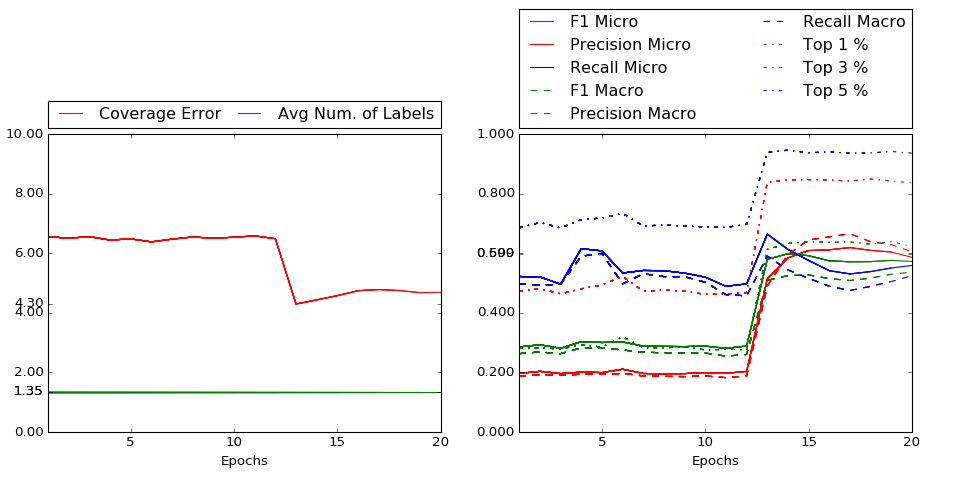

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]